<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/Cut_Patches_and_intersect_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# suppress output
%%capture 

!pip install rasterio
!pip install geopandas
!pip install progressbar2


In [0]:
# Load Dependencies
import numpy as np
import pandas as pd
import geopandas as gpd # vector spatial operations
from shapely.geometry import Polygon, Point # vector geometries
import rasterio as rio # raster spatial operations
from rasterio.plot import show #convenience wrapper for pyplot.imshow for RGB and 1 band images
import os
import time
import progressbar
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Functions
credit to # https://gis.stackexchange.com/questions/299787/finding-pixel-location-in-raster-using-coordinates

In [0]:
def nearest_neighbor_dist(centroid, list_points):
  dist = (list_points - centroid)**2
  dist = np.sum(dist, axis=1)
  dist = np.sqrt(dist)
  return dist.min()

In [0]:
# returns matrix of [n ships, patch_size, patch_size]
def create_ship_patches(ships, img, patch_size=50):
  coordinates = list(zip(ships.geometry.x, ships.geometry.y))
  with progressbar.ProgressBar(max_value=len(ships.index)) as bar: # creates progress bar
    patch_list = np.zeros([len(ships.index), patch_size, patch_size, len(img.indexes)])
    for i, (lon, lat) in enumerate(coordinates): # Loop through your list of coords
      py, px = img.index(lon, lat) # Get pixel coordinates from map coordinates
      window = rio.windows.Window(px - patch_size//2, py - patch_size//2, patch_size, patch_size) # Build an NxN window
      patch = img.read(window=window) # clip is a nbands * patch_size * patch_size numpy array
      patch_list[i] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
      bar.update(i)
  return patch_list.astype(int)

In [0]:
# creates patches for use in classifying ship or no ship
def create_patches(img, patch_size=50, step_size=30):
  n_patches = (len(range(0,img.height, step_size)) * len(range(0,img.width, step_size)))-(len(range(0,img.height, step_size)) + len(range(0,img.width, step_size)) - 1)
  patch_array = np.zeros([n_patches, patch_size, patch_size, len(img.indexes)])
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array 
          patch_array[index]=np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  patch_array = np.concatenate(patch_list, axis=0)
  return patch_array.astype(int)

In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship_nn(ships, img, patch_size=50, step_size=30):
  n_patches = (len(range(0,img.height, step_size)) * len(range(0,img.width, step_size)))-(len(range(0,img.height, step_size)) + len(range(0,img.width, step_size)) - 1)
  isShip_list = [] #list to hold all the patch locations
  x_list = []
  y_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          # create centroid point
          centroid = Point(window.col_off+patch_size/2, window.row_off+patch_size/2)
          ship_distance = nearest_neighbor_dist([centroid.x, centroid.y], np.column_stack([ships.geometry.x, ships.geometry.y]))
          if ship_distance <= patch_size * img.transform[0] / 2:
            isShip = True
          else:
            isShip = False
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship_buffers(ships, img, patch_size=50, step_size=30):
  n_patches = (len(range(0,img.height, step_size)) * len(range(0,img.width, step_size)))
  isShip_list = [] #list to hold all the patch locations
  buffer_list = []
  x_list = []
  y_list = []
  index = 0

  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          #create centroid point
          centroid = Point(img.transform *(window.col_off+patch_size/2, window.row_off+patch_size/2))
          buffer = centroid.buffer(img.transform[0]*step_size/1.5)
          buffer_list.append(buffer)
          # possible_matches_index = list(ships.intersection(buffer.bounds))
          # possible_matches = ships.iloc[possible_matches_index]
          # precise_matches = possible_matches[possible_matches.intersects(geometry)]
          # if len(precise_matches) > 0:
          #   isShip = True
          # else:
          #   isShip = False
          isShip = np.any(ships.intersects(buffer)) #intersect ships with polygon and check if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = gpd.GeoDataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size, 'geometry': buffer_list}, crs=ships.crs)
  return results

In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship_poly(ships, img, patch_size=50, step_size=30):
  n_patches = (len(range(0,img.height, step_size)) * len(range(0,img.width, step_size)))-(len(range(0,img.height, step_size)) + len(range(0,img.width, step_size)) - 1)
  isShip_list = [] #list to hold all the patch locations
  x_list = []
  y_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          # create polygon with patches spatial coordinates
          # MAKE CENTROID
          patch_poly = Polygon([img.transform * (window.col_off+patch_size*0.25, window.row_off+patch_size*0.25), #must be a more pythonic way to do this
                                img.transform * (window.col_off+patch_size*0.75, window.row_off+patch_size*0.25),
                                img.transform * (window.col_off+patch_size*0.75, window.row_off+patch_size*0.75),
                                img.transform * (window.col_off+patch_size*0.25, window.row_off+patch_size*0.75)])
          # BUFFER CENTROID
          # OR KNN distance from patch to
          isShip = np.any(ships.intersects(patch_poly)) #intersect ships with polygon and chek if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

# Testing

In [12]:
drive_path = '/content/drive/My Drive/MUSA-650-Final-Project/'
# NOTE: unified notebook will be able to use the title field from sceneMeta to get specific images and ship points
files = os.listdir(drive_path)
files

['S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031.jp2',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2',
 'S2B_MSIL1C_20171122T032029_N0206_R118_T48NUG_20200423T142704.jp2',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323_SHIPS.geojson',
 'S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031_SHIPS.geojson',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736_SHIPS.geojson',
 'S2B_MSIL1C_20171122T032029_N0206_R118_T48NUG_20200423T142704_SHIPS.geojson',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736_buffers.geojson']

In [0]:
# load ship points
ship_points = gpd.read_file('/content/drive/My Drive/MUSA-650-Final-Project/S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736_SHIPS.geojson')

In [0]:
# load satelite image
sat_img = rio.open('/content/drive/My Drive/MUSA-650-Final-Project/S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2')

In [15]:
pointz = Point(sat_img.transform * (10, 4))
pointz.xy, sat_img.bounds.left, sat_img.bounds.top

((array('d', [300100.0]), array('d', [200000.0])), 300000.0, 200040.0)

In [37]:
nn = patch_centroid_buffers(ship_points, img=sat_img, patch_size=50, step_size=50)

100% (48400 of 48400) |##################| Elapsed Time: 0:01:39 Time:  0:01:39


In [0]:
nn.head()

In [30]:
#half step size
ship_points.sindex
print(ship_points.sindex)

None


In [38]:
#full step size
np.unique(nn.isShip, return_counts=True)

(array([False,  True]), array([47630,   331]))

In [0]:
nn.to_file('/content/drive/My Drive/MUSA-650-Final-Project/S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736_buffers.geojson')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


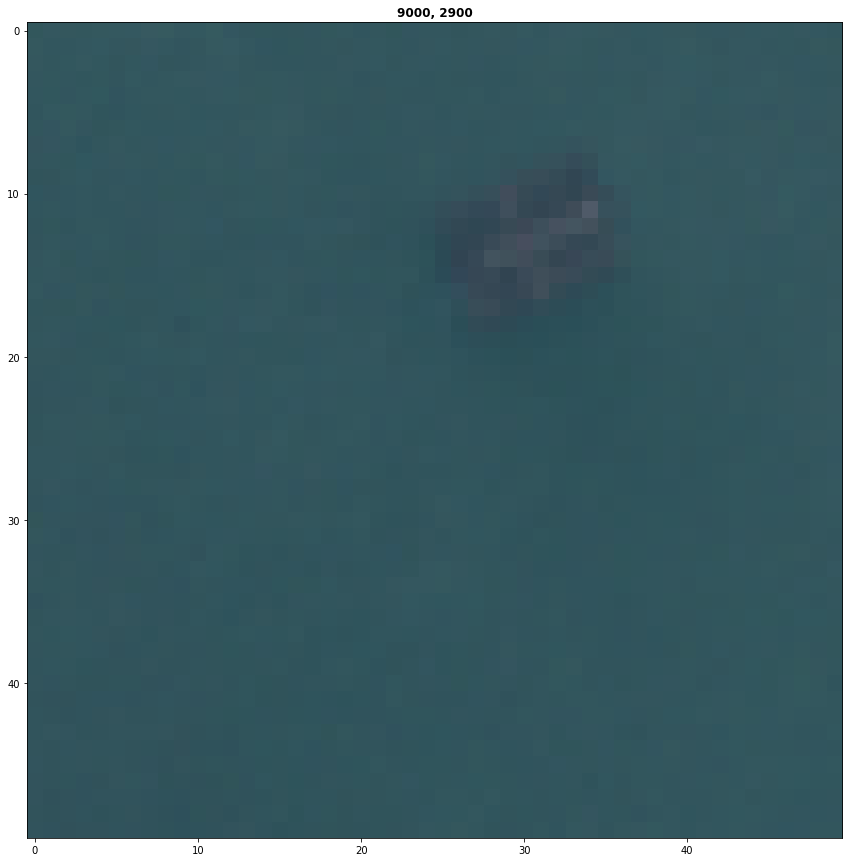

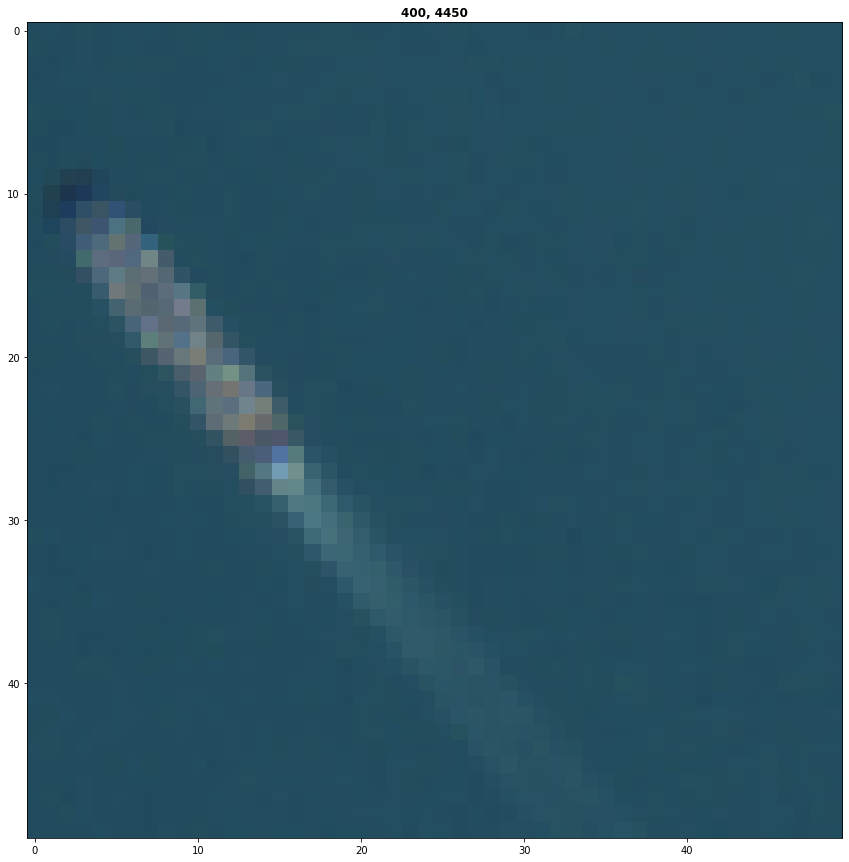

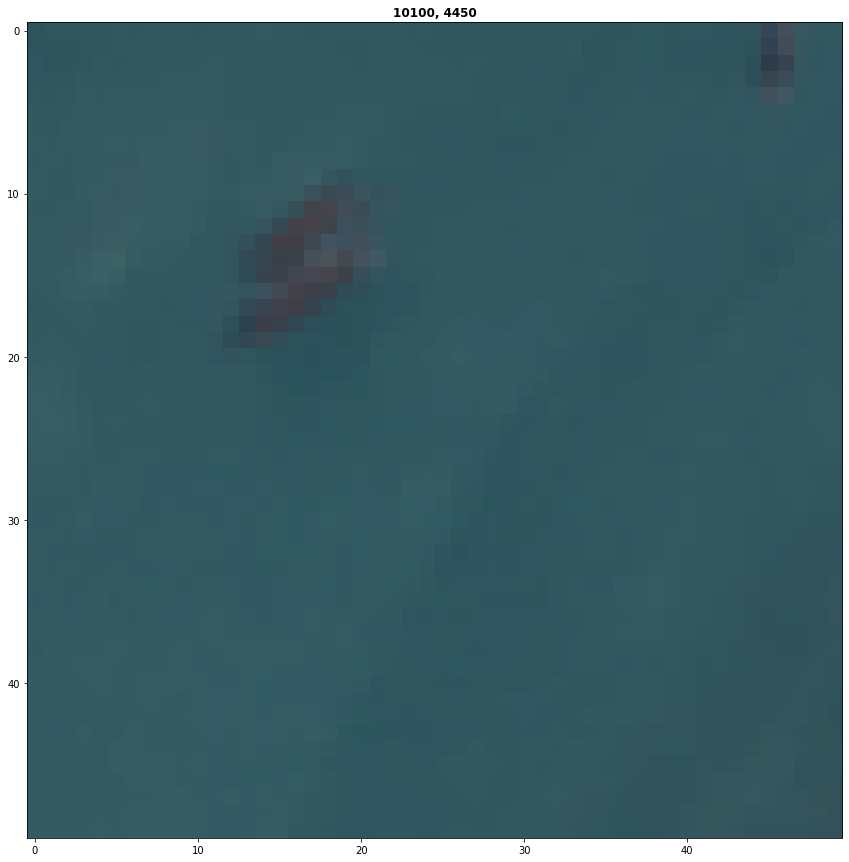

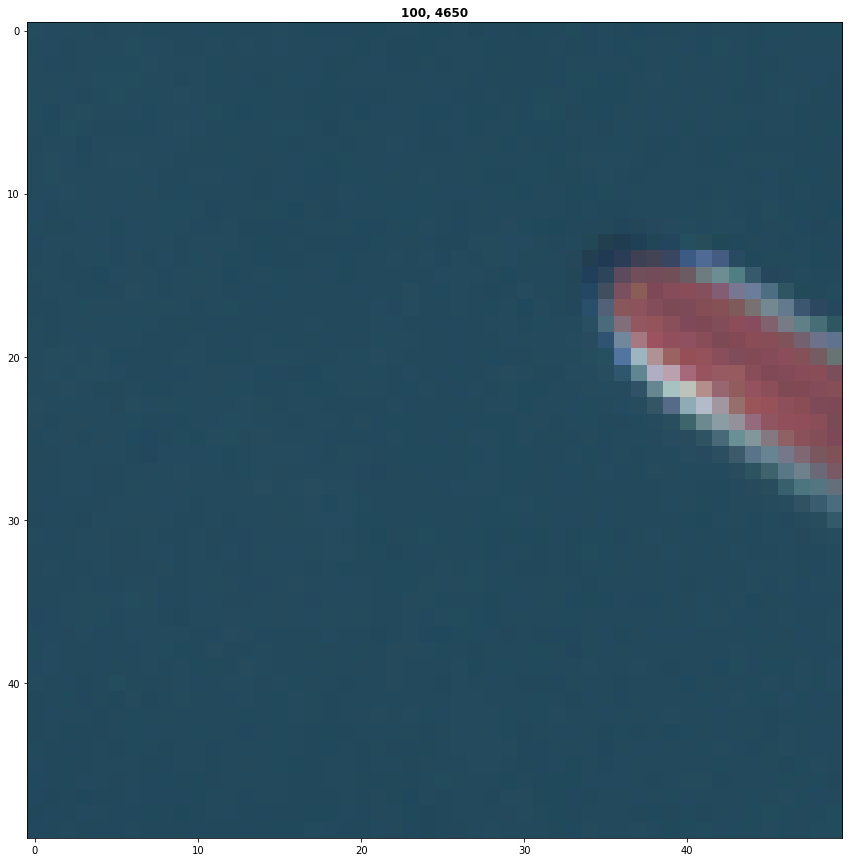

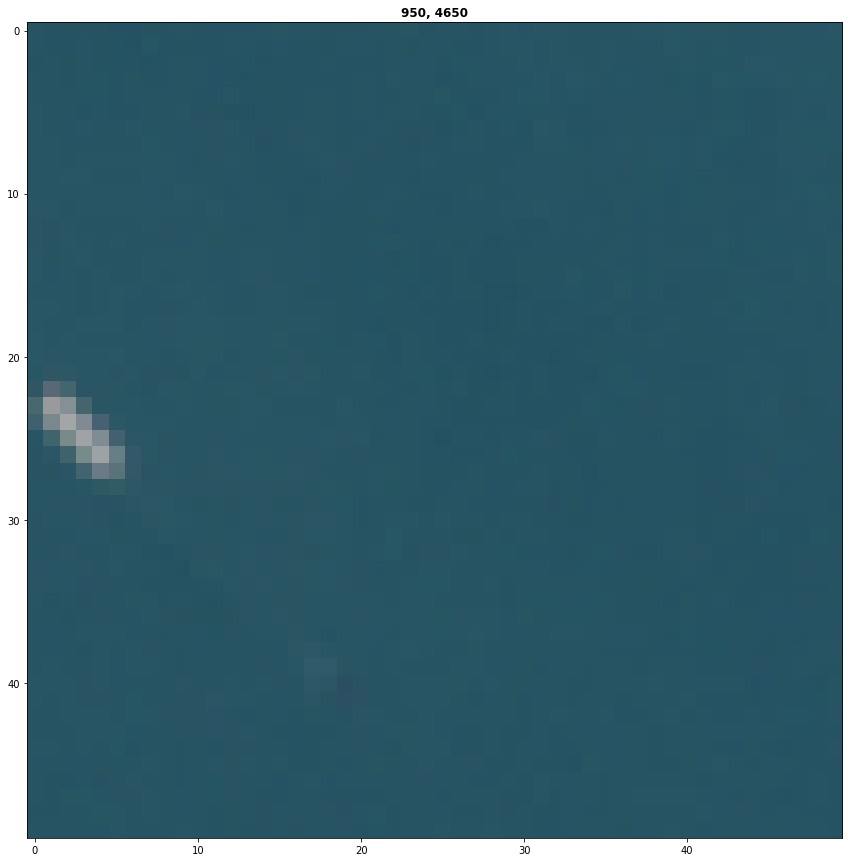

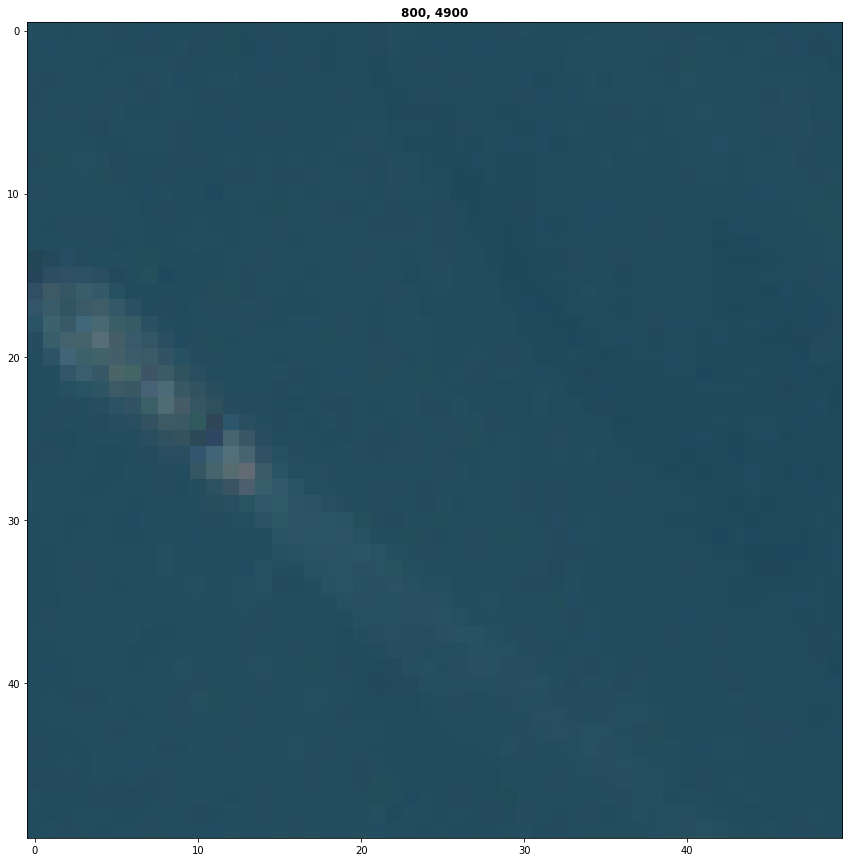

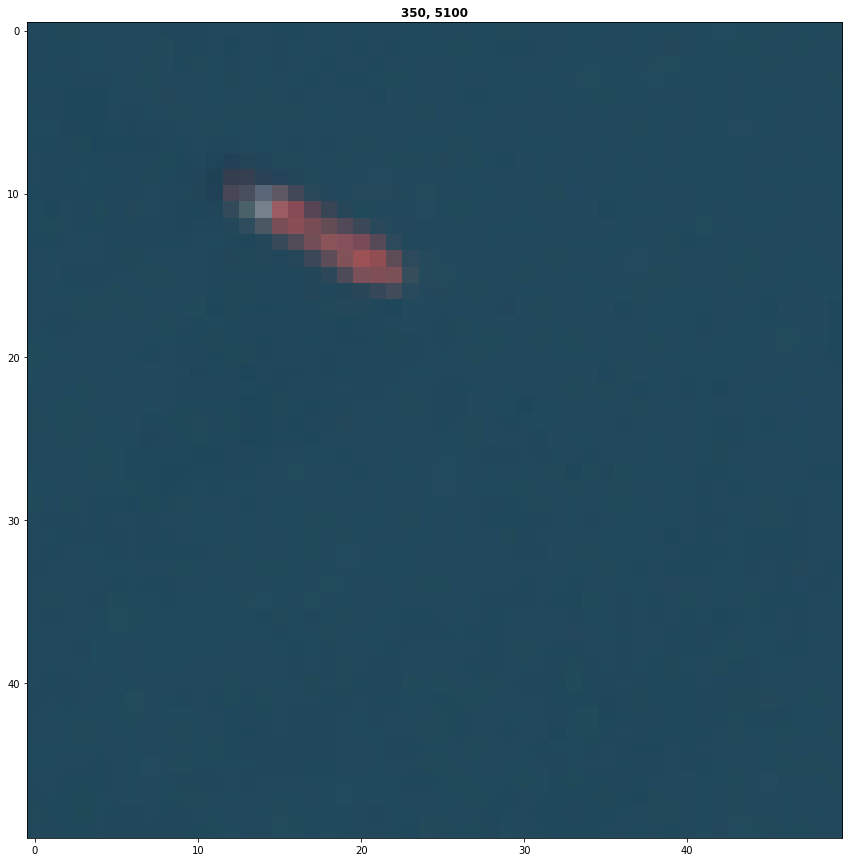

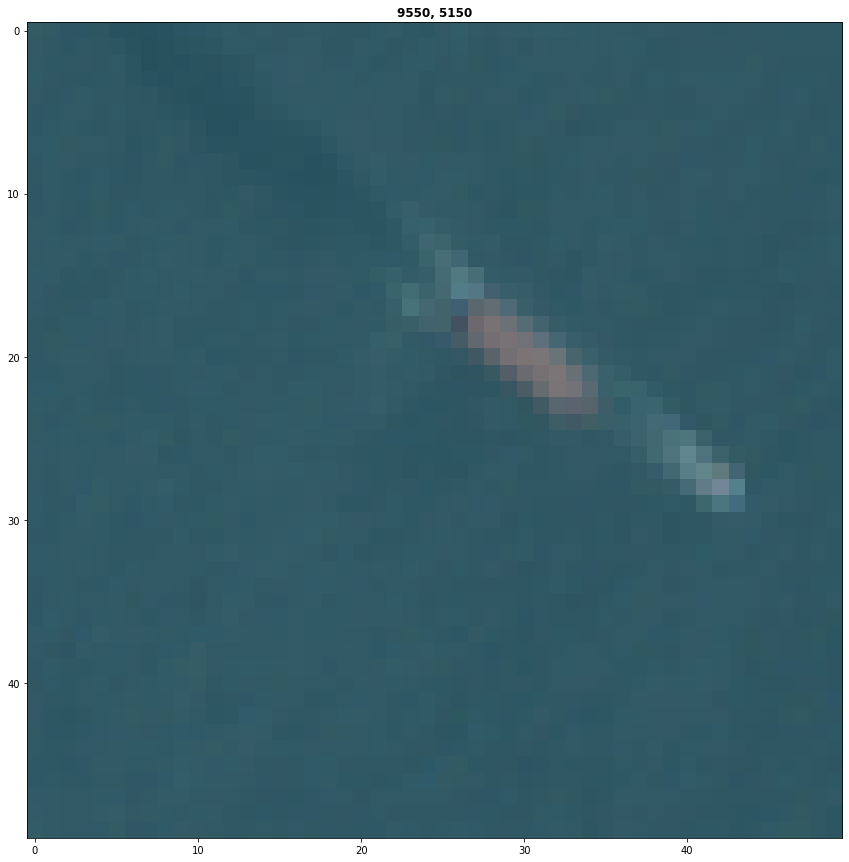

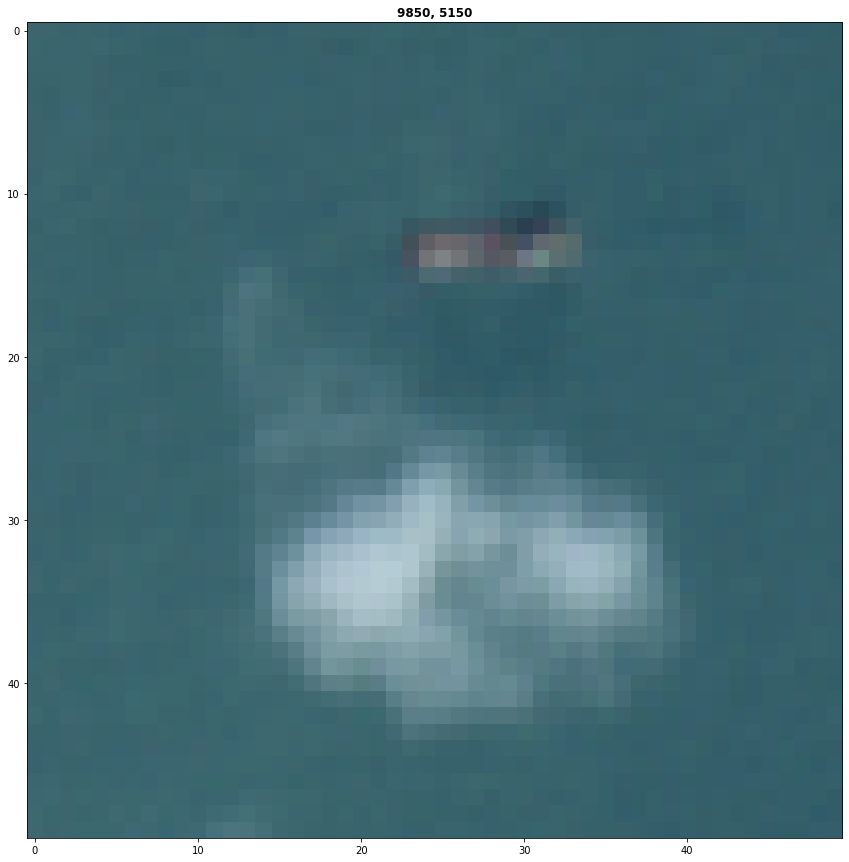

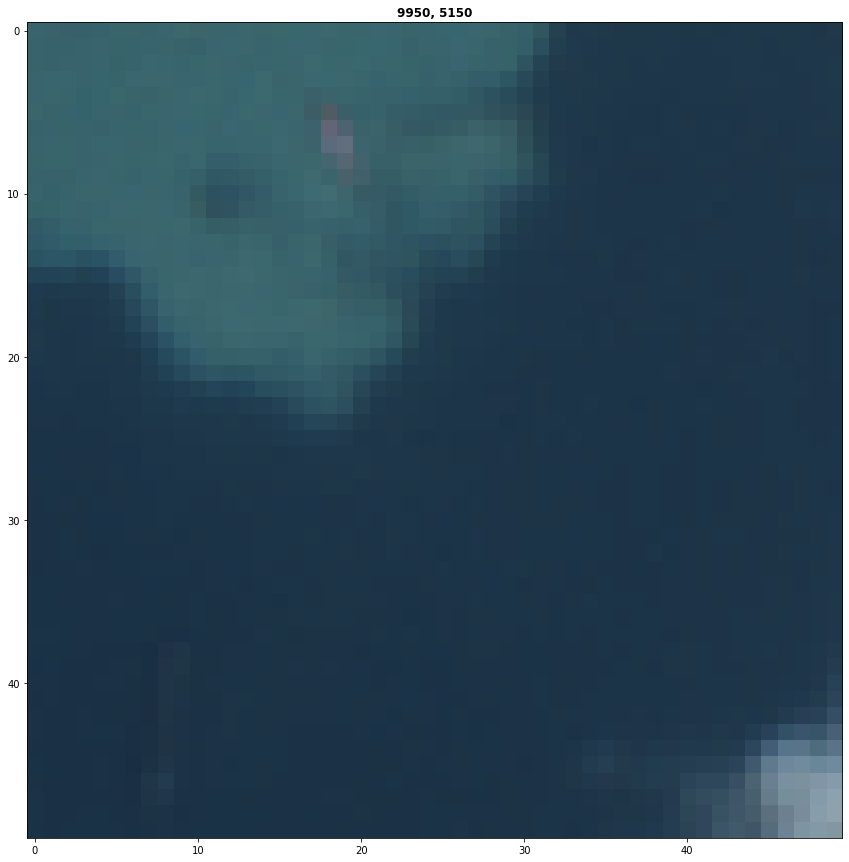

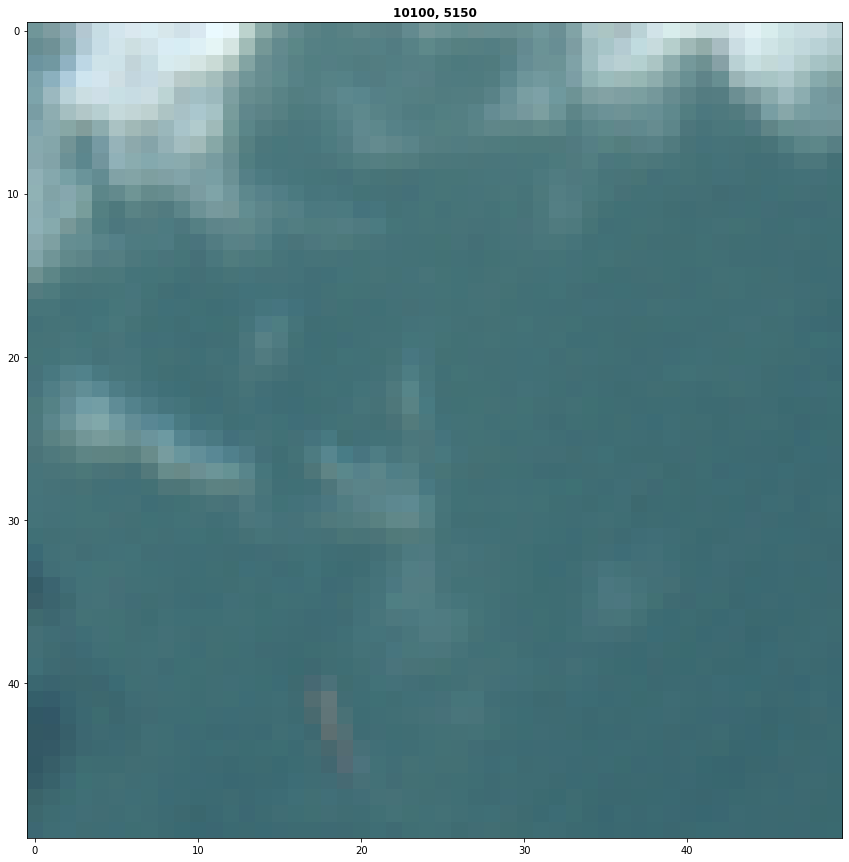

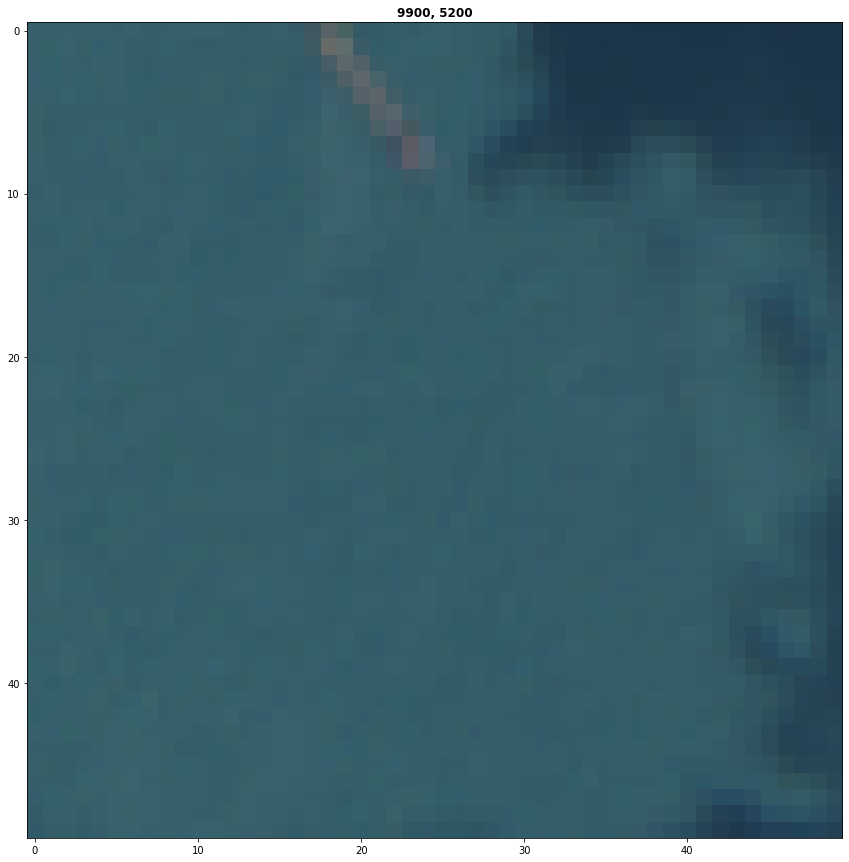

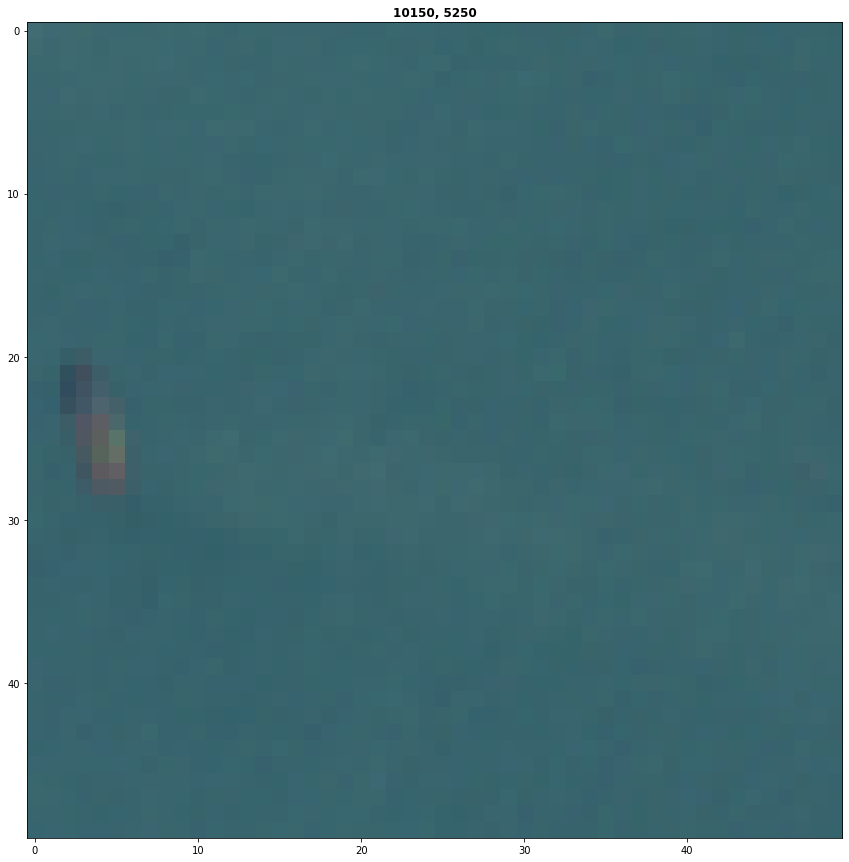

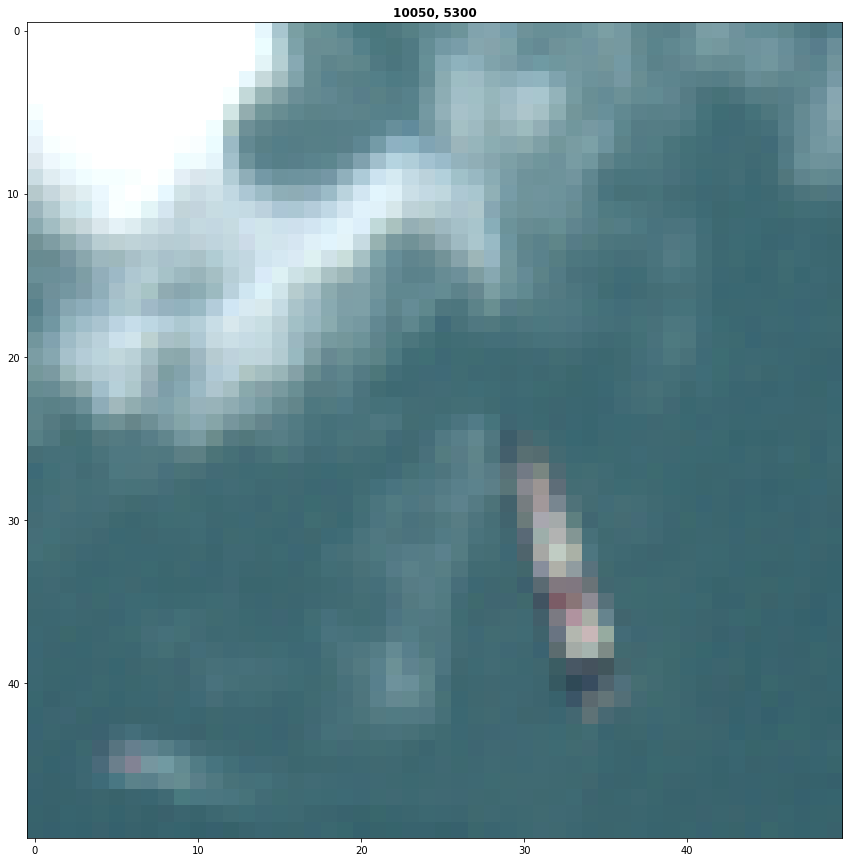

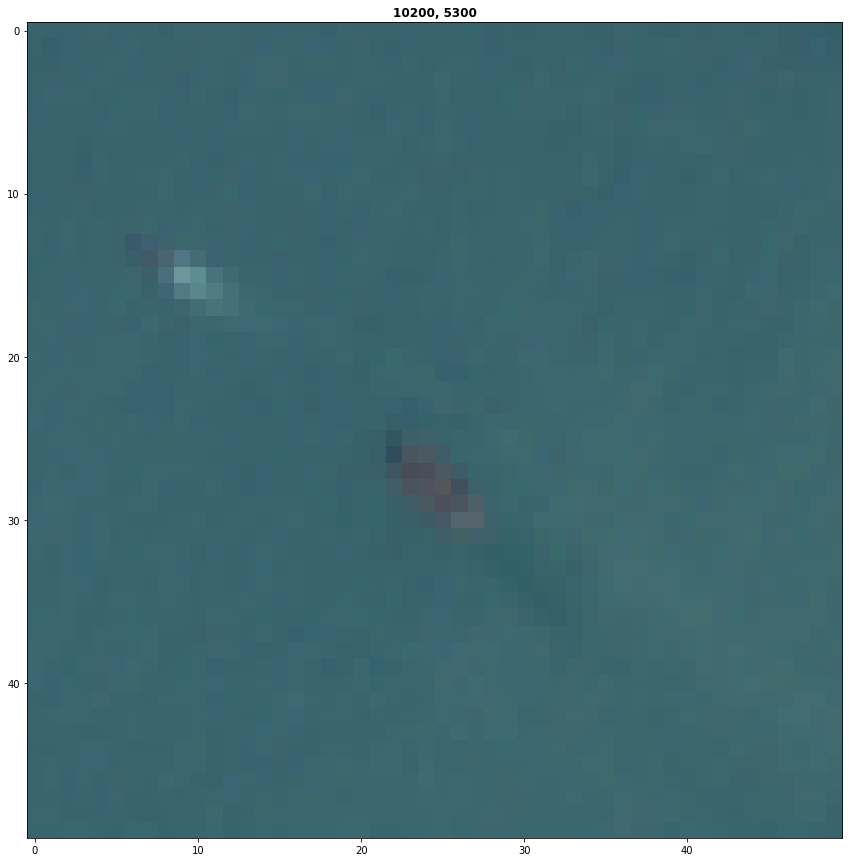

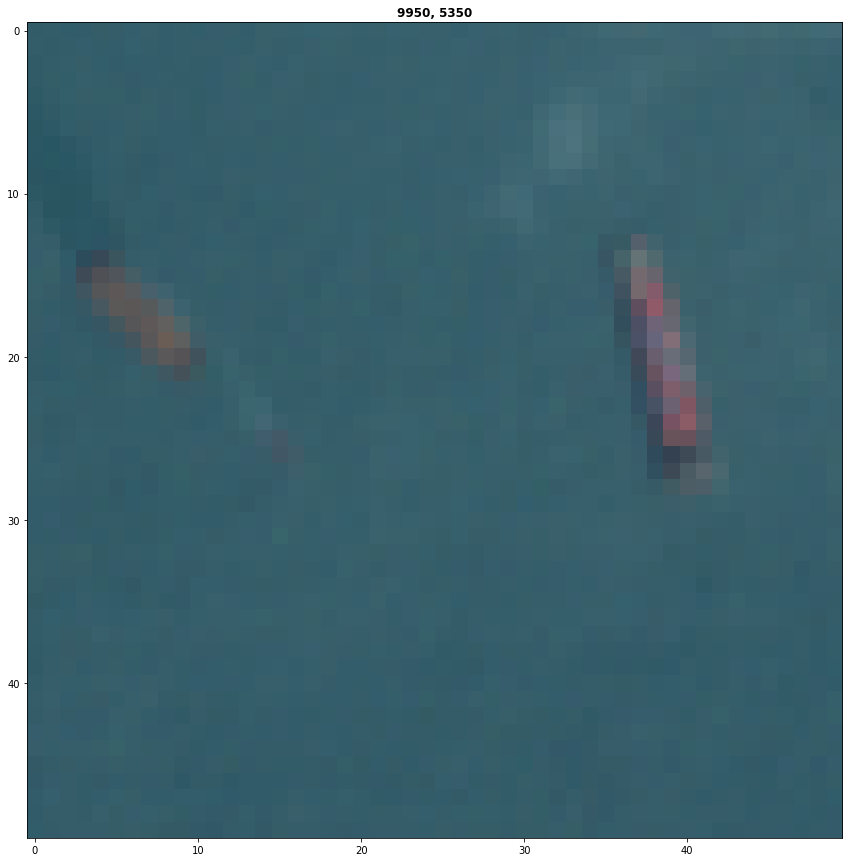

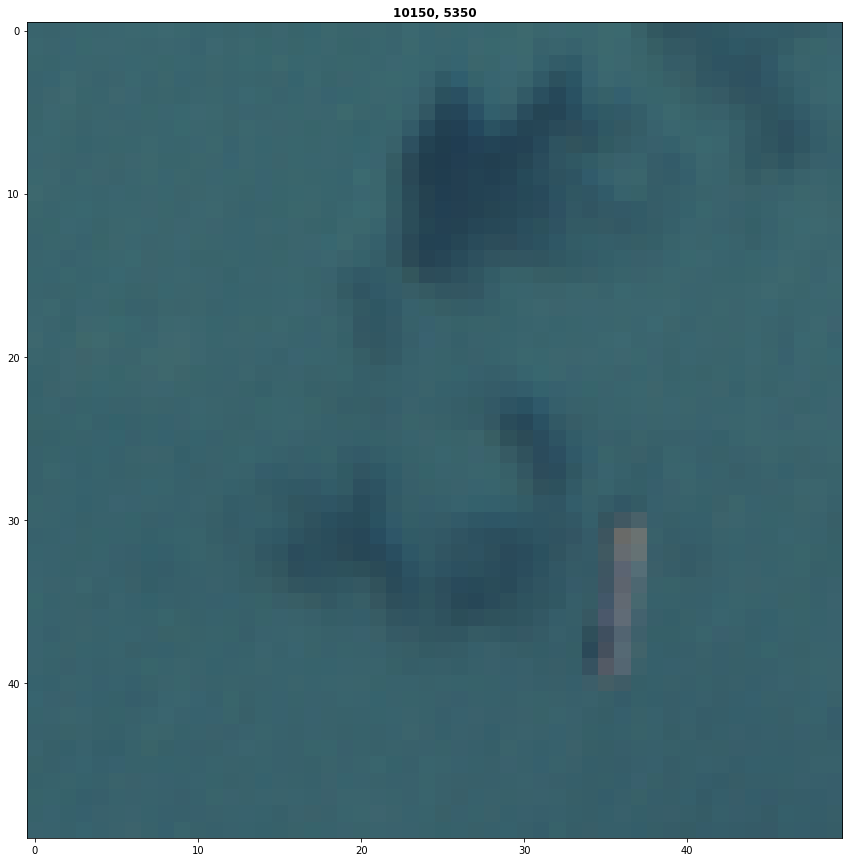

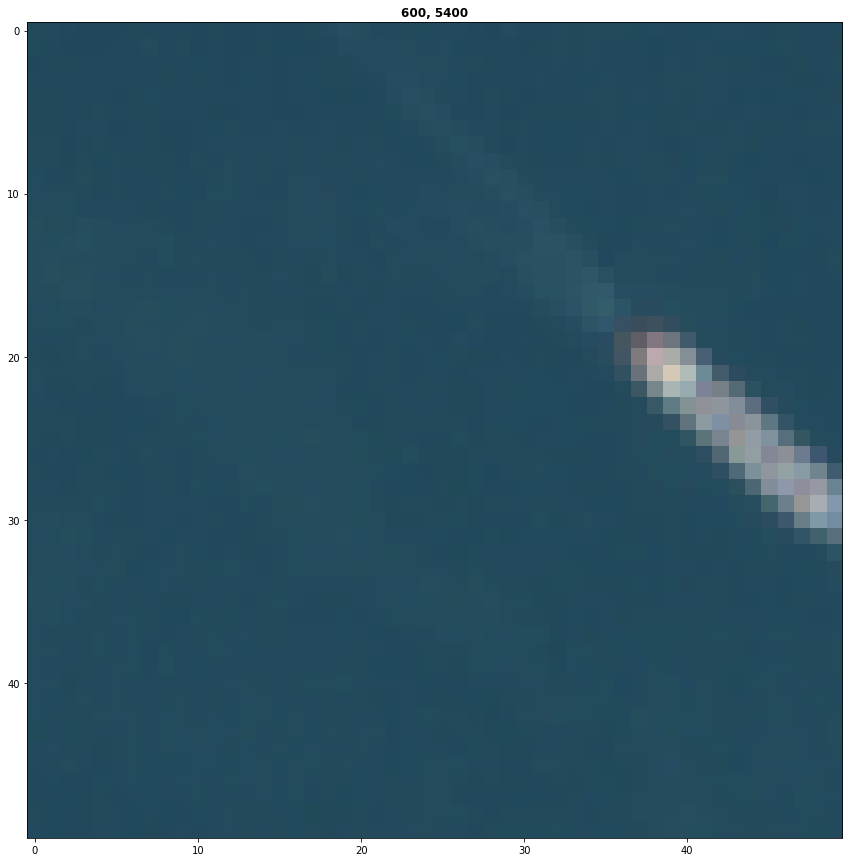

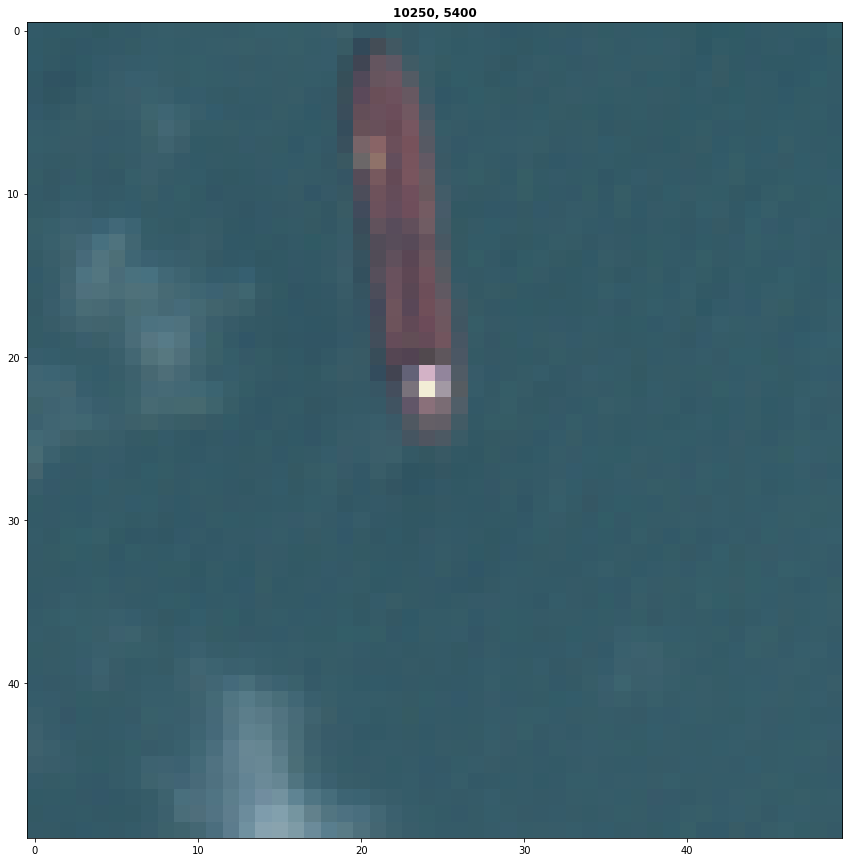

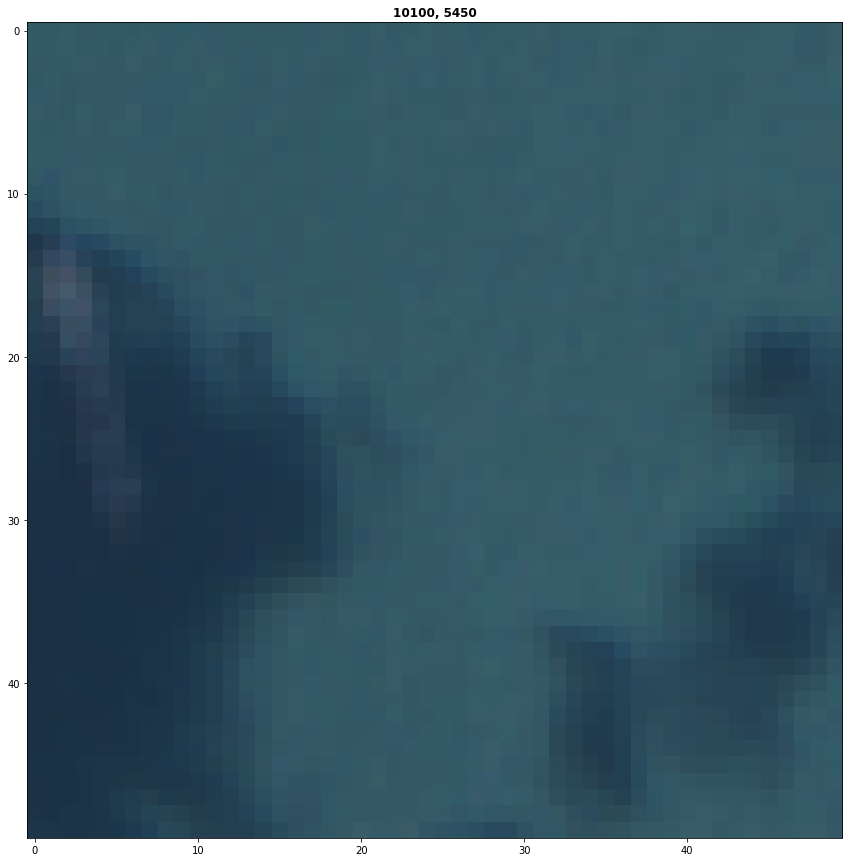

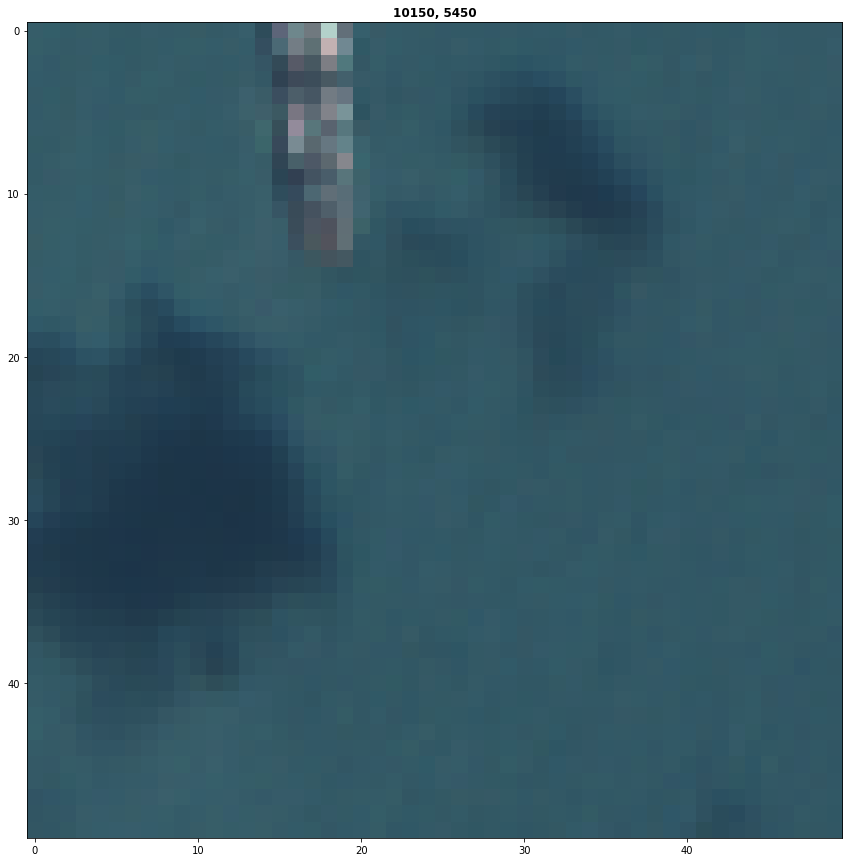

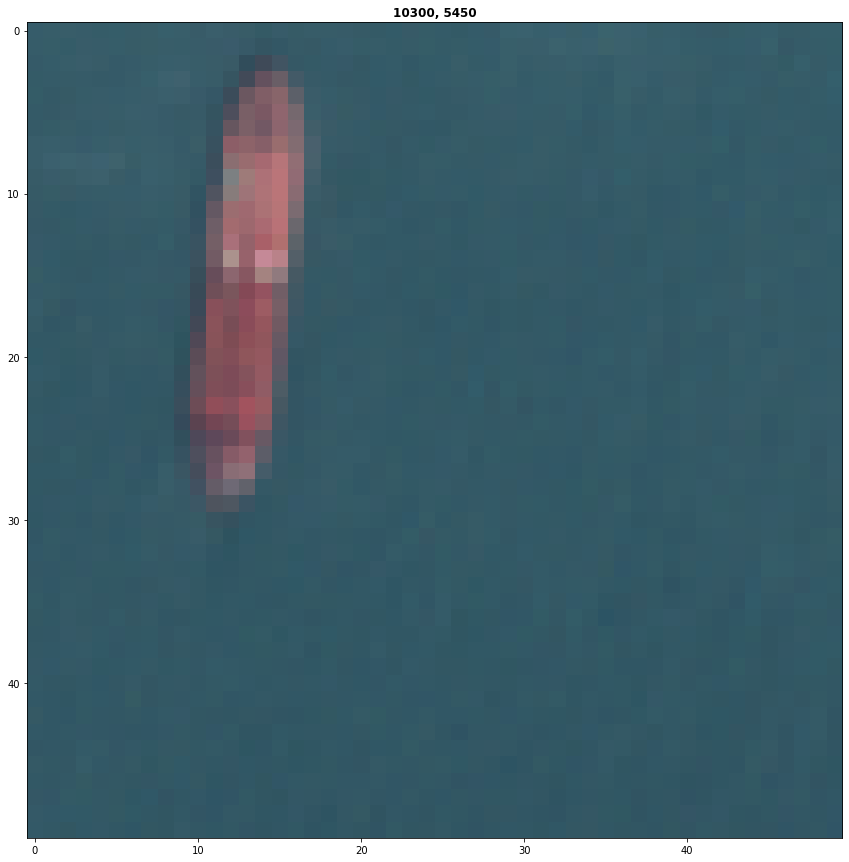

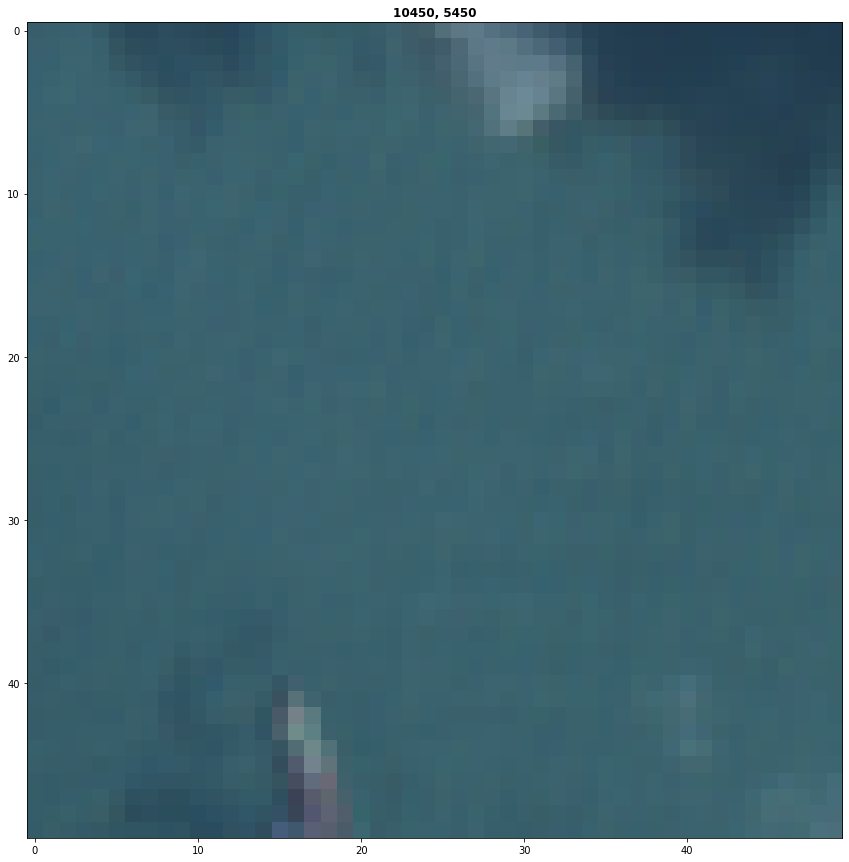

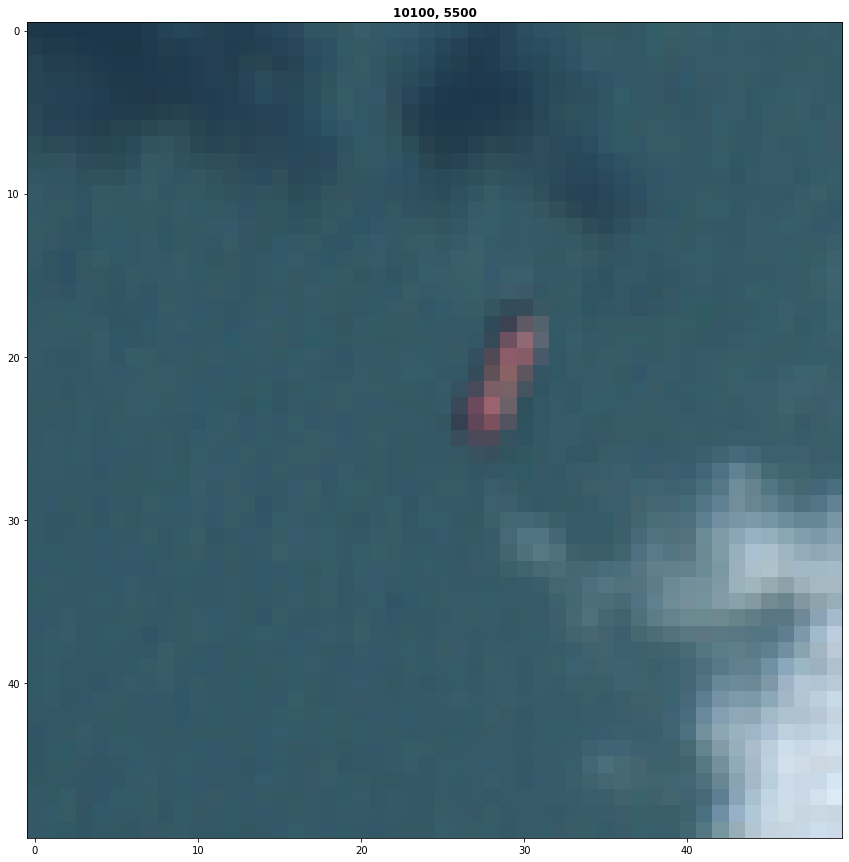

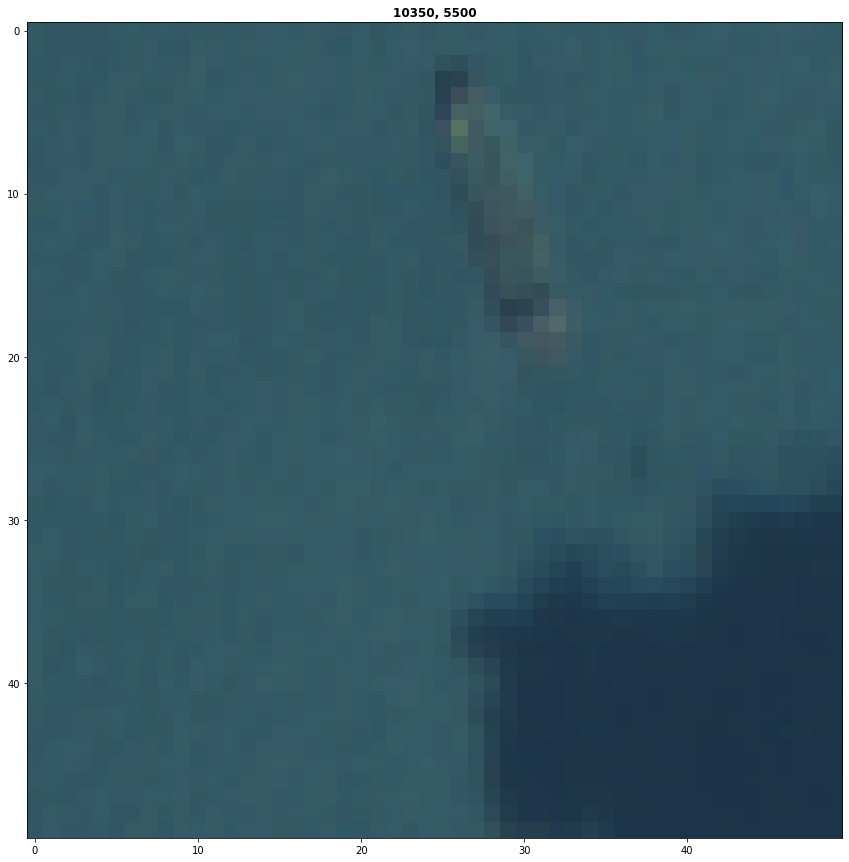

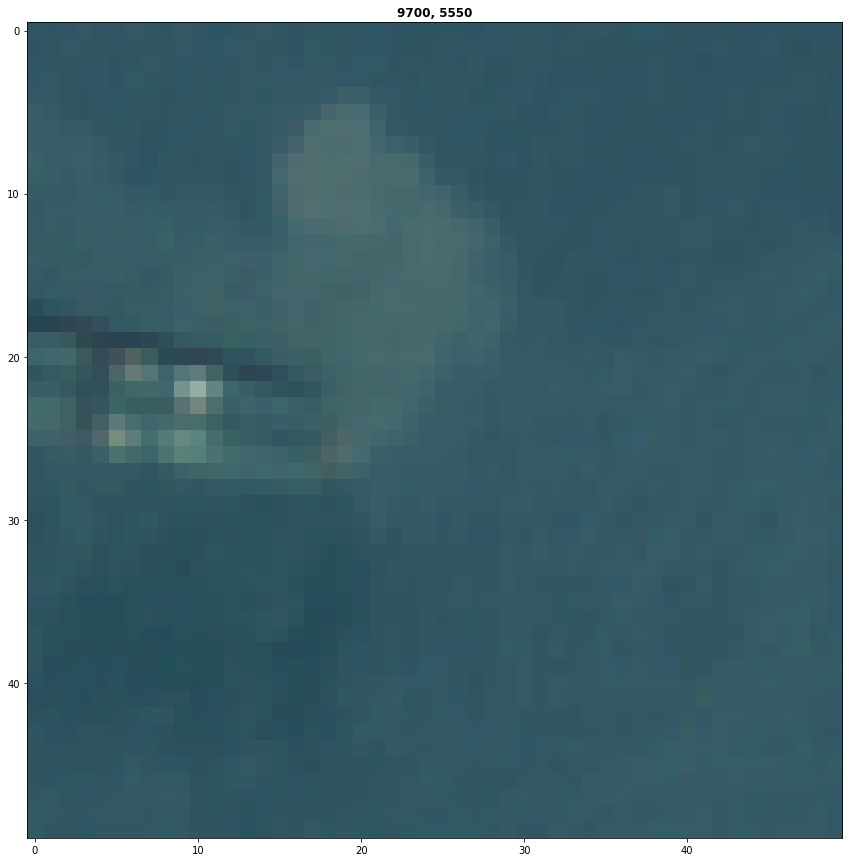

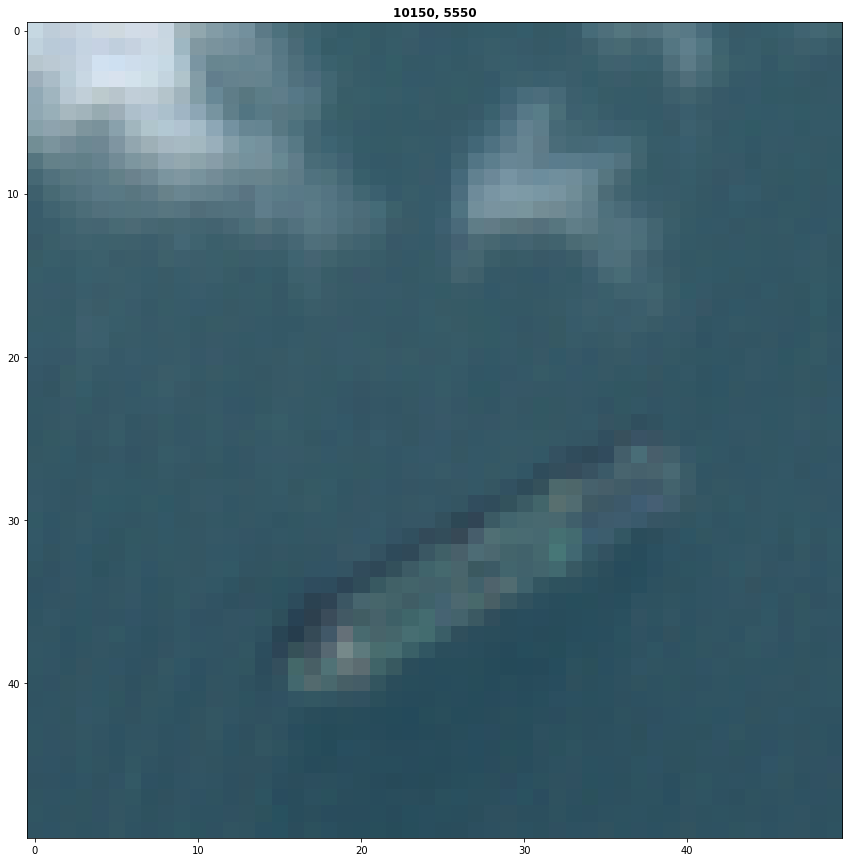

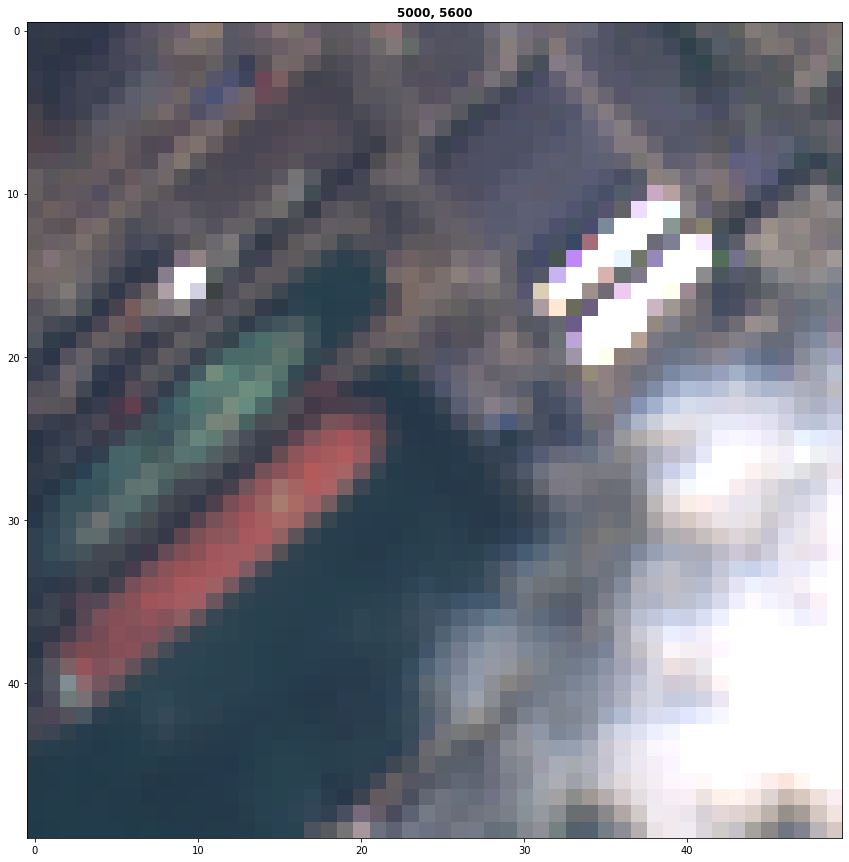

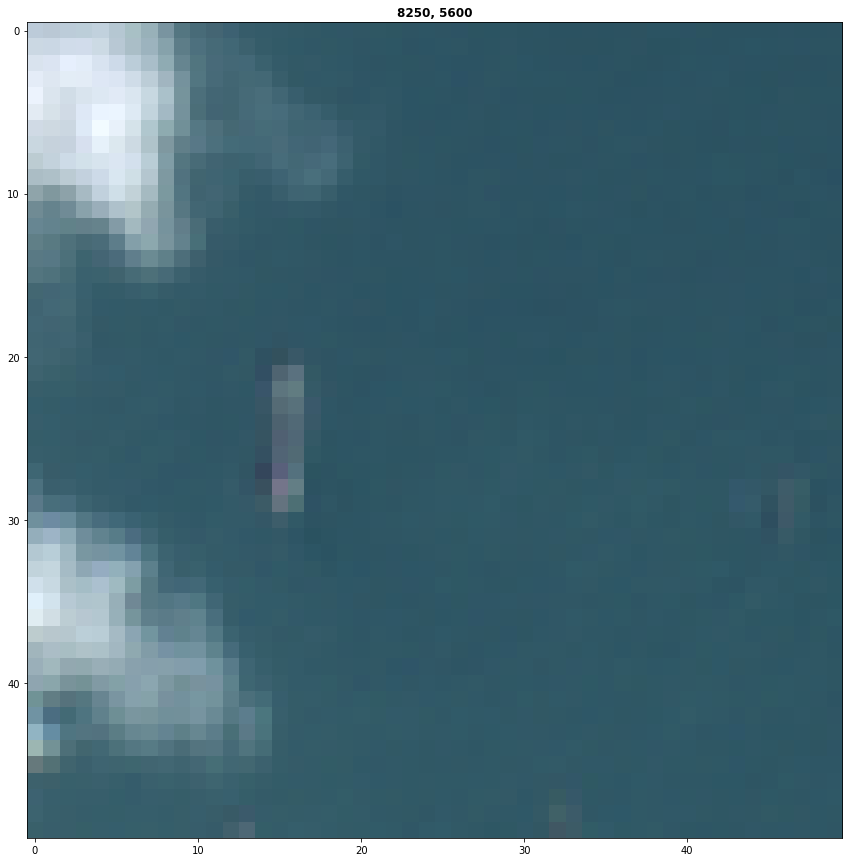

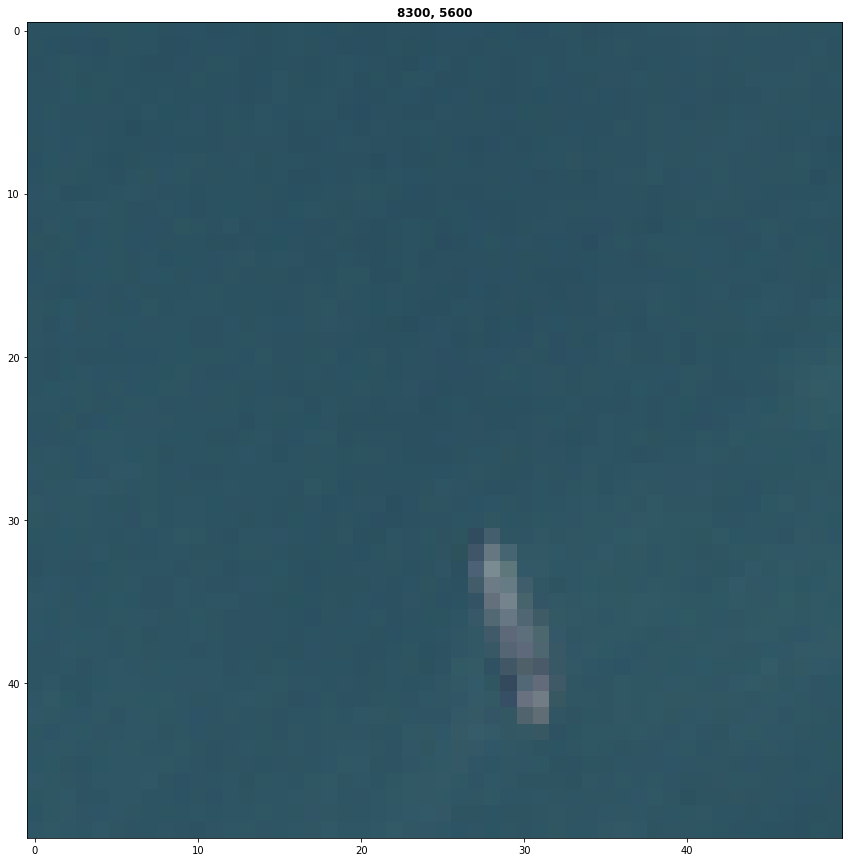

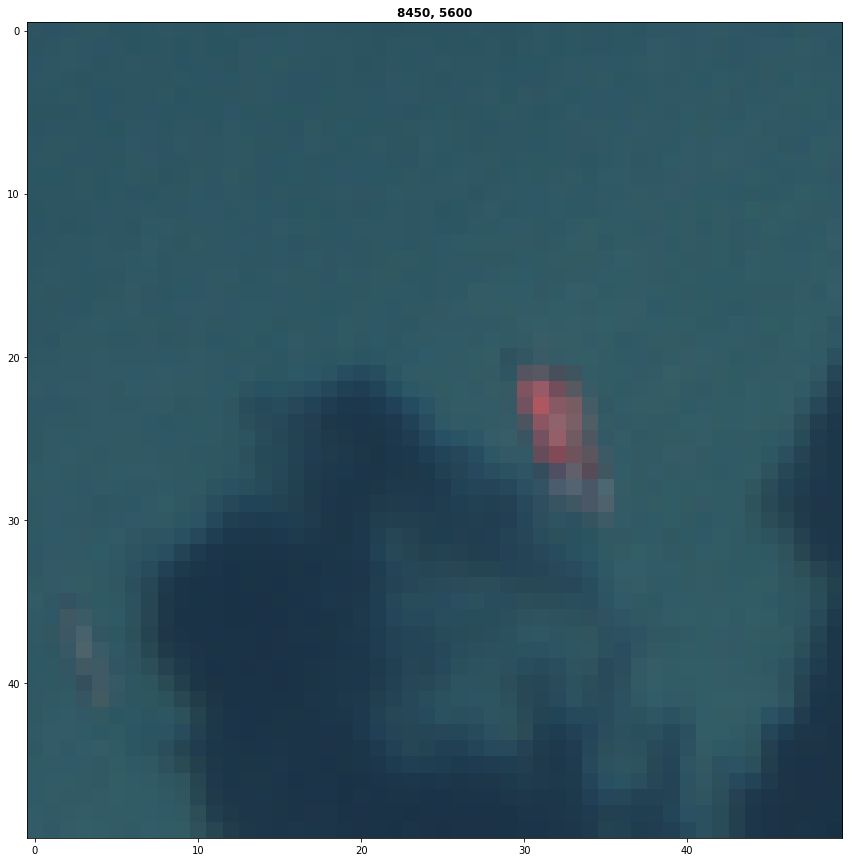

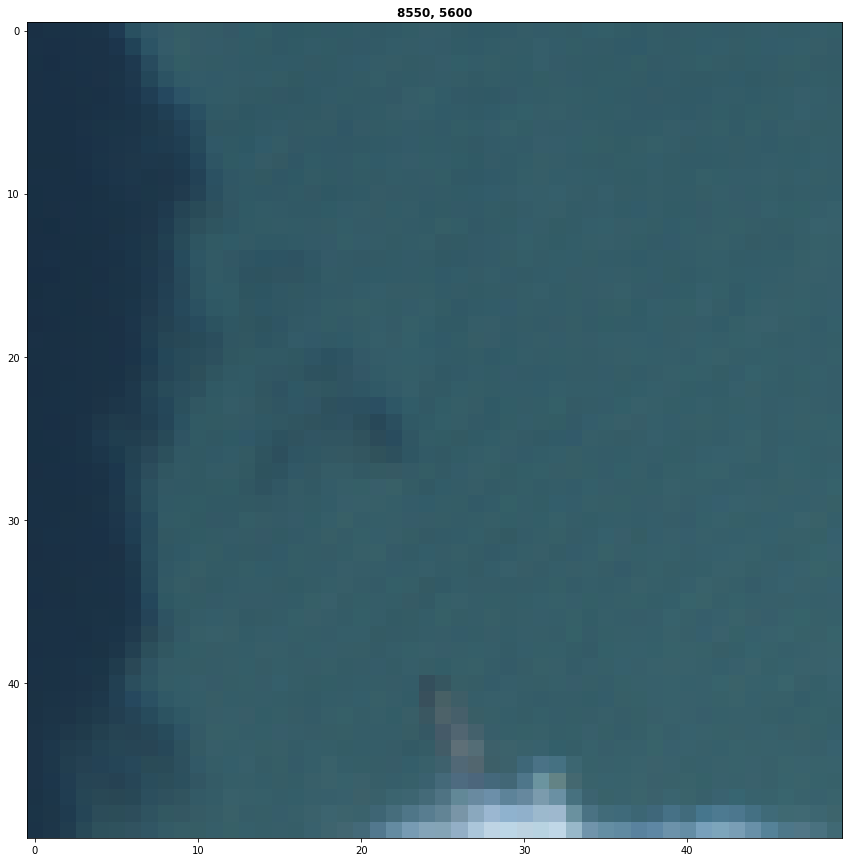

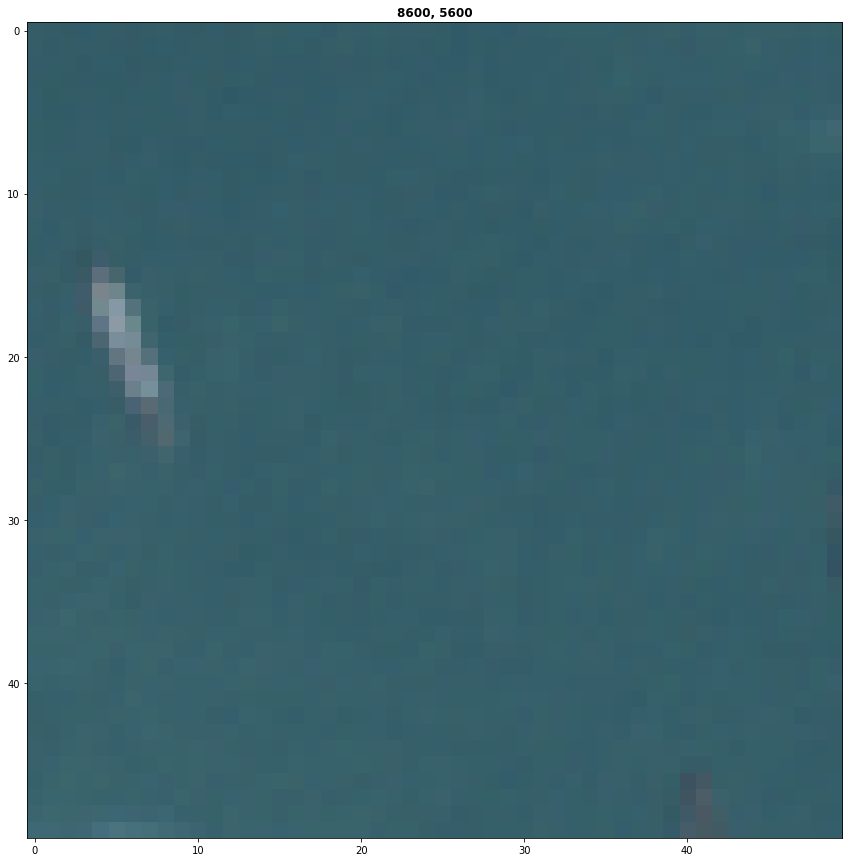

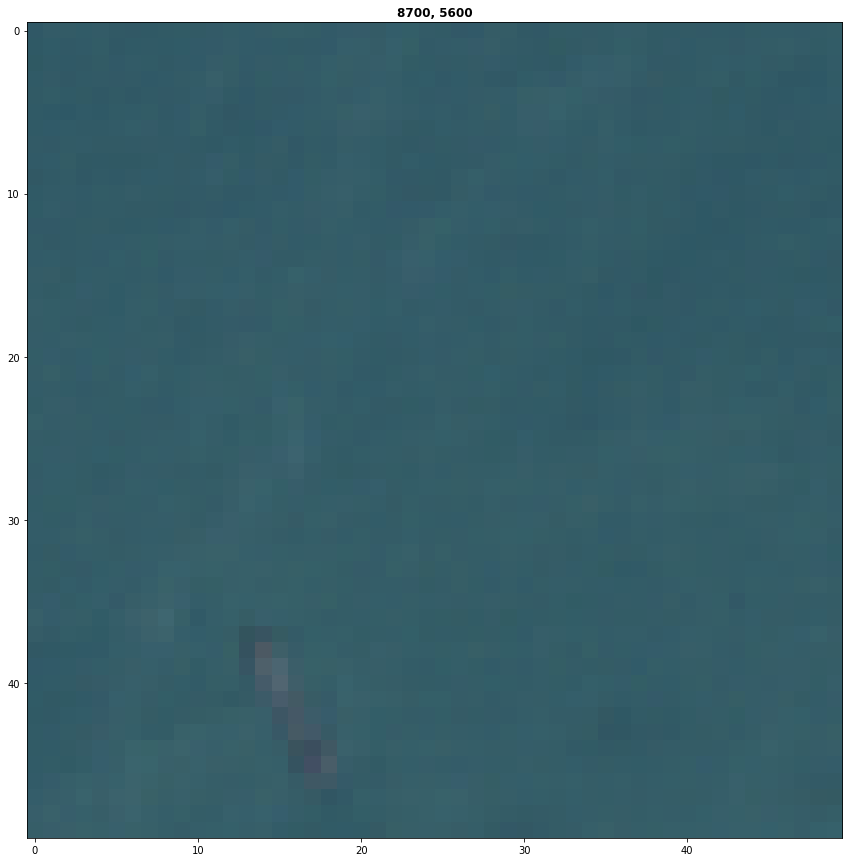

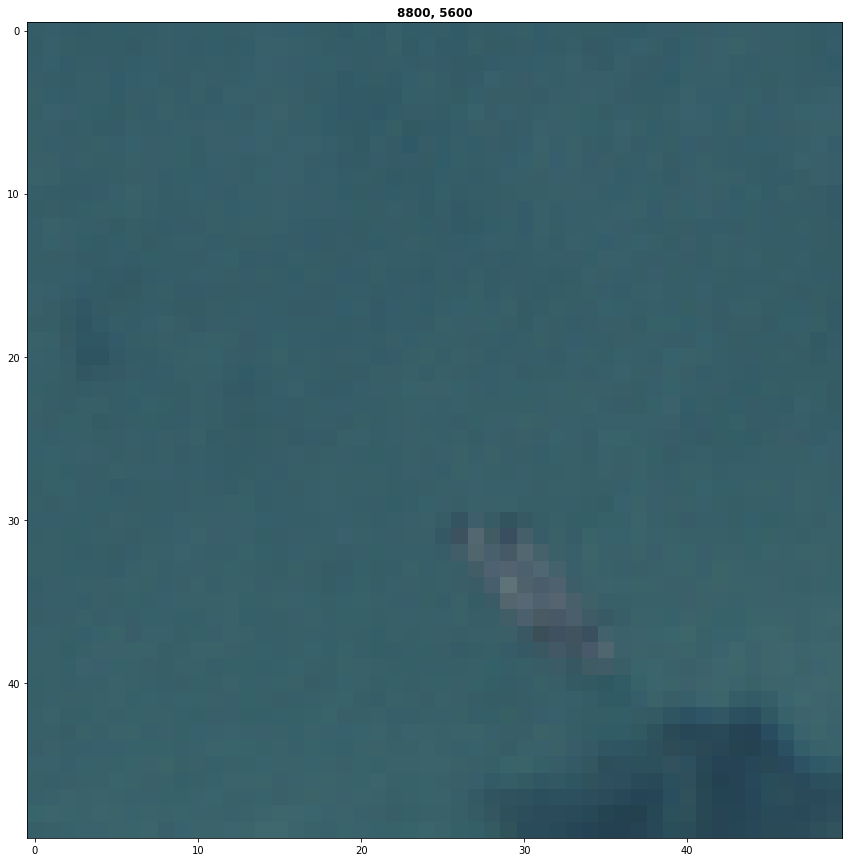

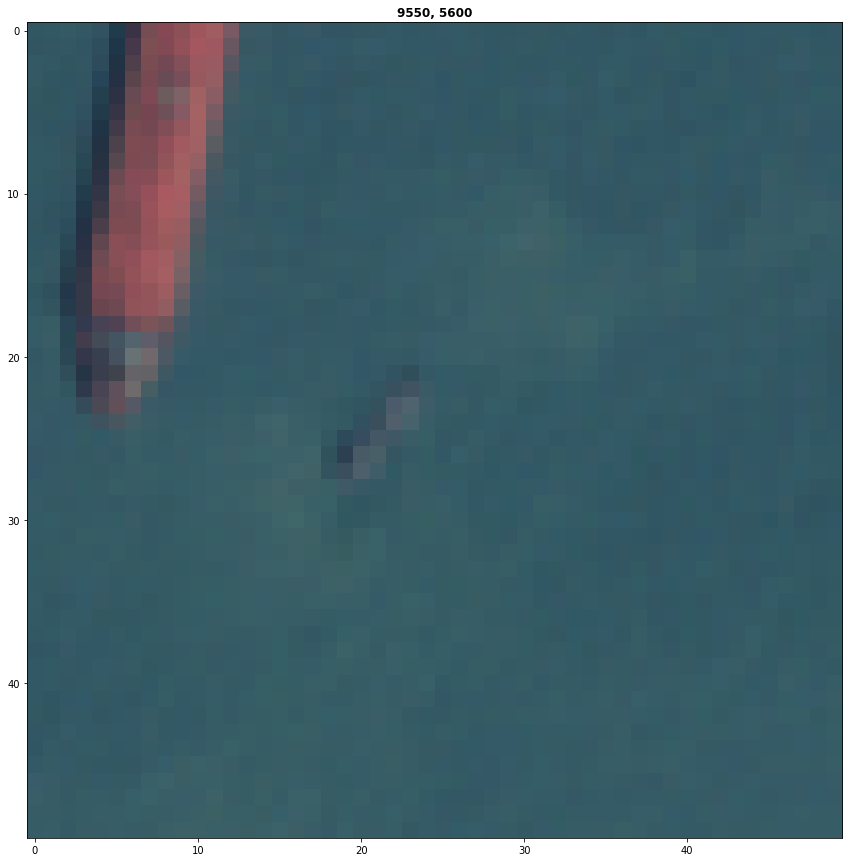

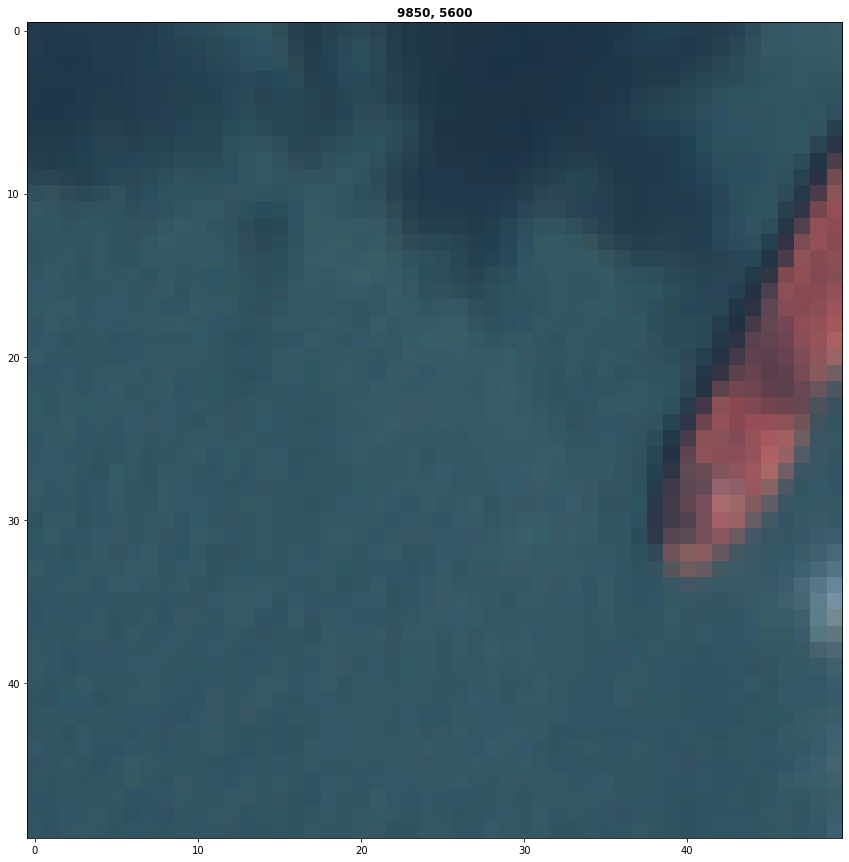

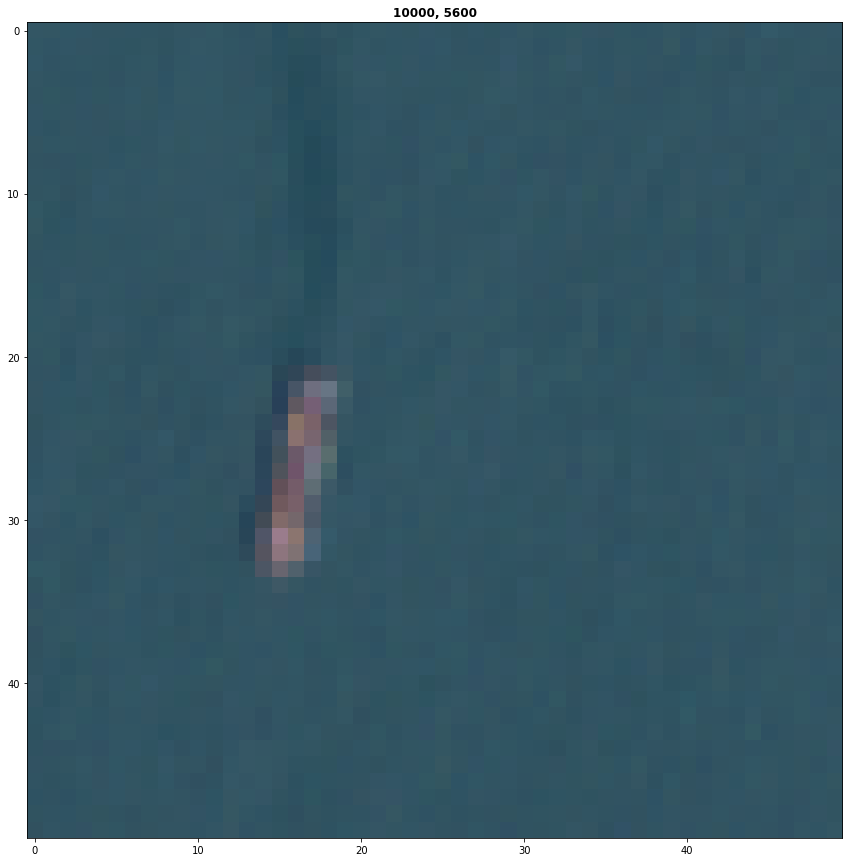

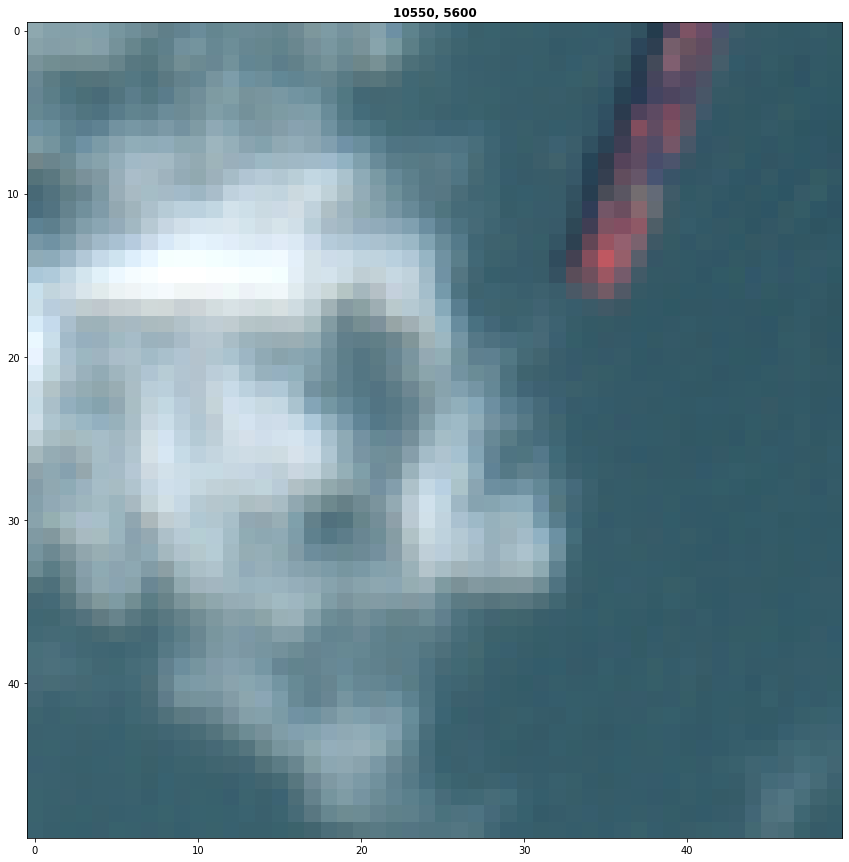

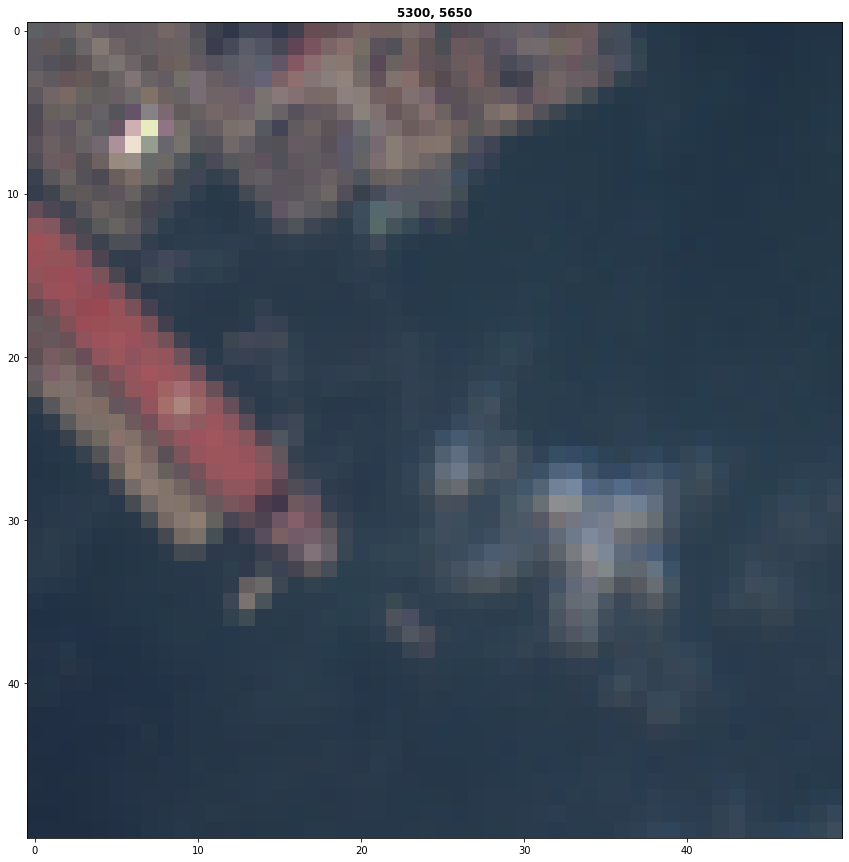

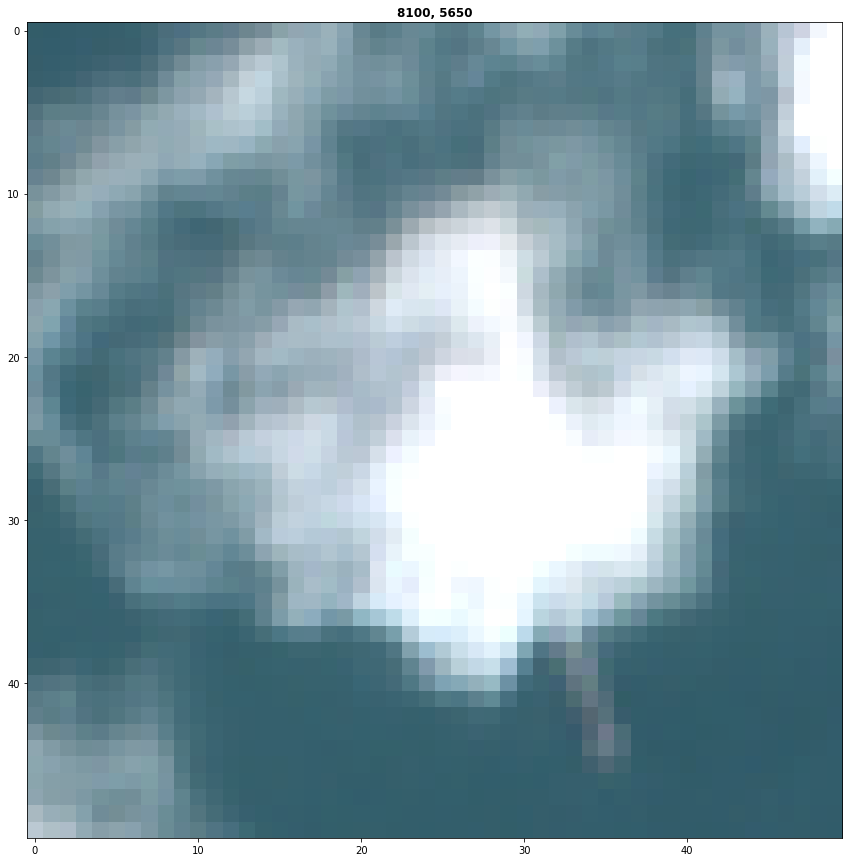

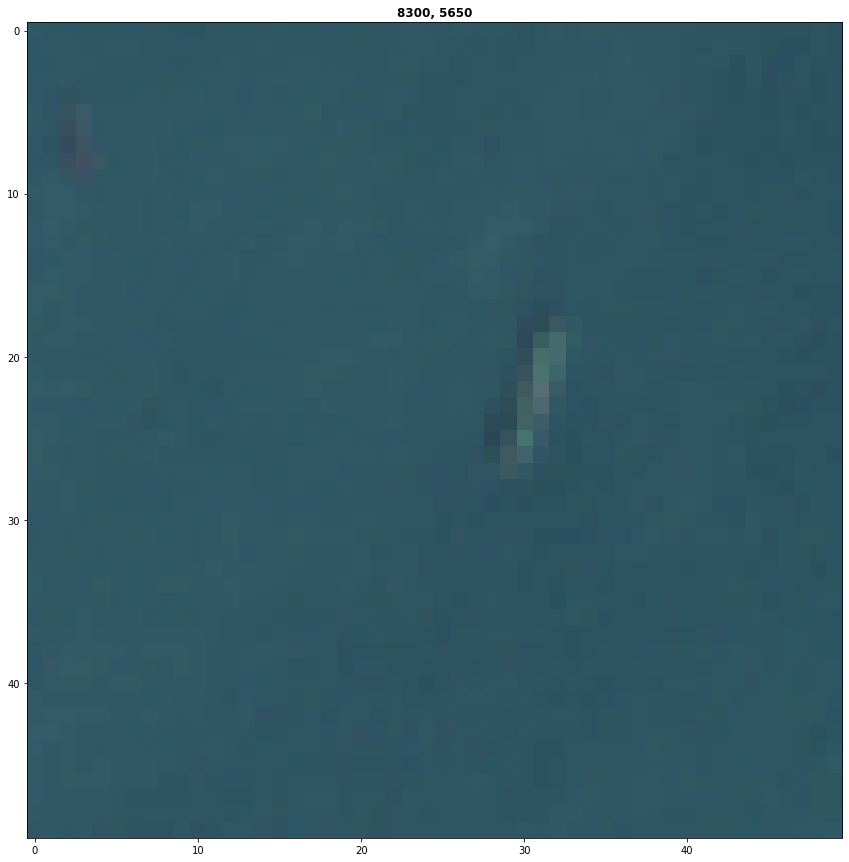

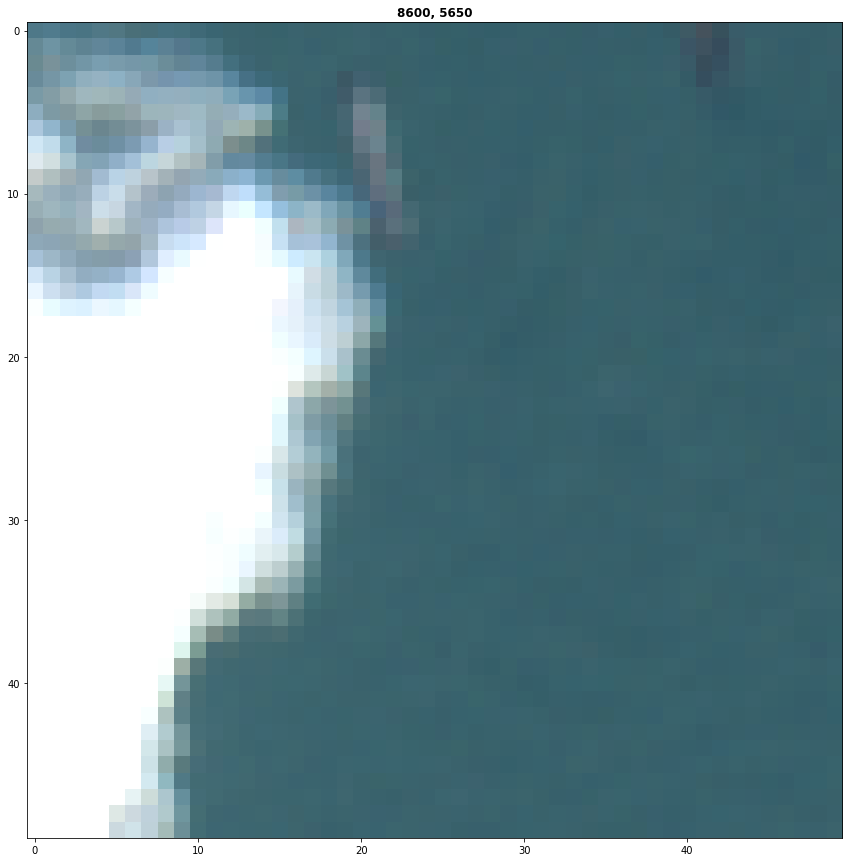

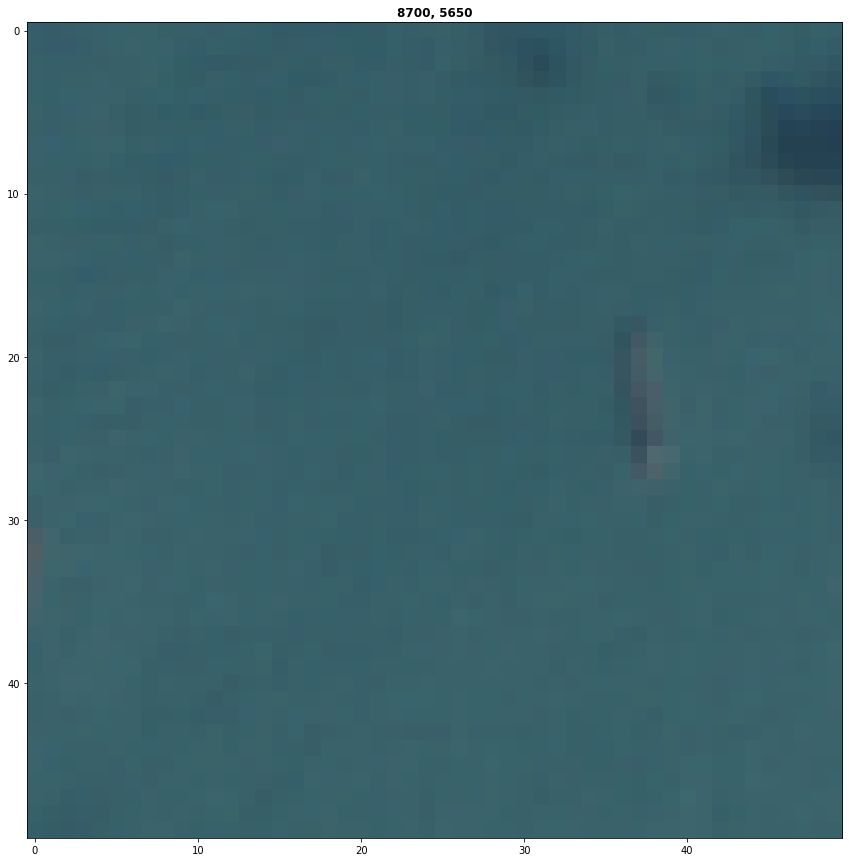

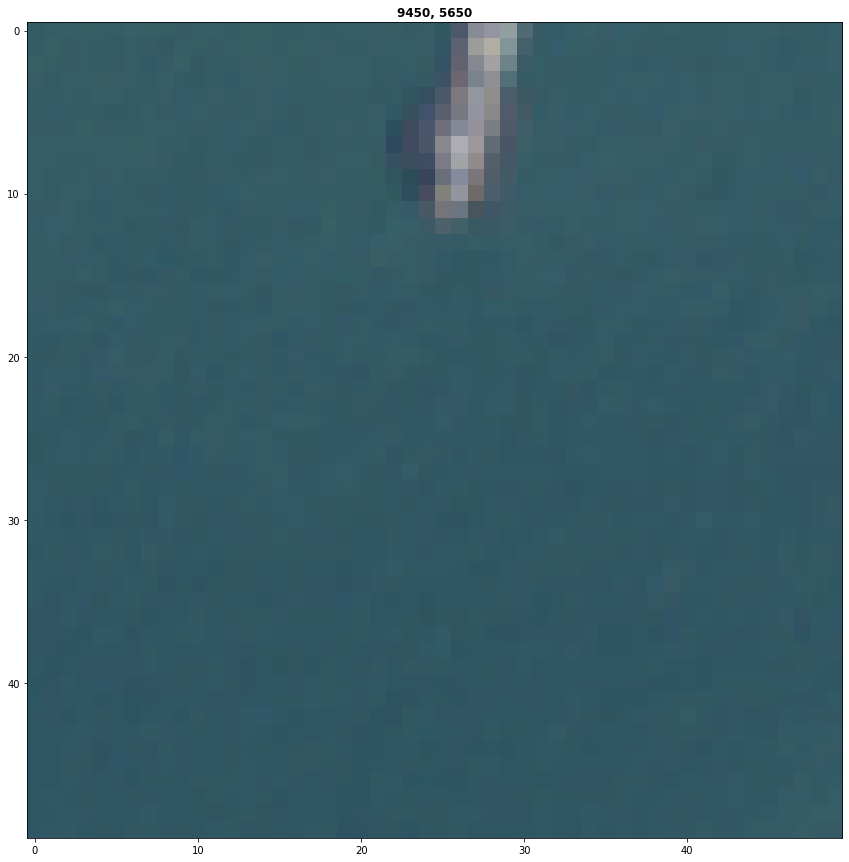

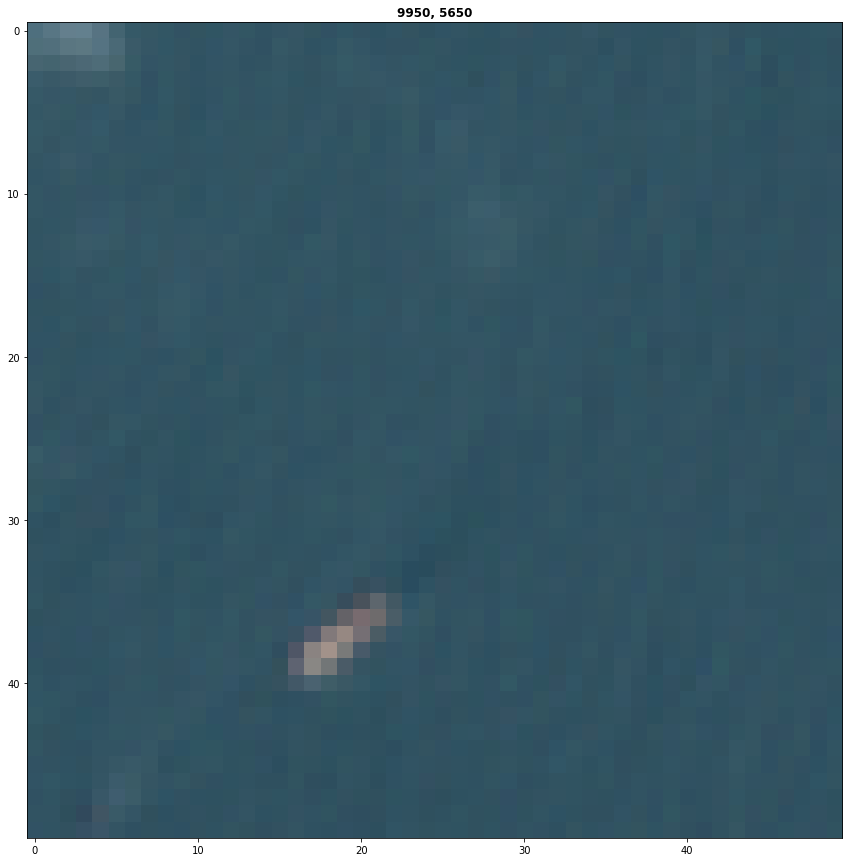

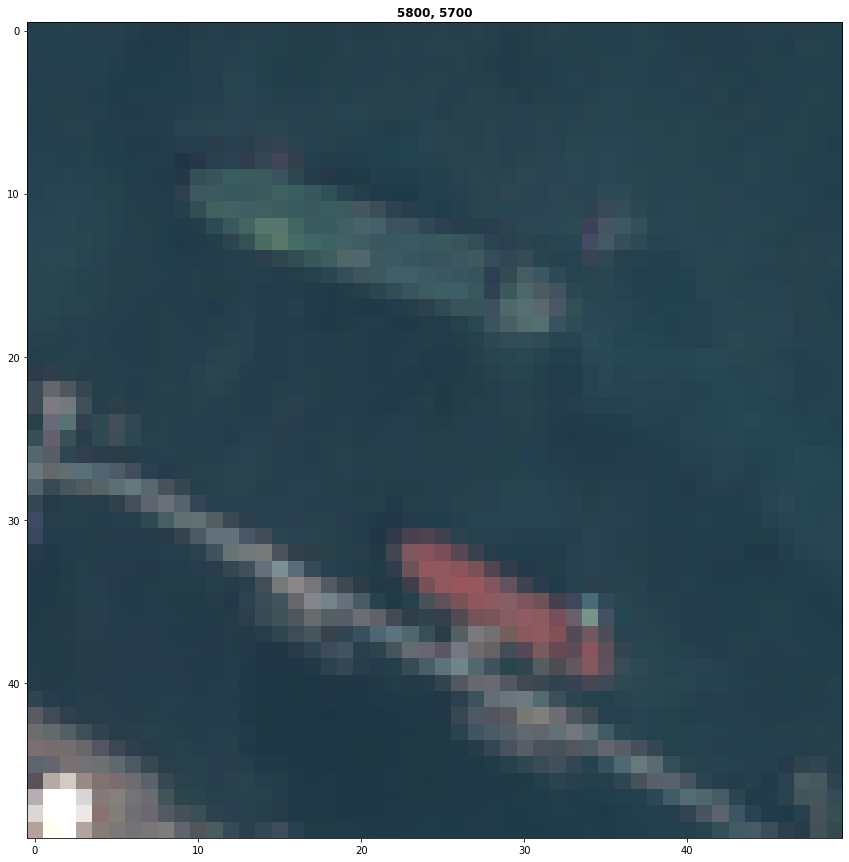

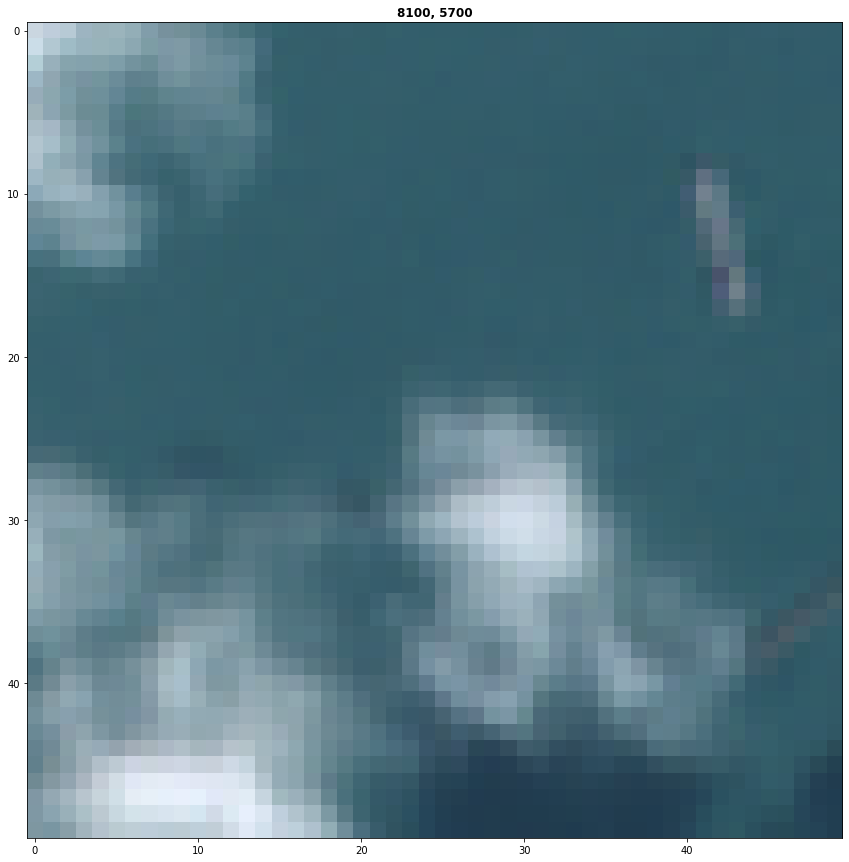

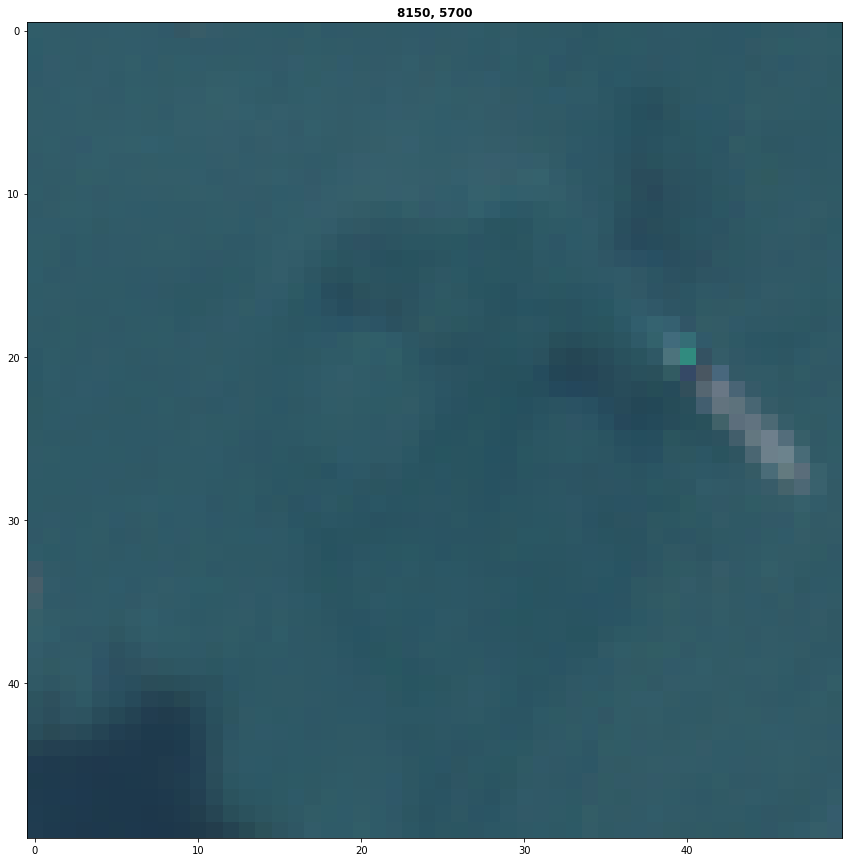

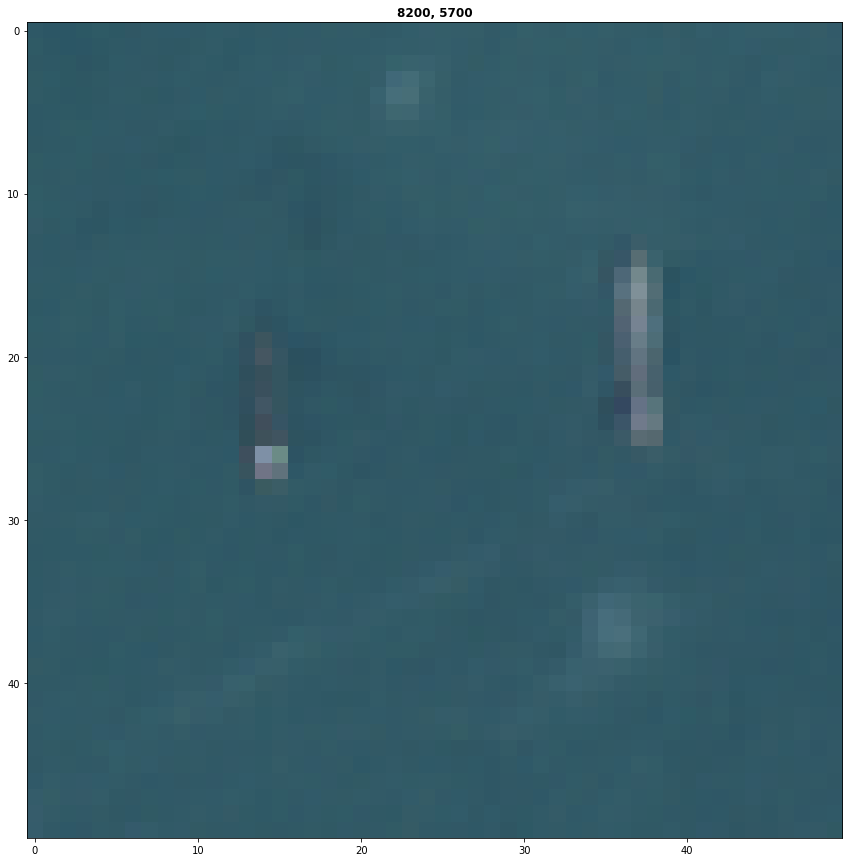

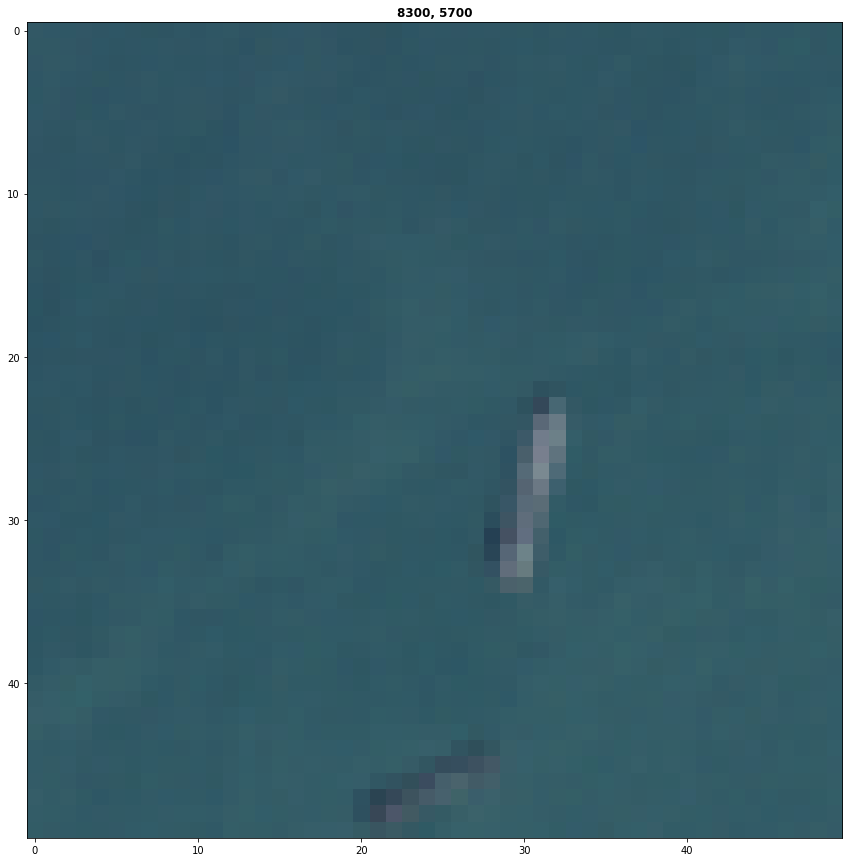

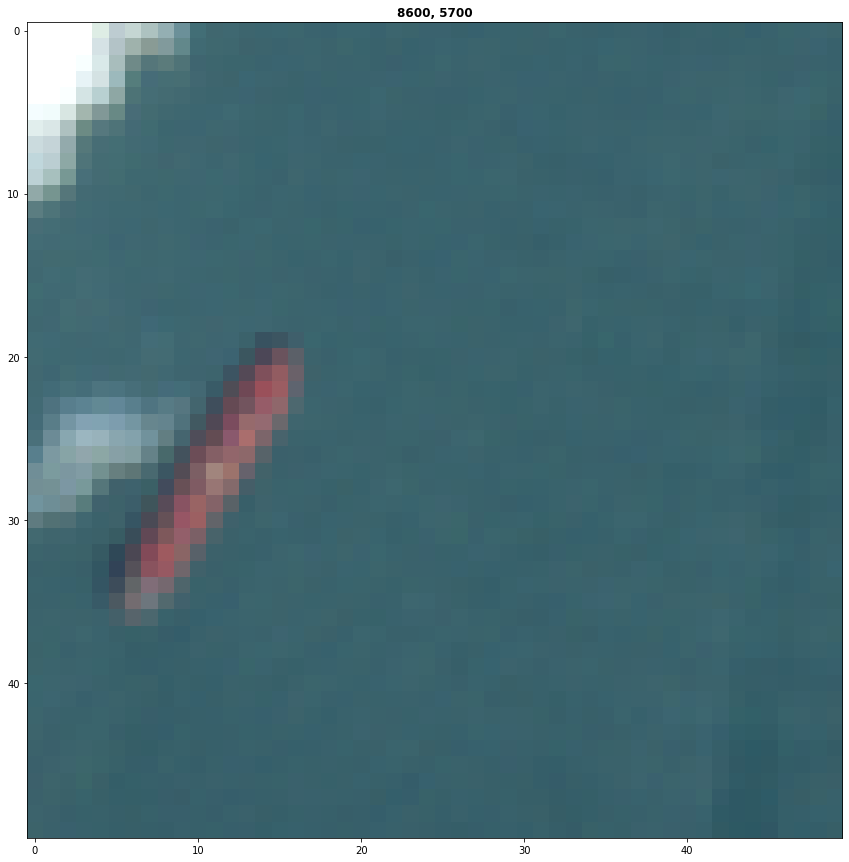

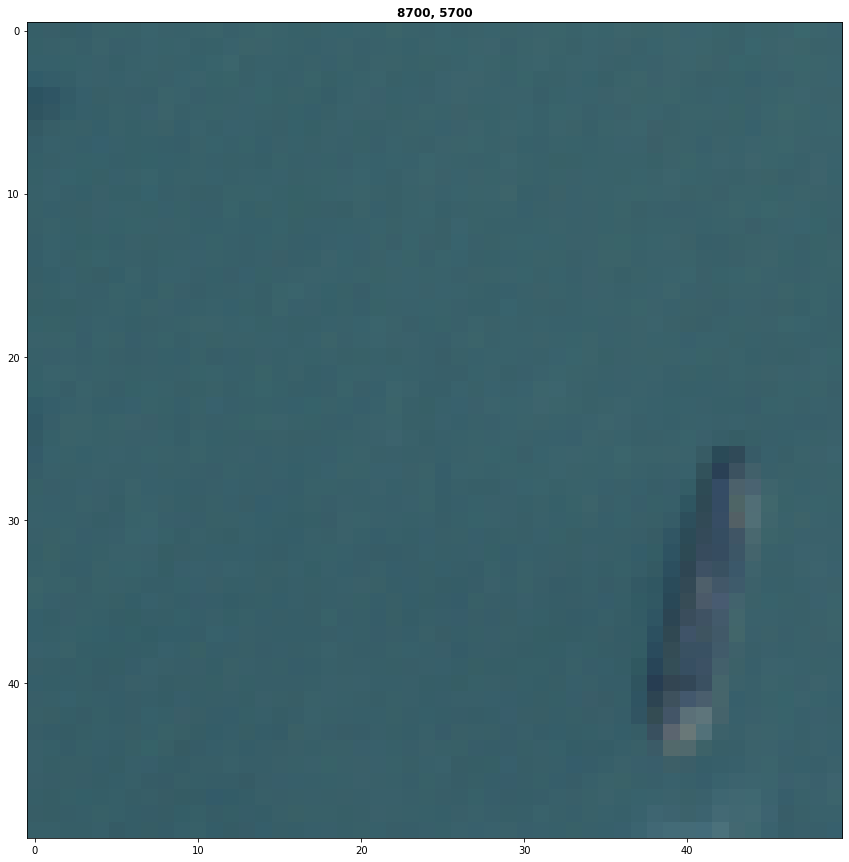

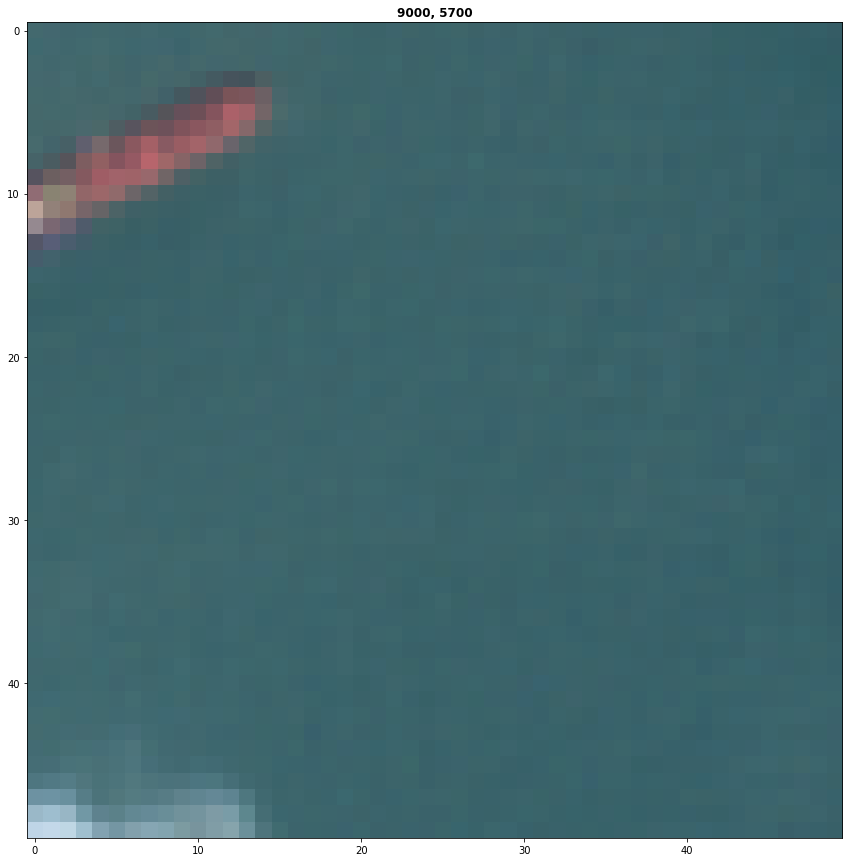

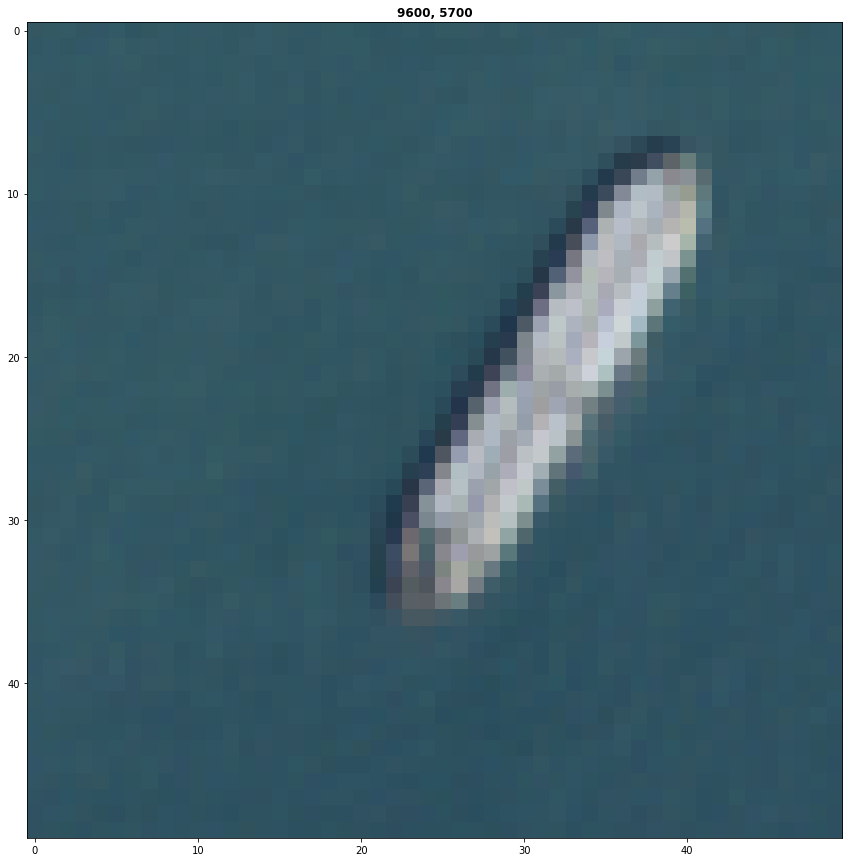

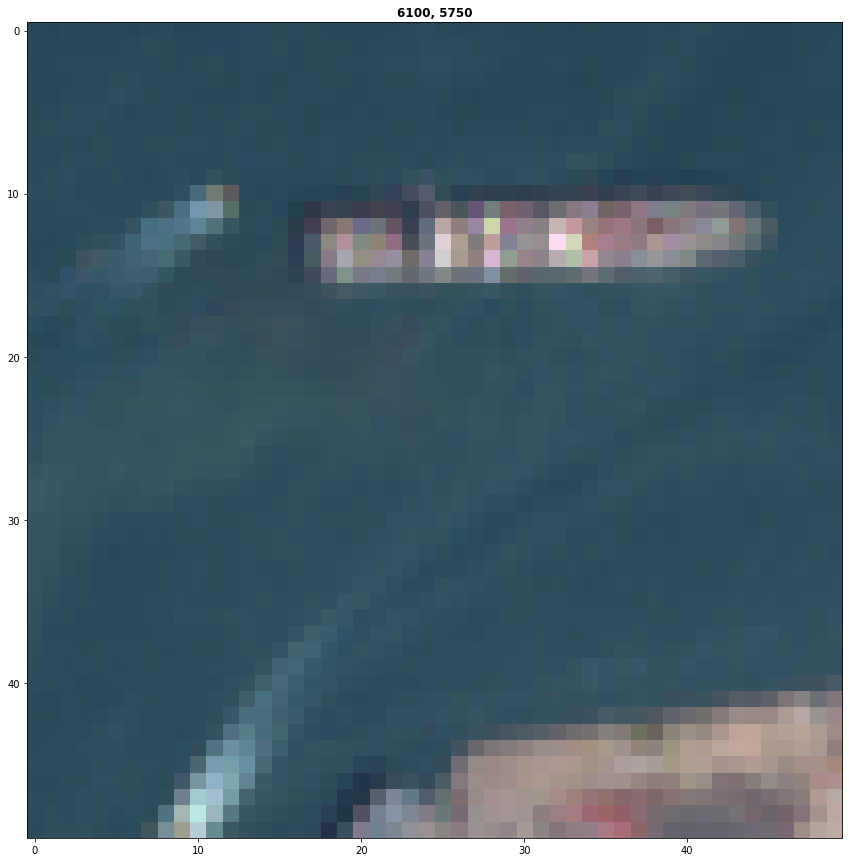

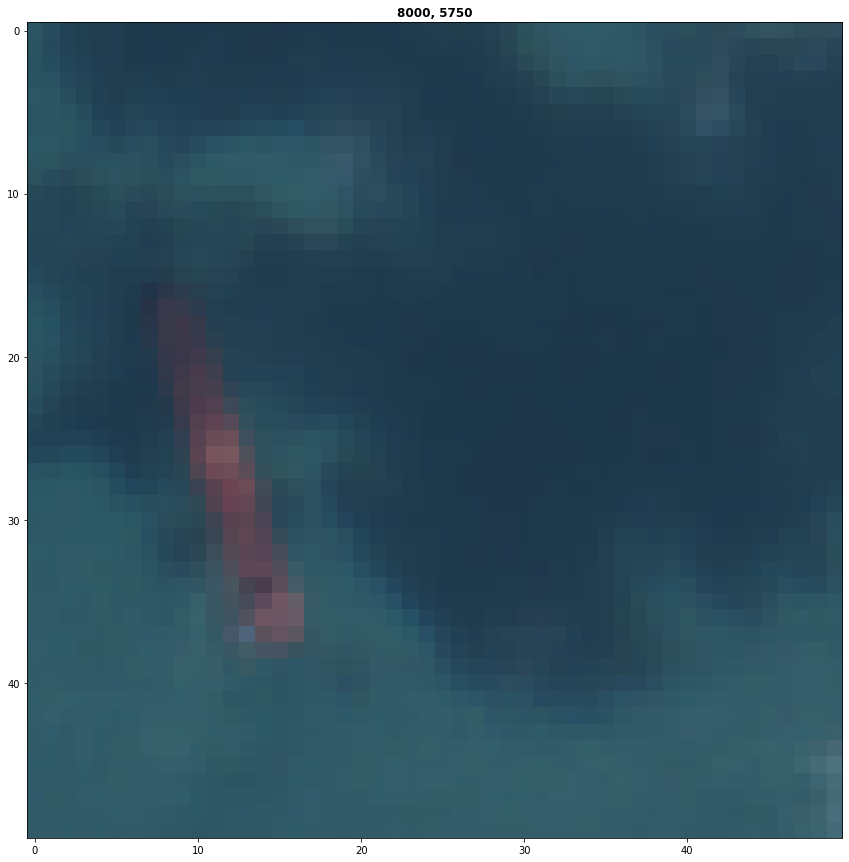

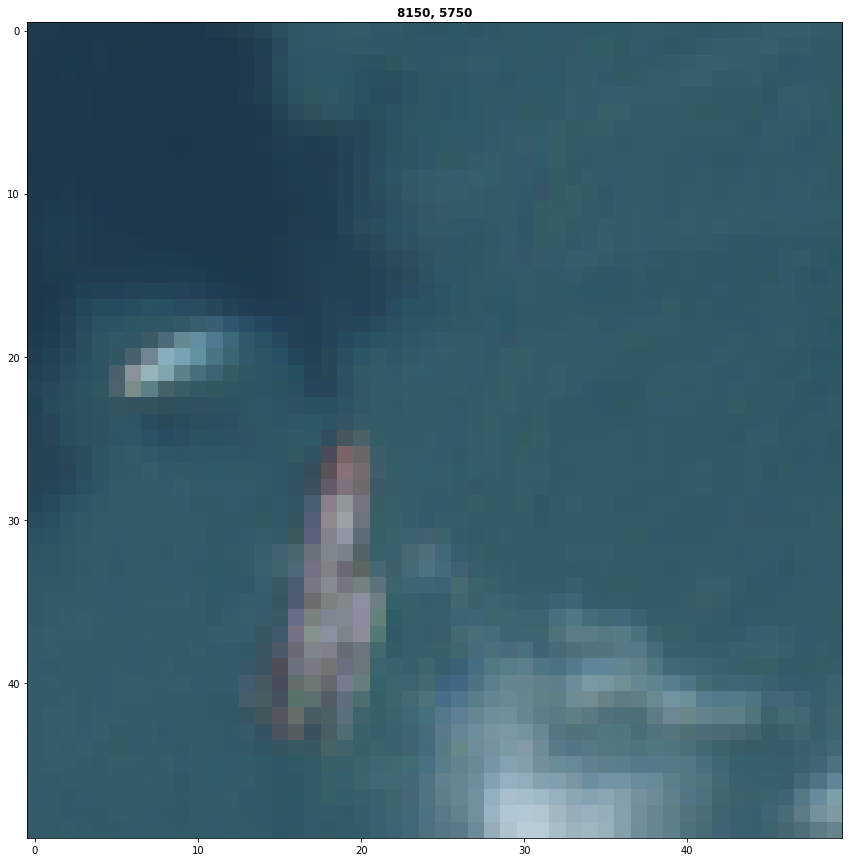

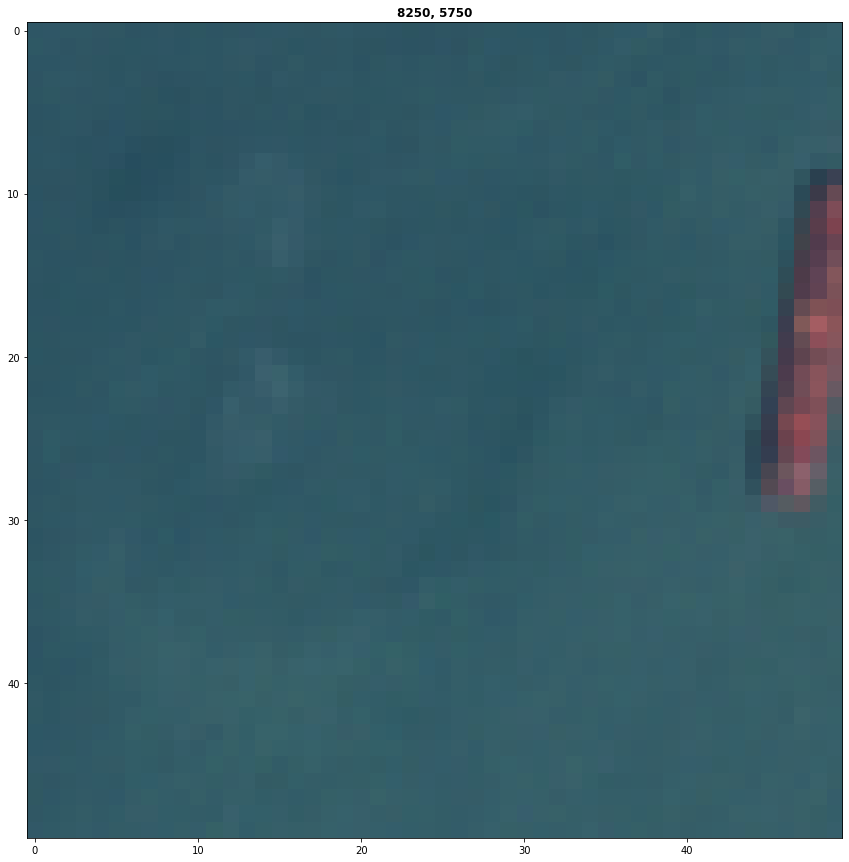

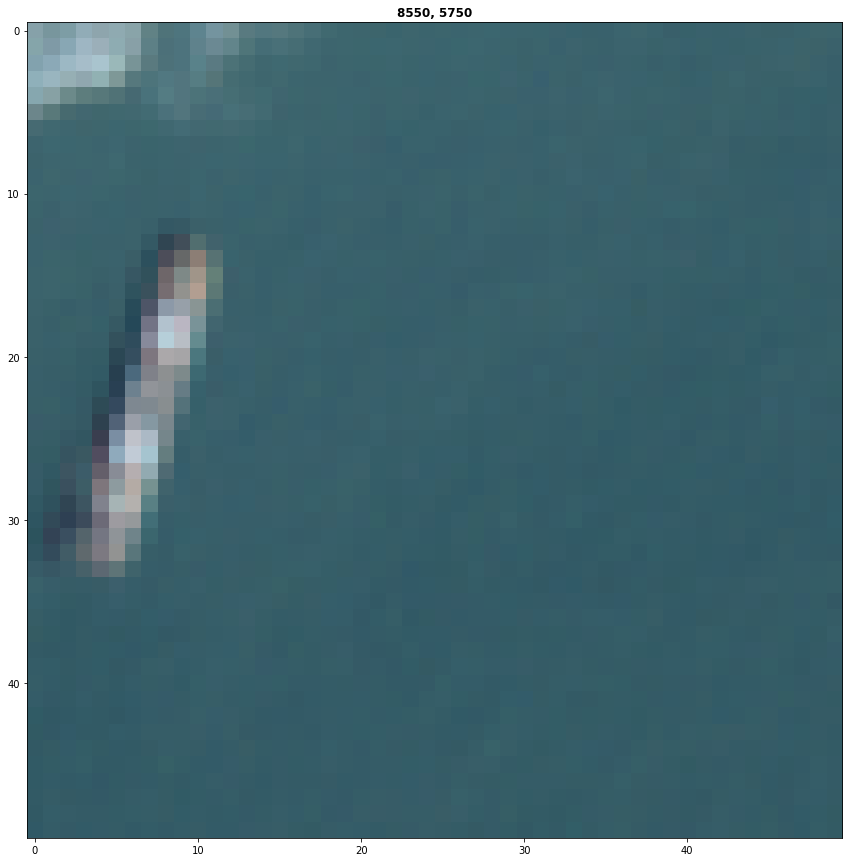

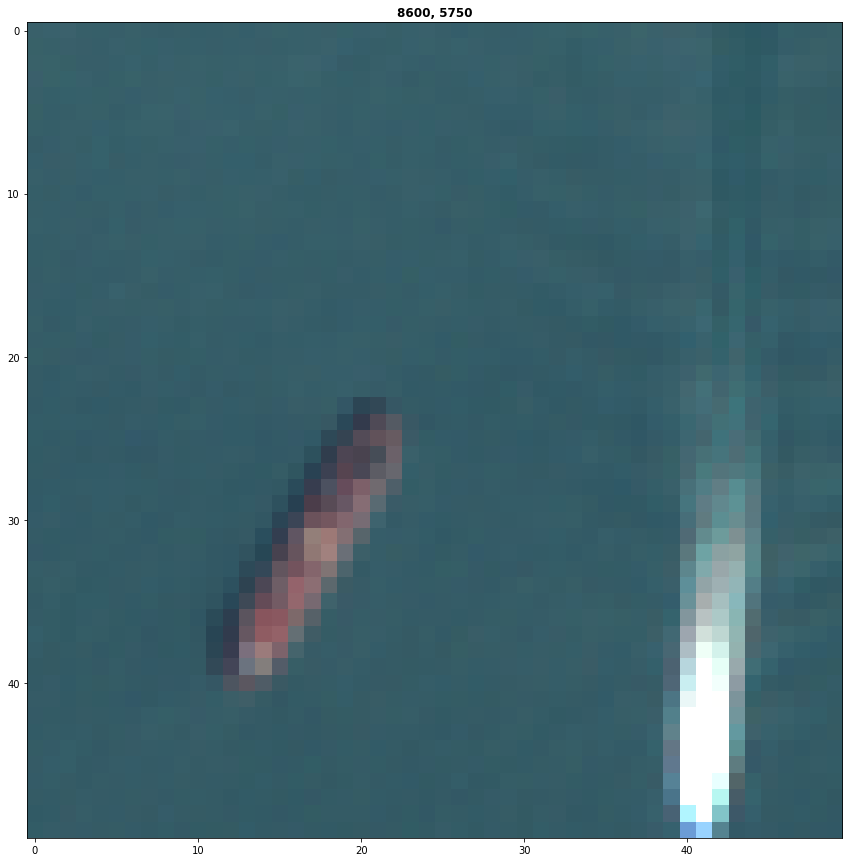

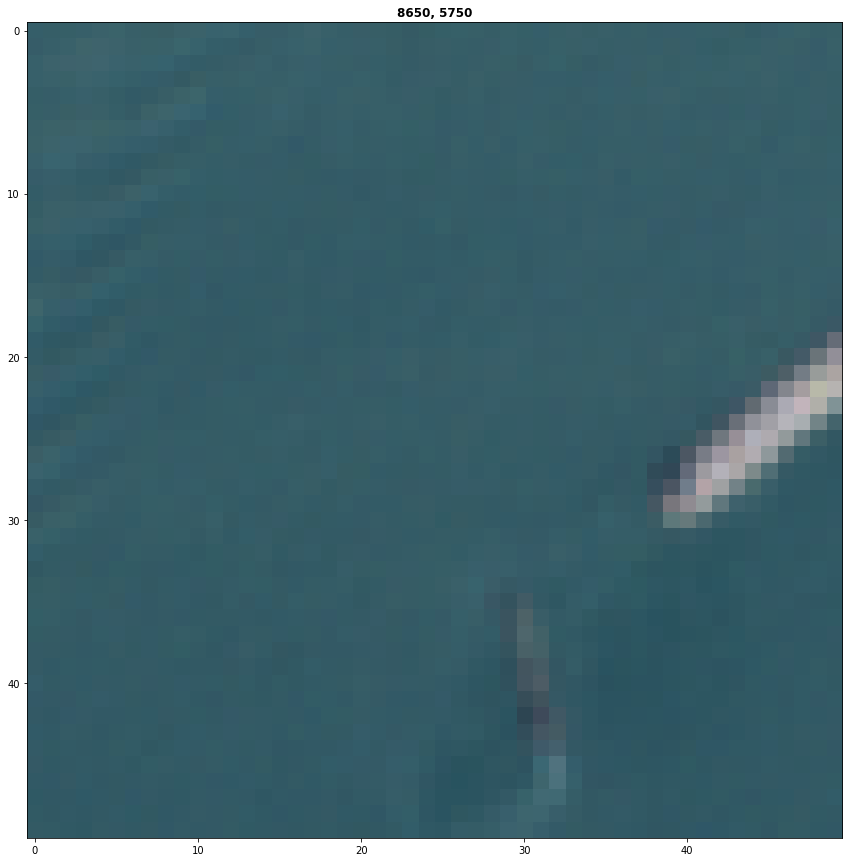

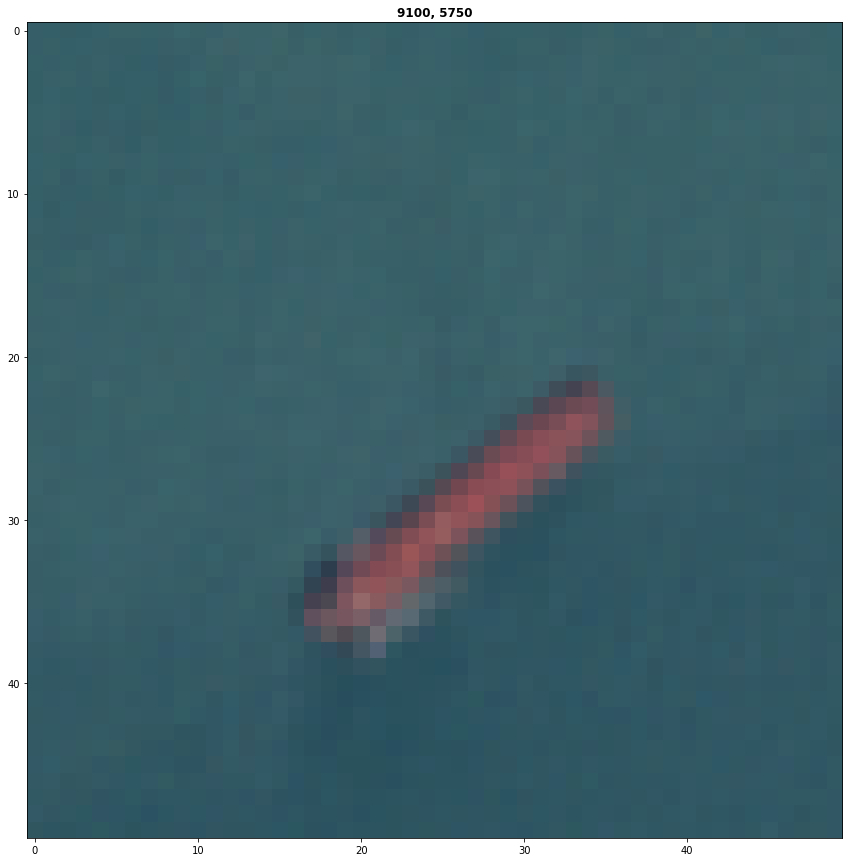

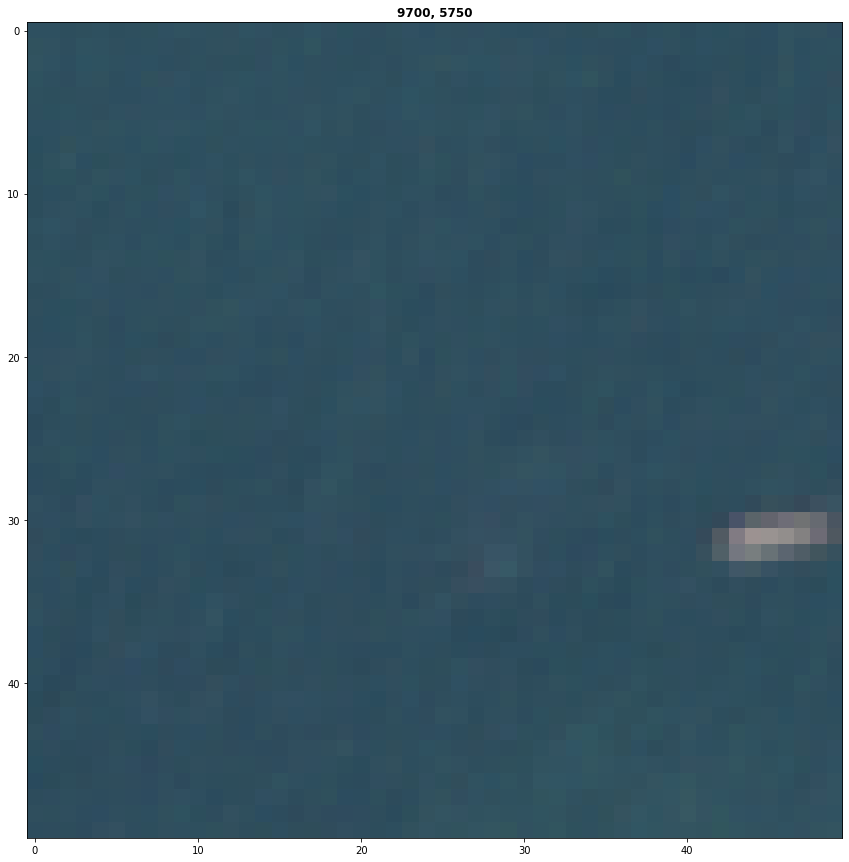

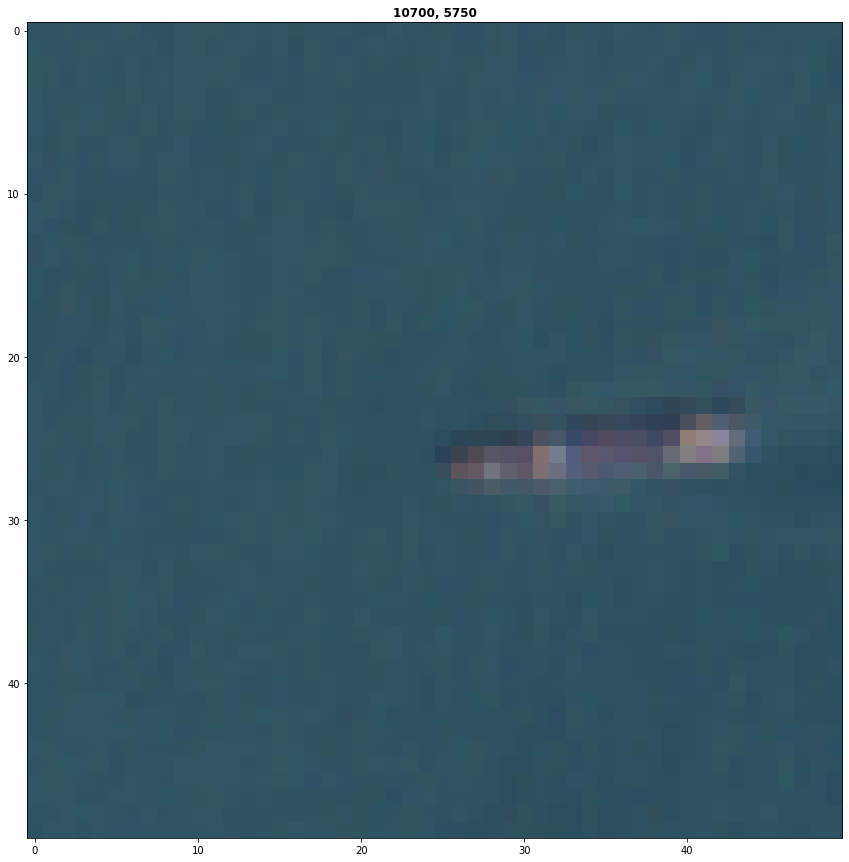

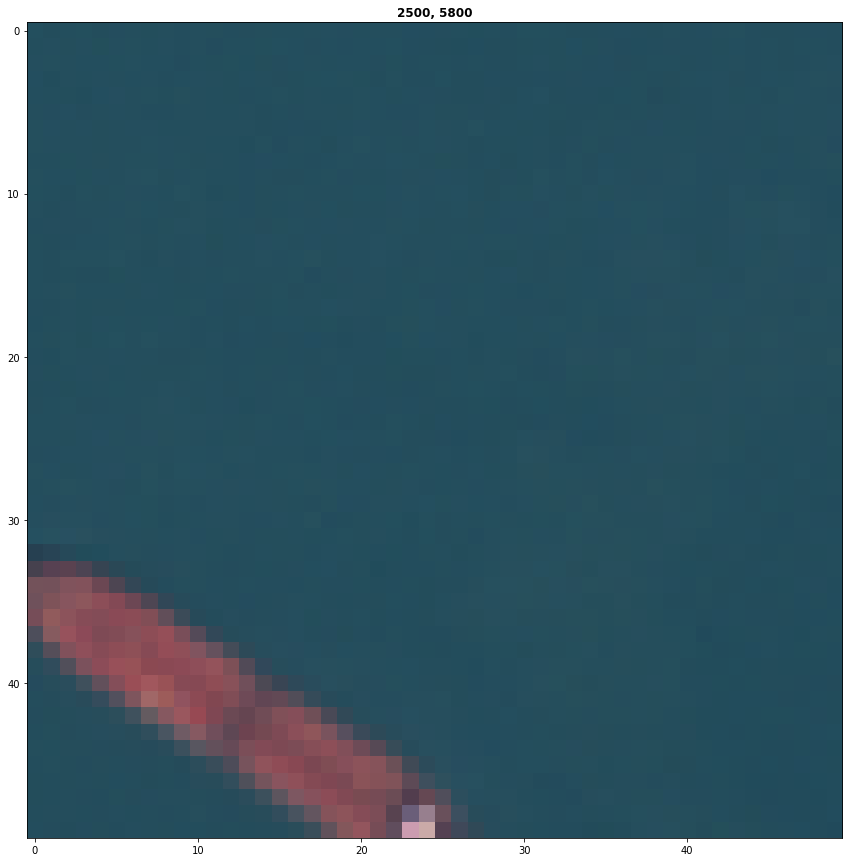

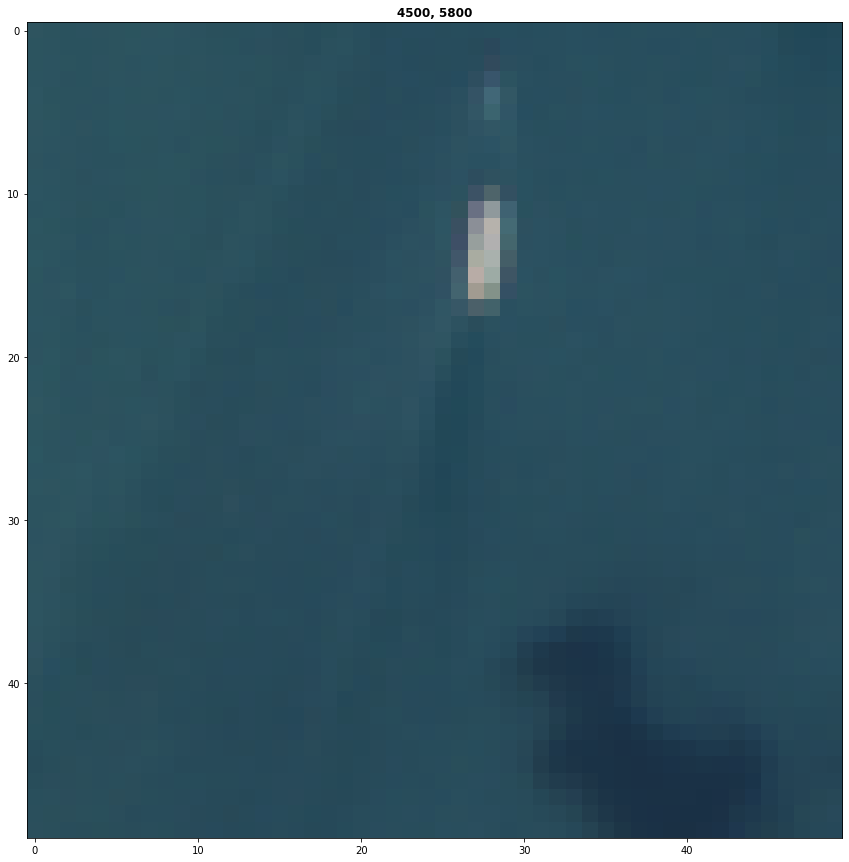

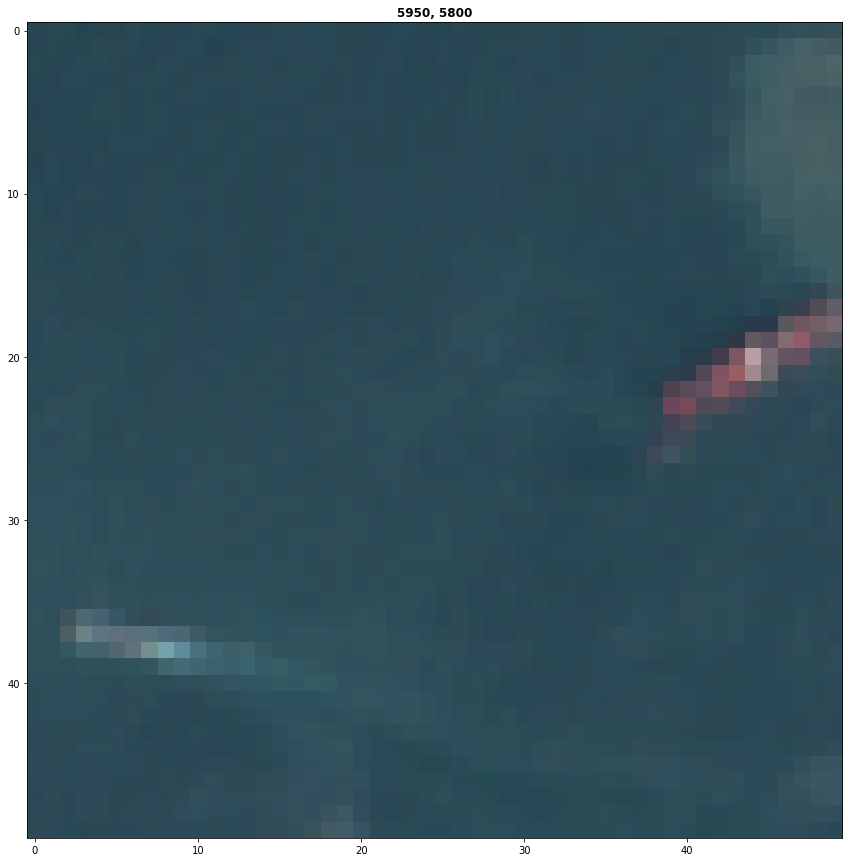

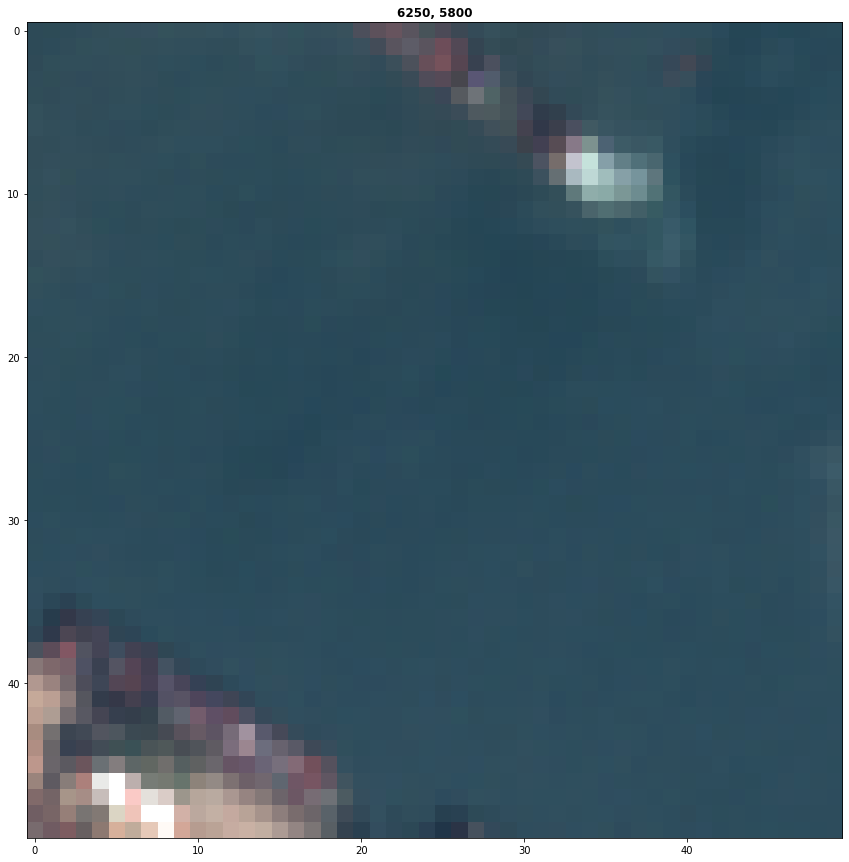

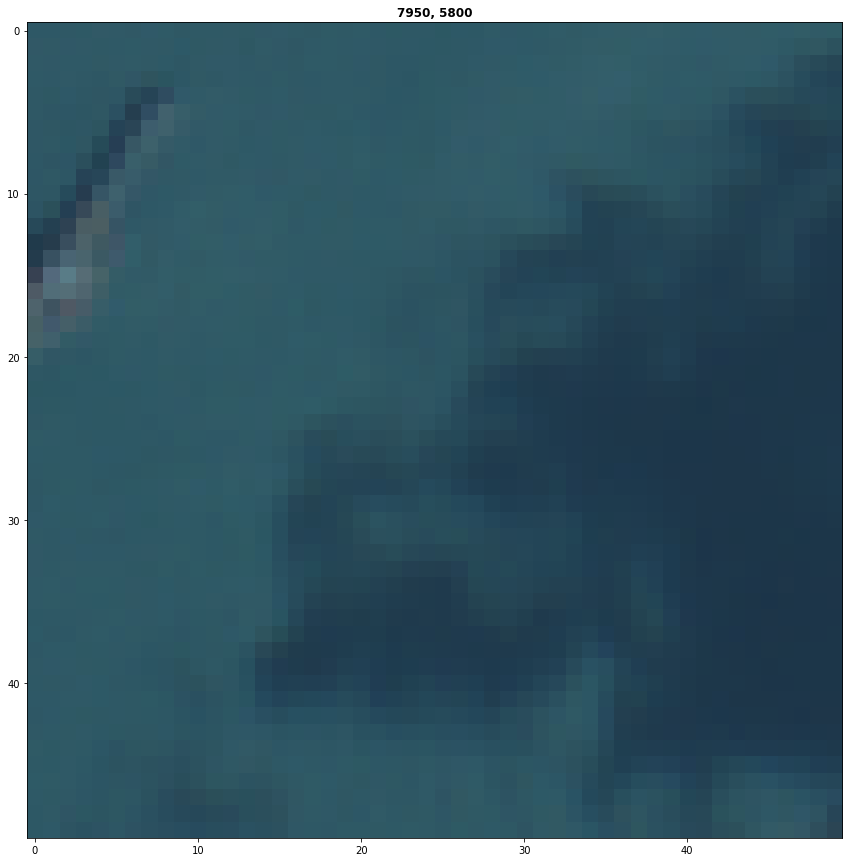

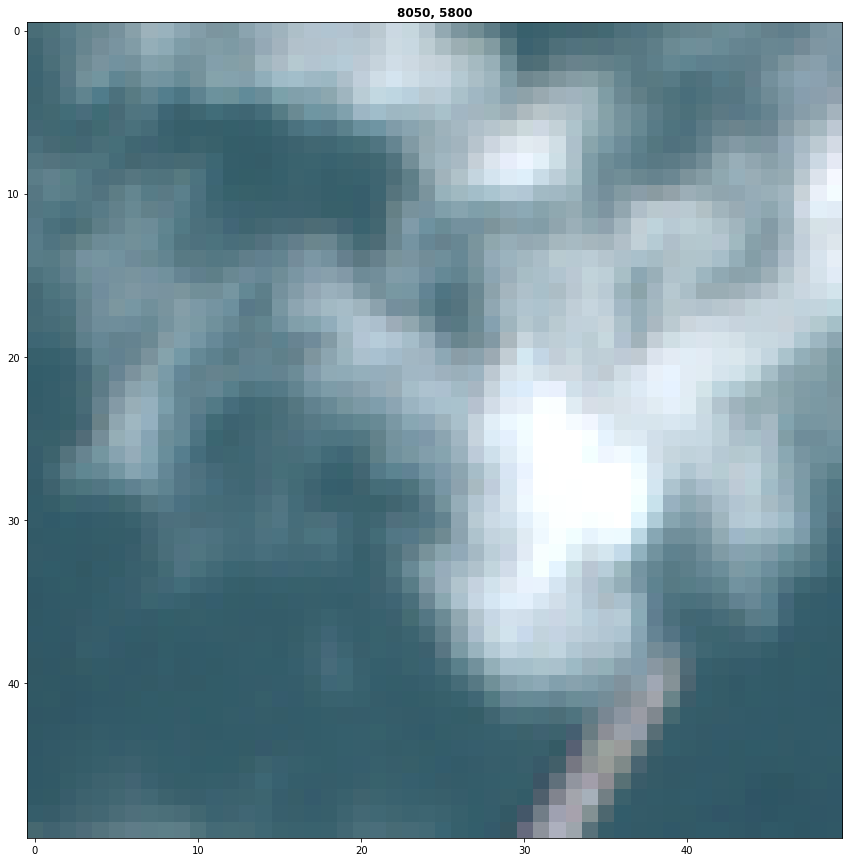

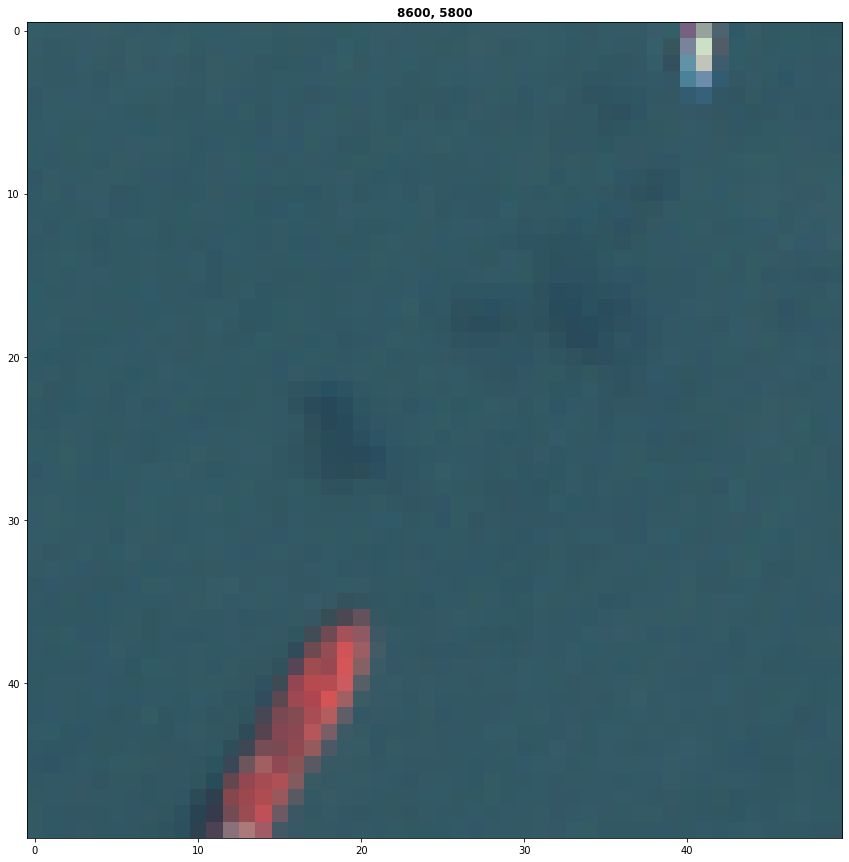

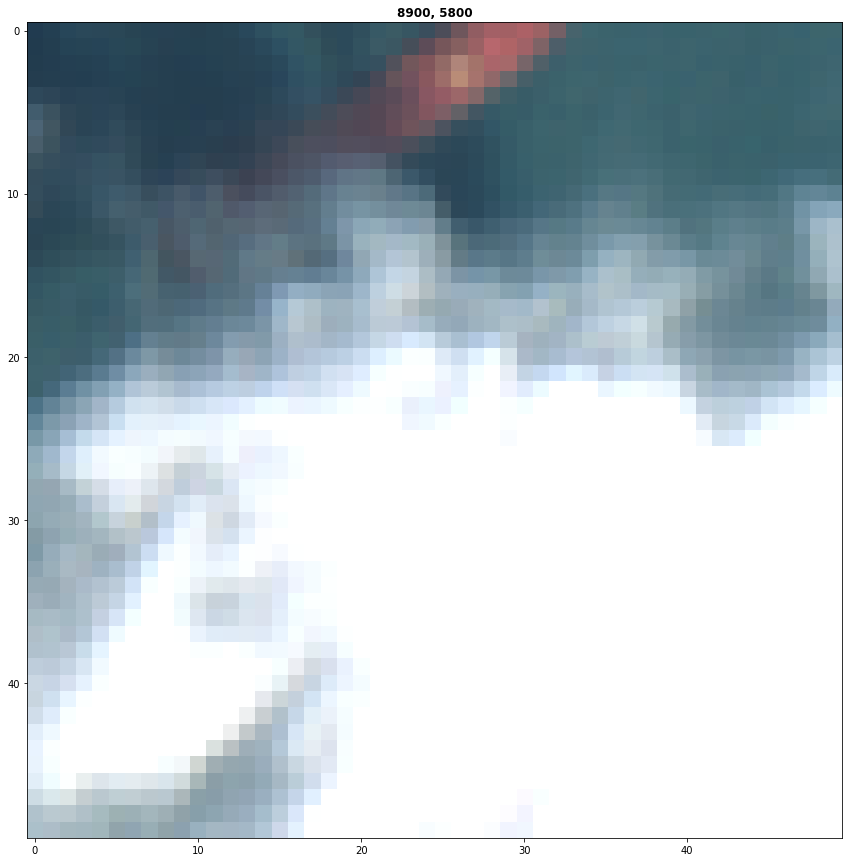

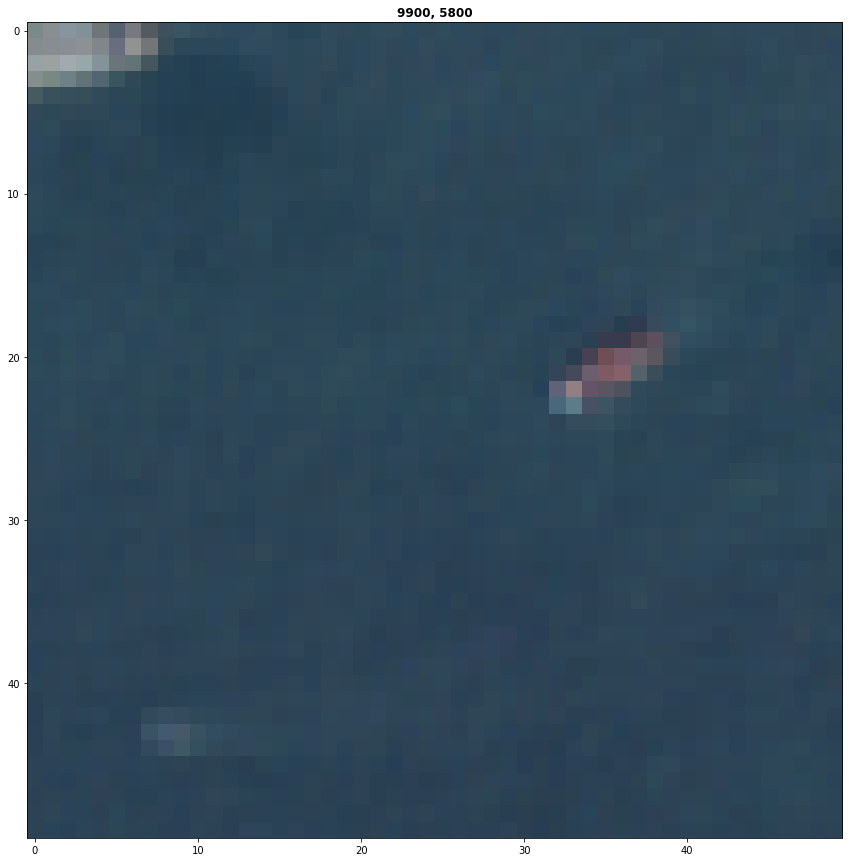

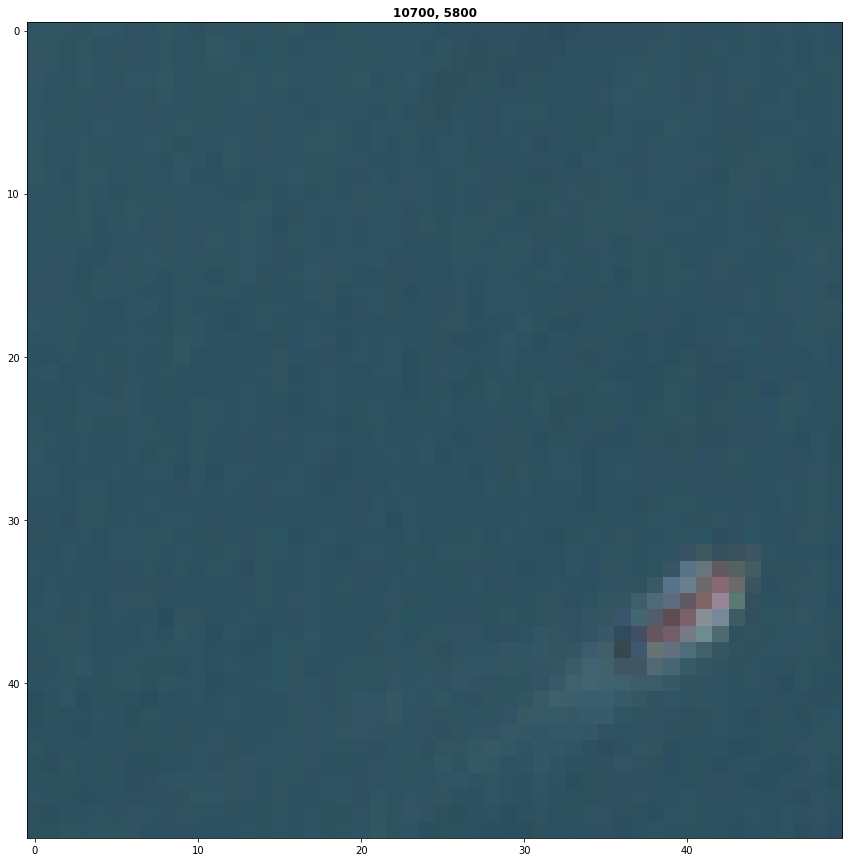

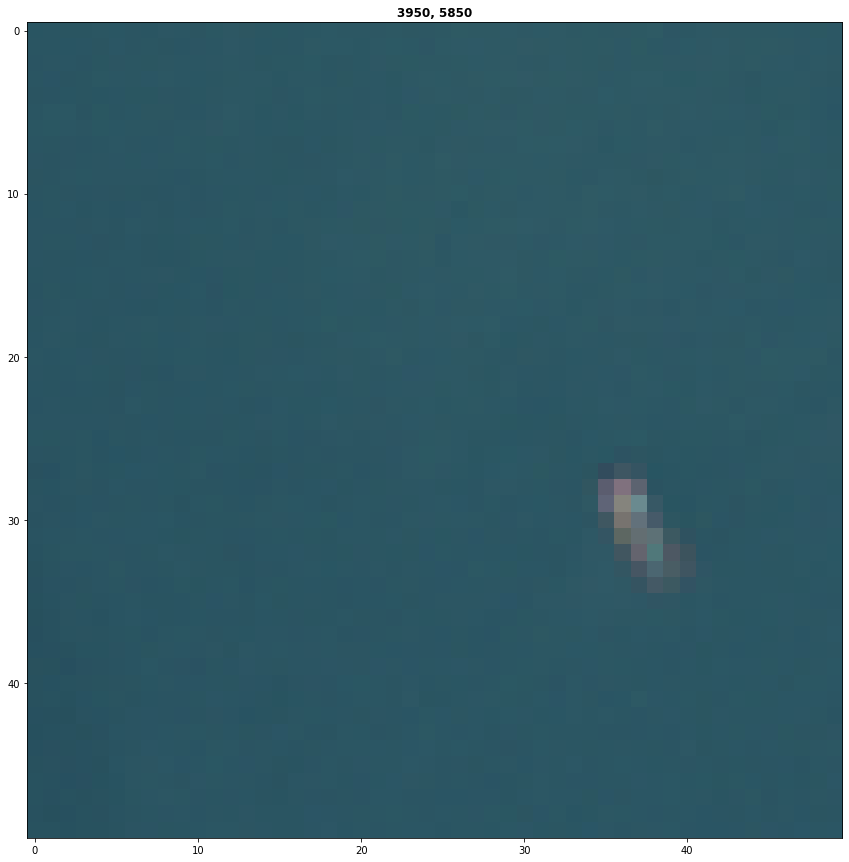

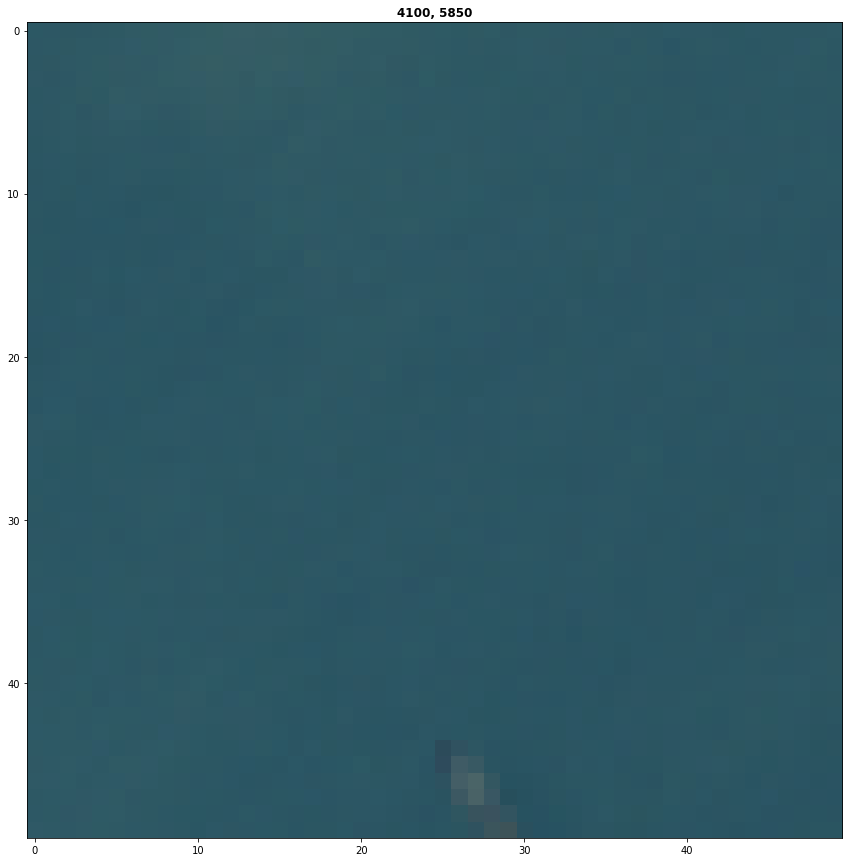

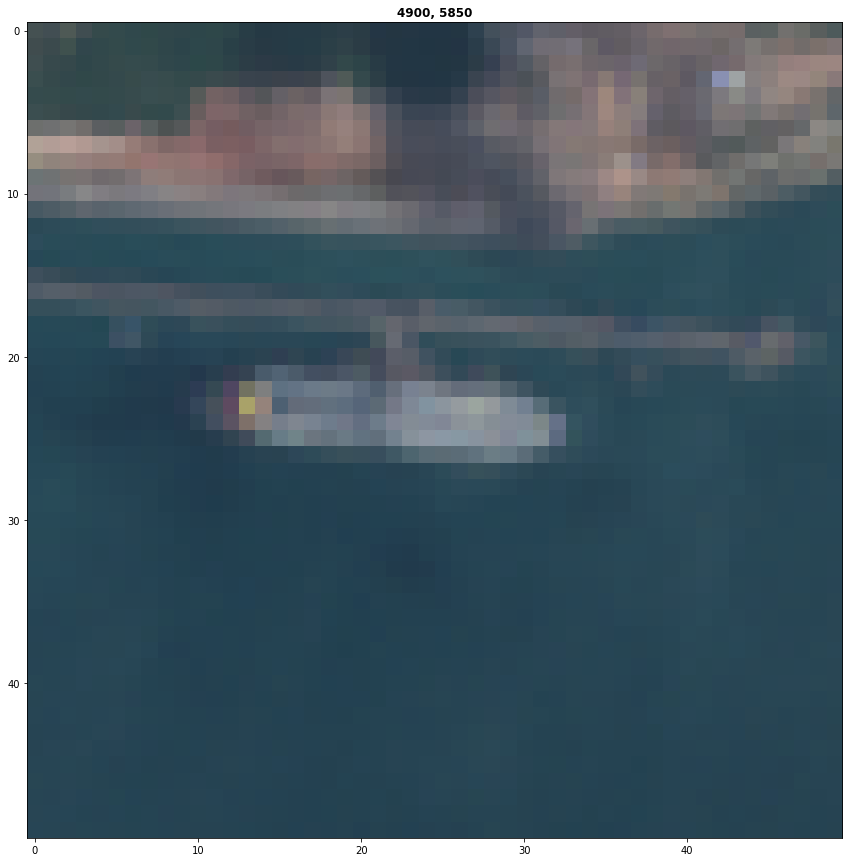

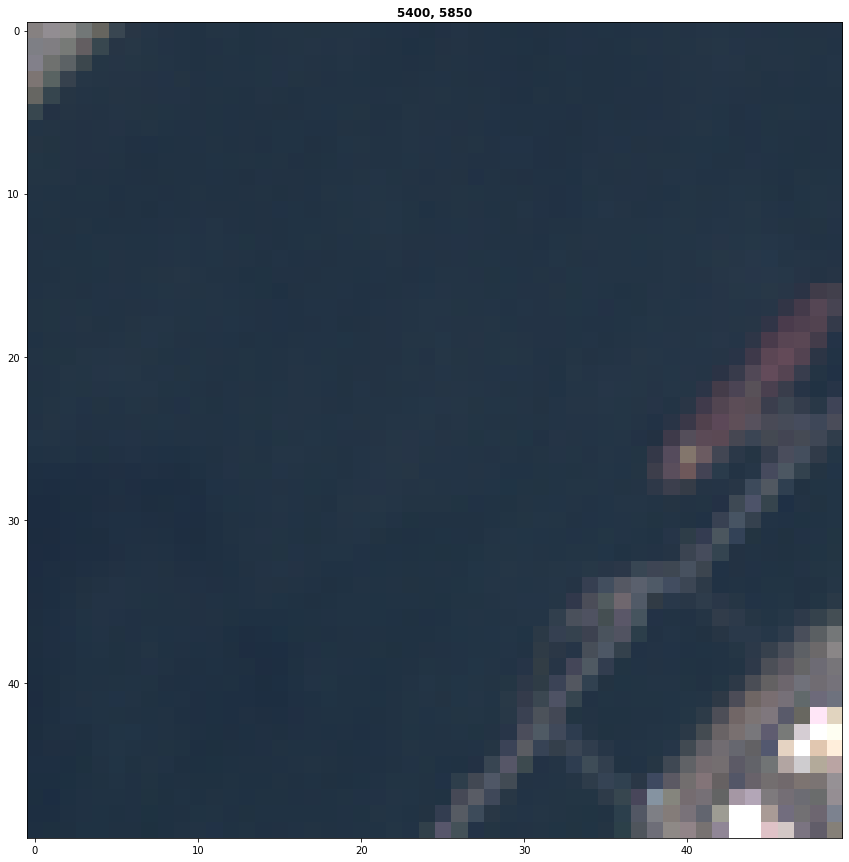

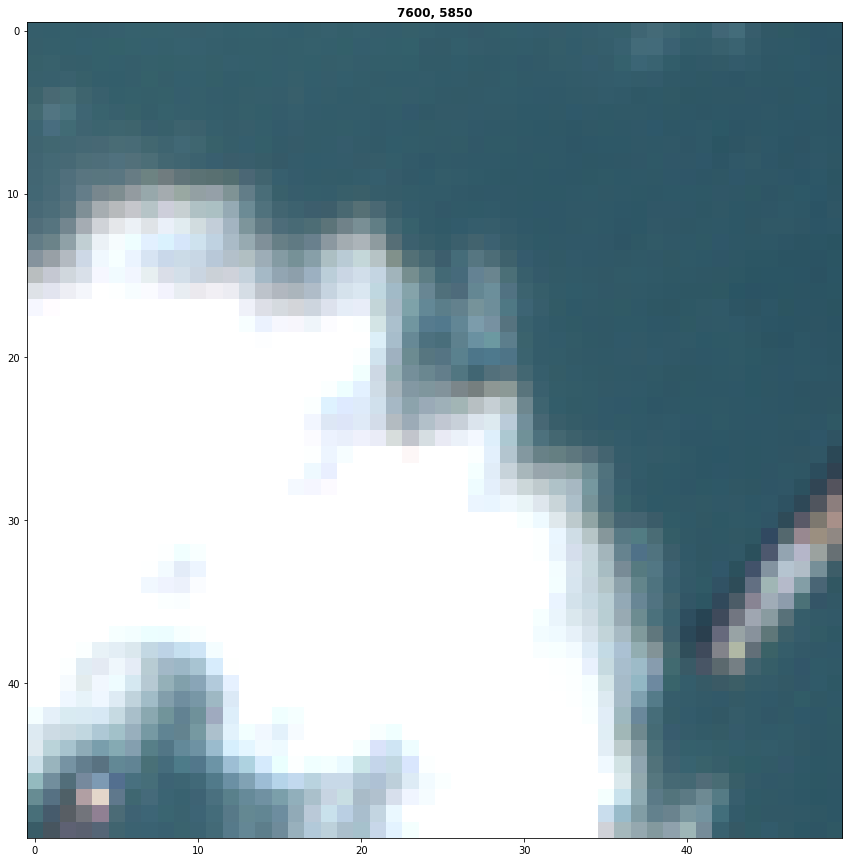

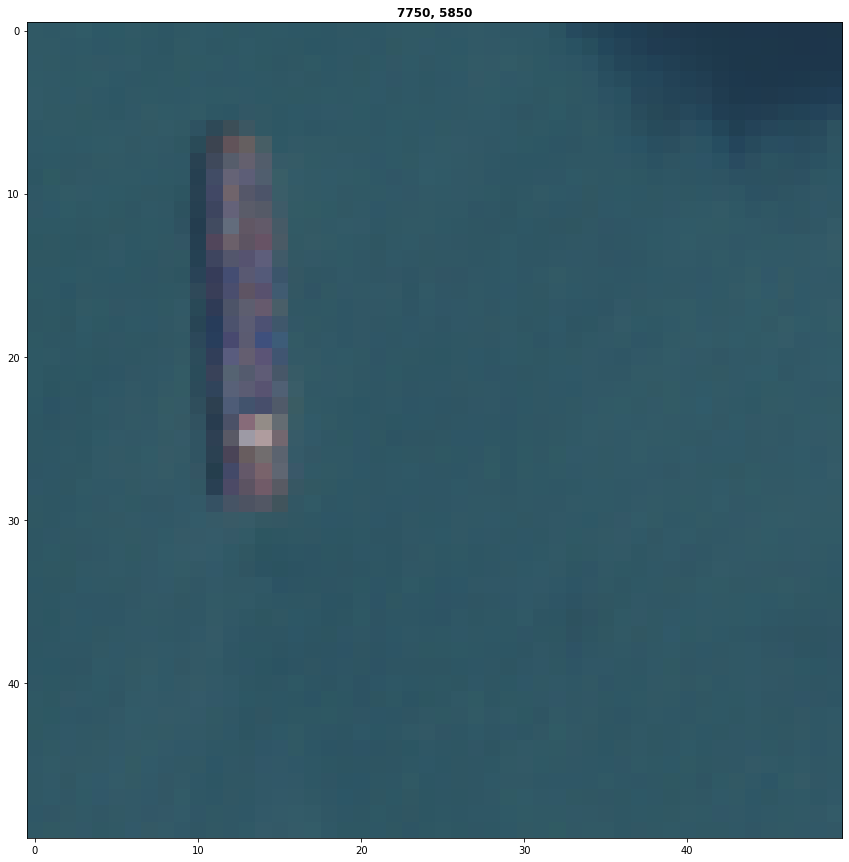

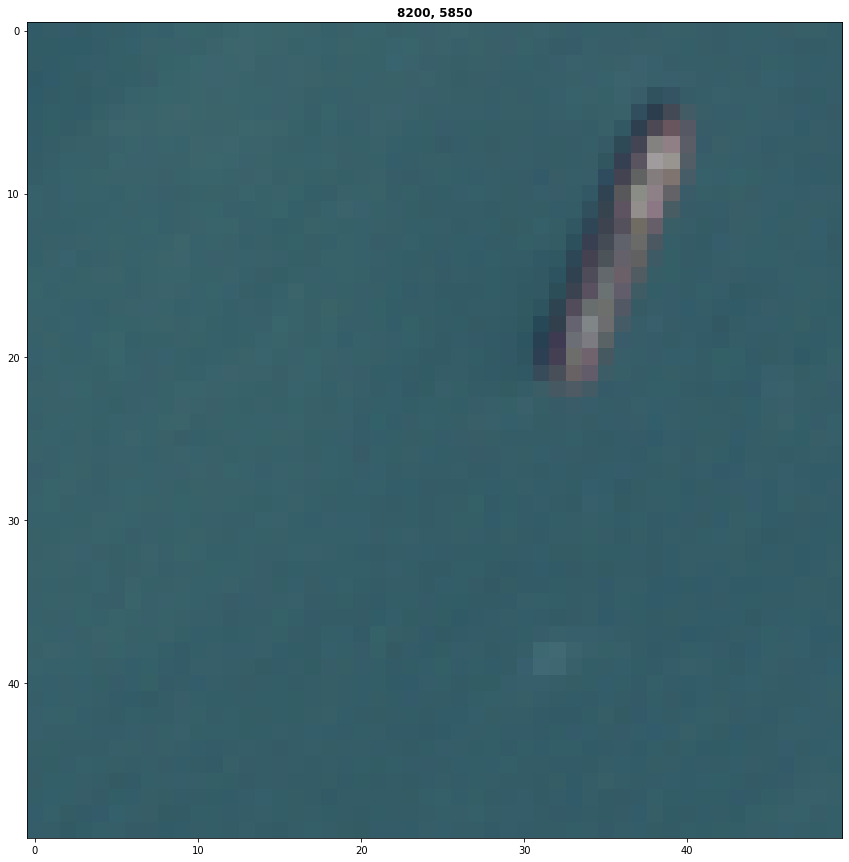

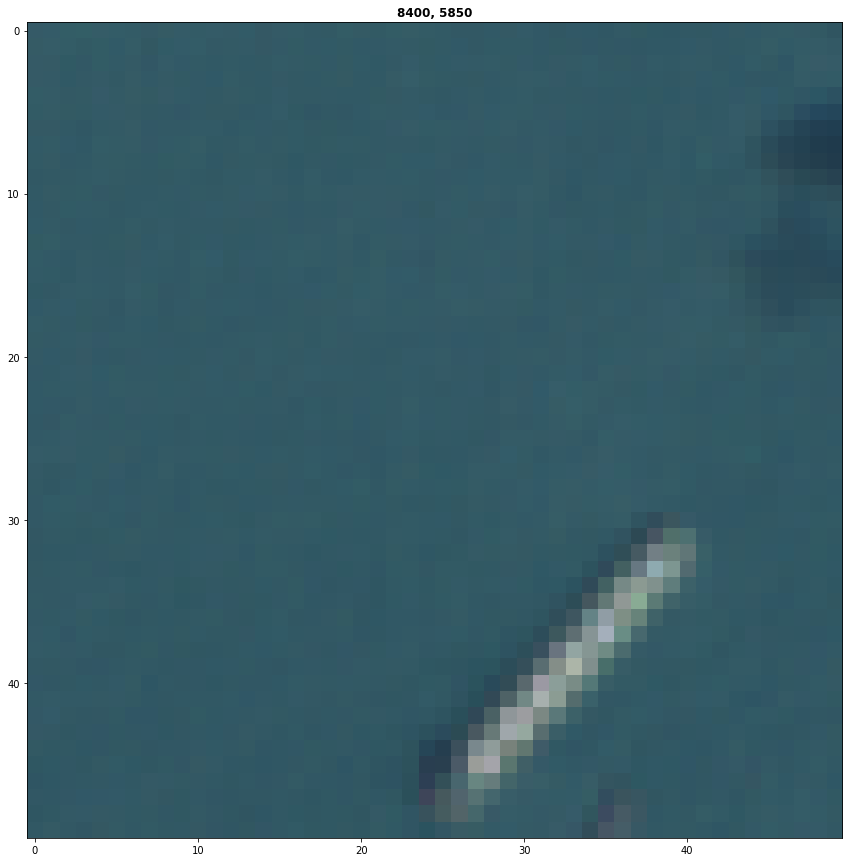

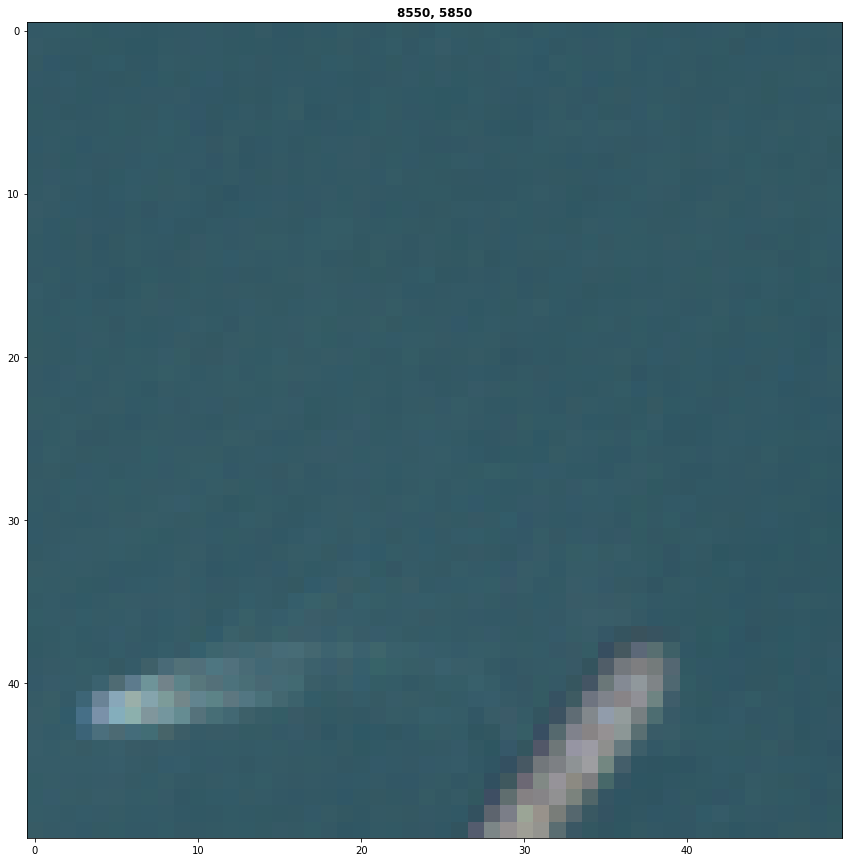

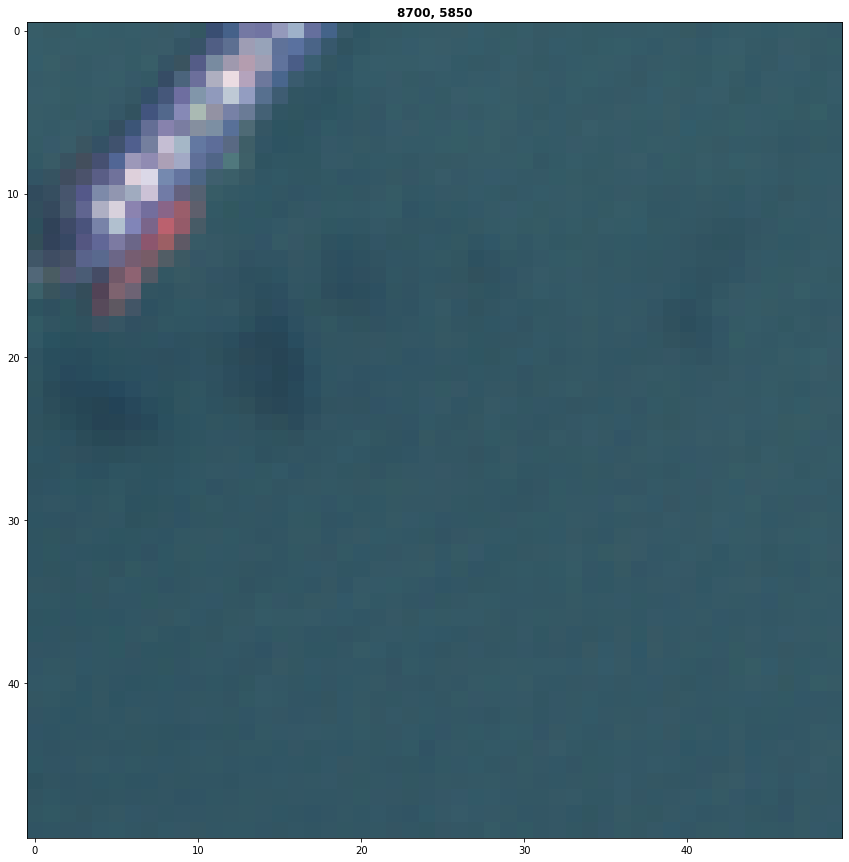

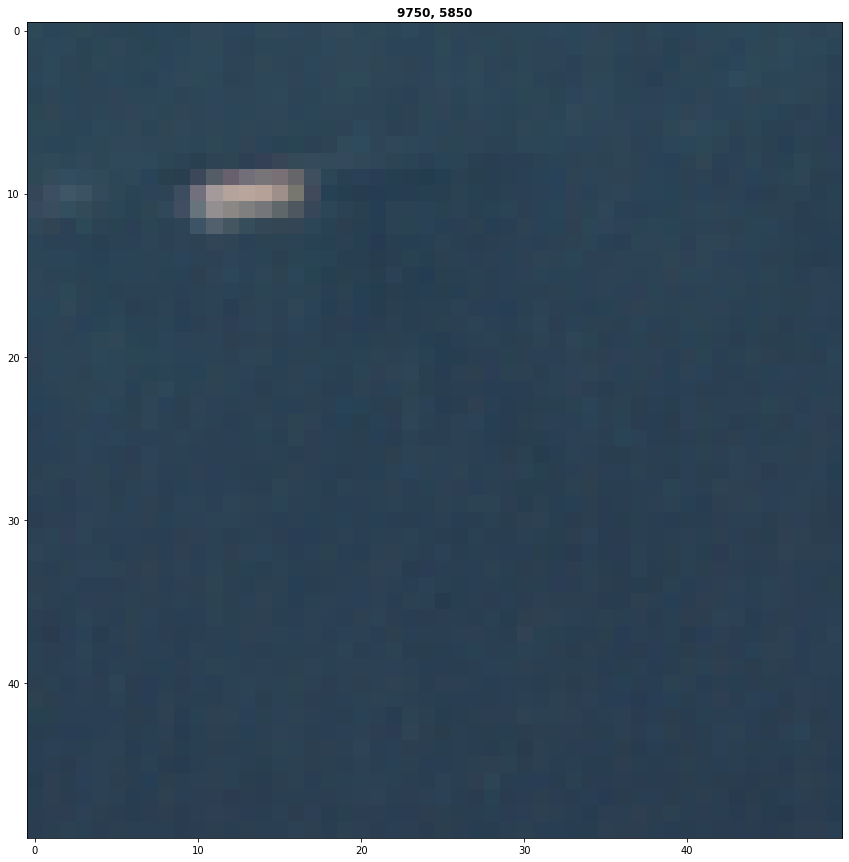

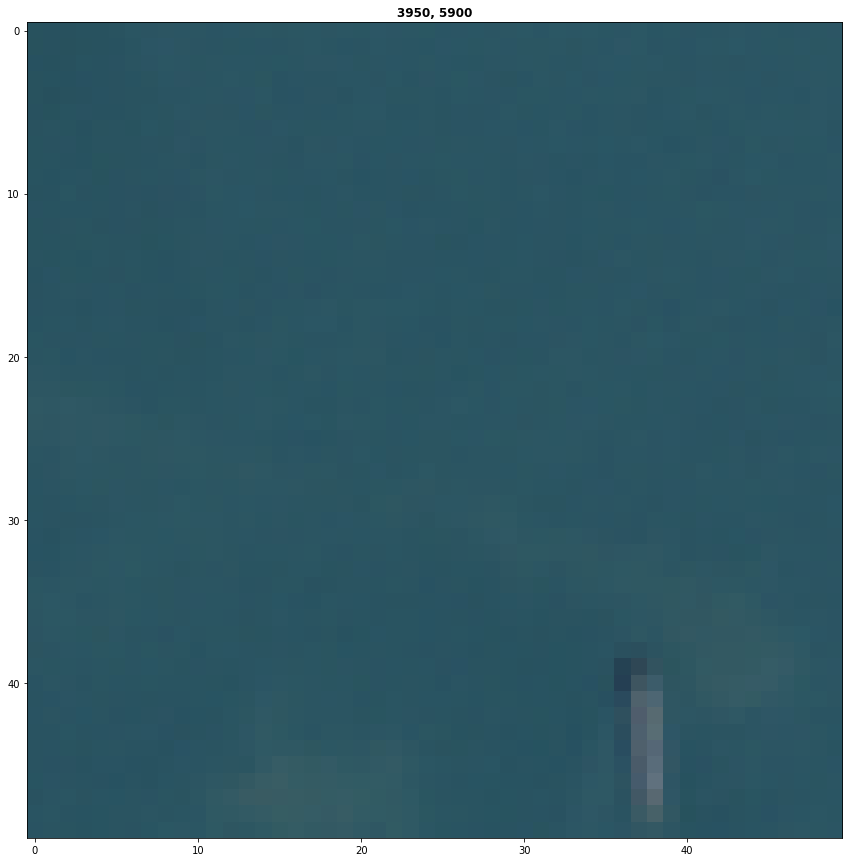

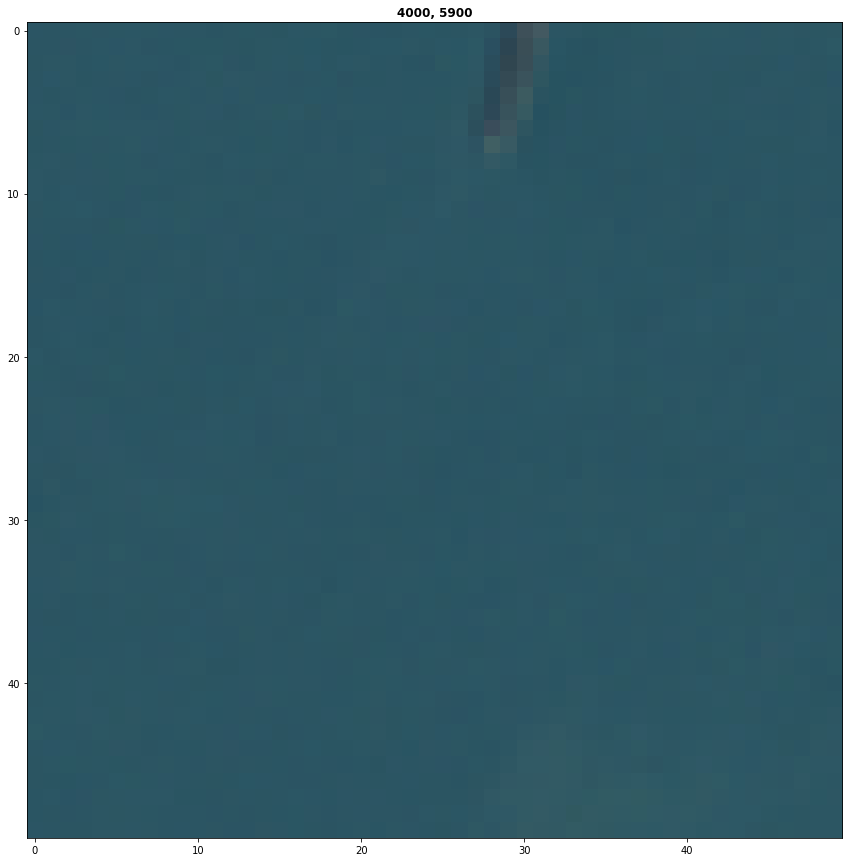

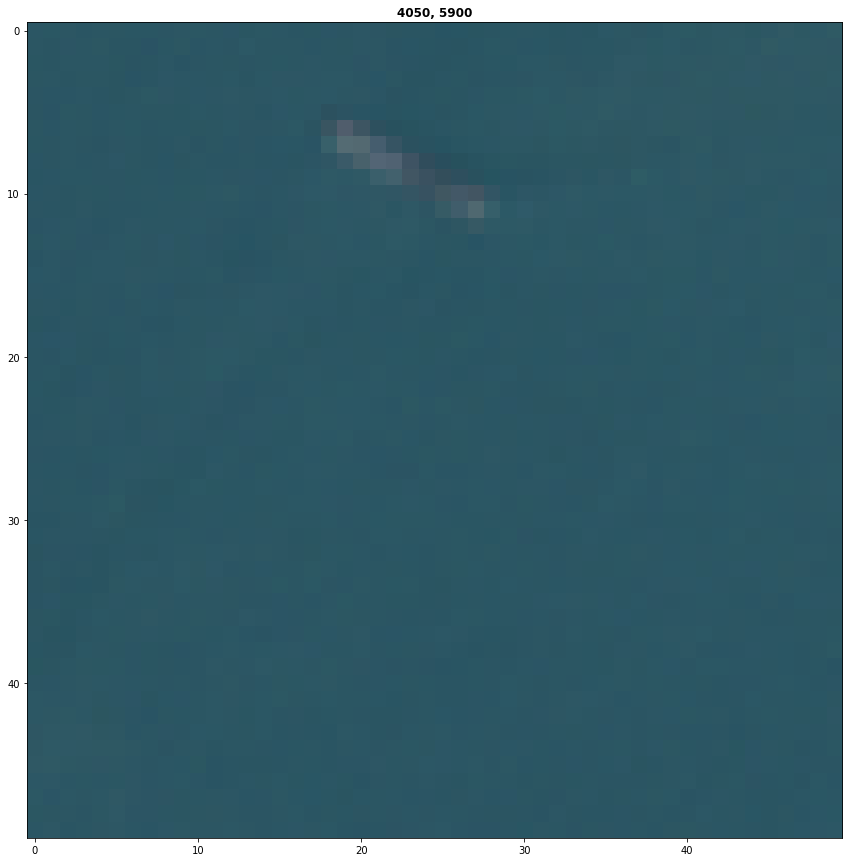

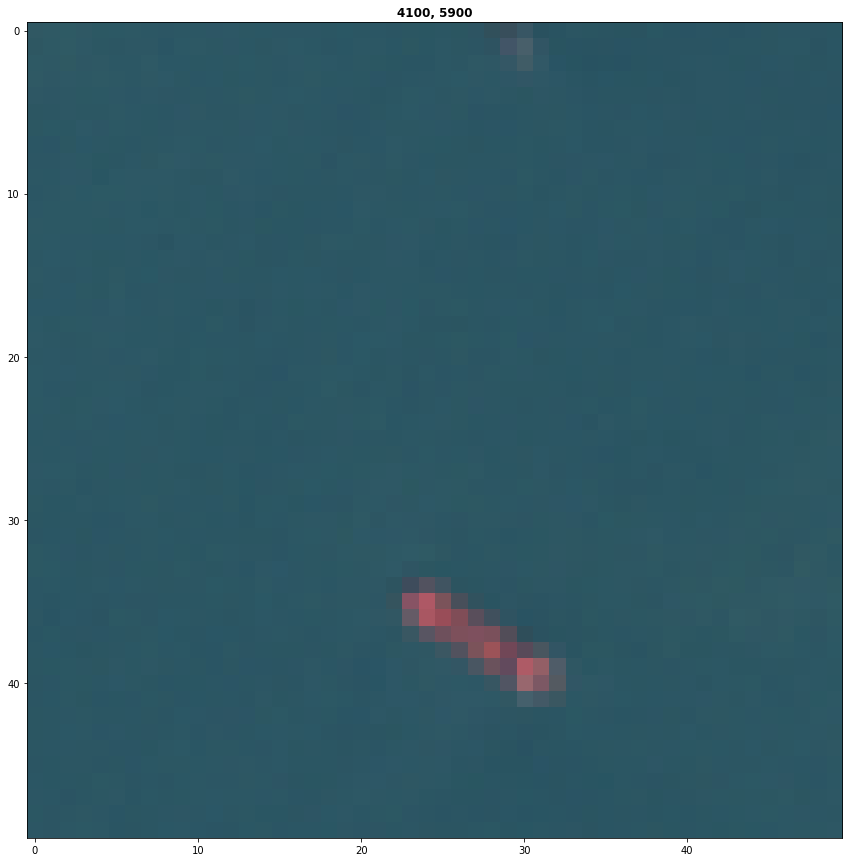

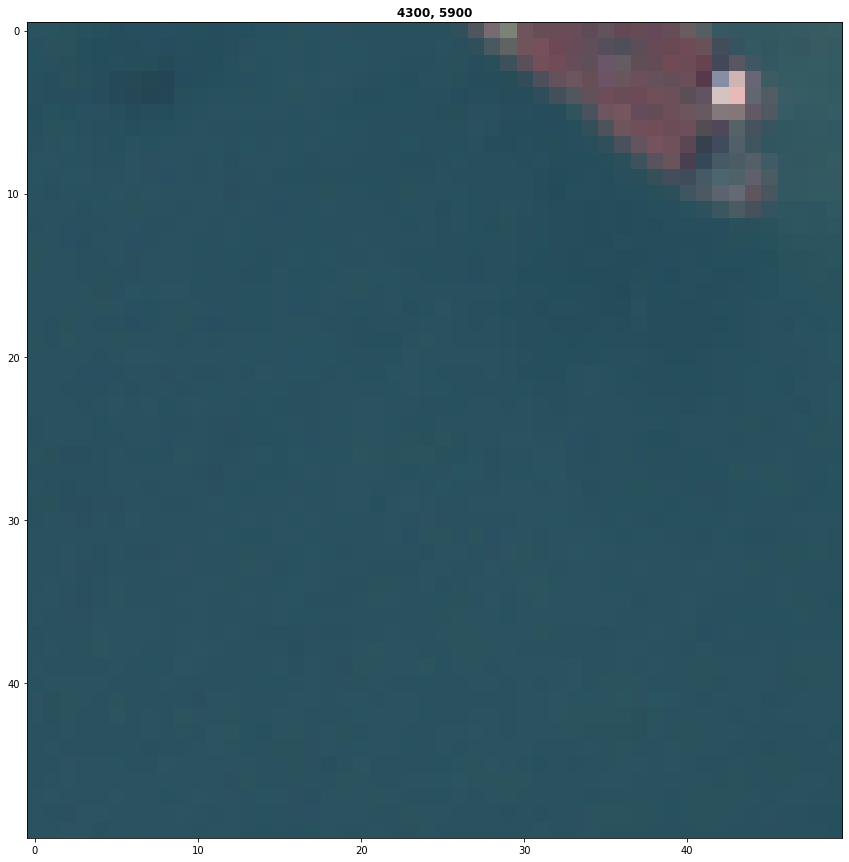

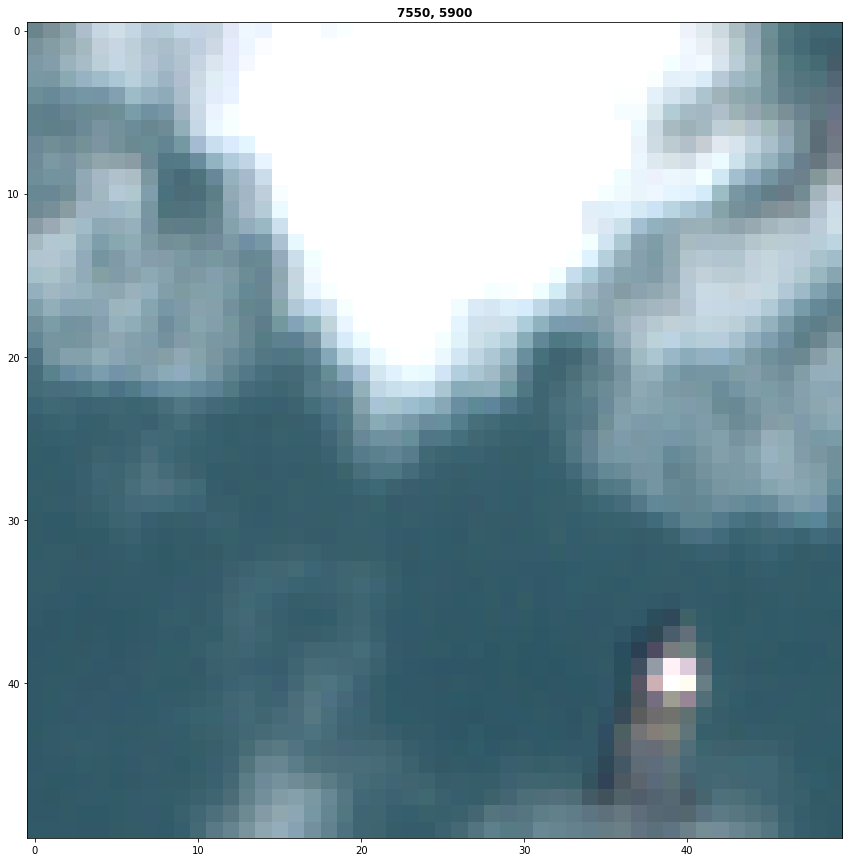

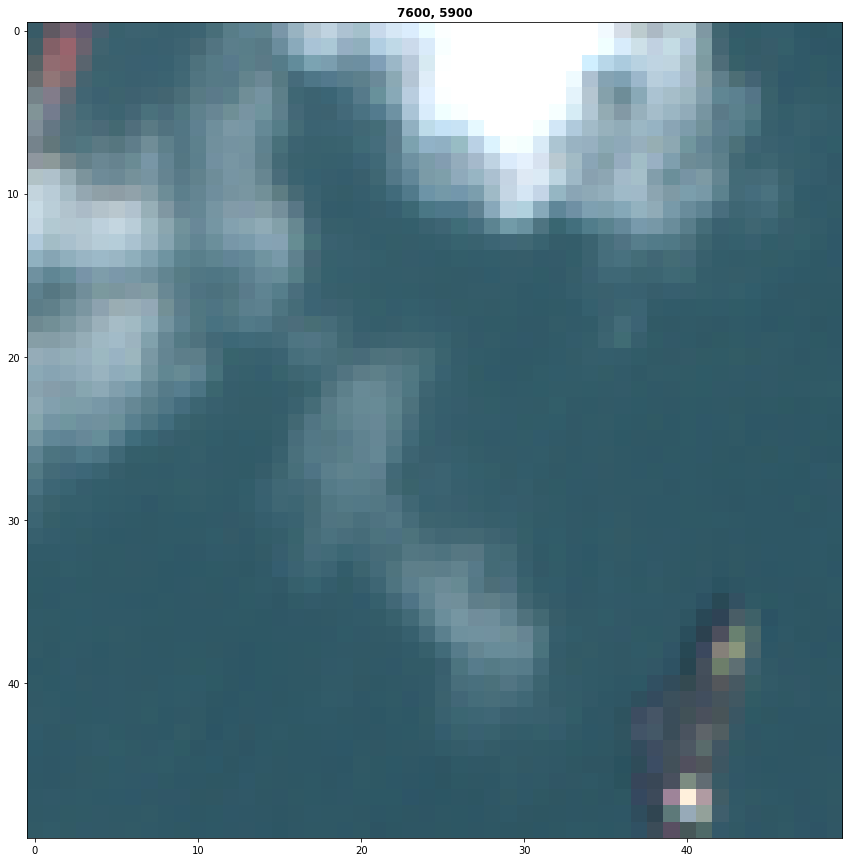

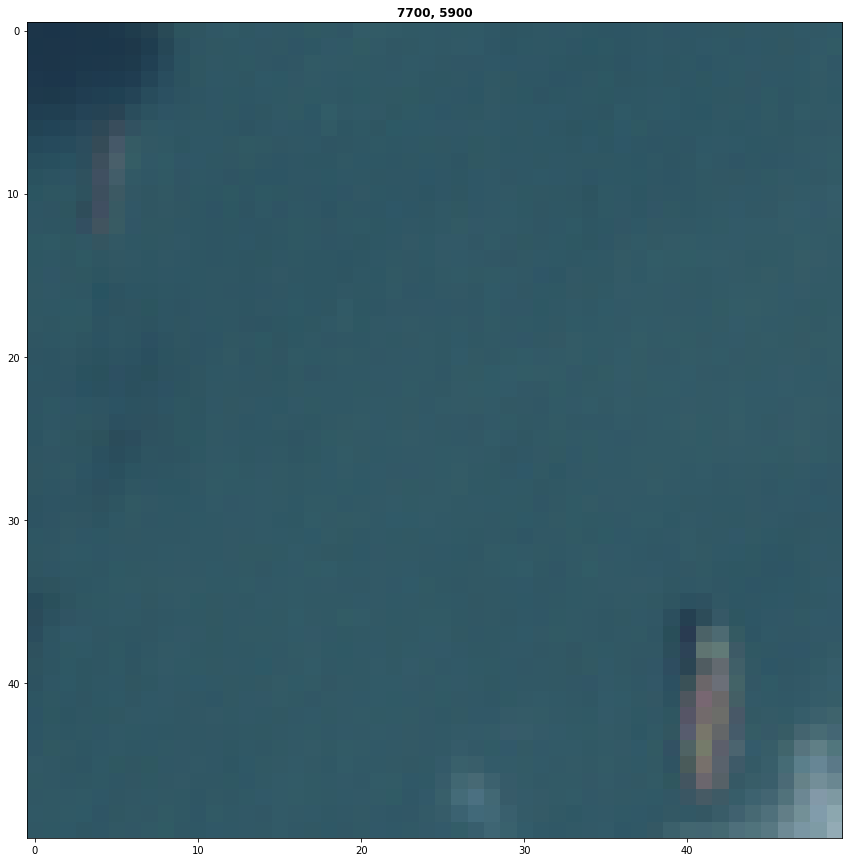

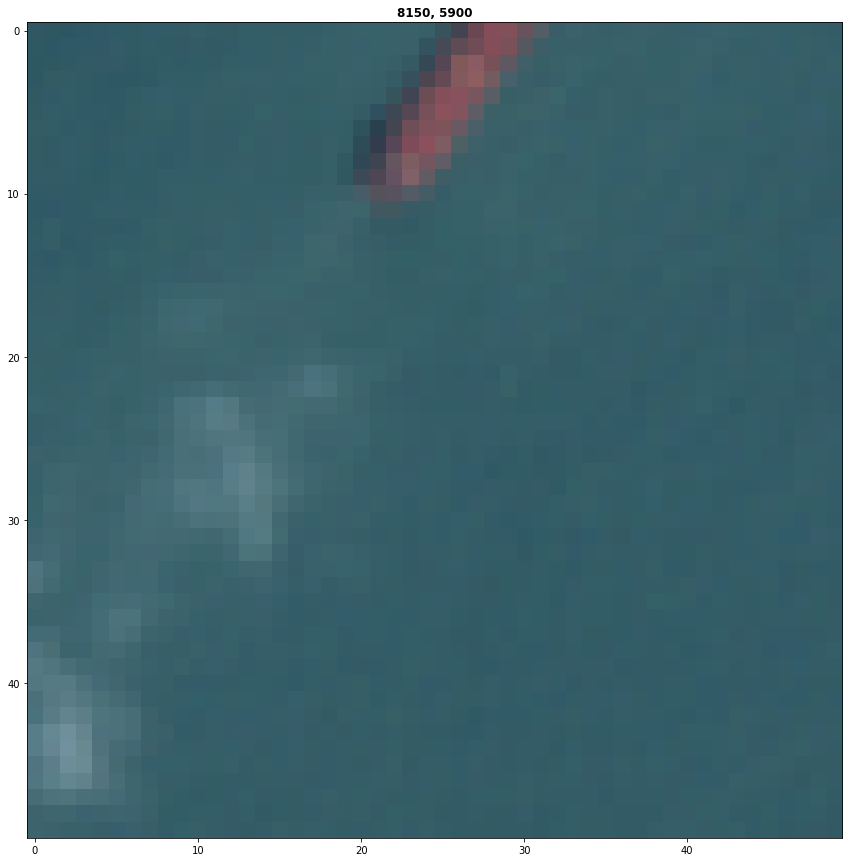

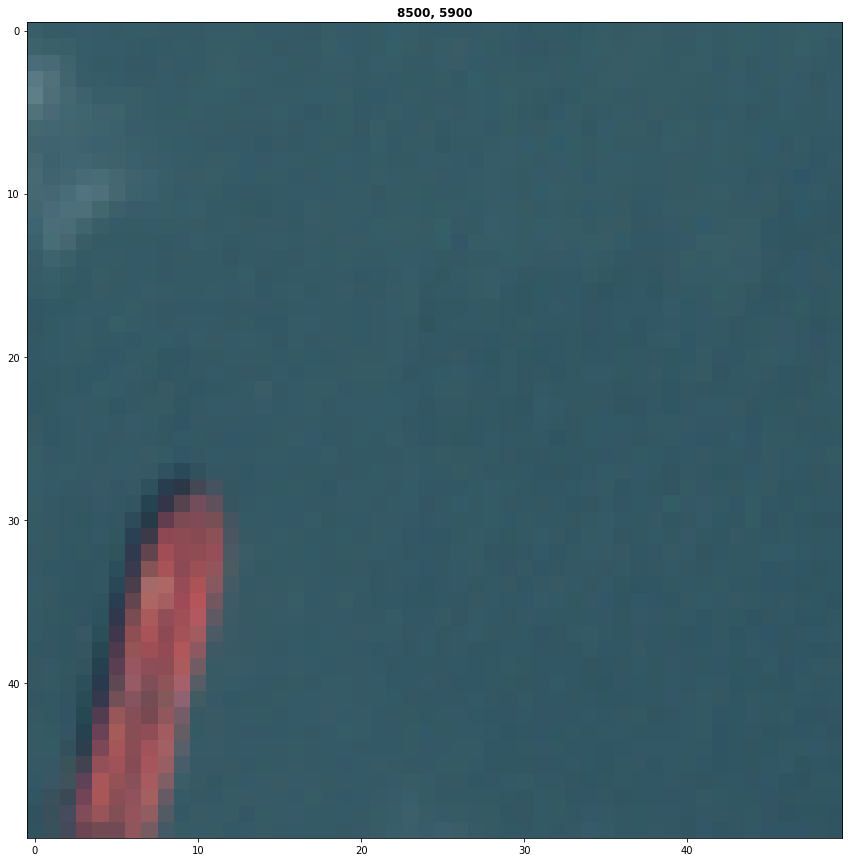

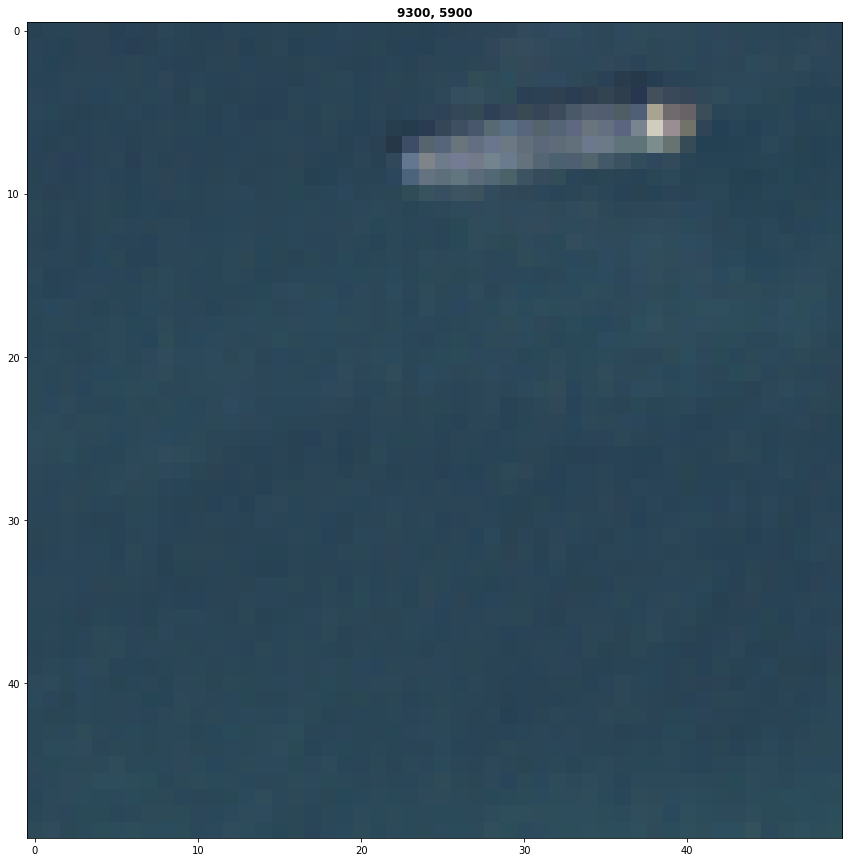

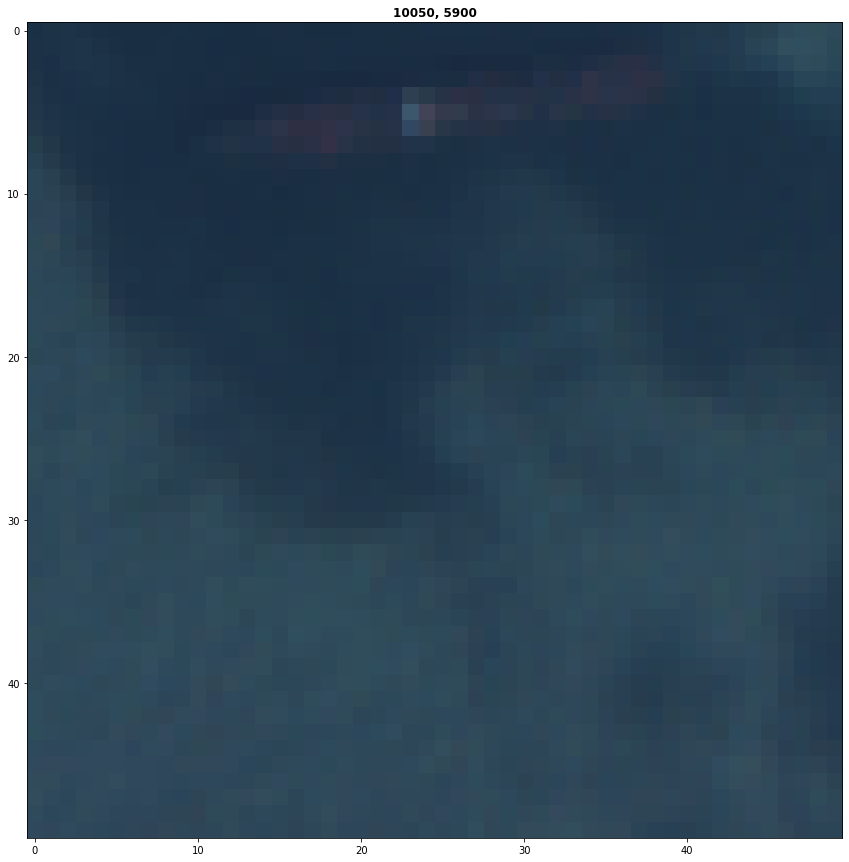

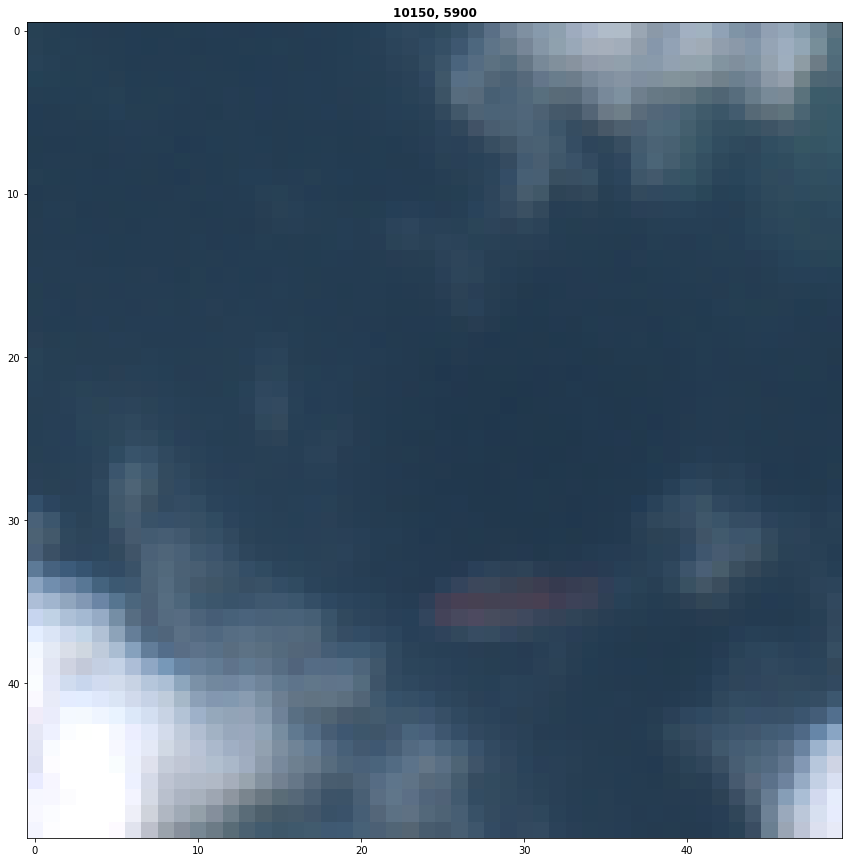

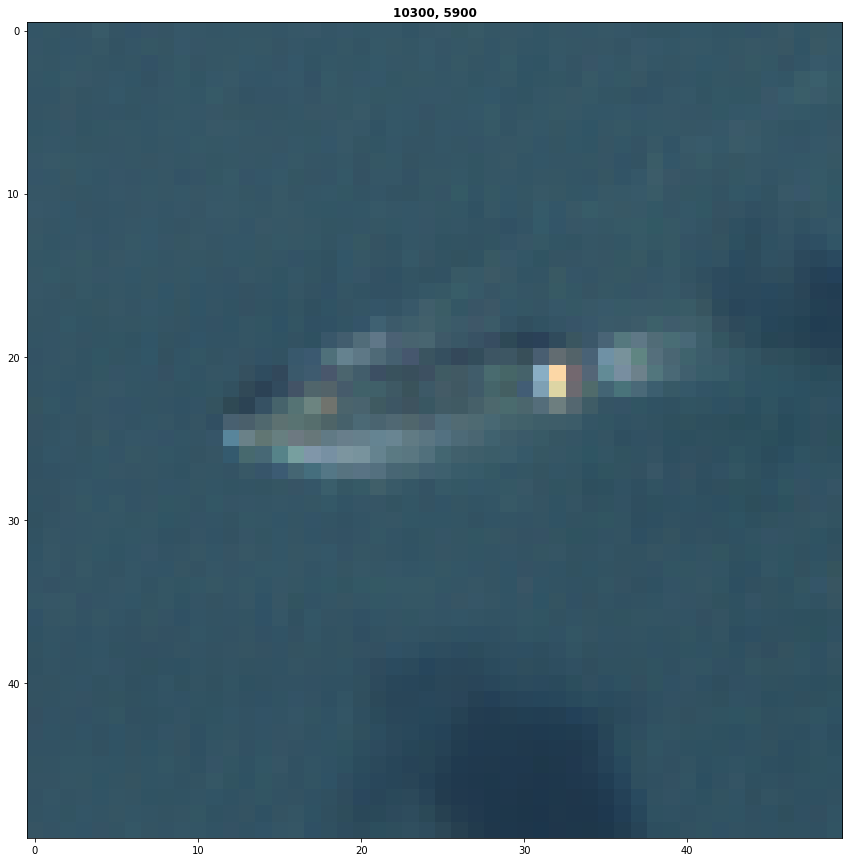

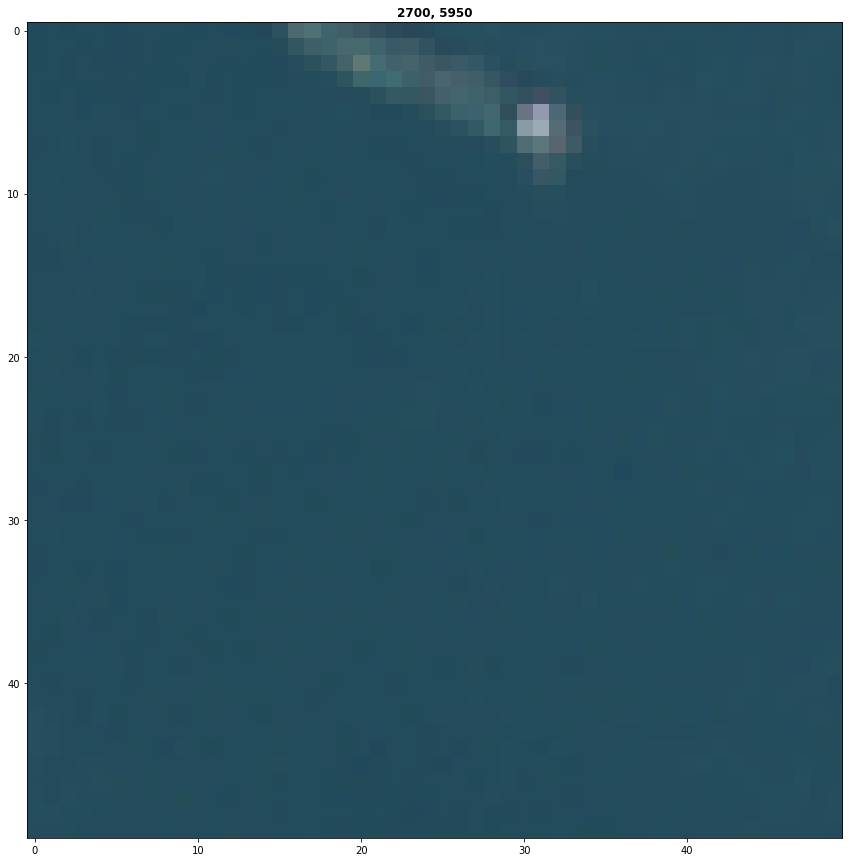

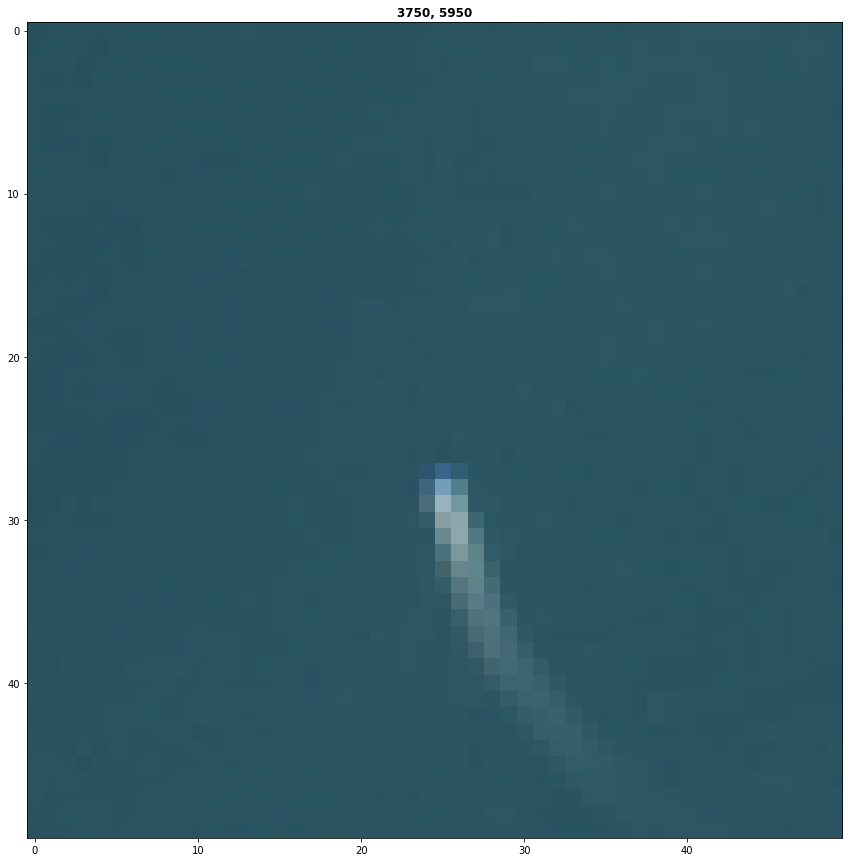

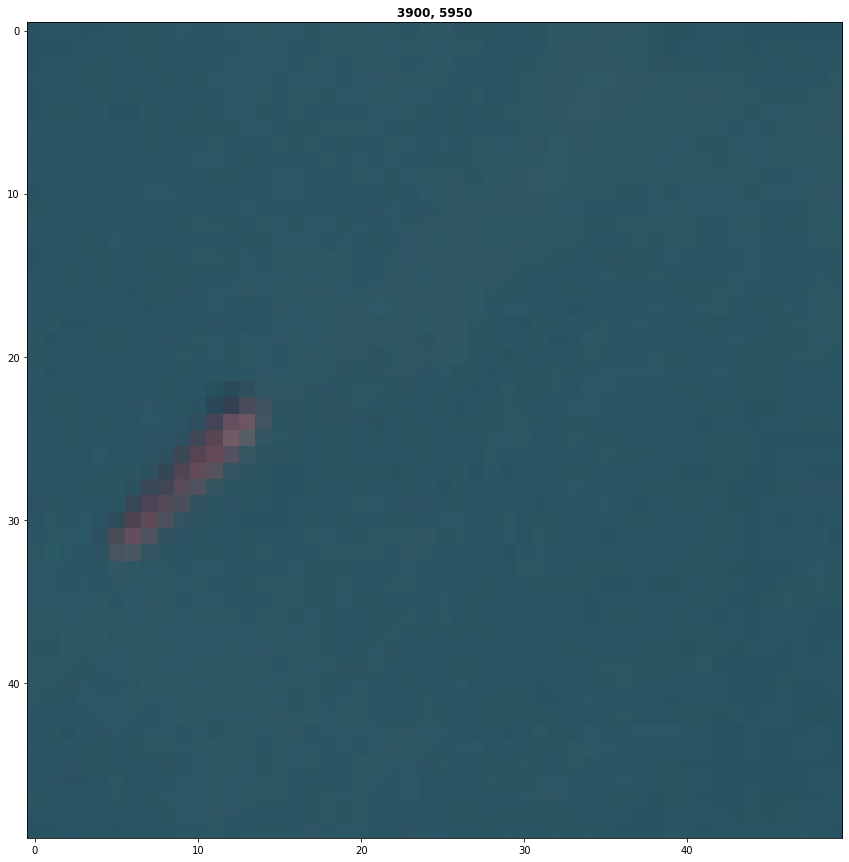

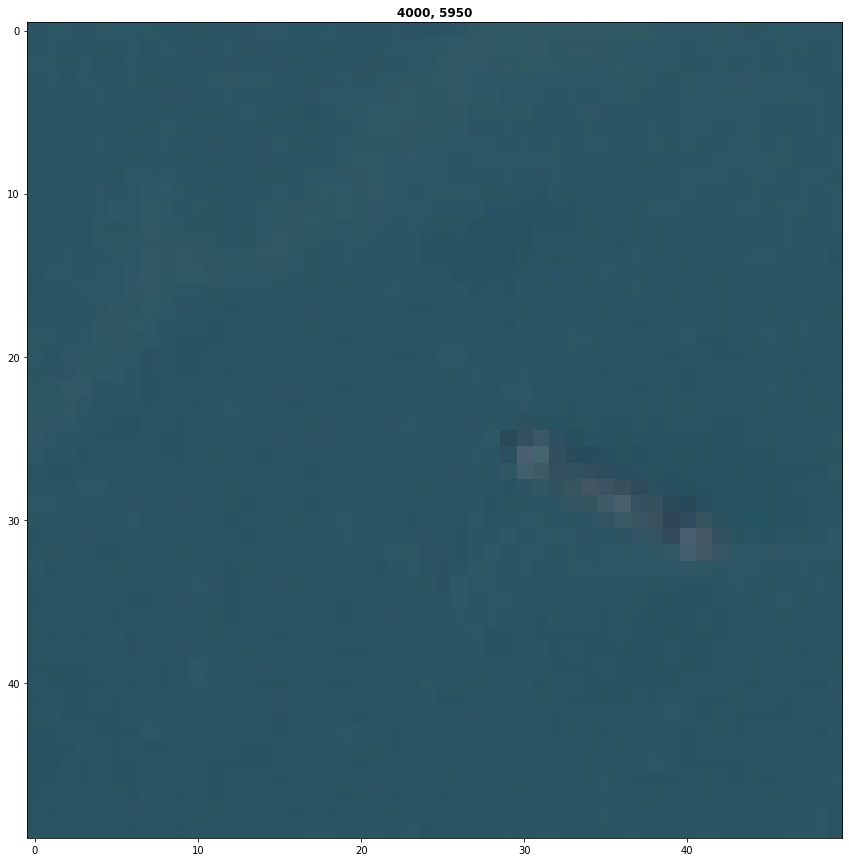

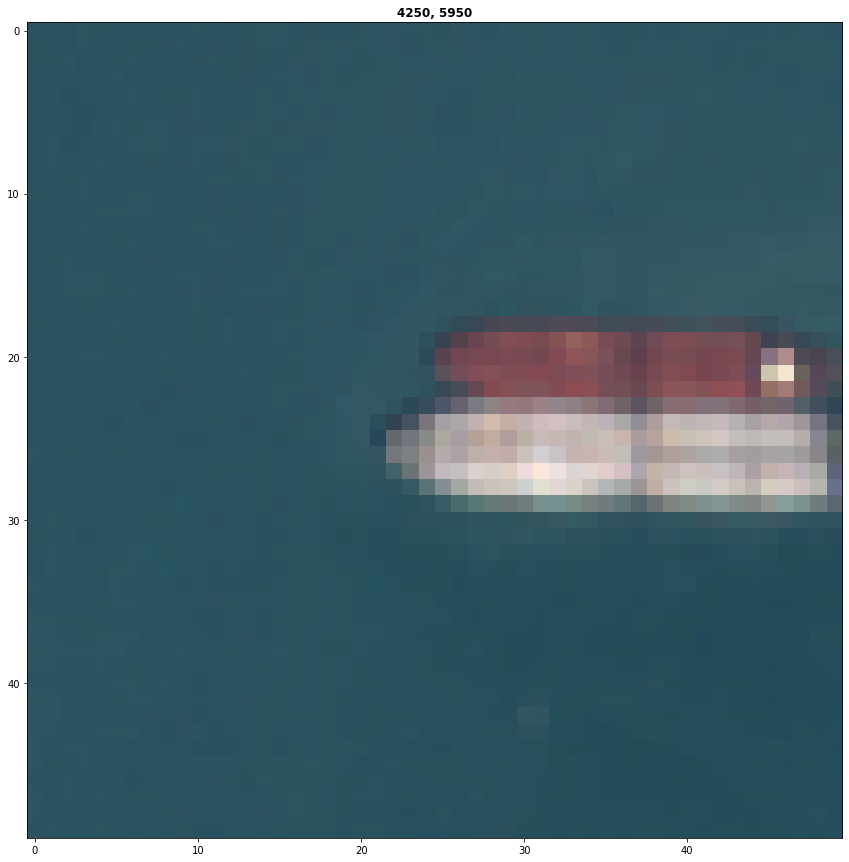

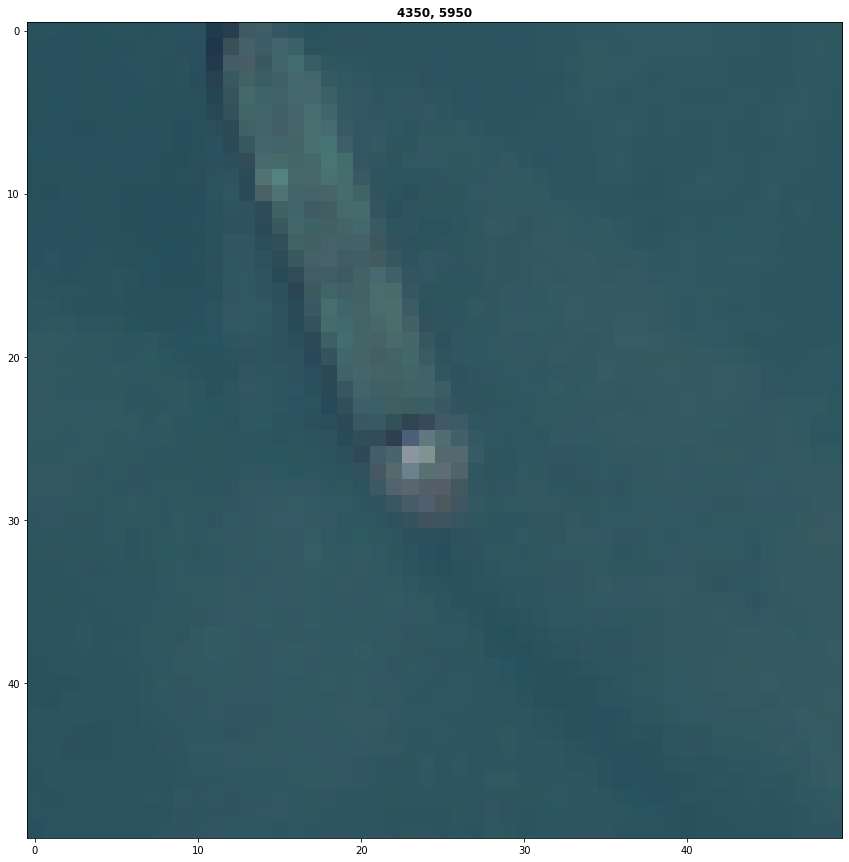

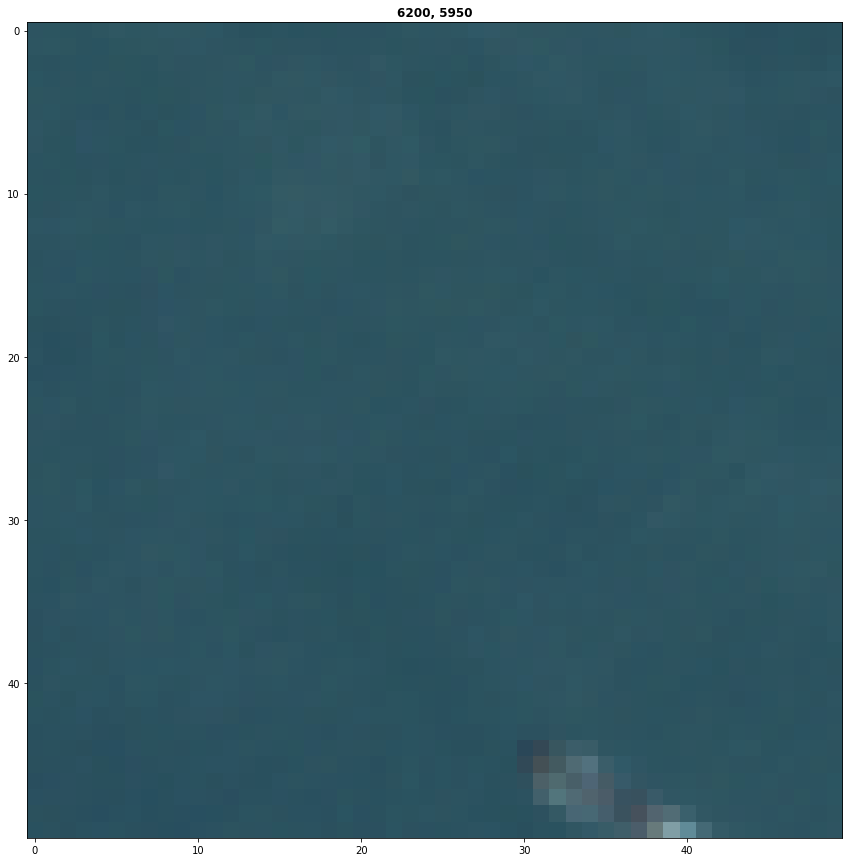

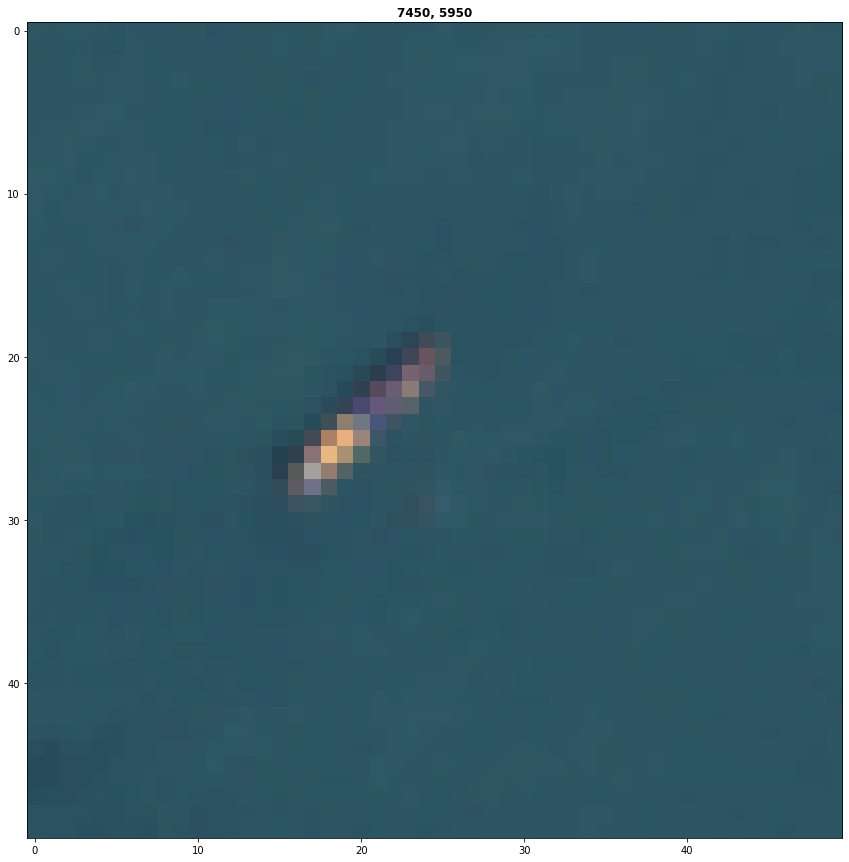

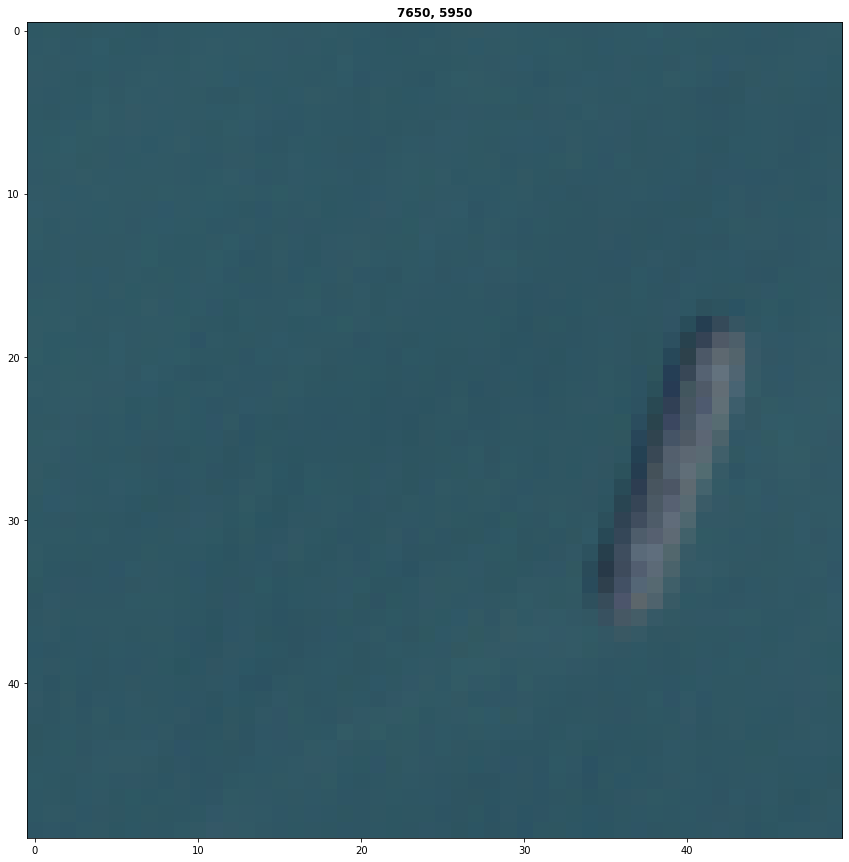

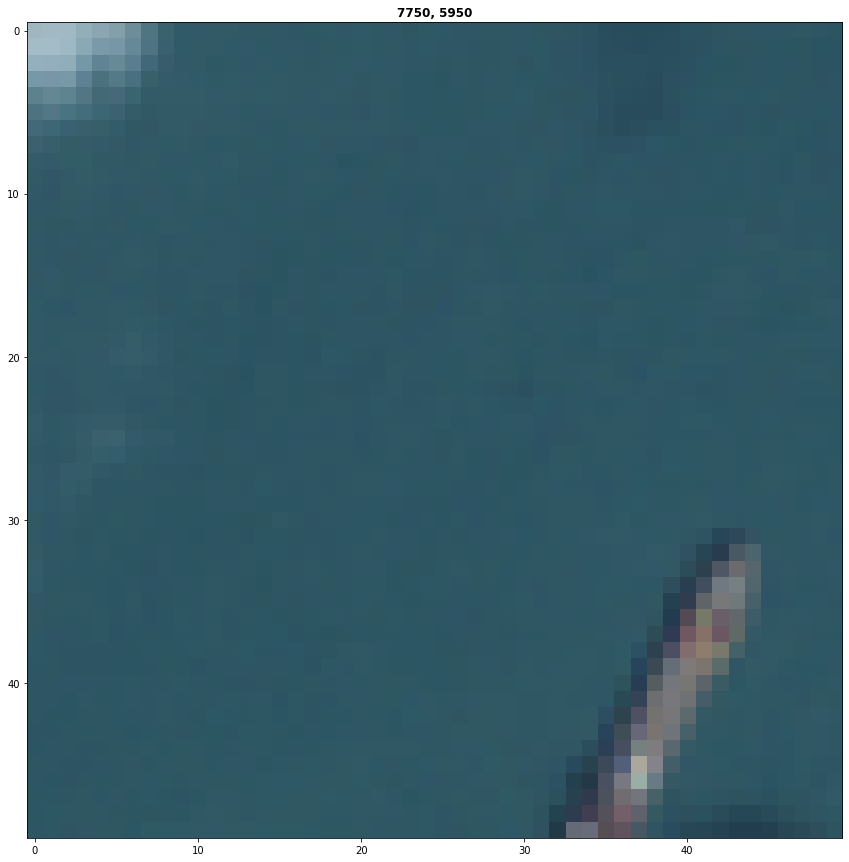

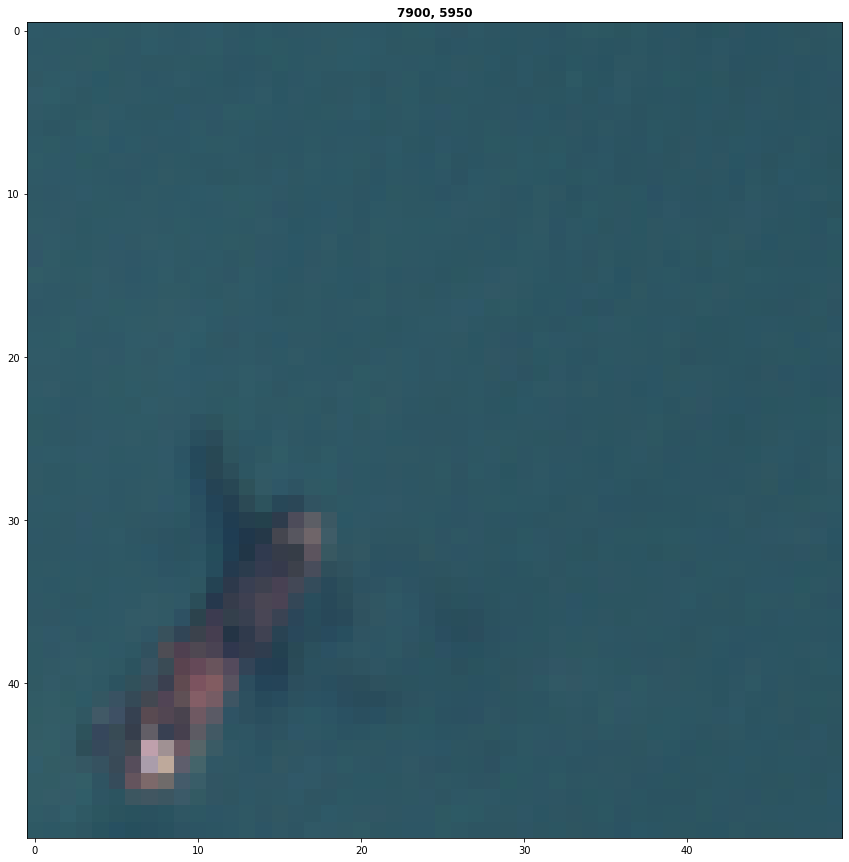

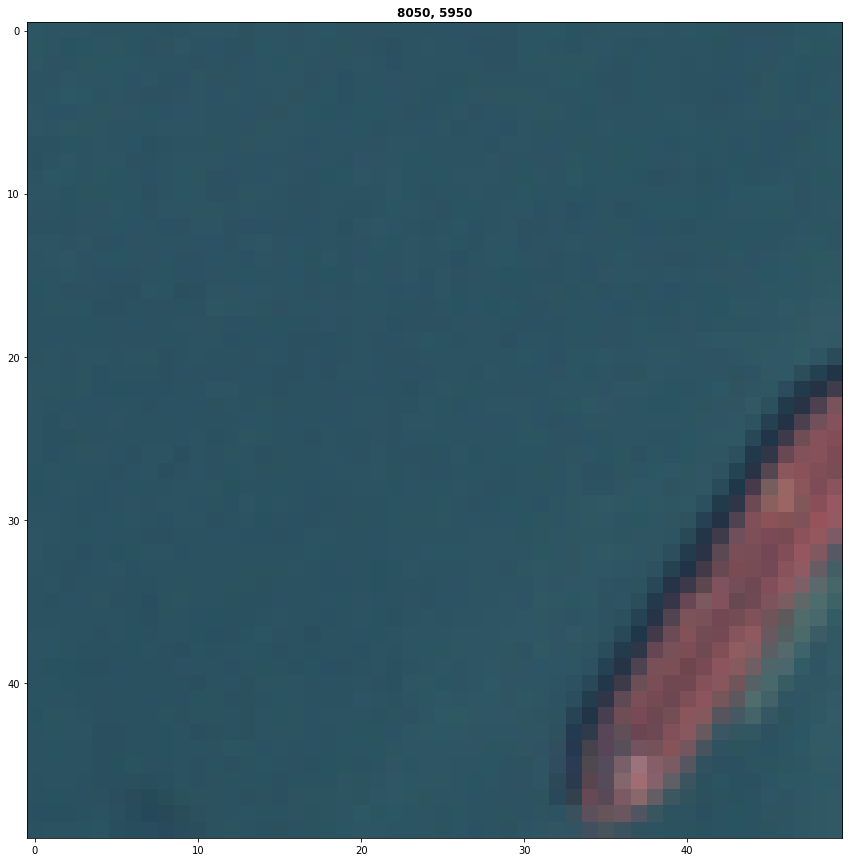

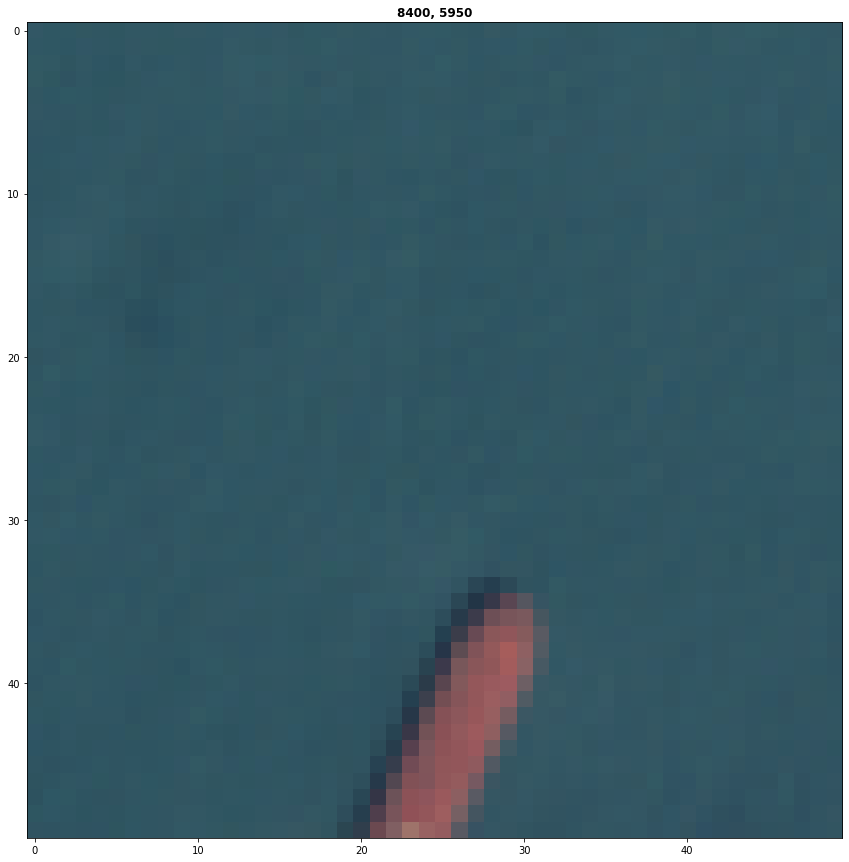

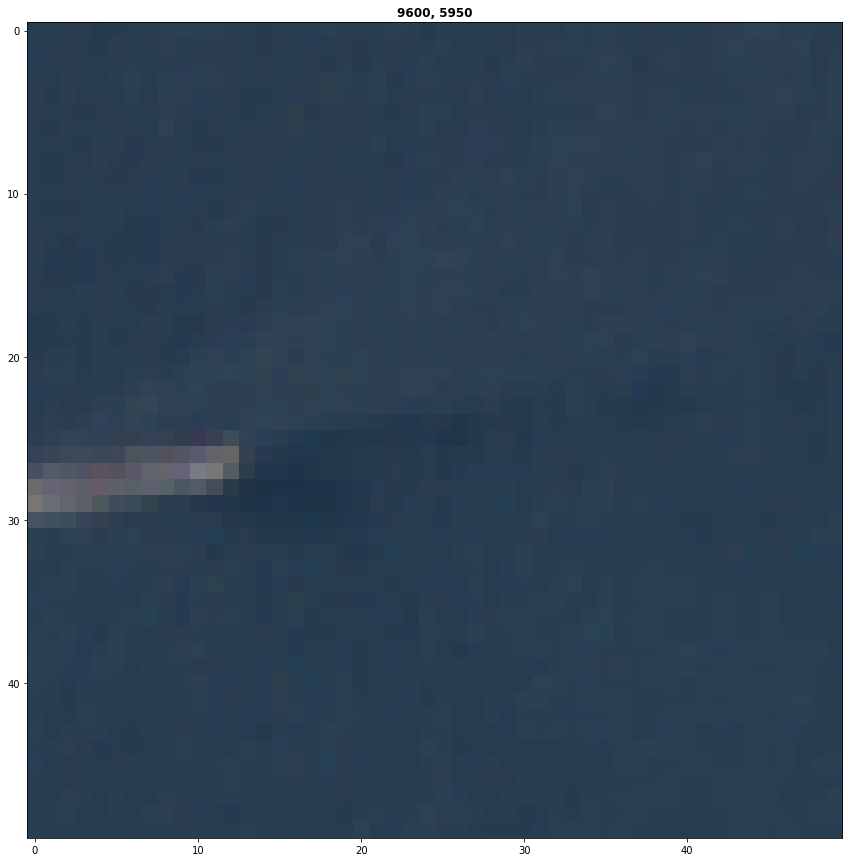

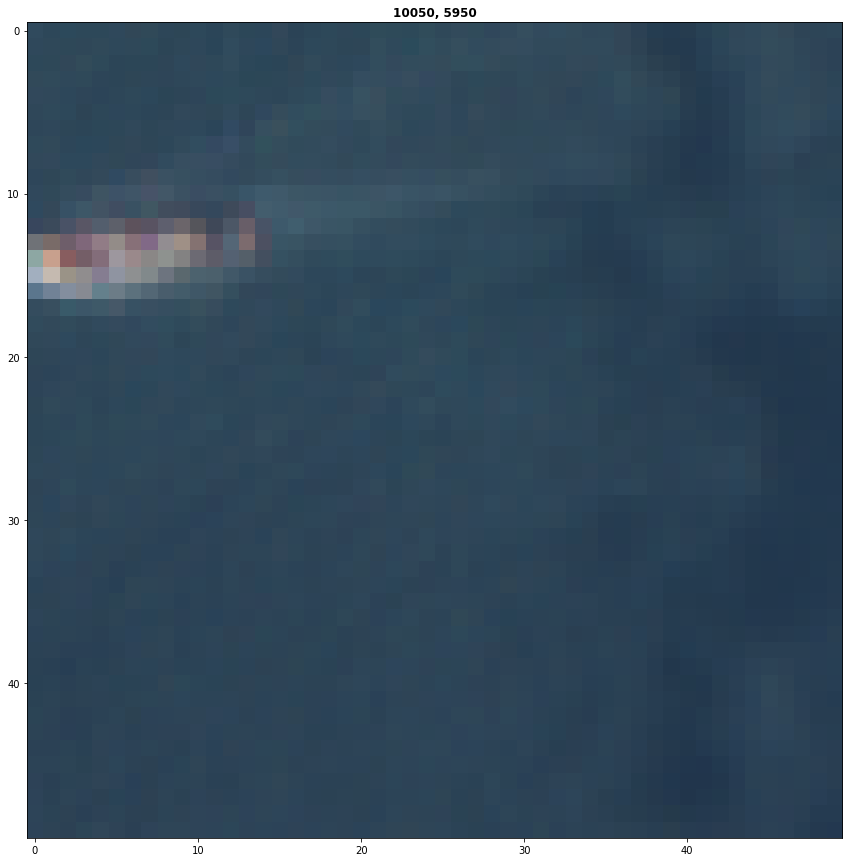

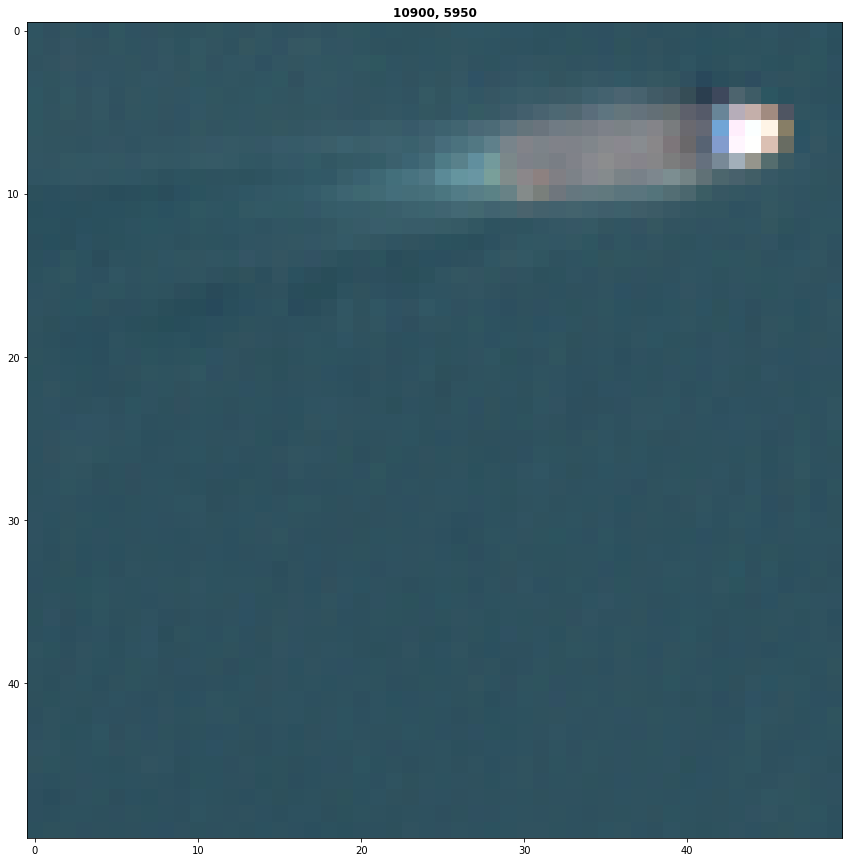

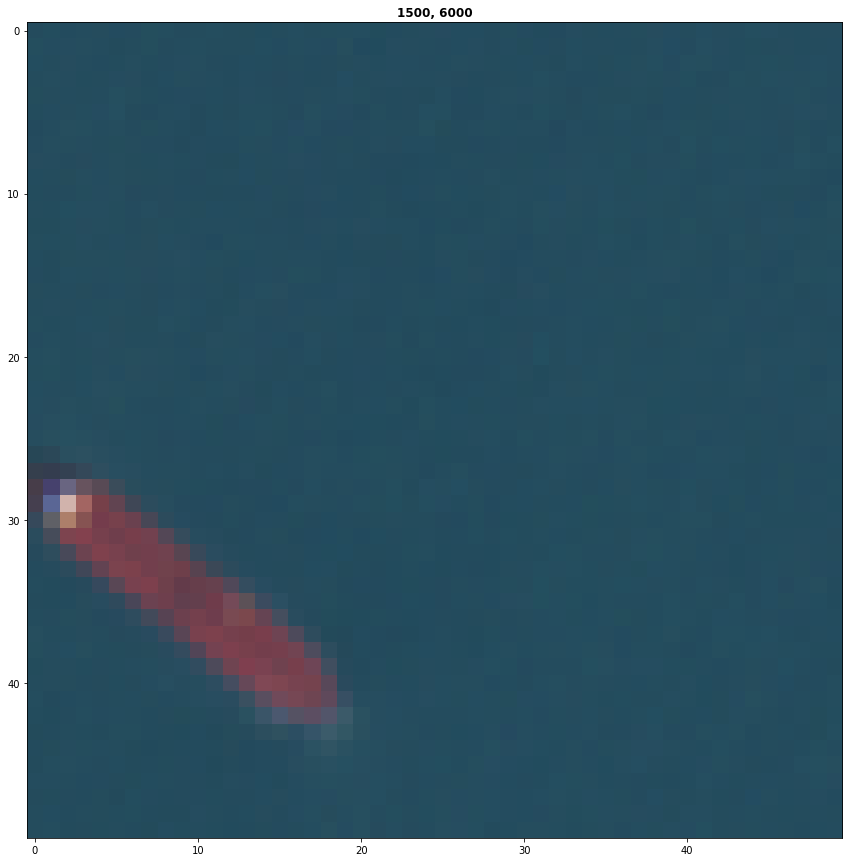

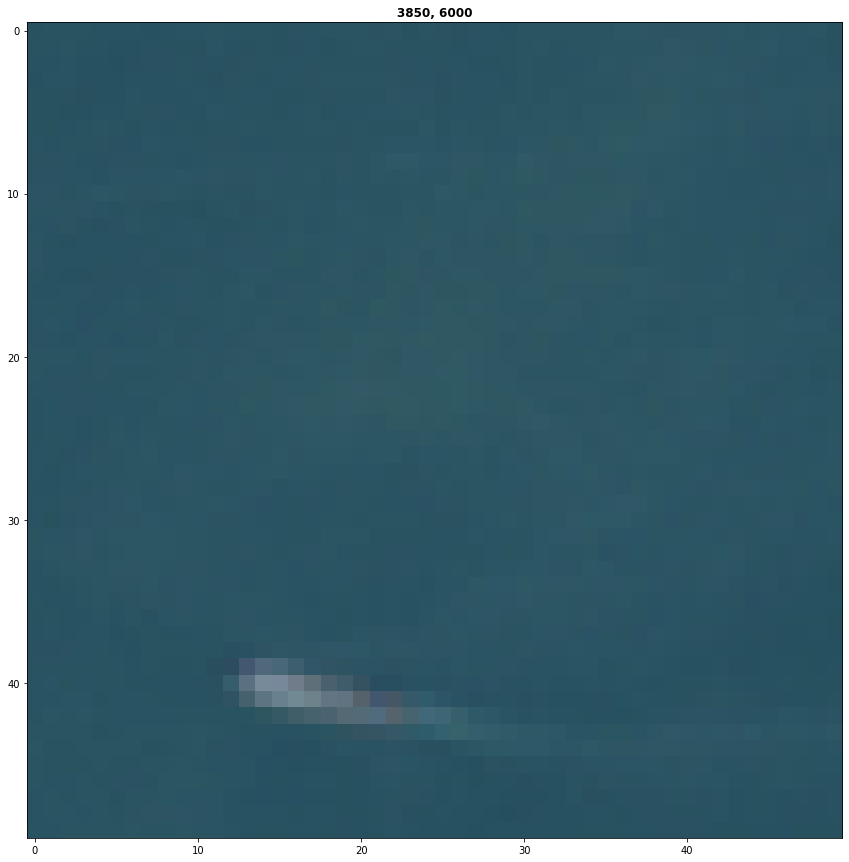

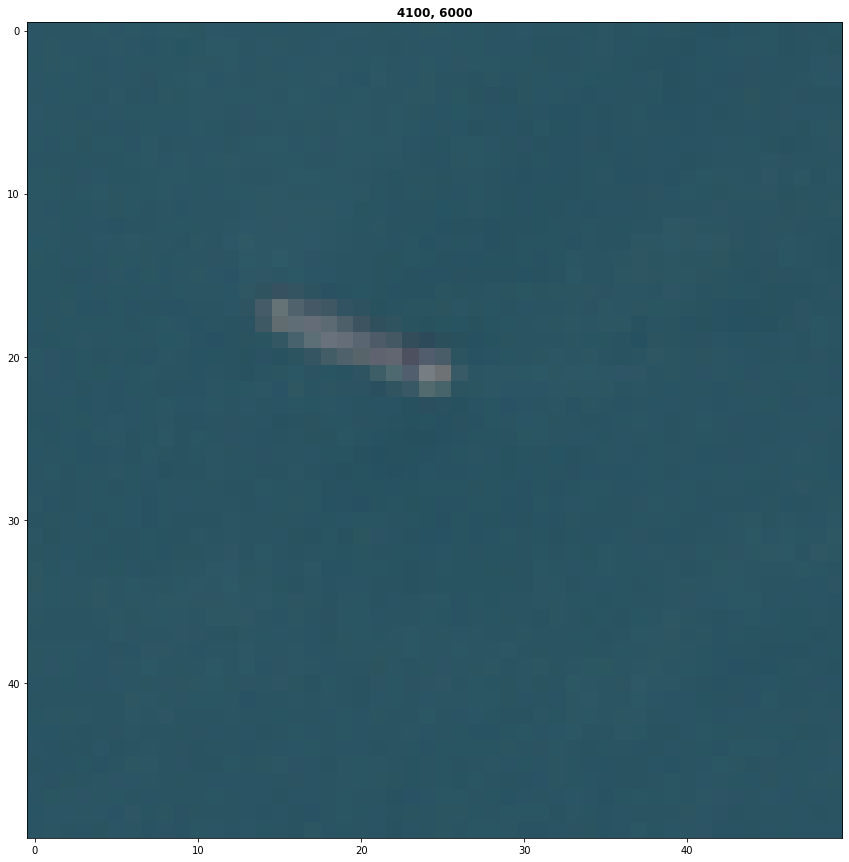

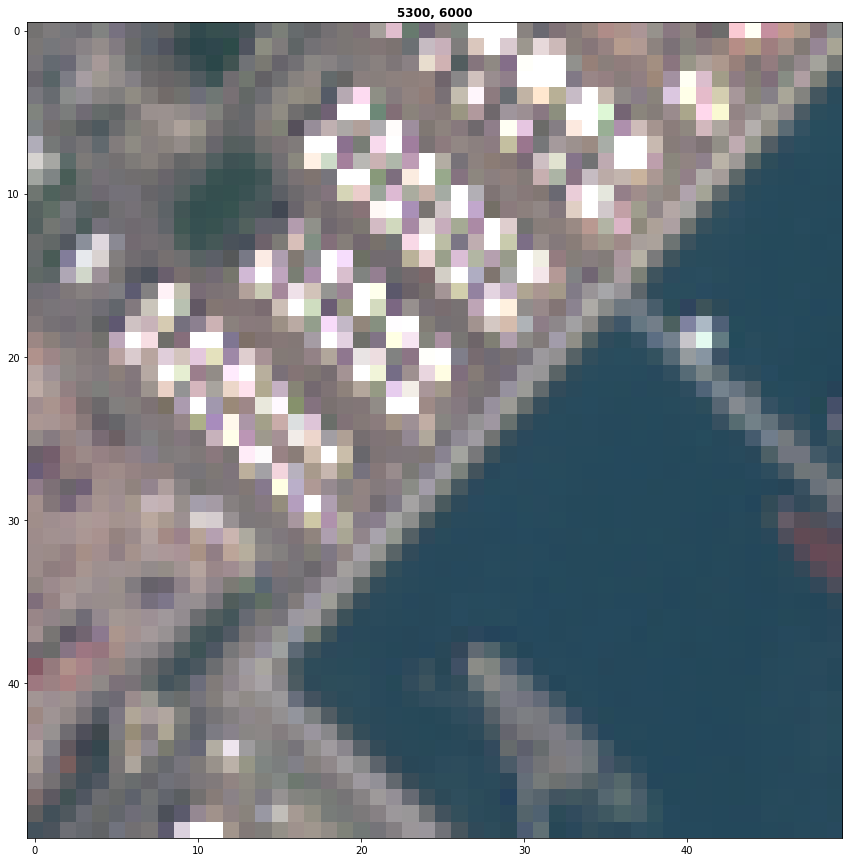

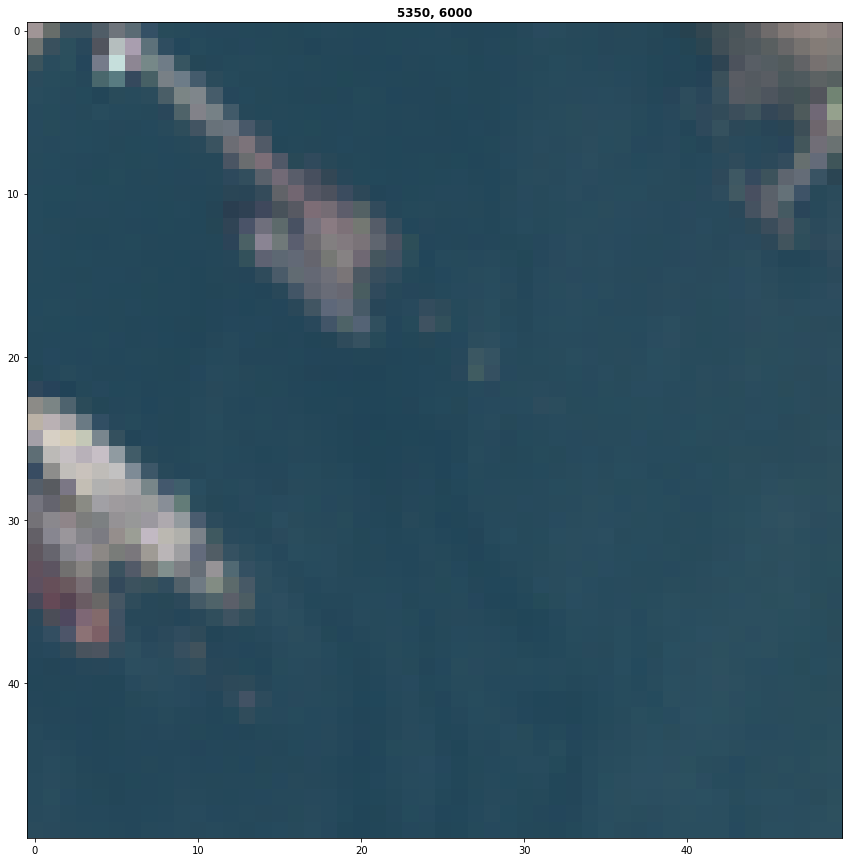

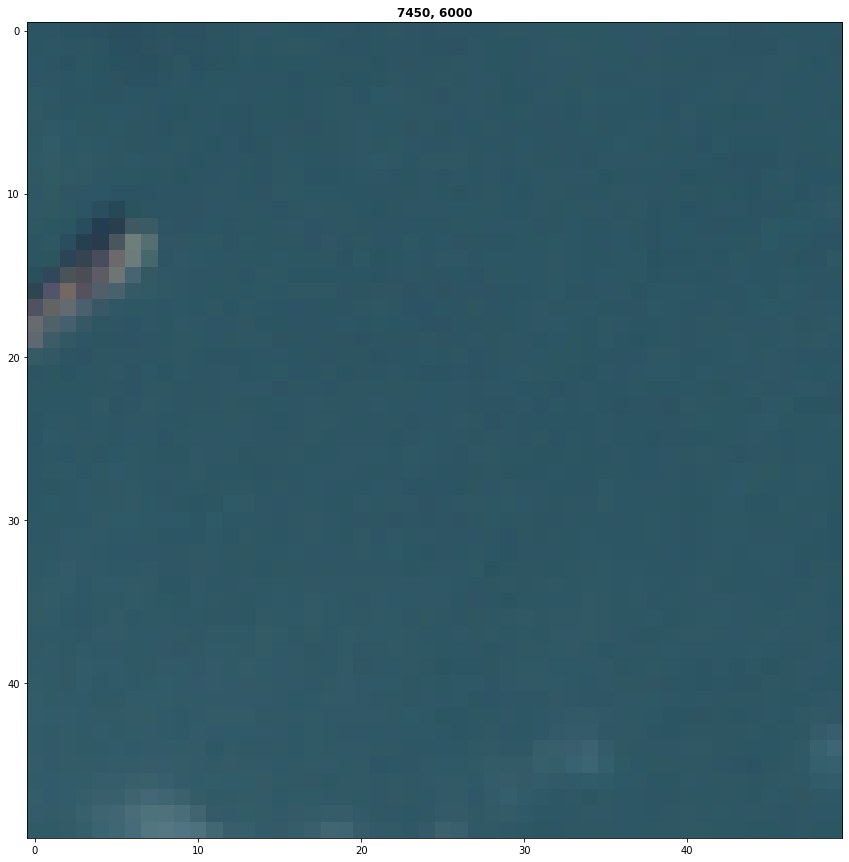

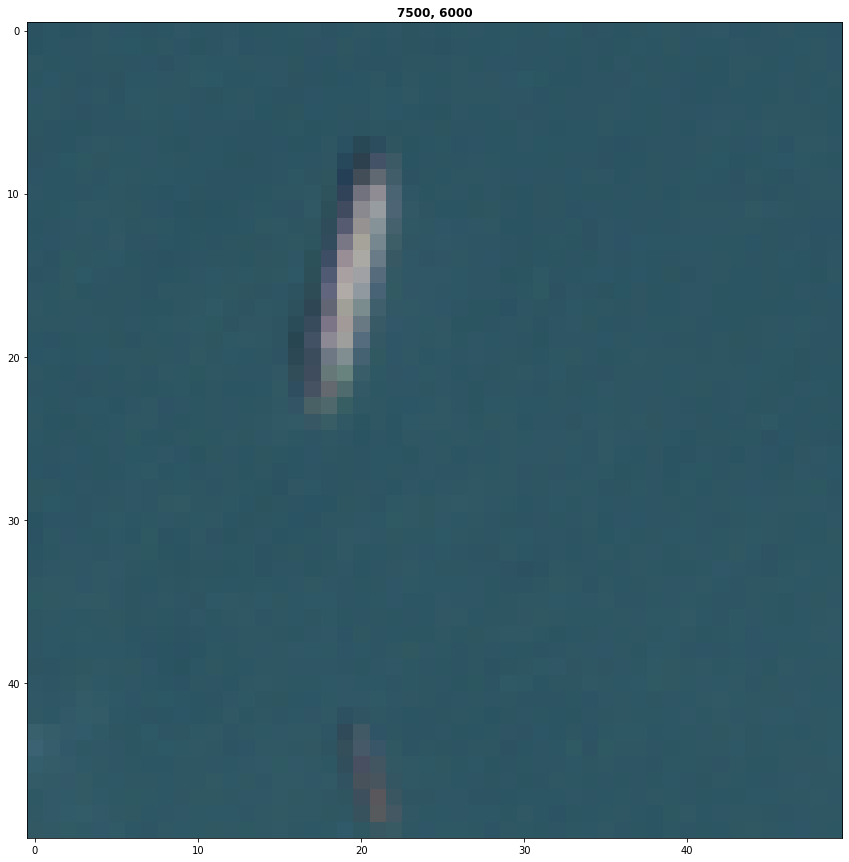

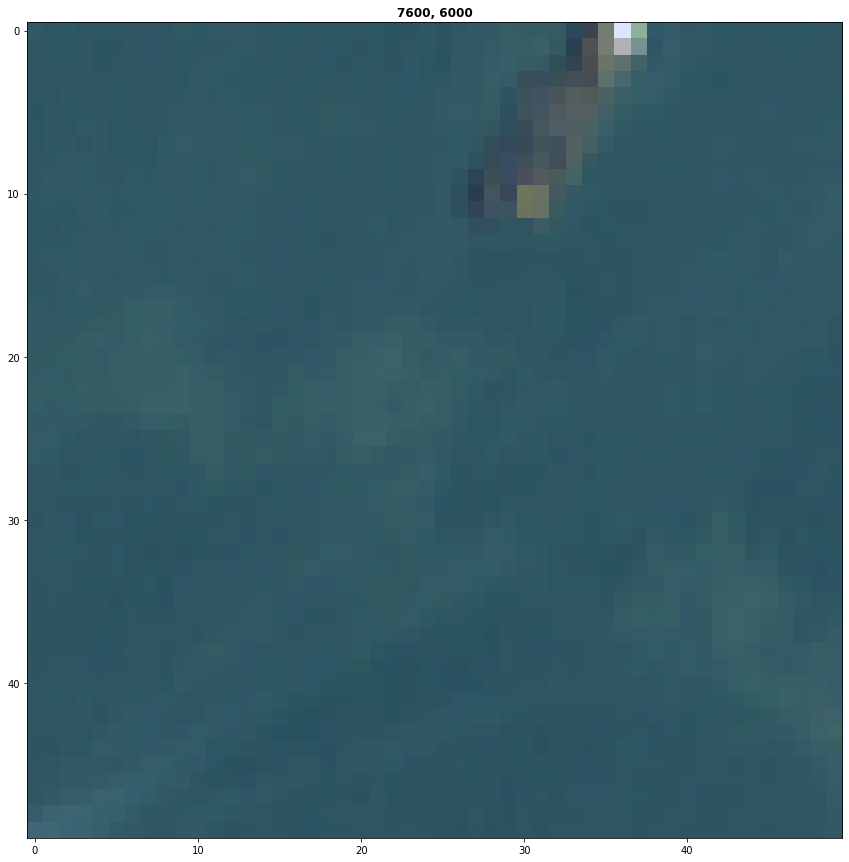

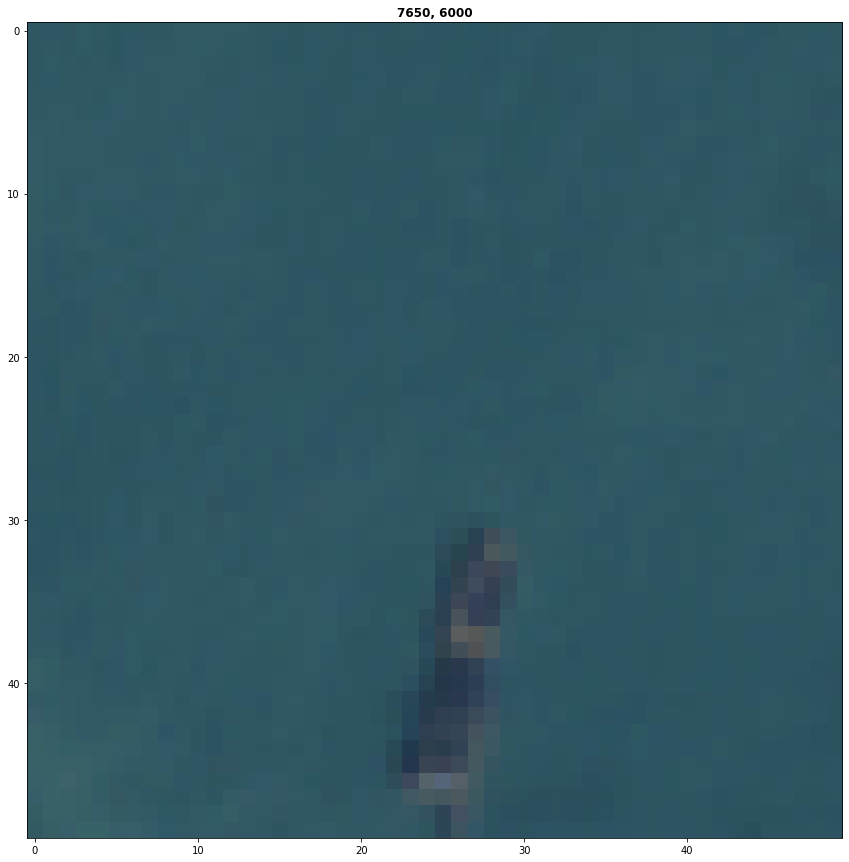

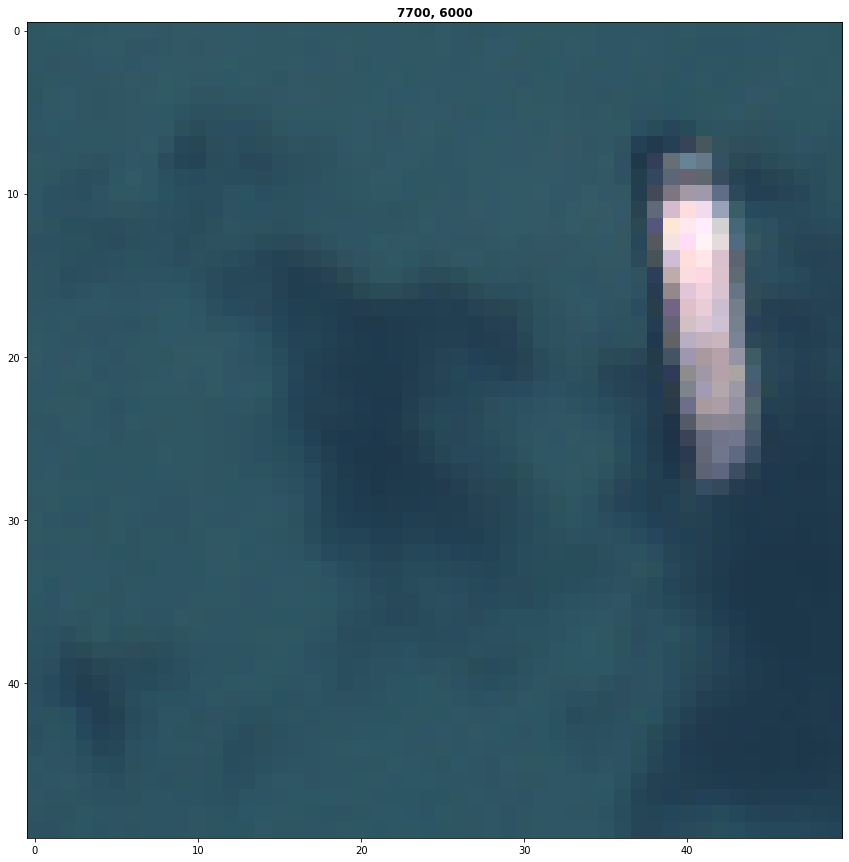

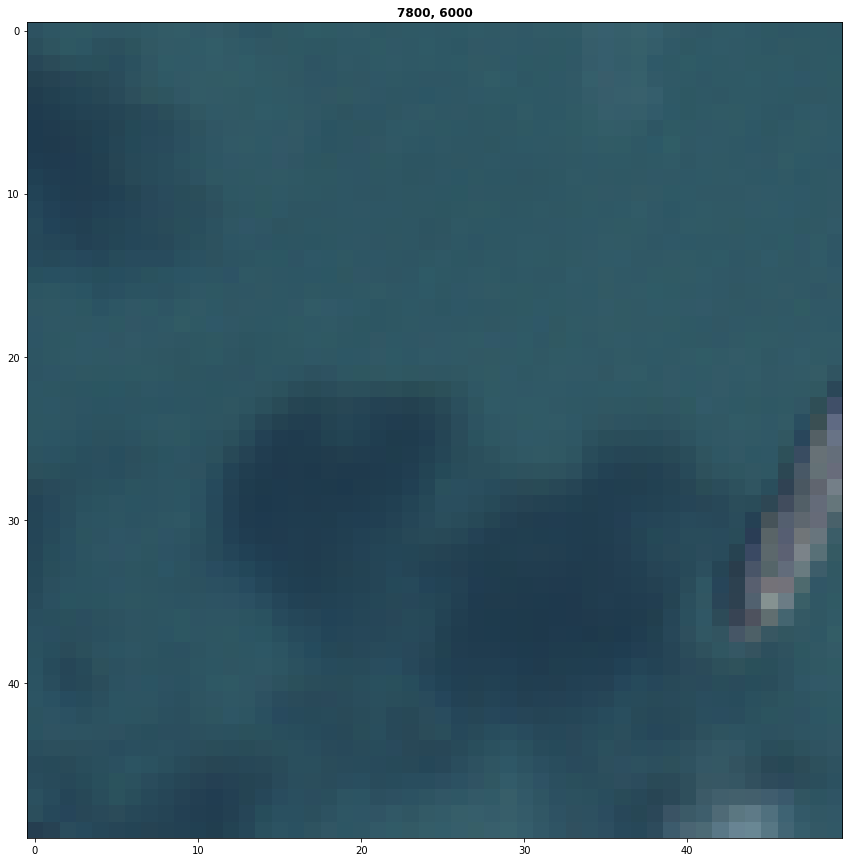

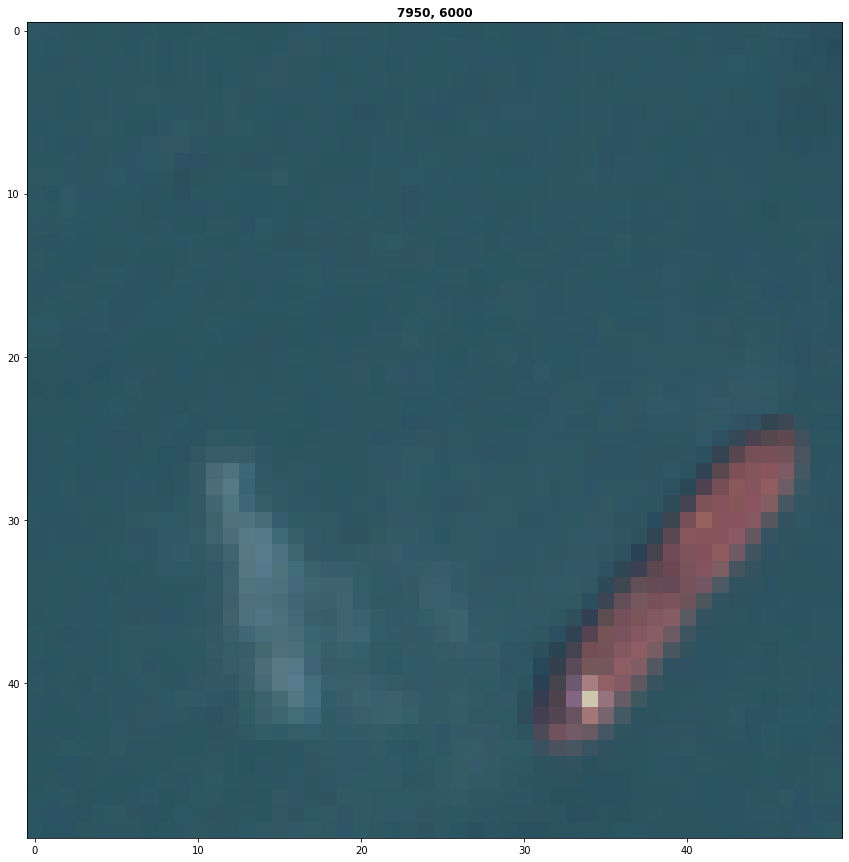

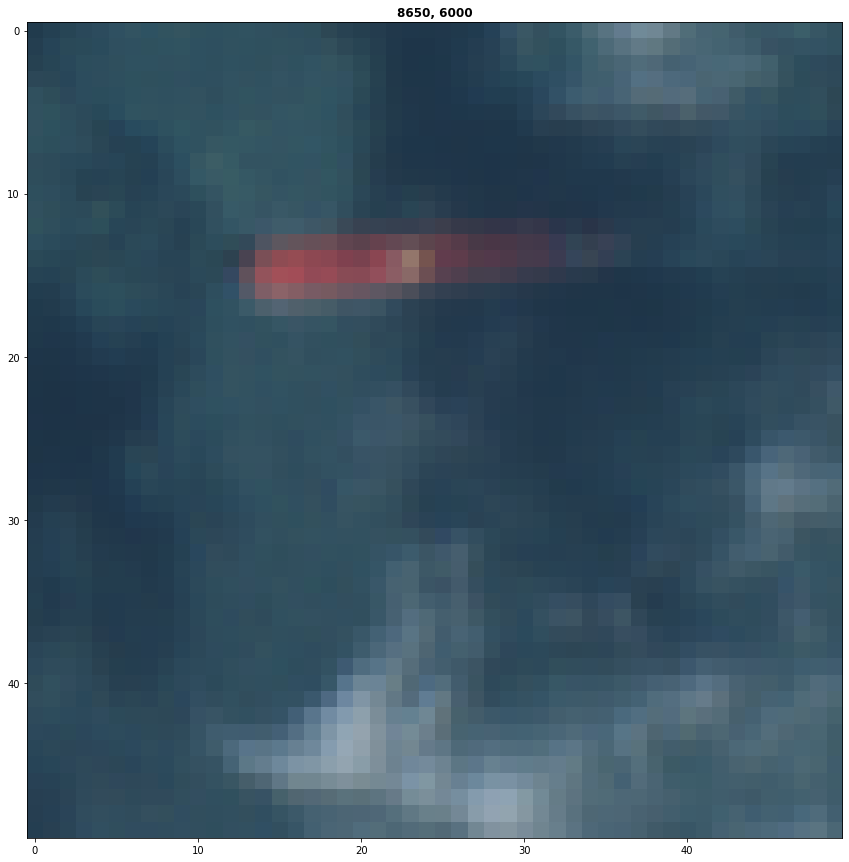

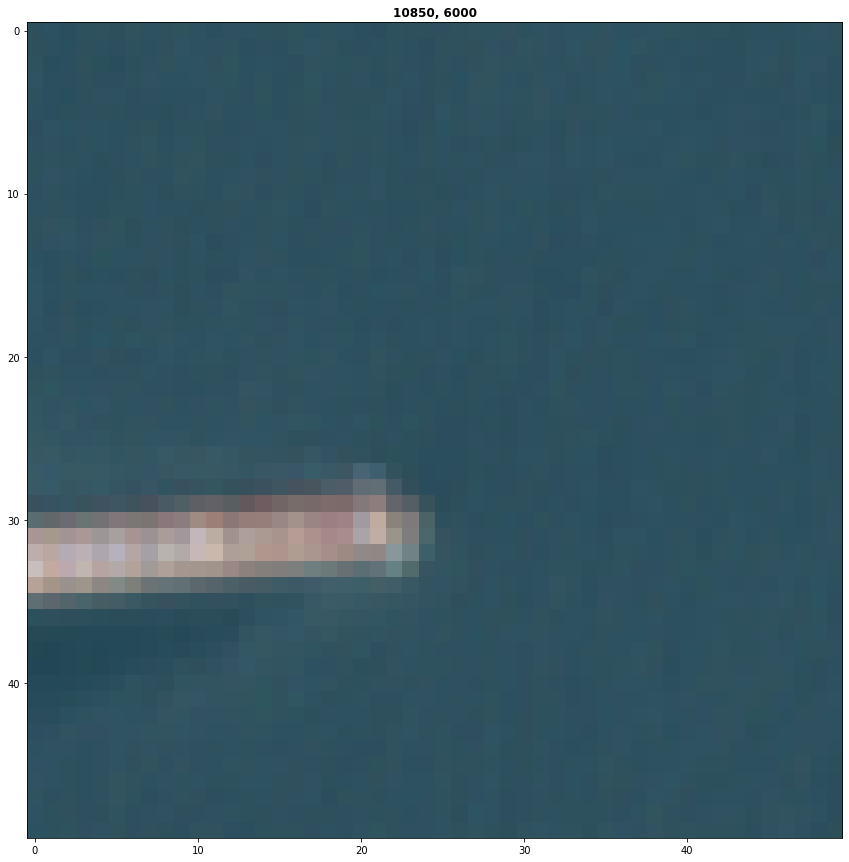

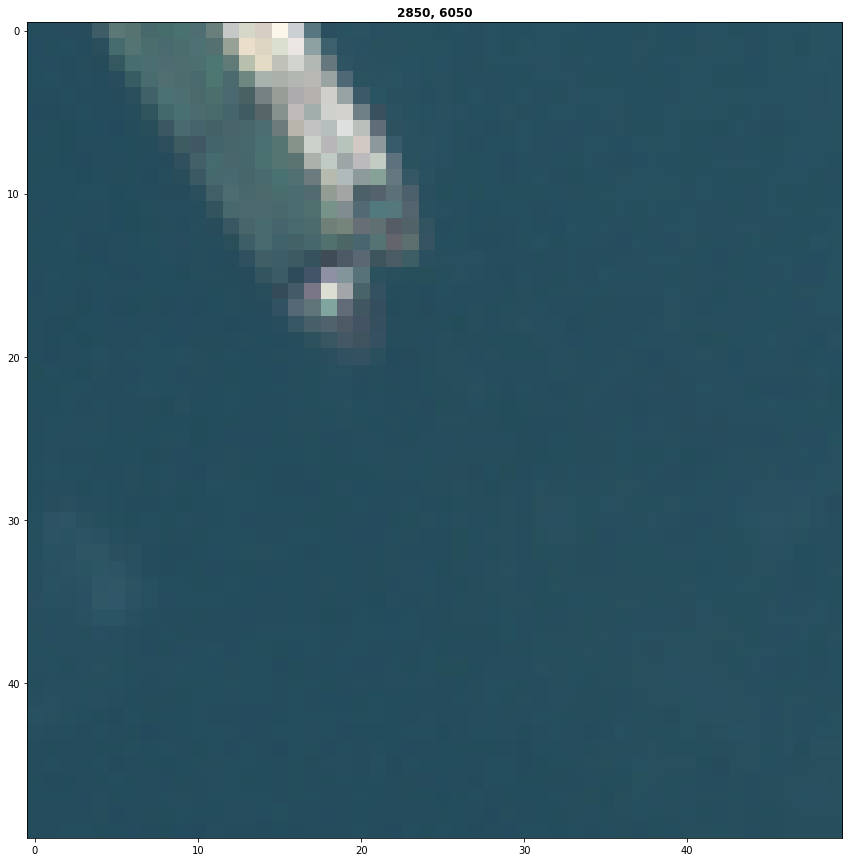

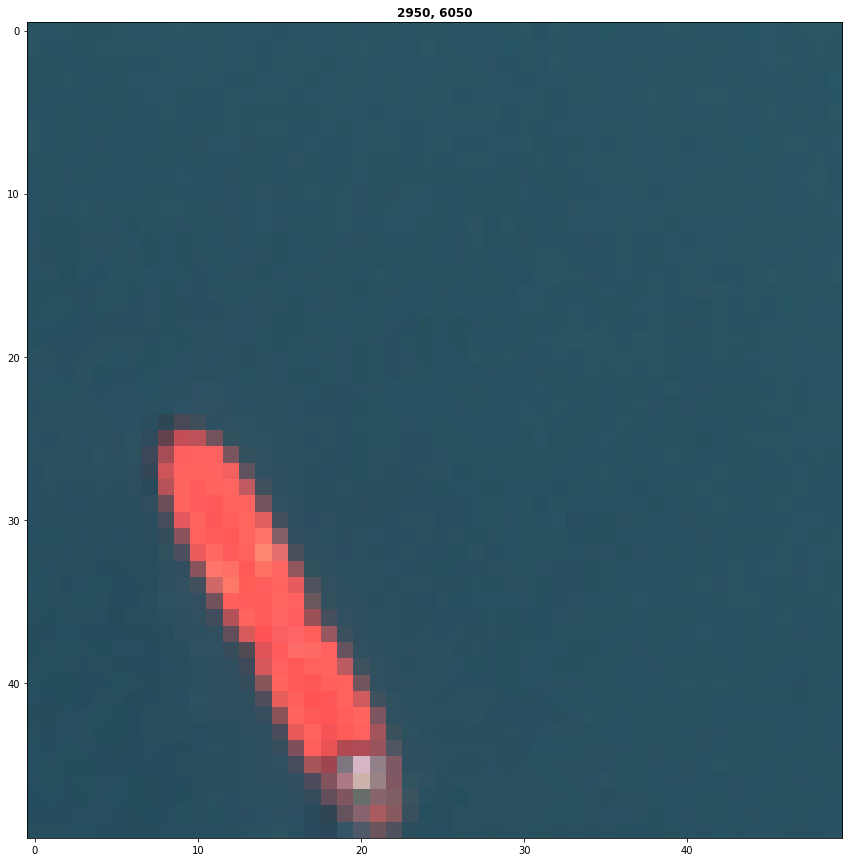

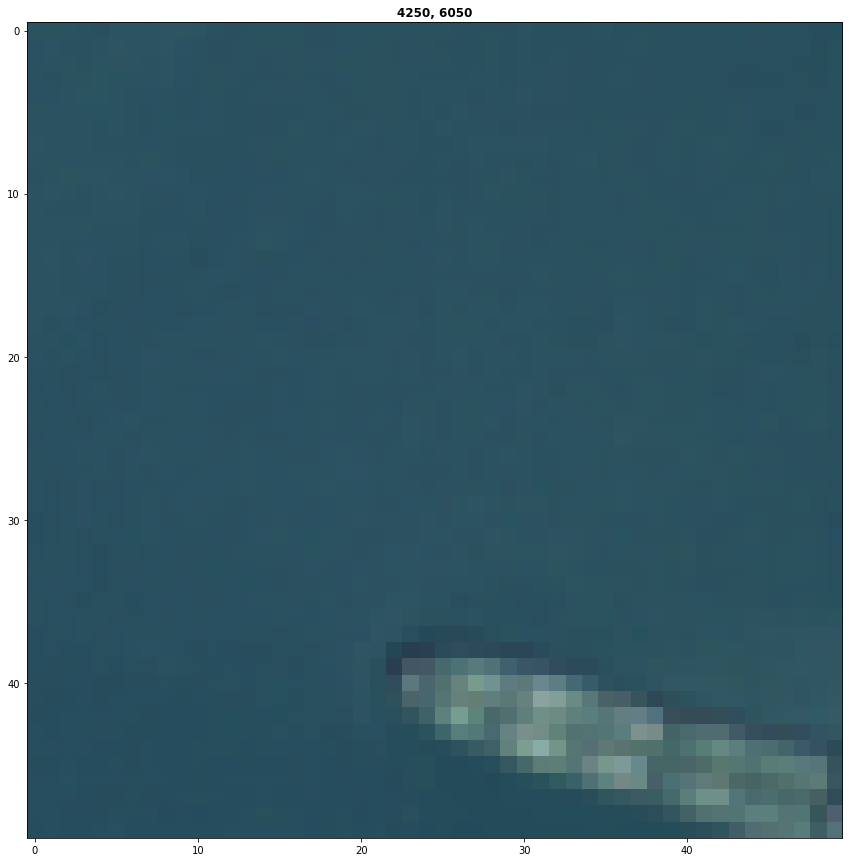

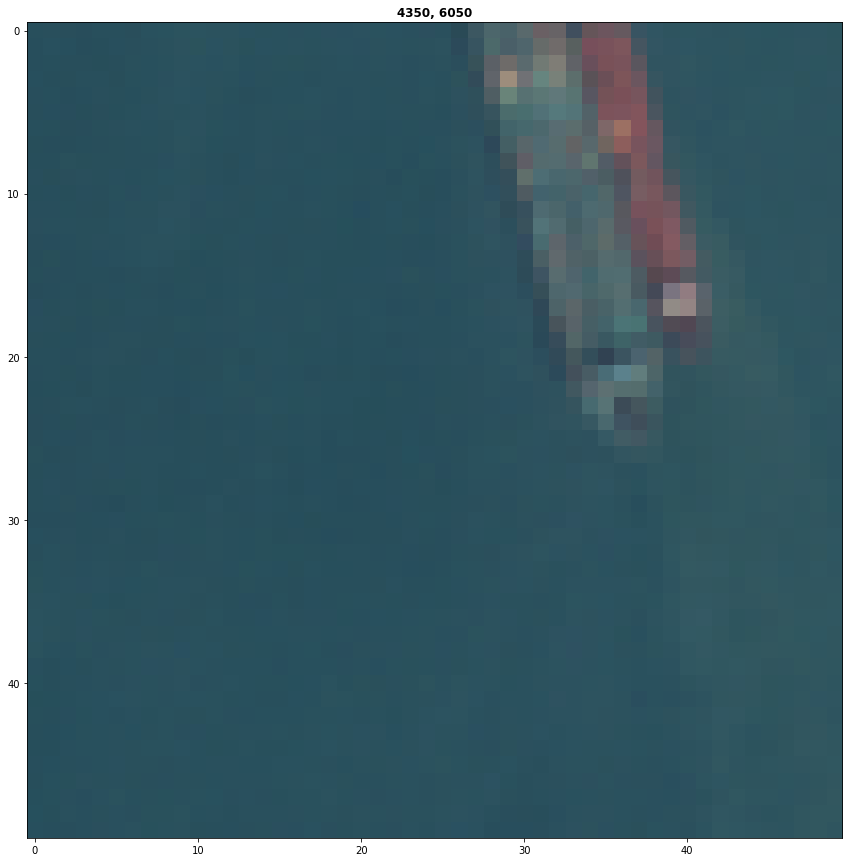

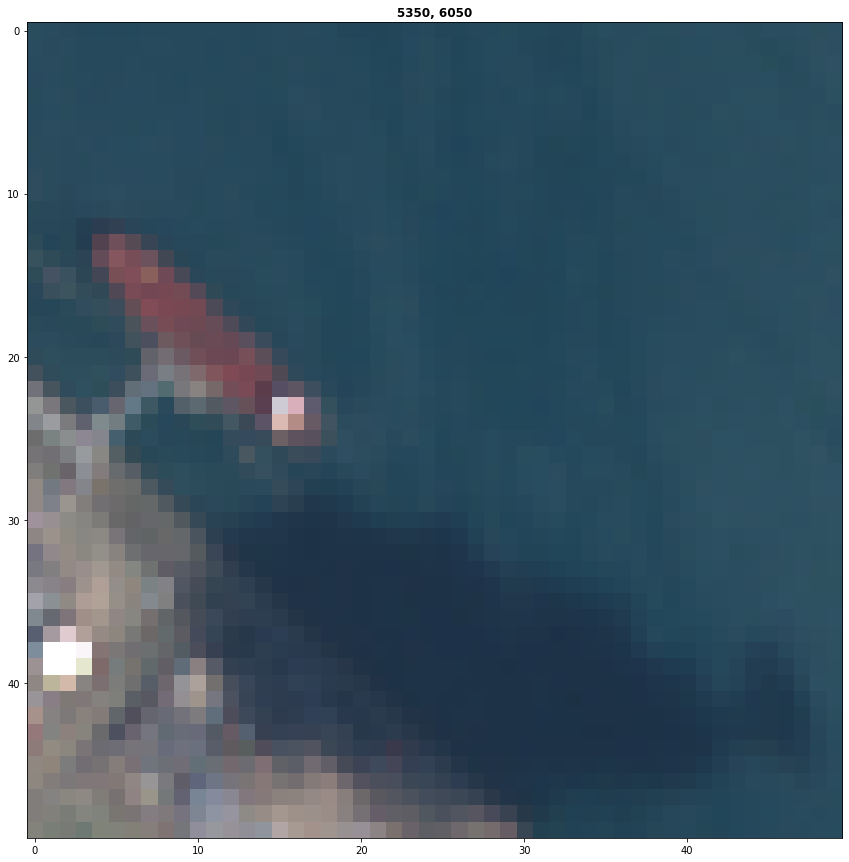

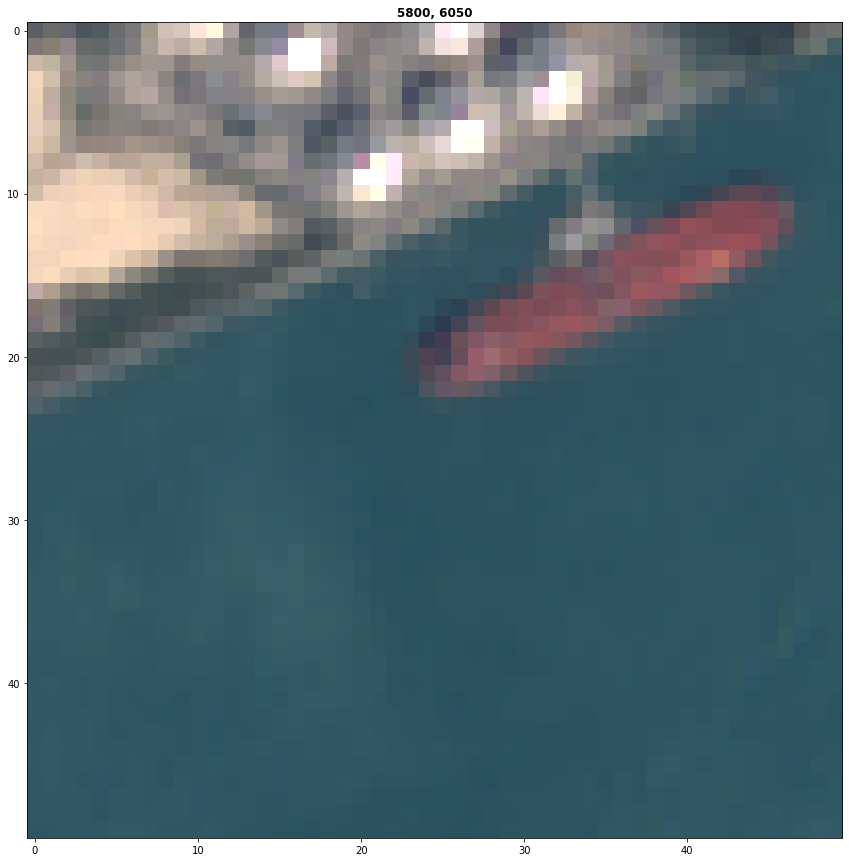

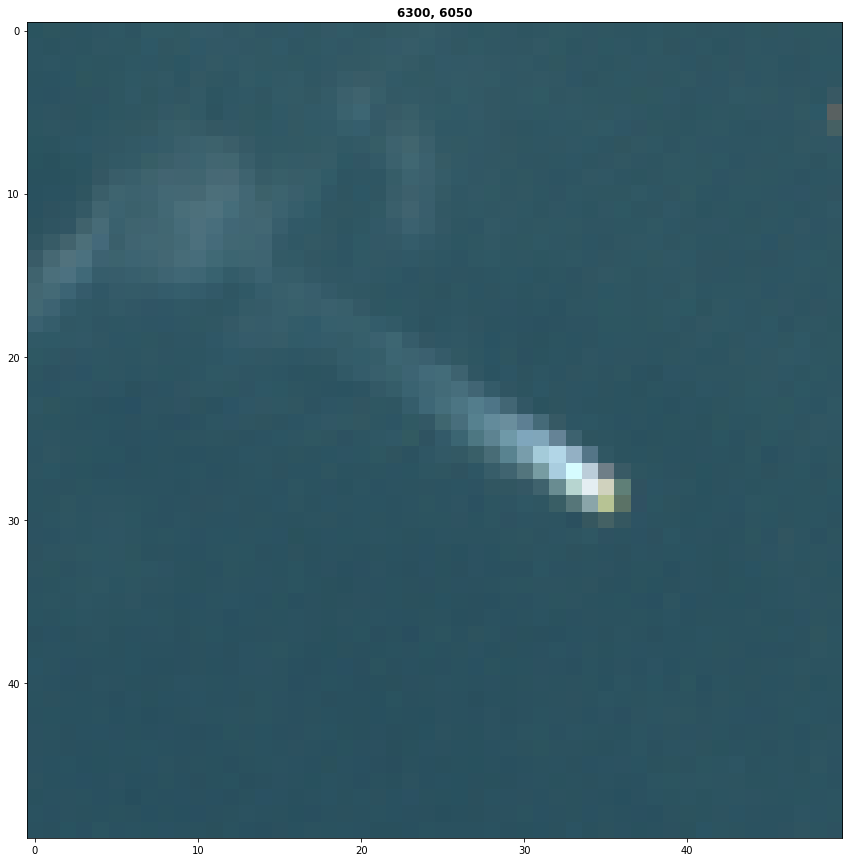

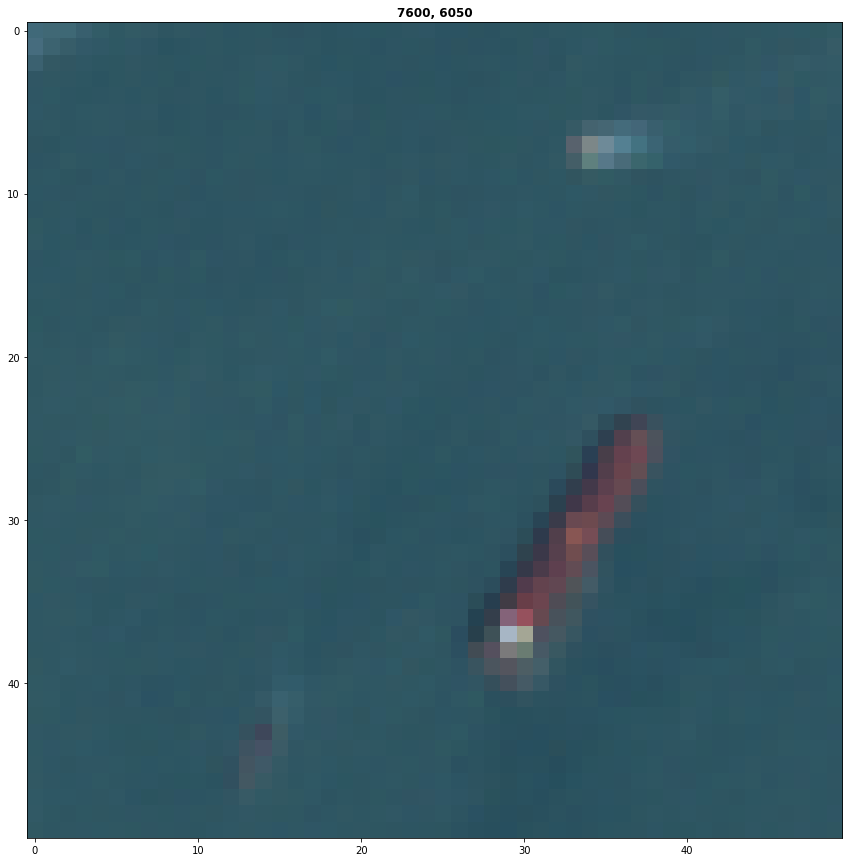

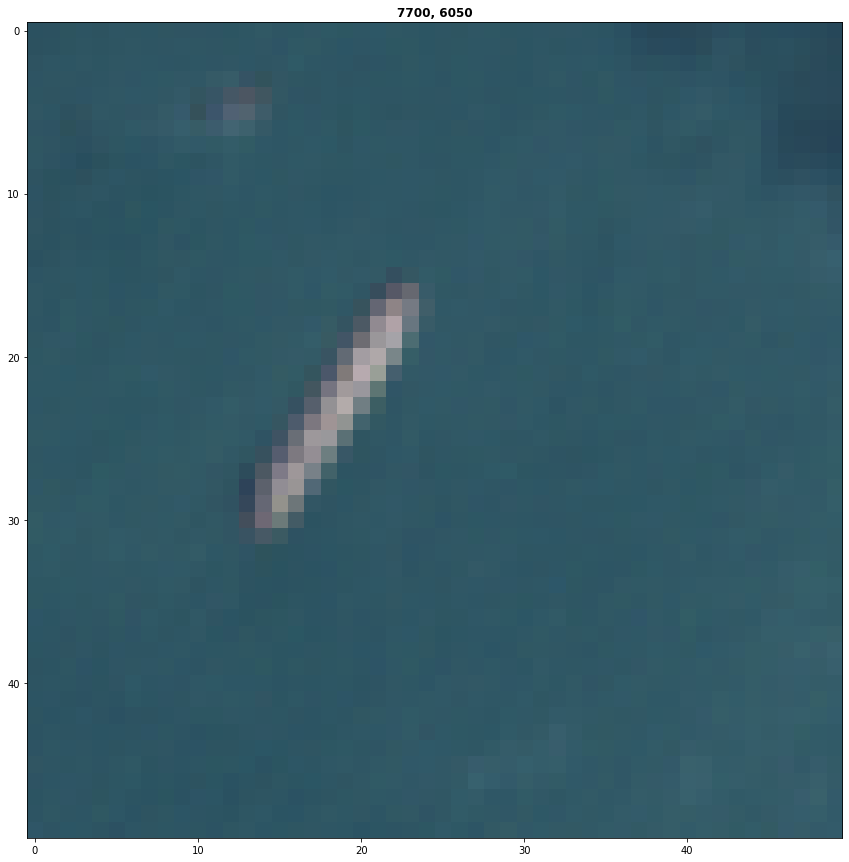

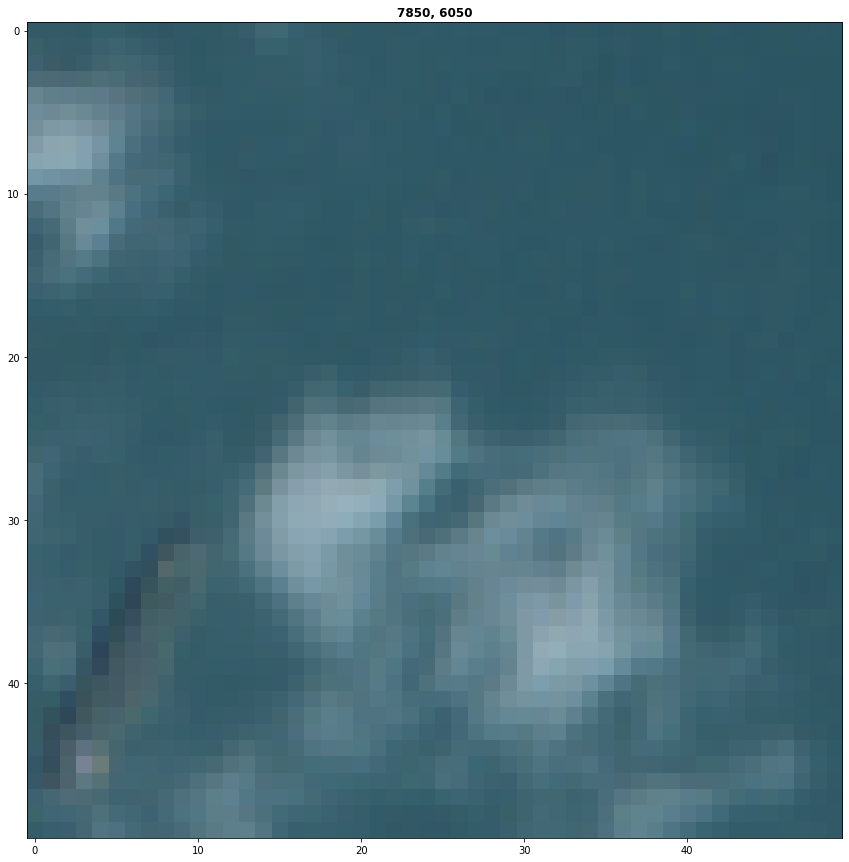

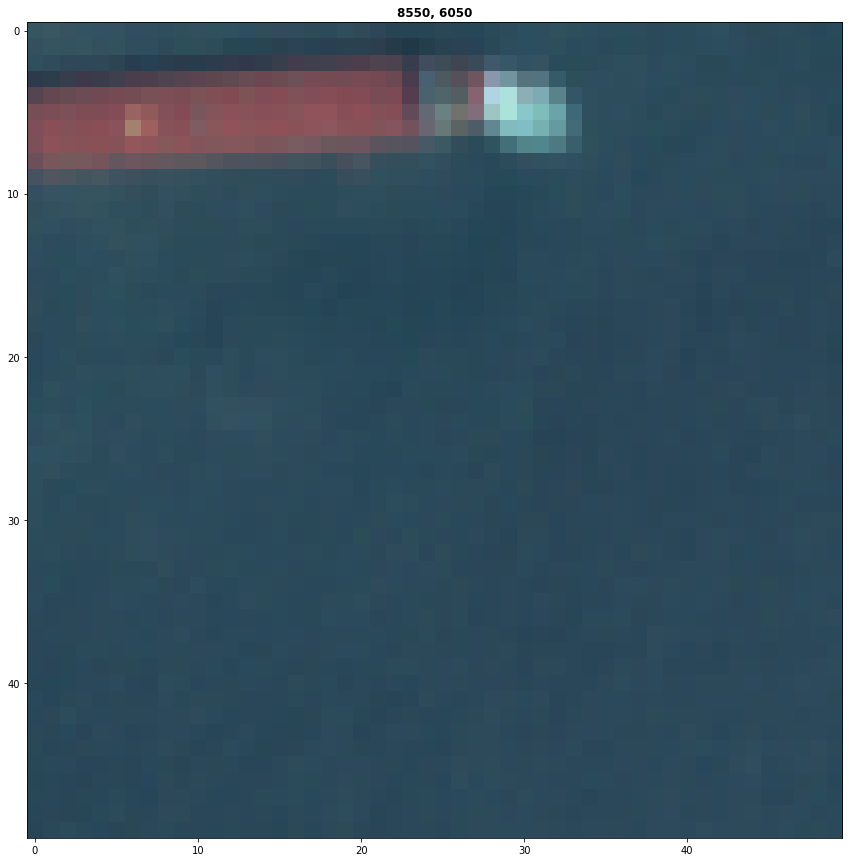

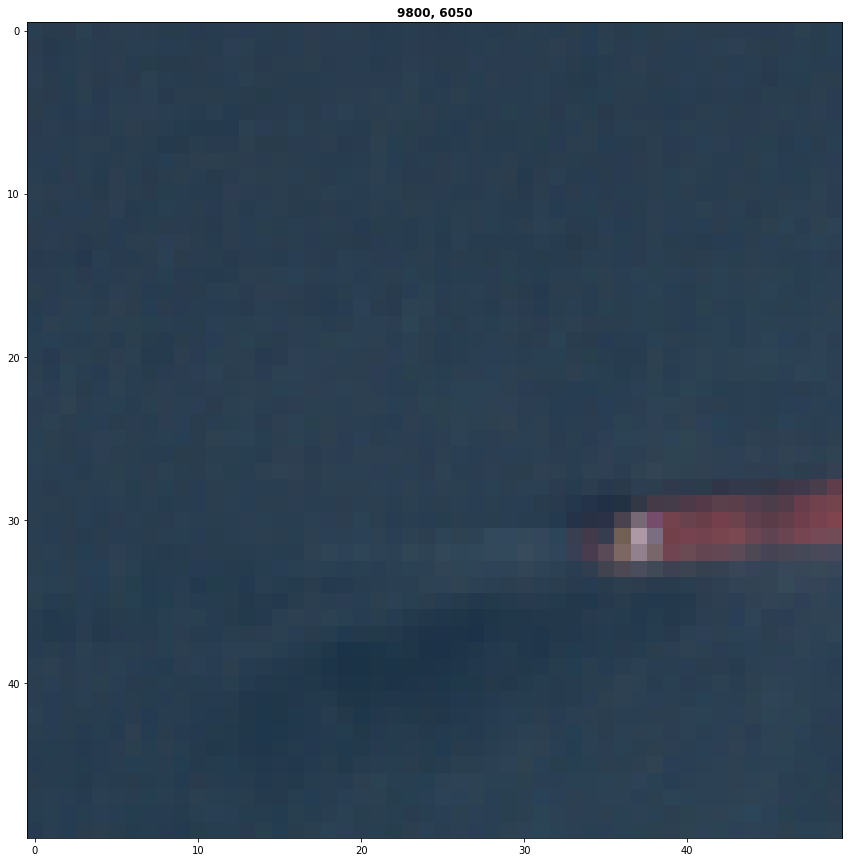

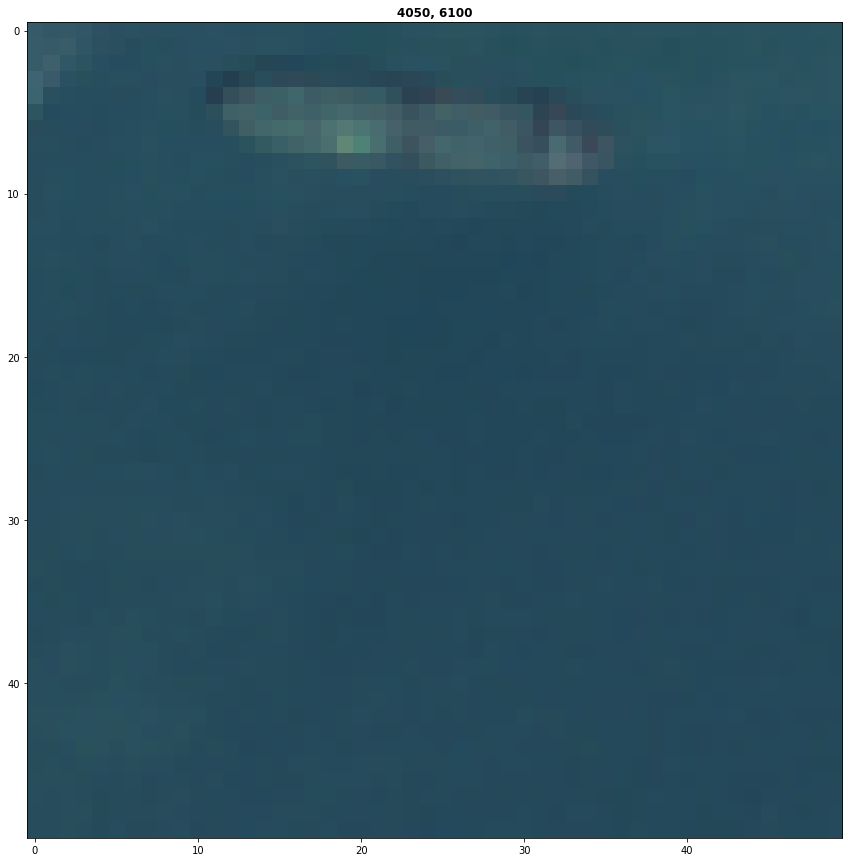

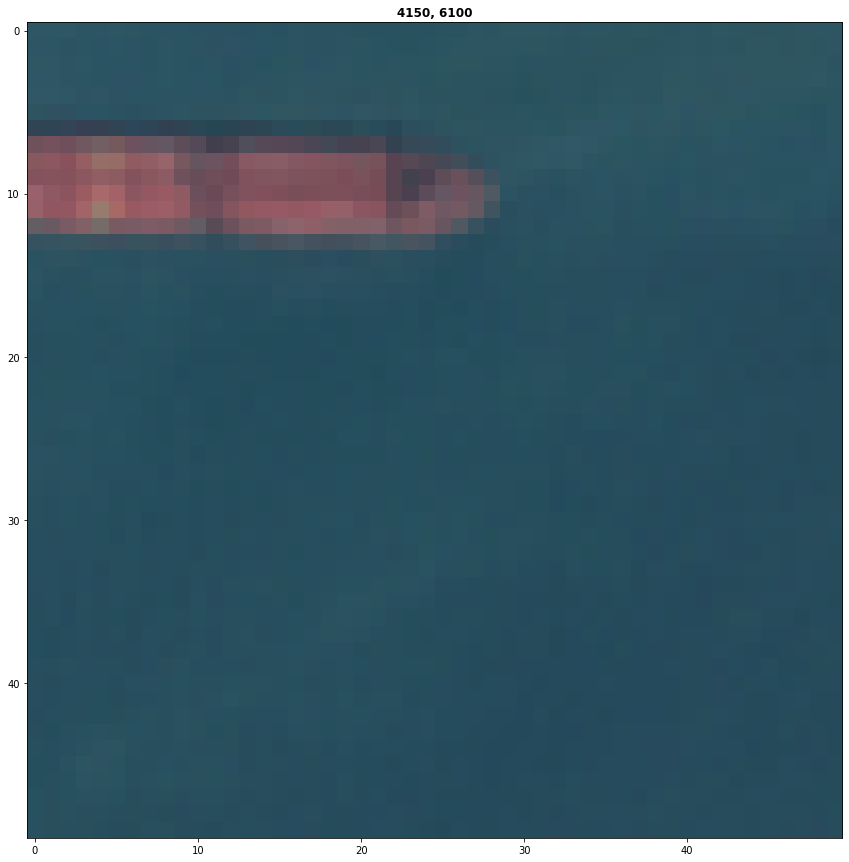

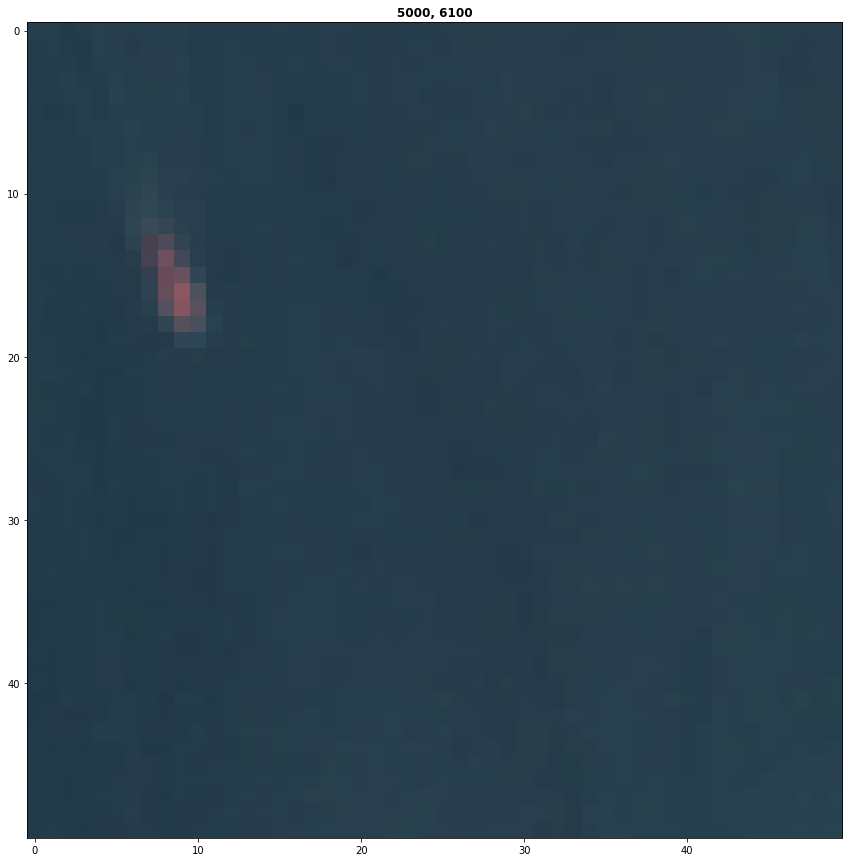

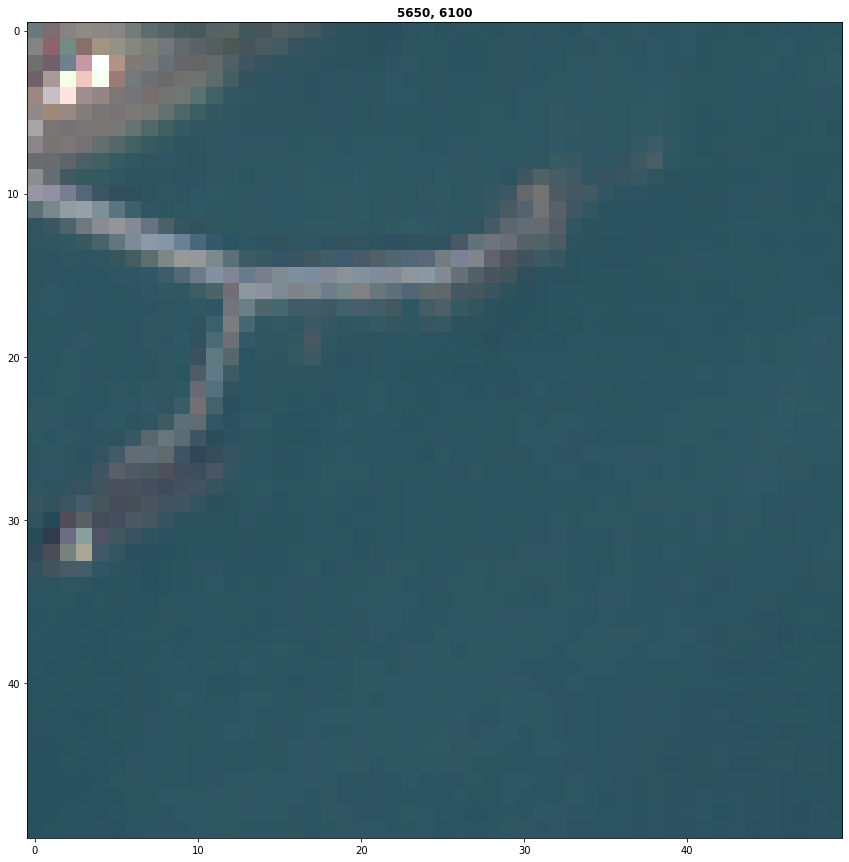

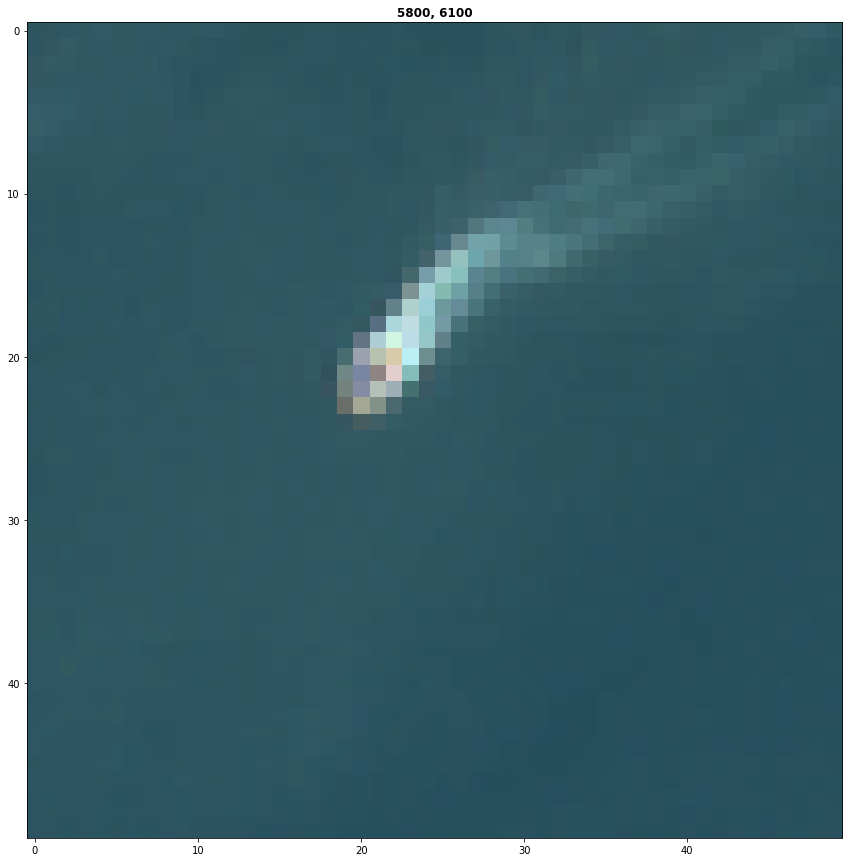

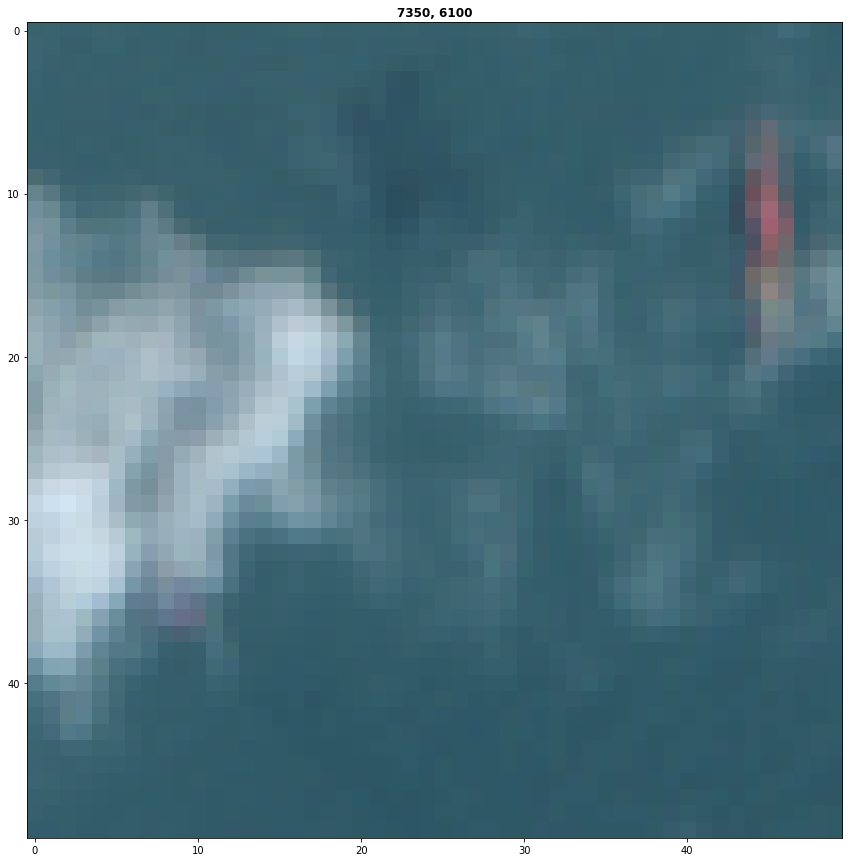

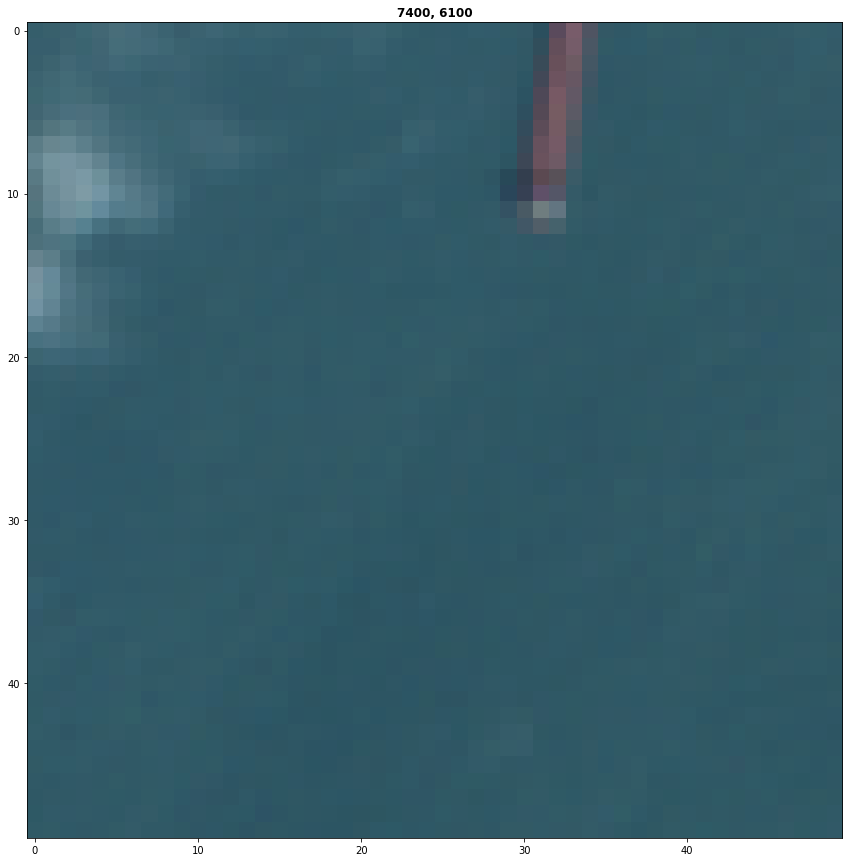

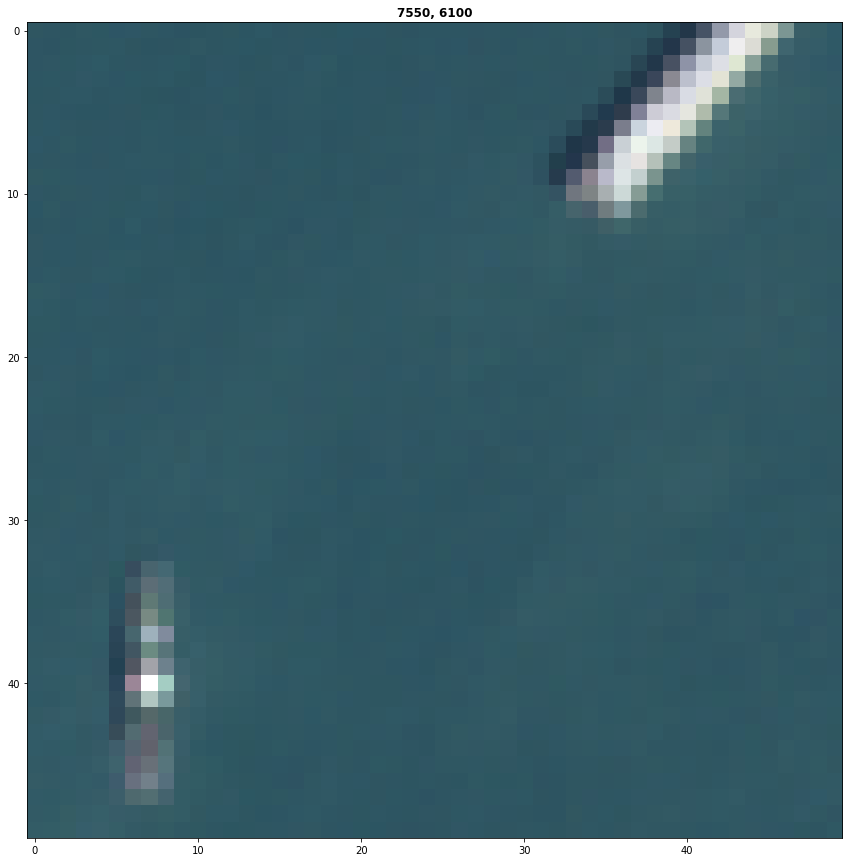

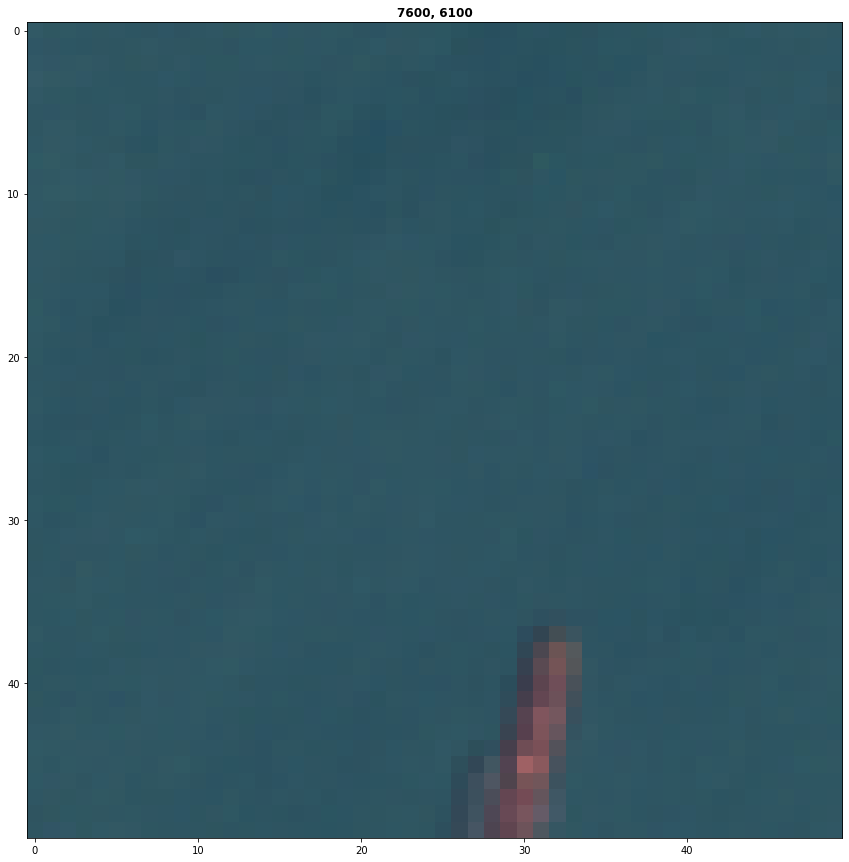

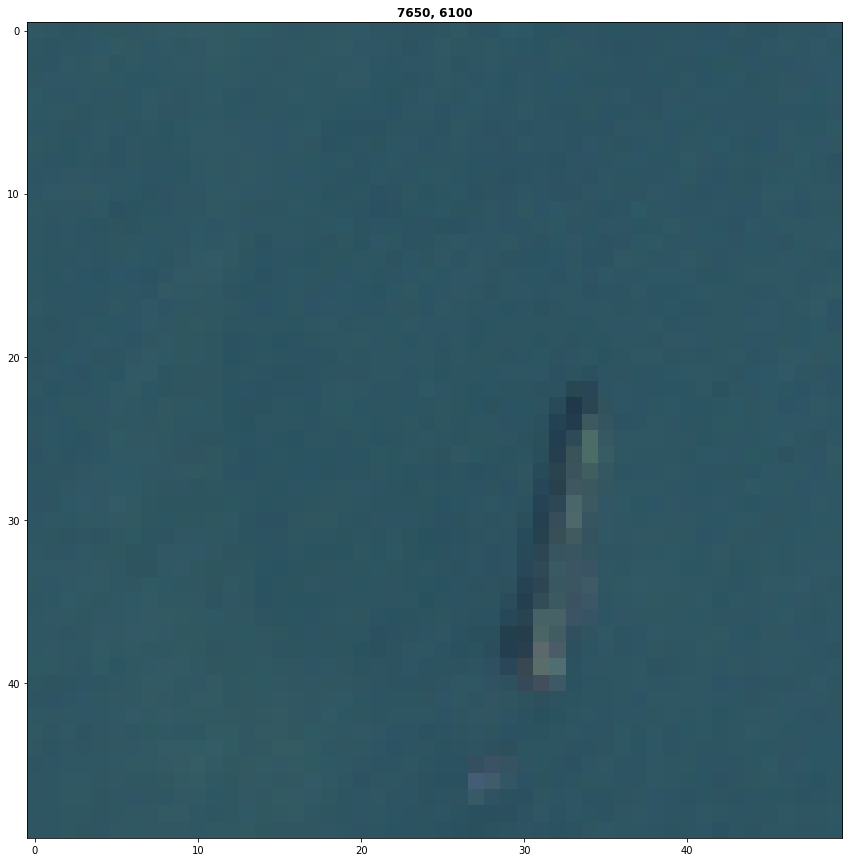

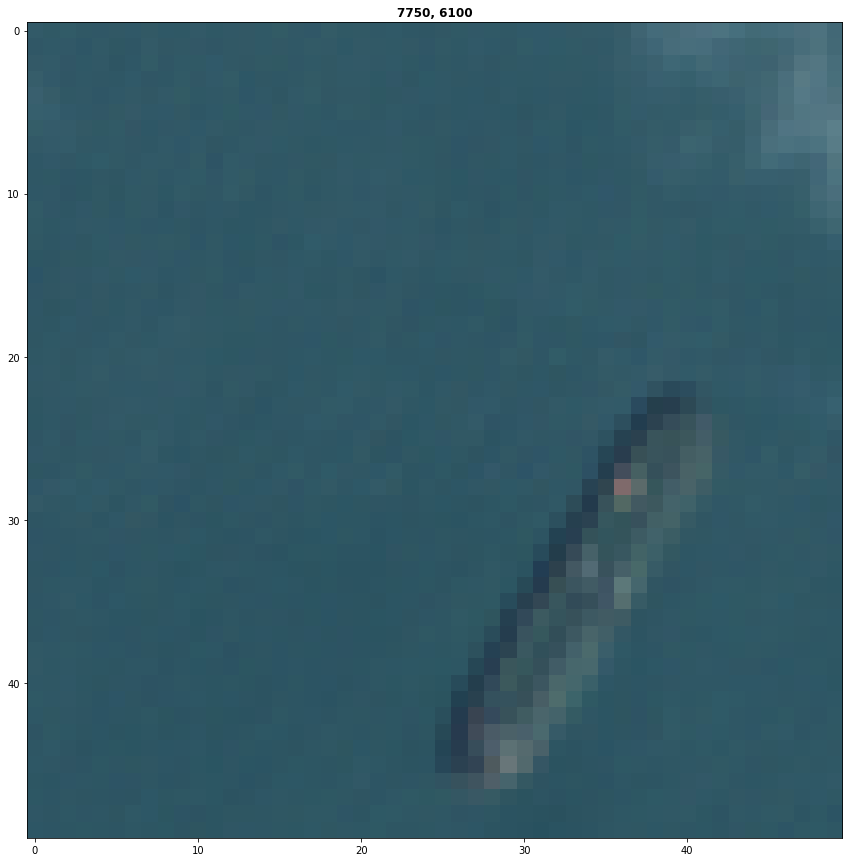

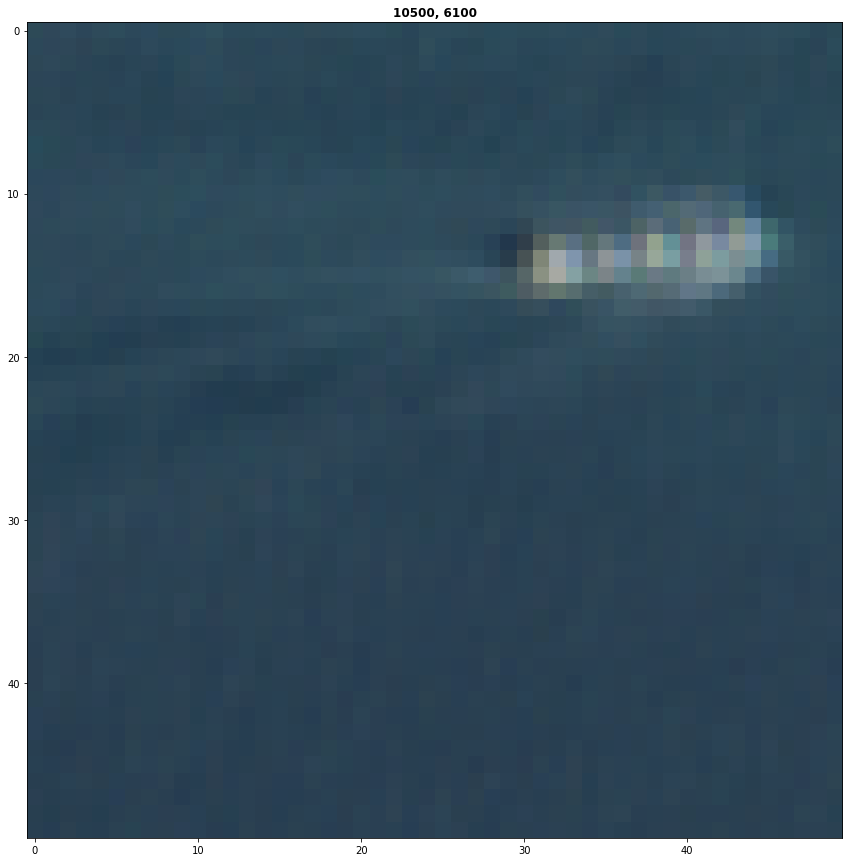

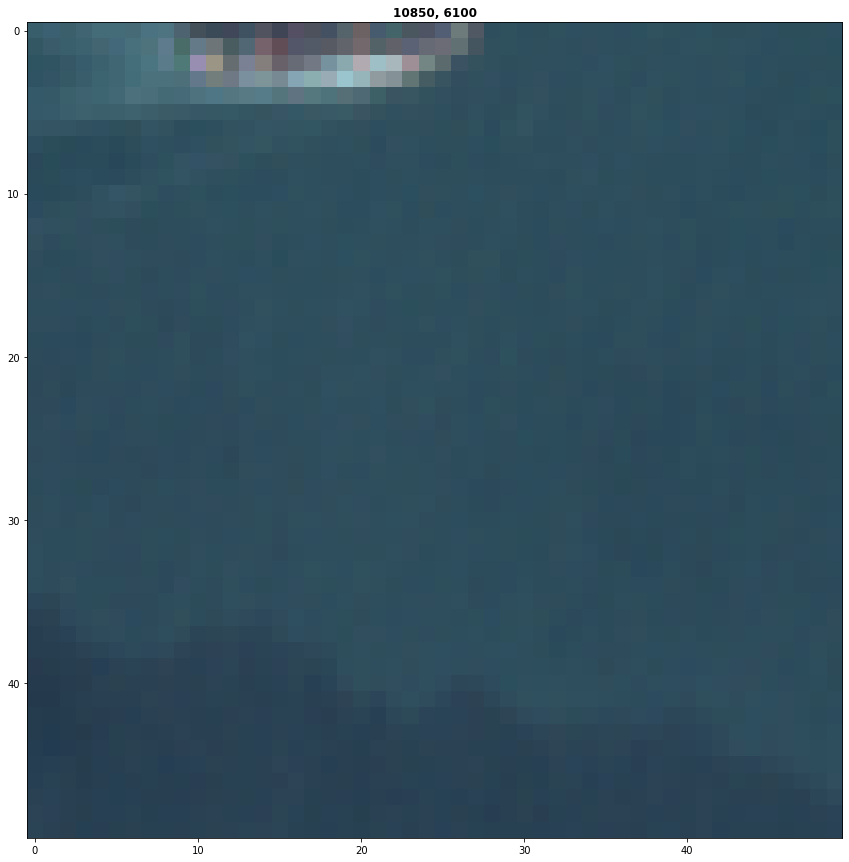

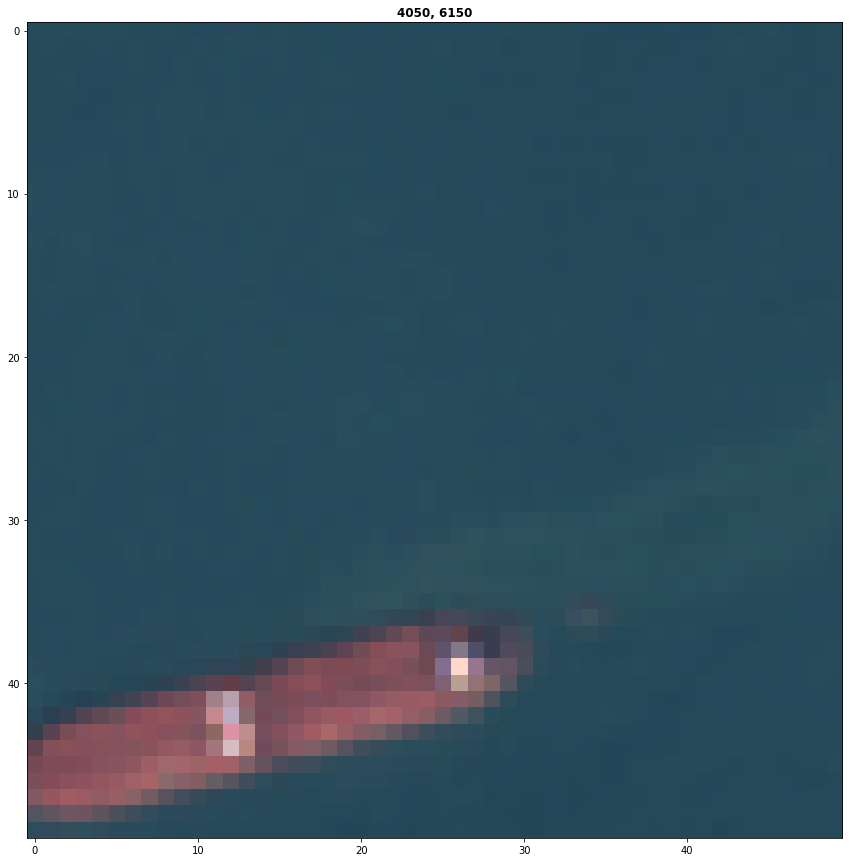

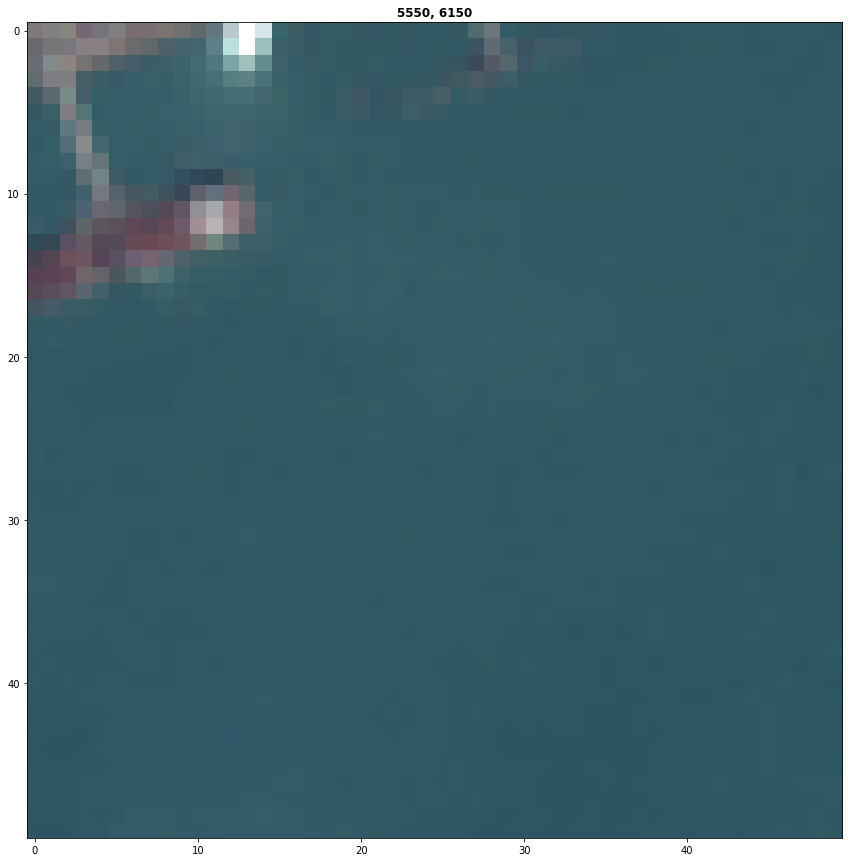

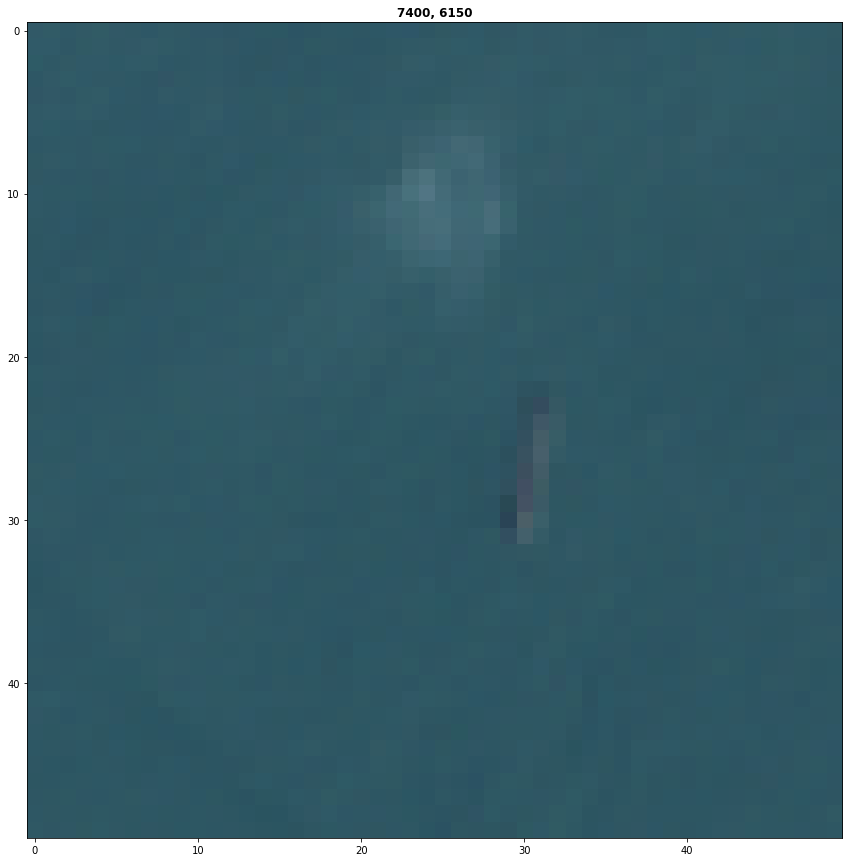

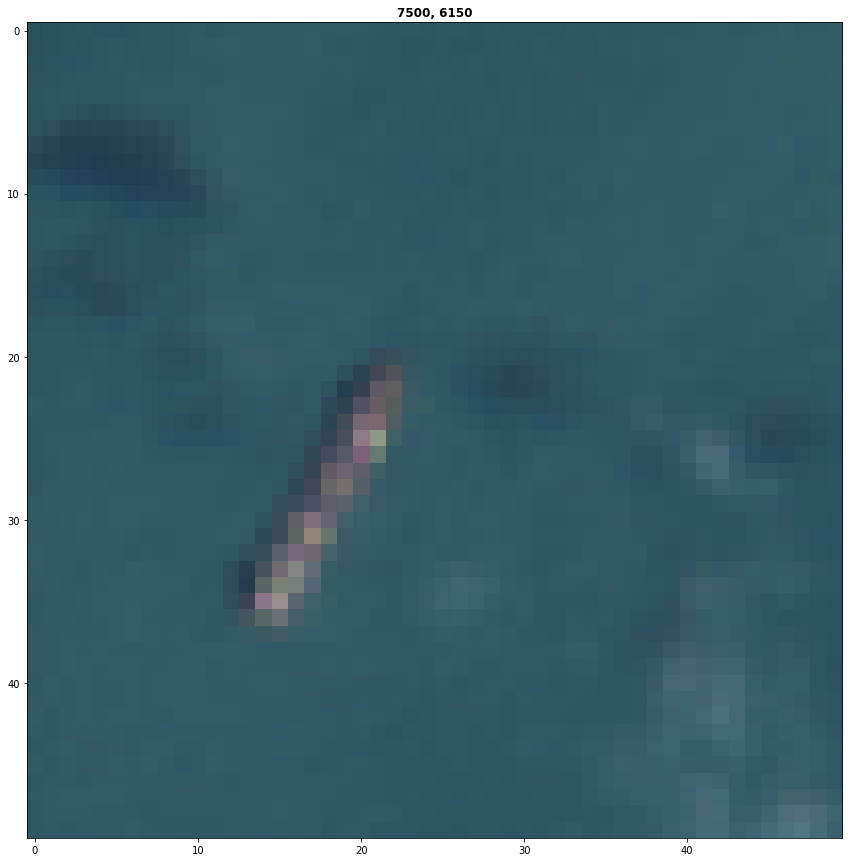

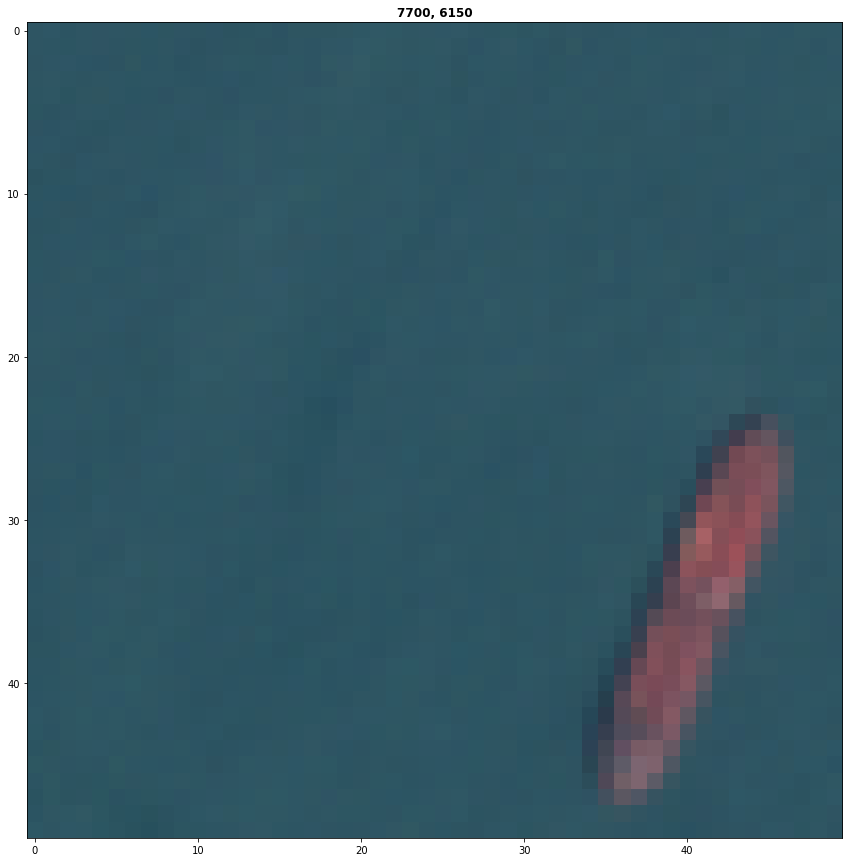

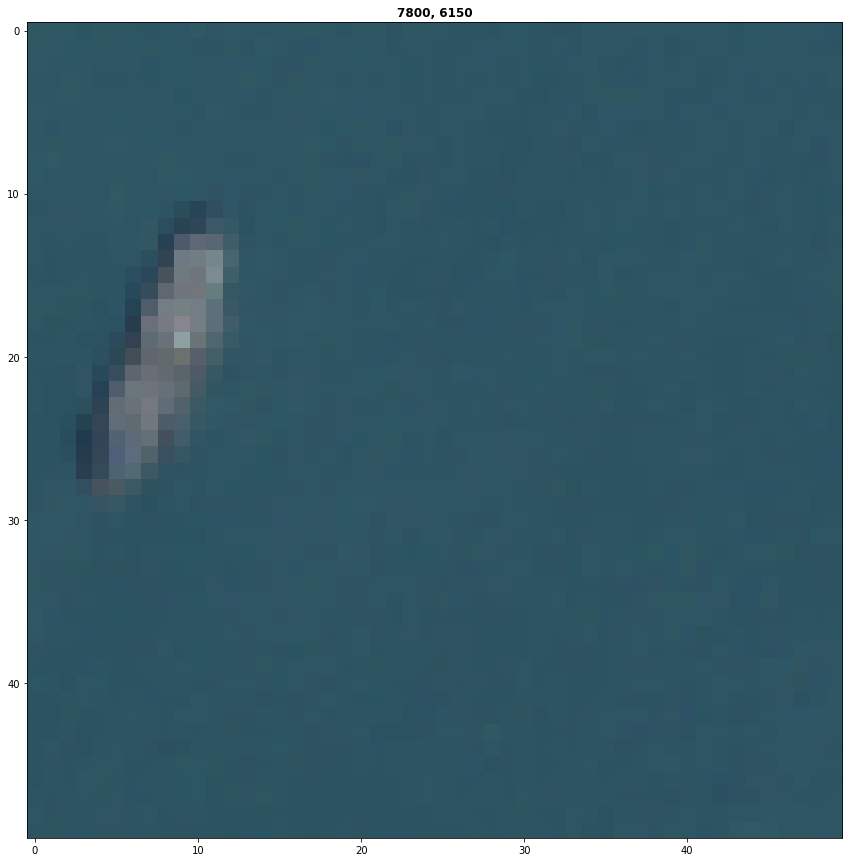

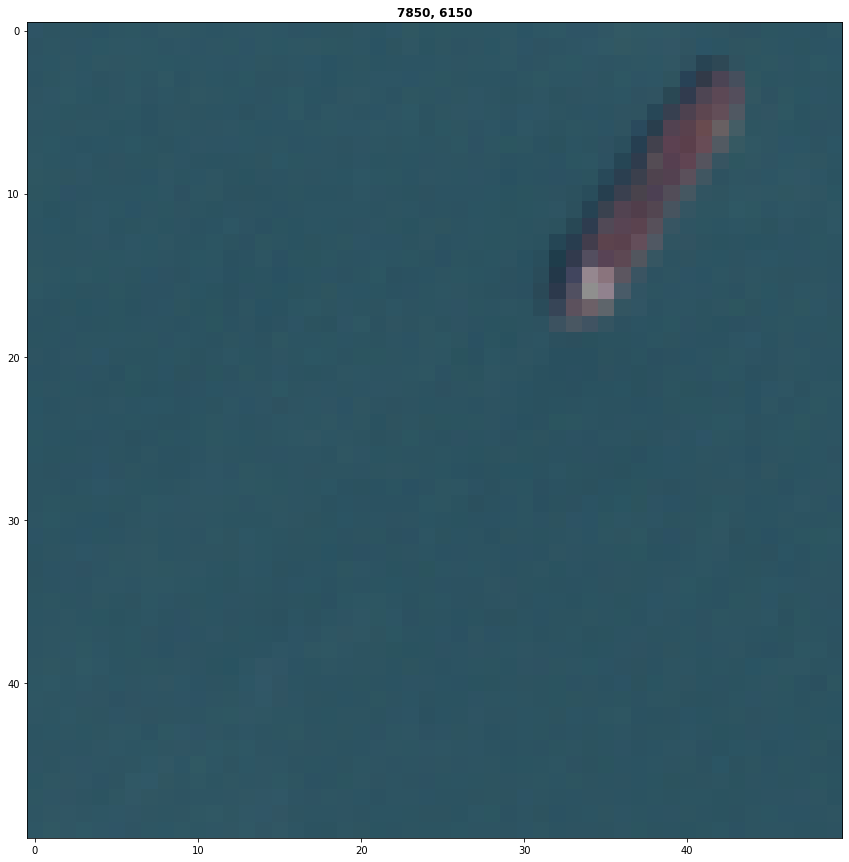

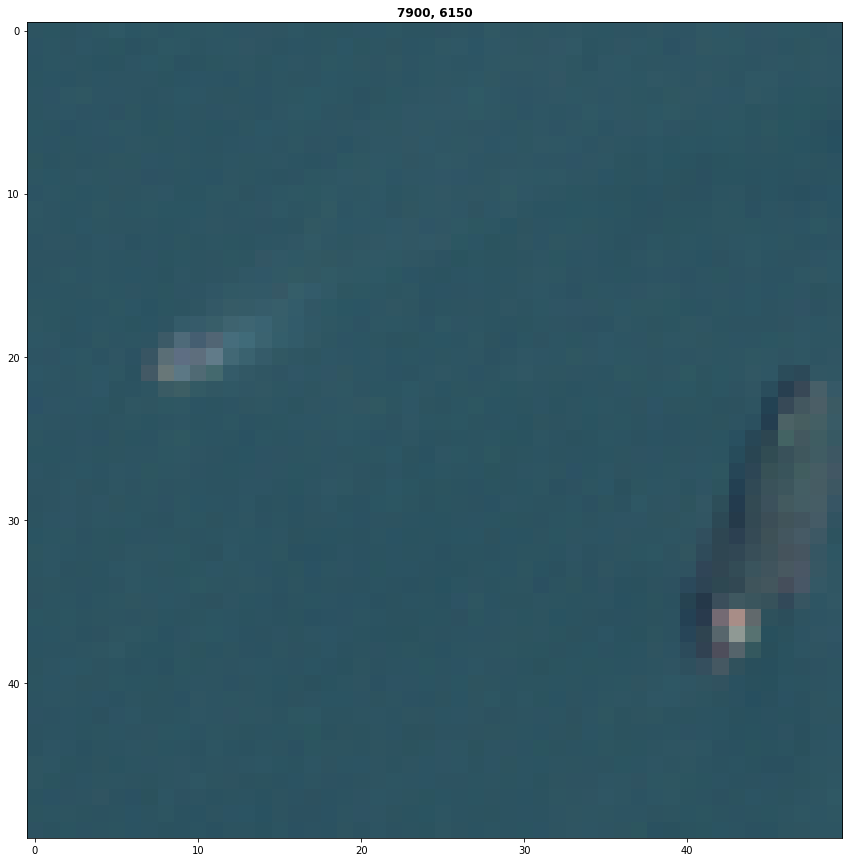

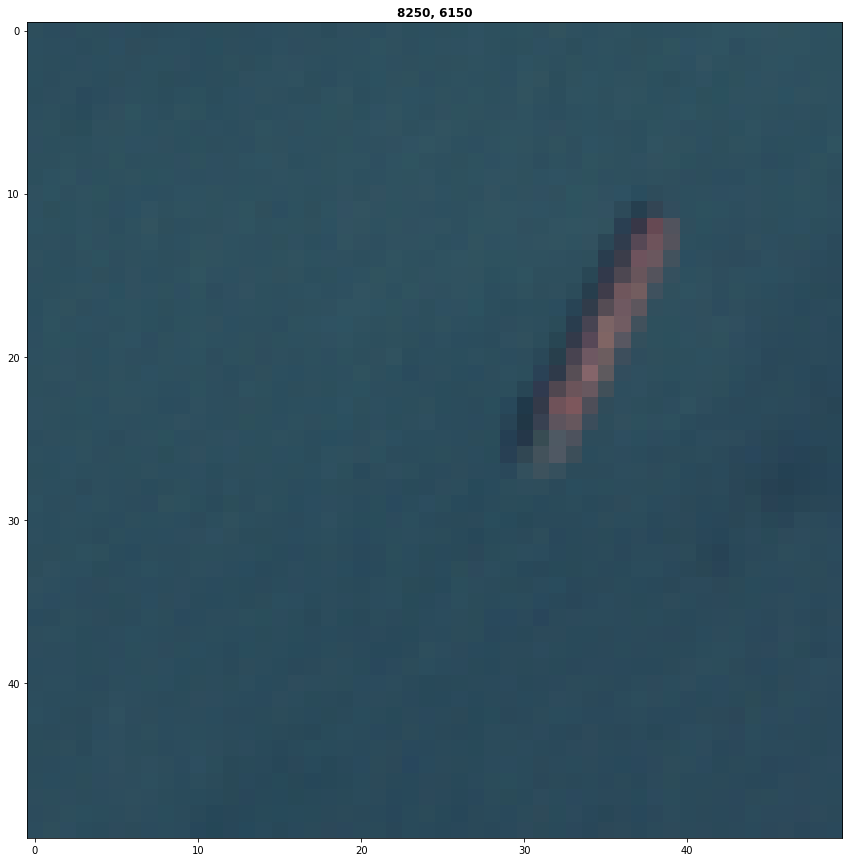

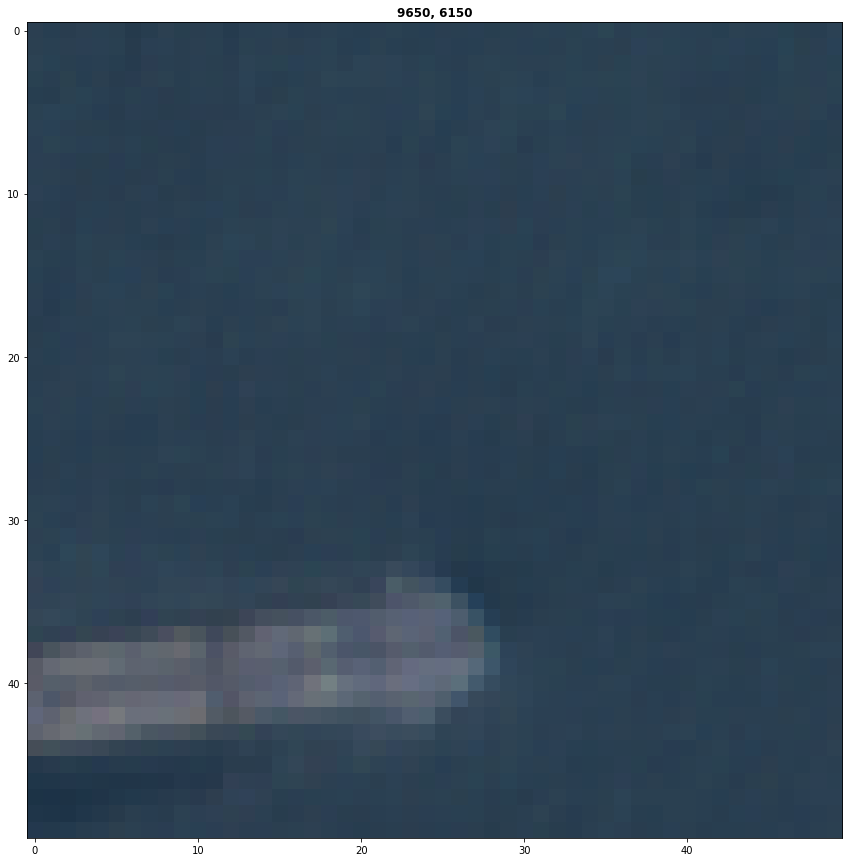

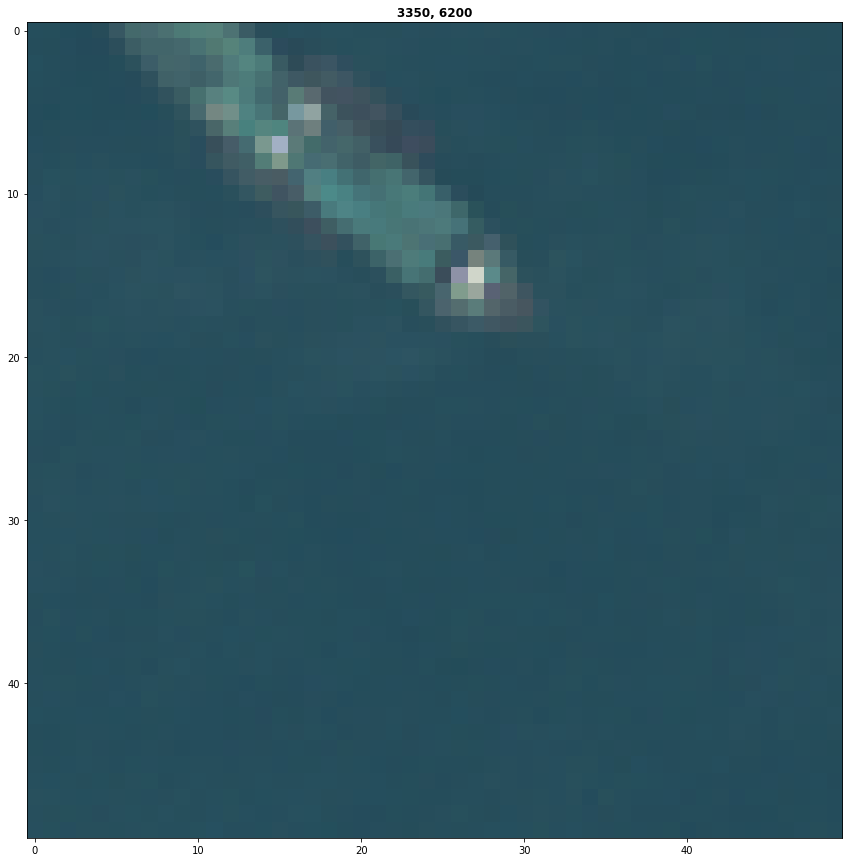

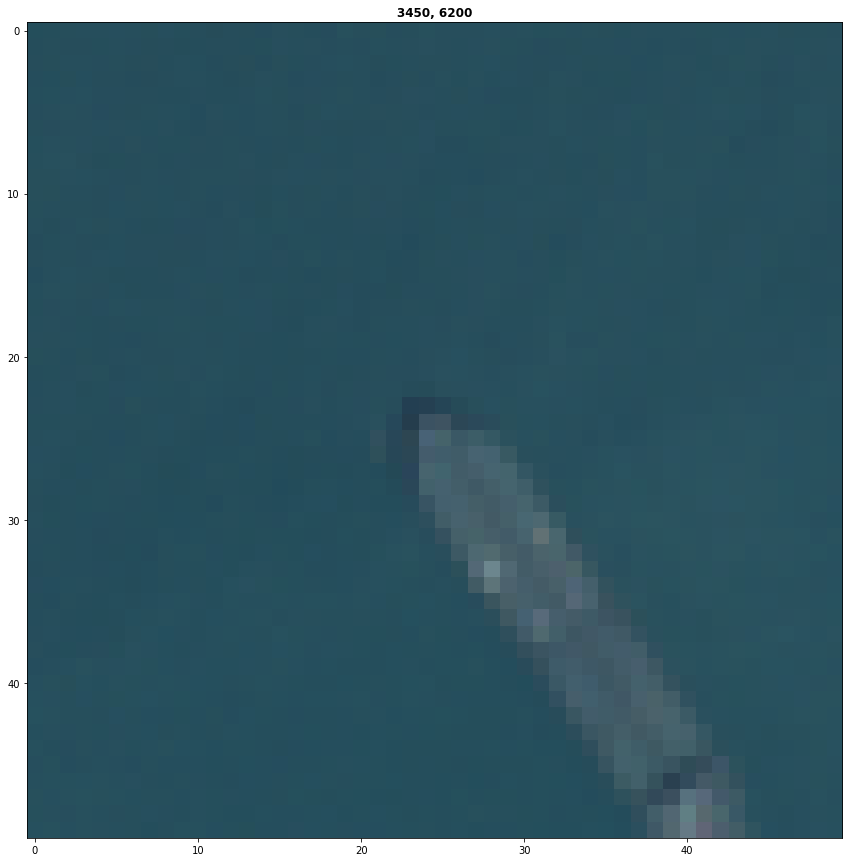

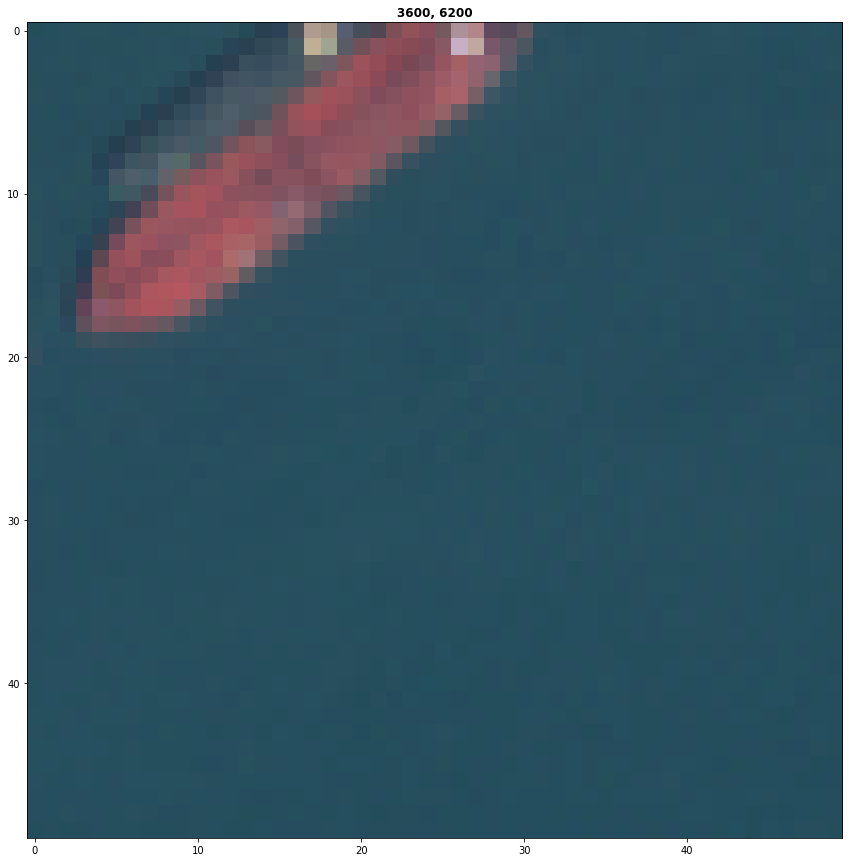

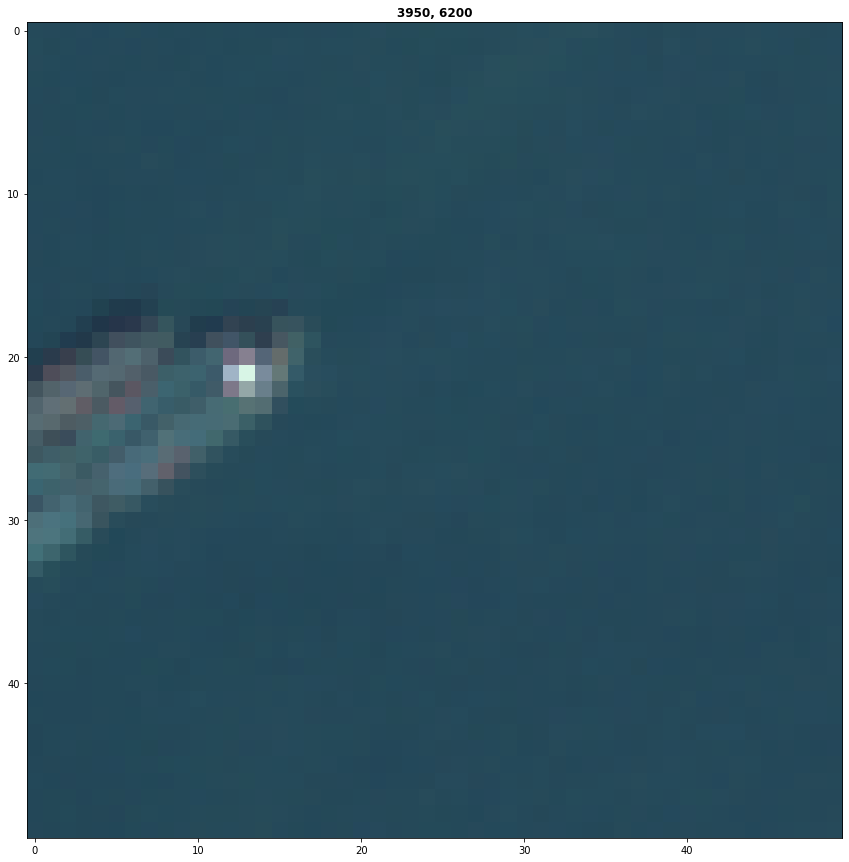

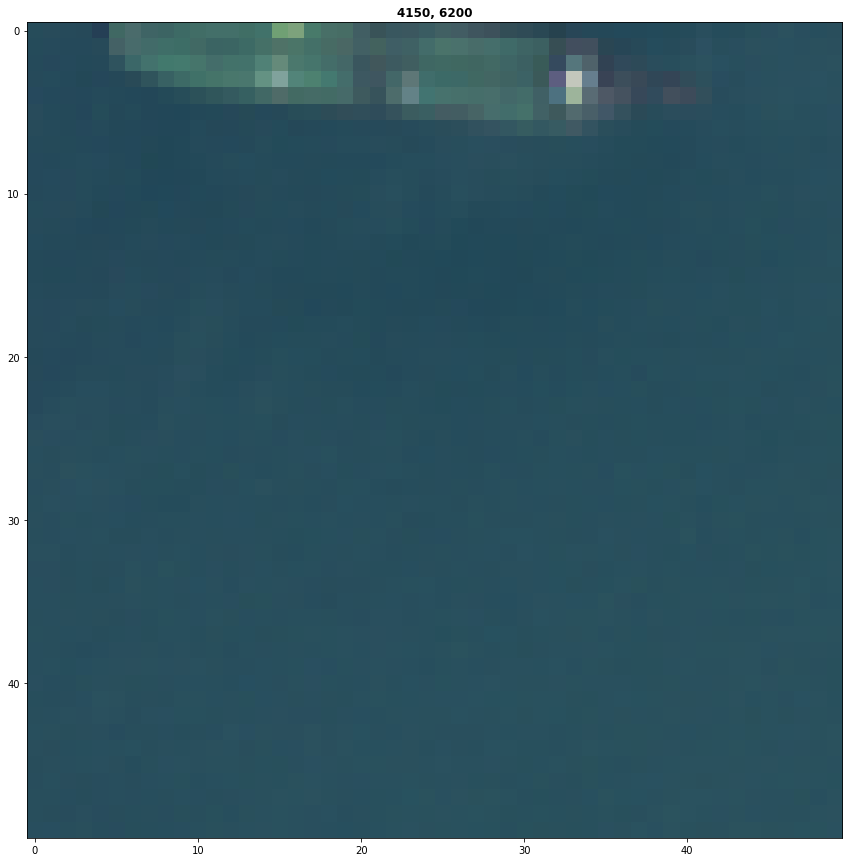

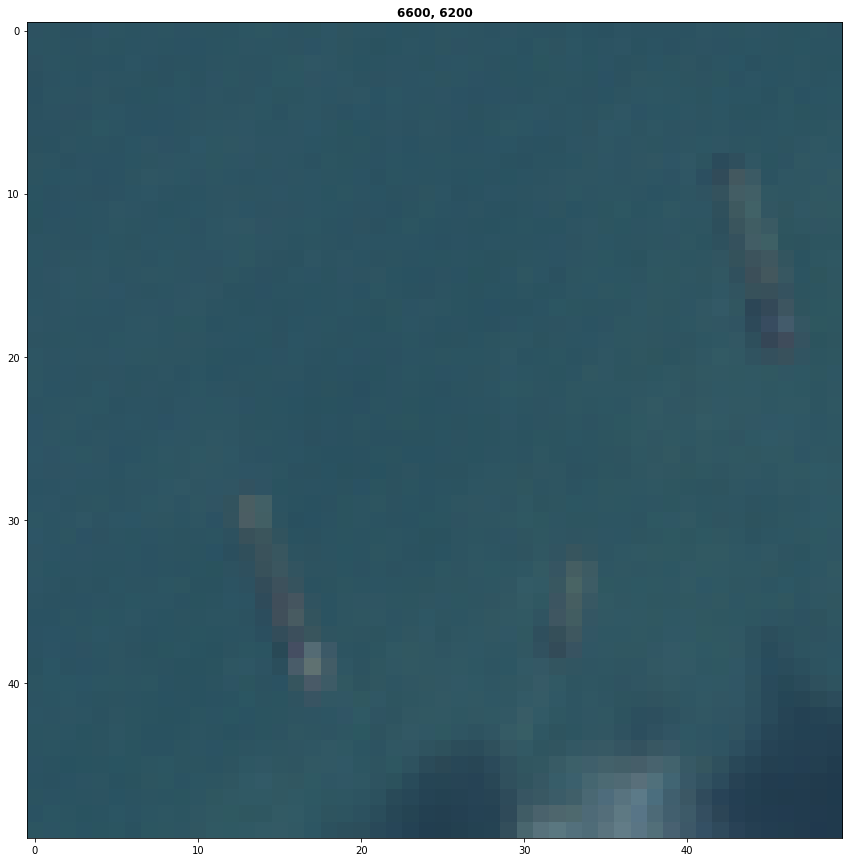

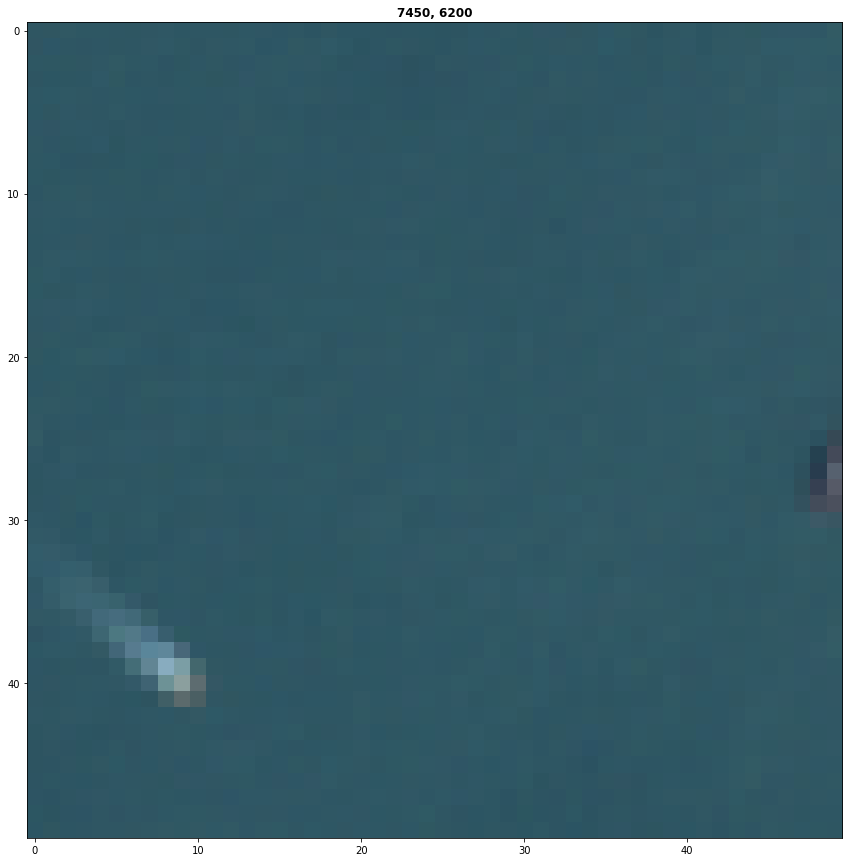

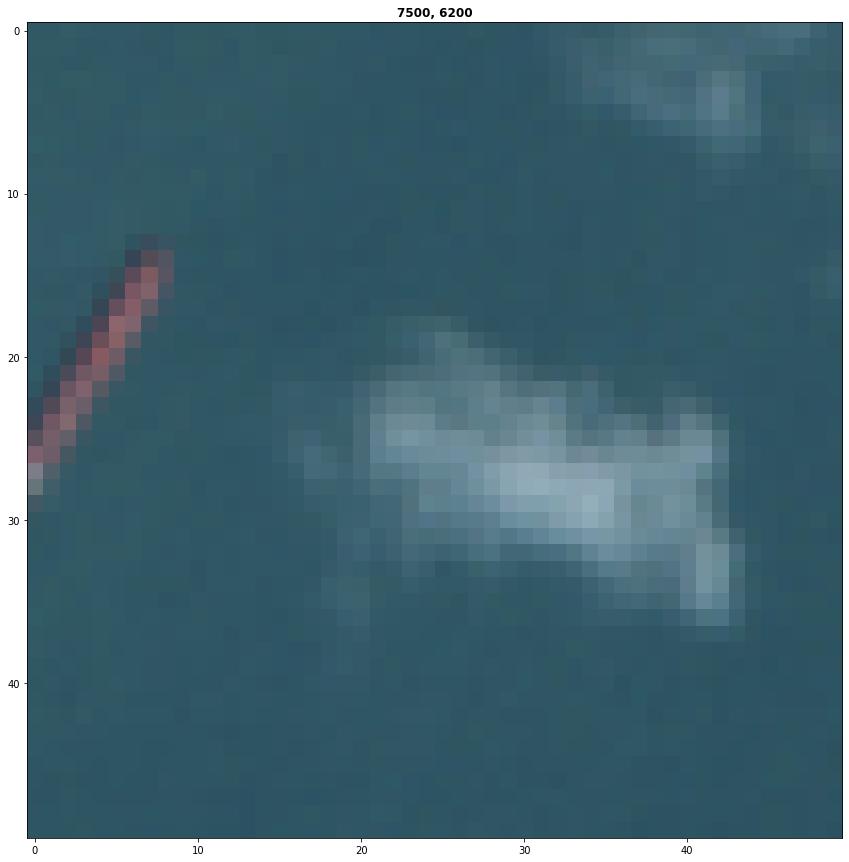

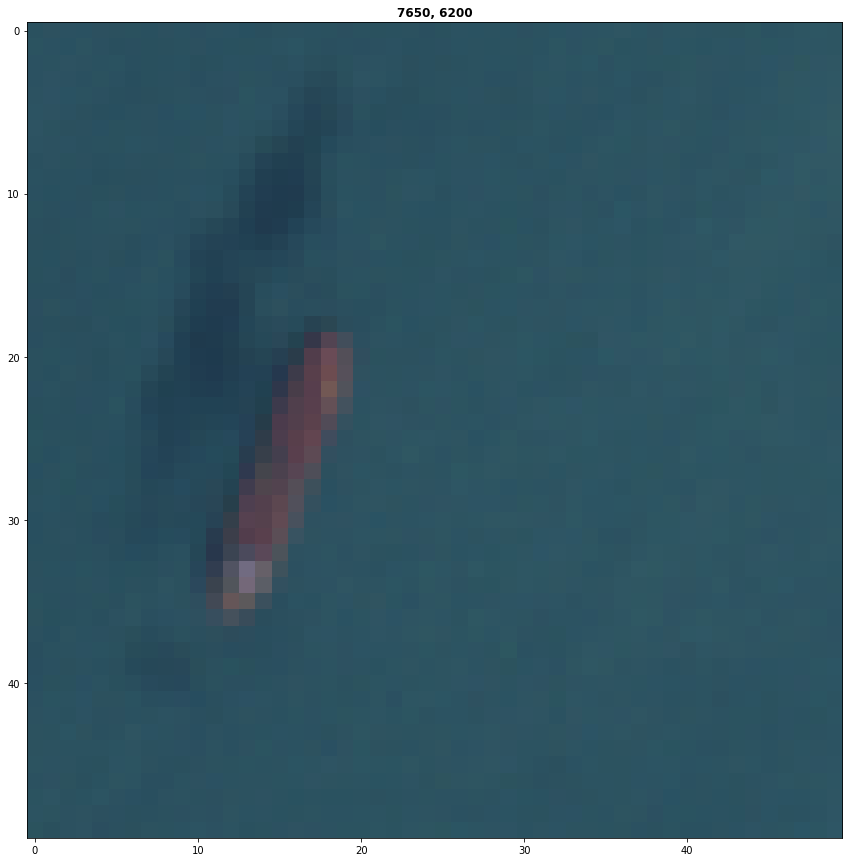

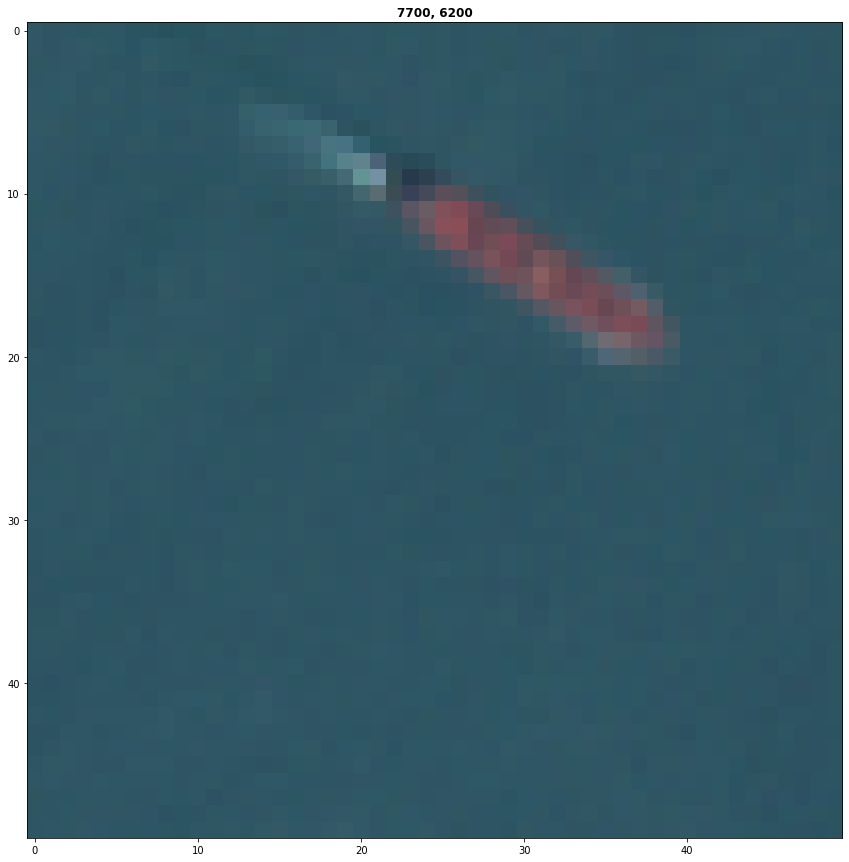

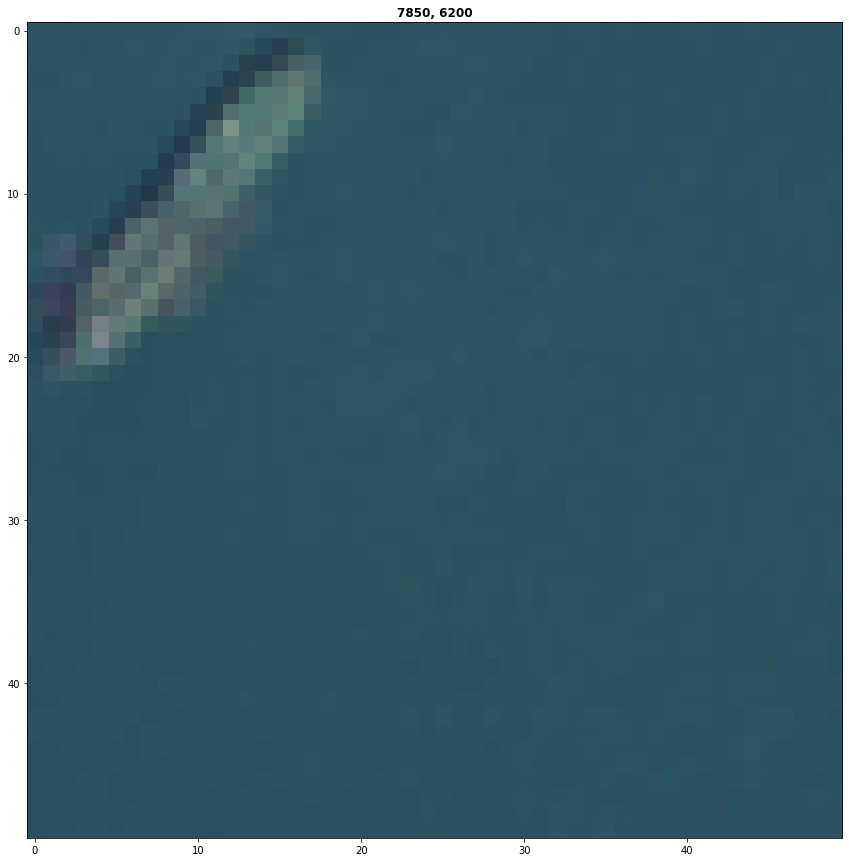

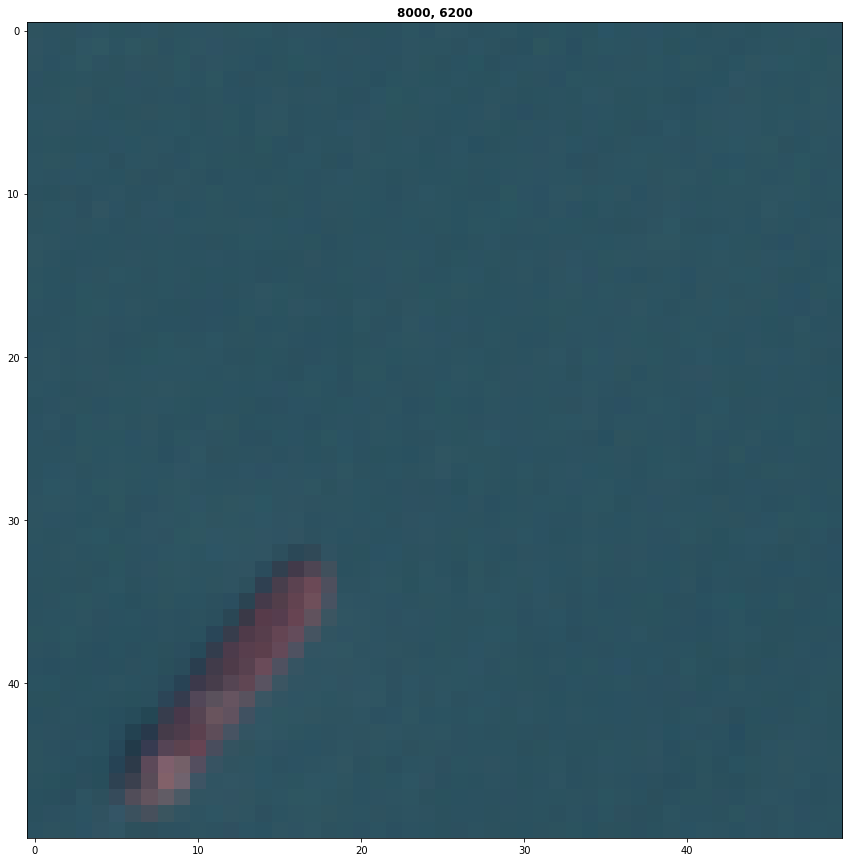

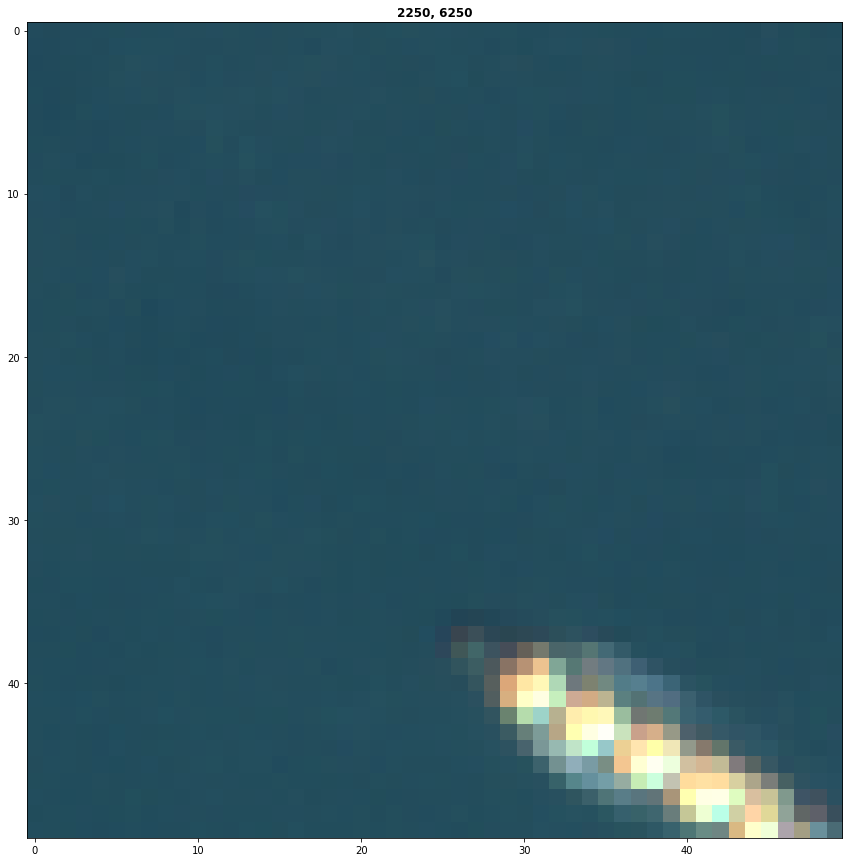

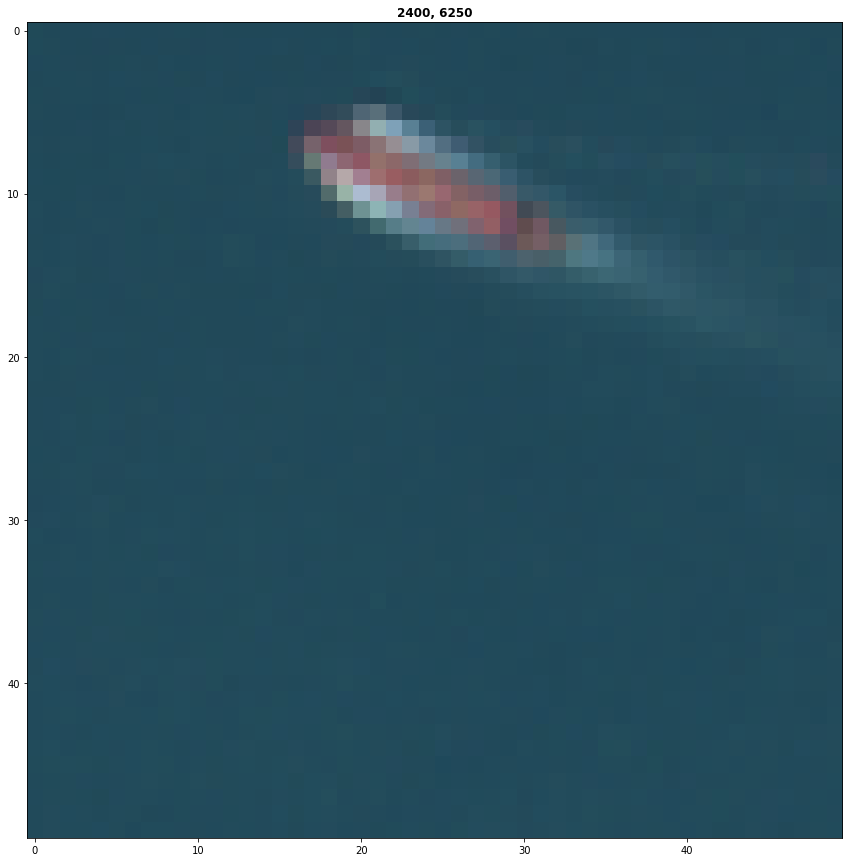

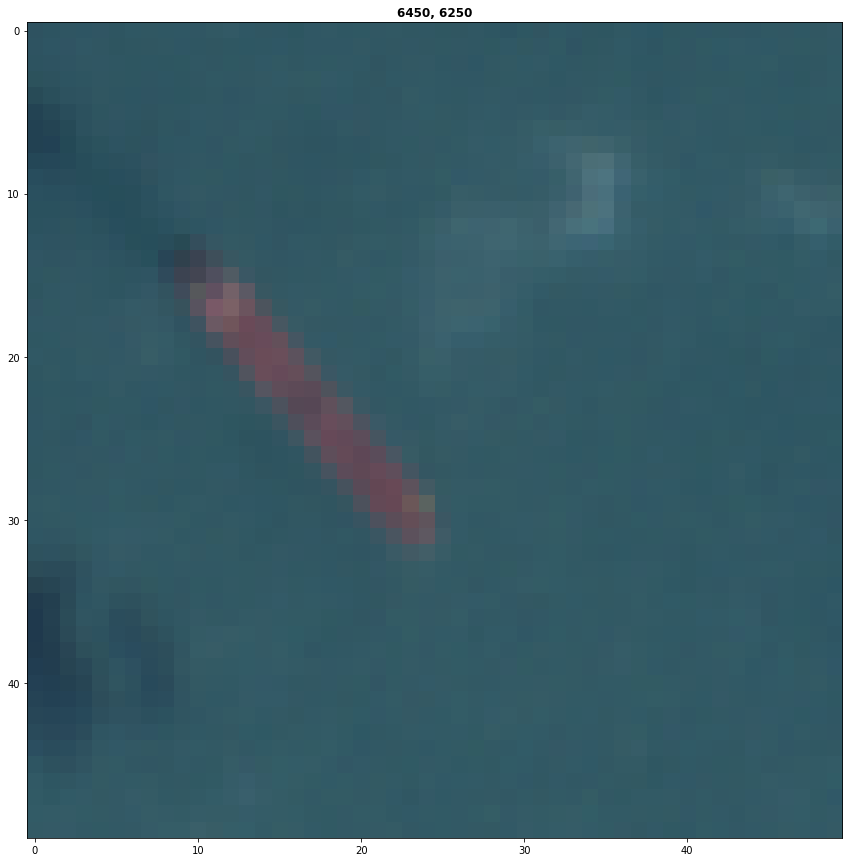

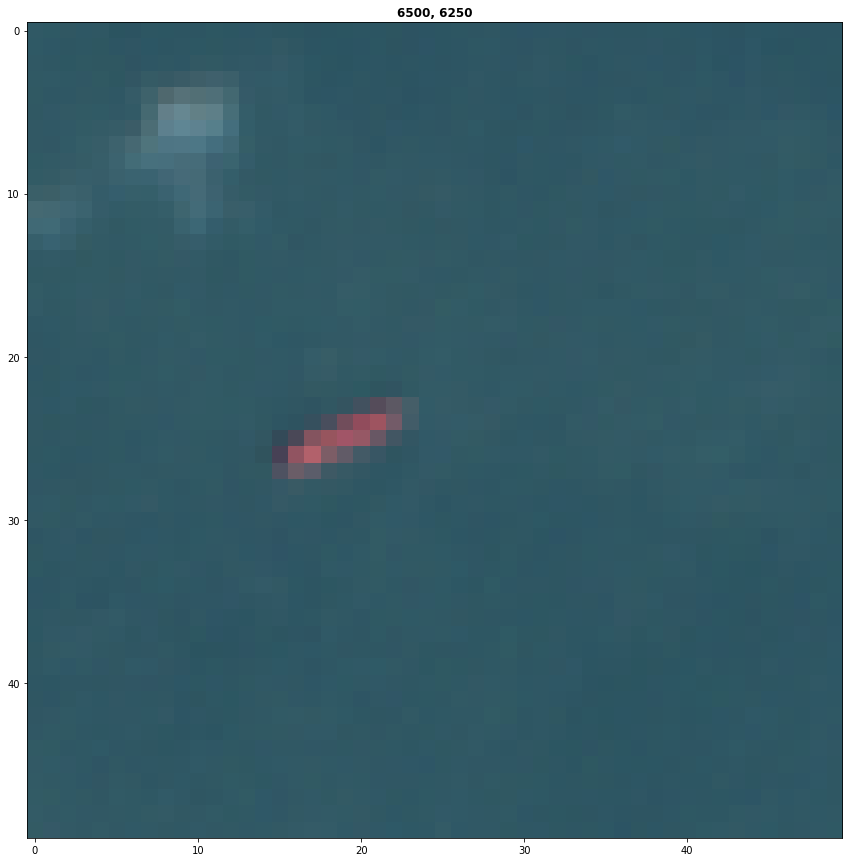

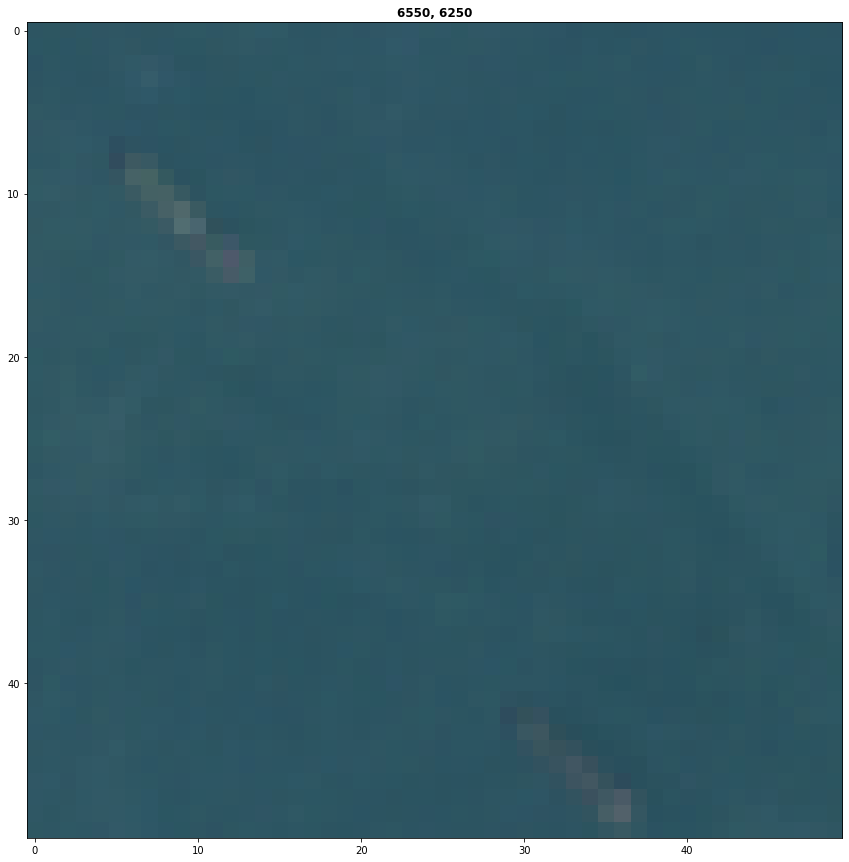

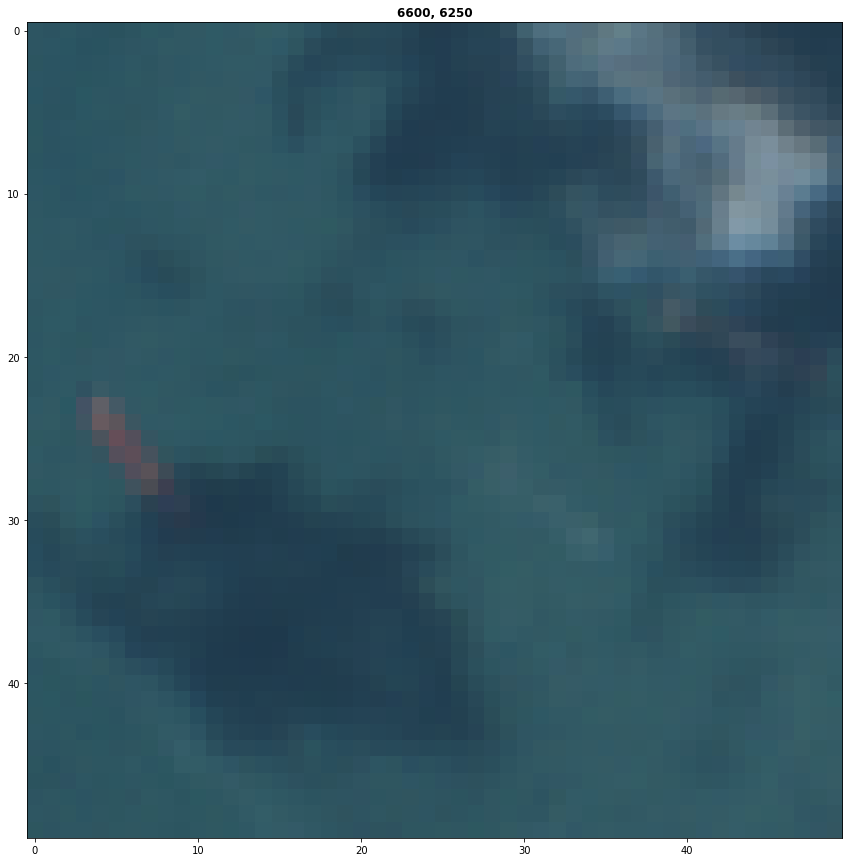

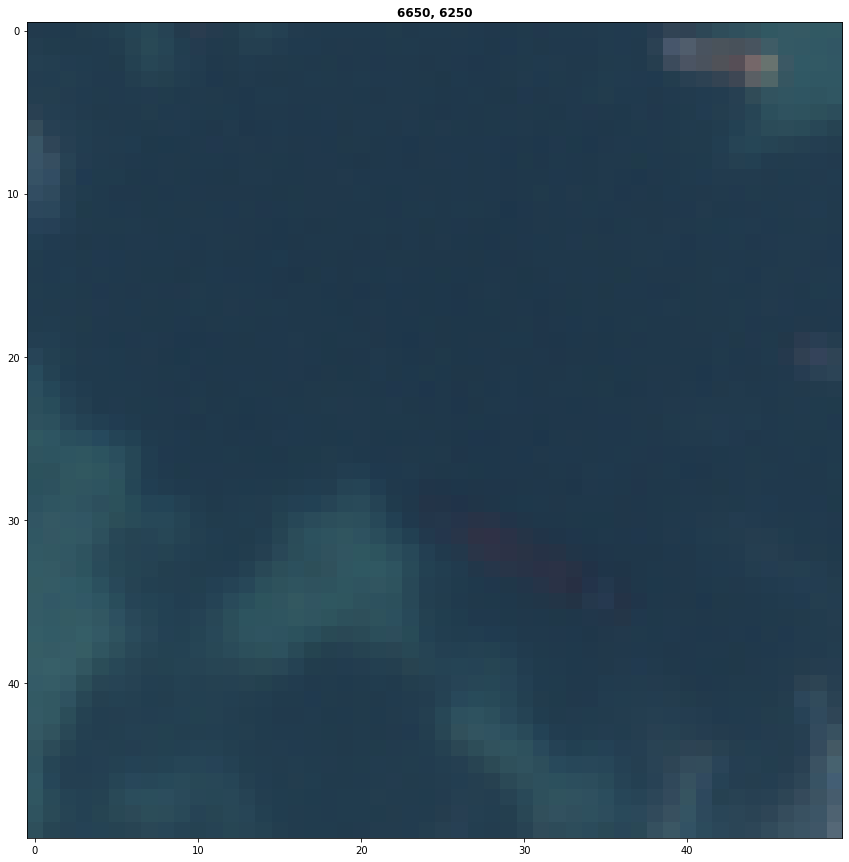

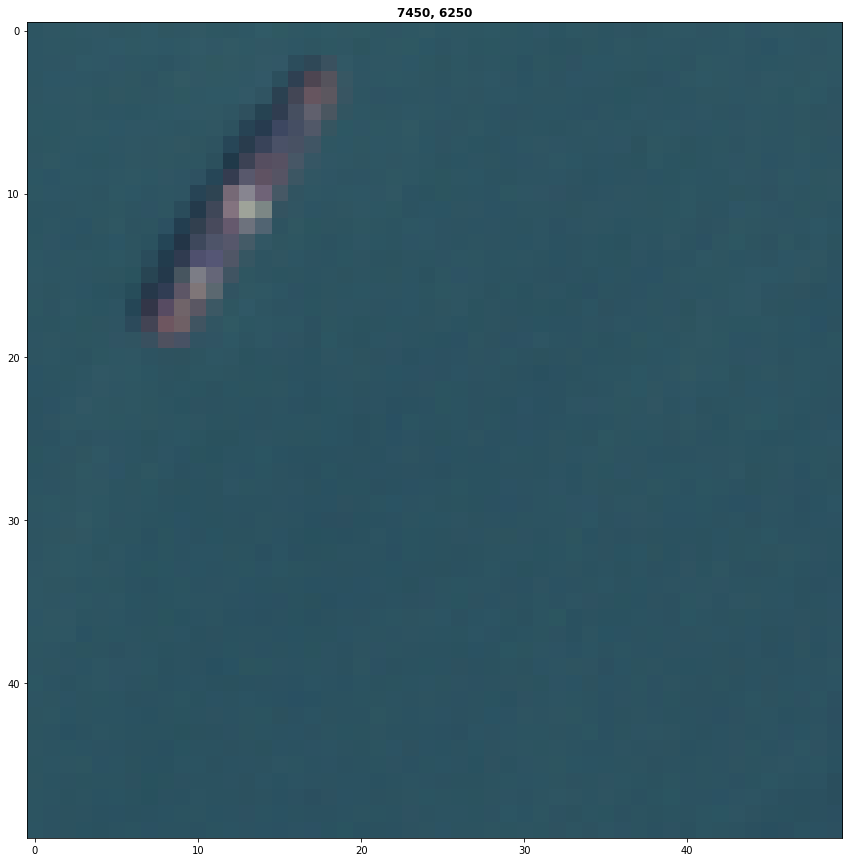

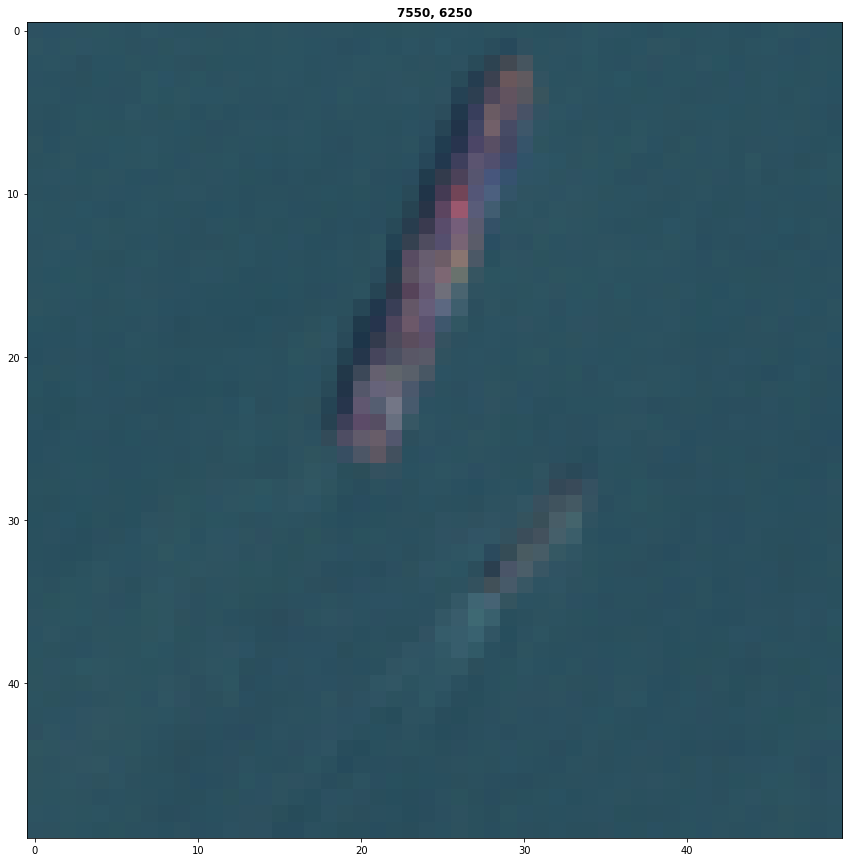

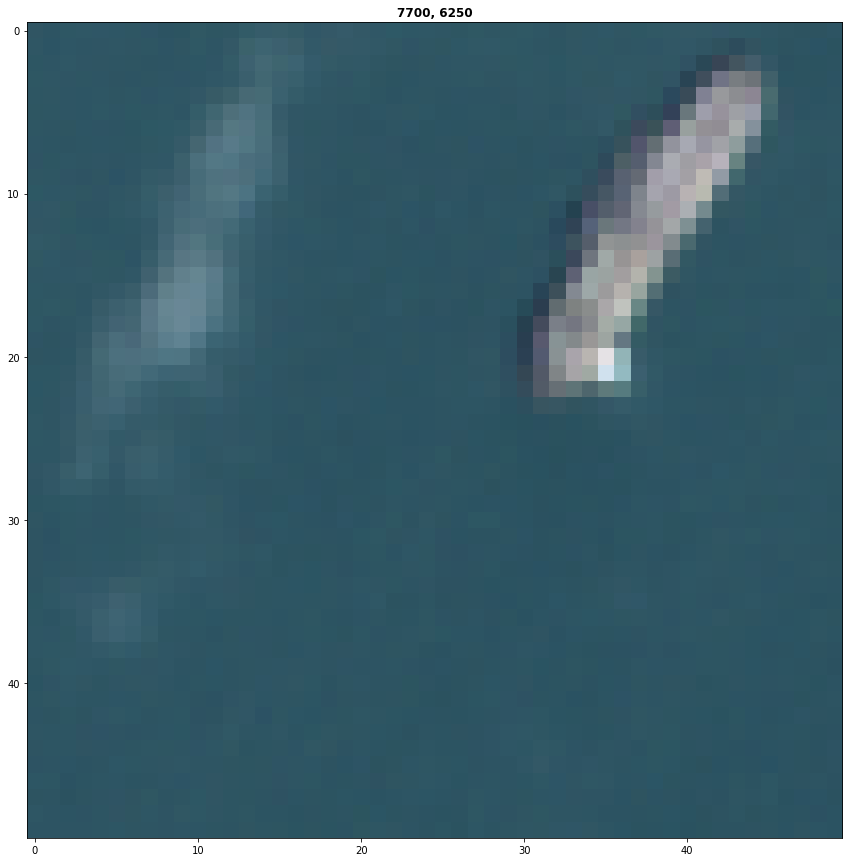

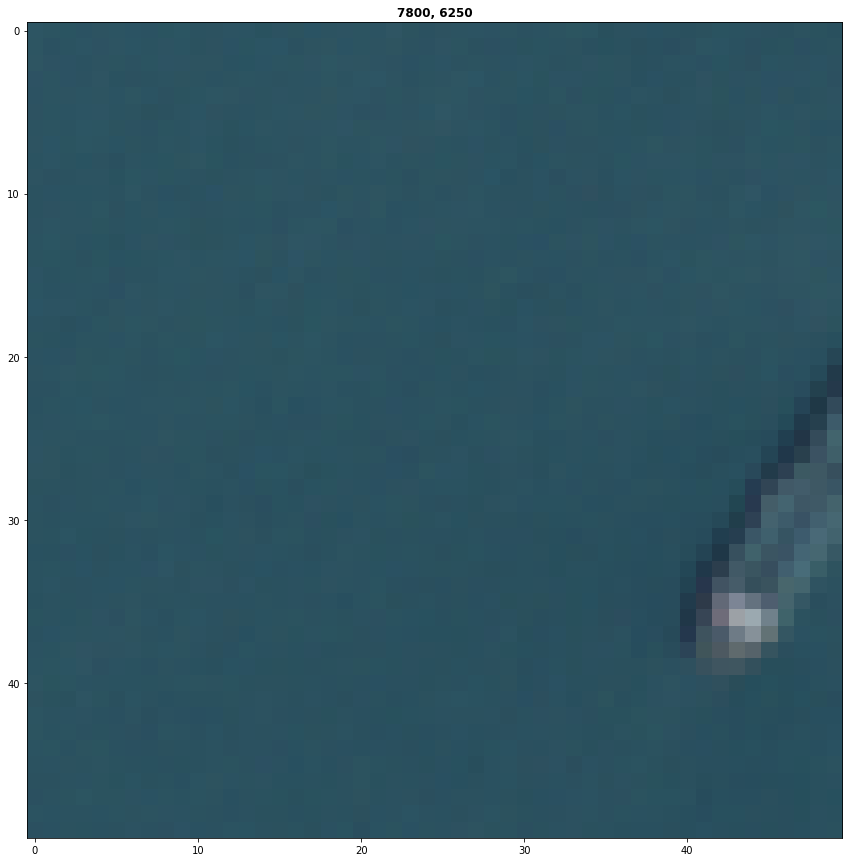

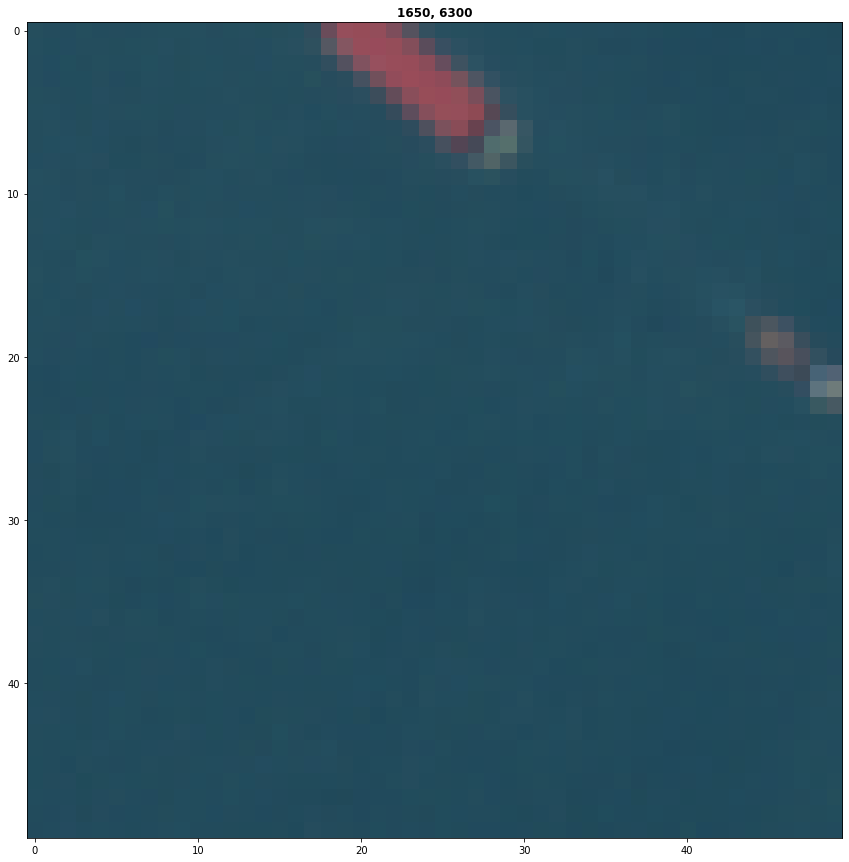

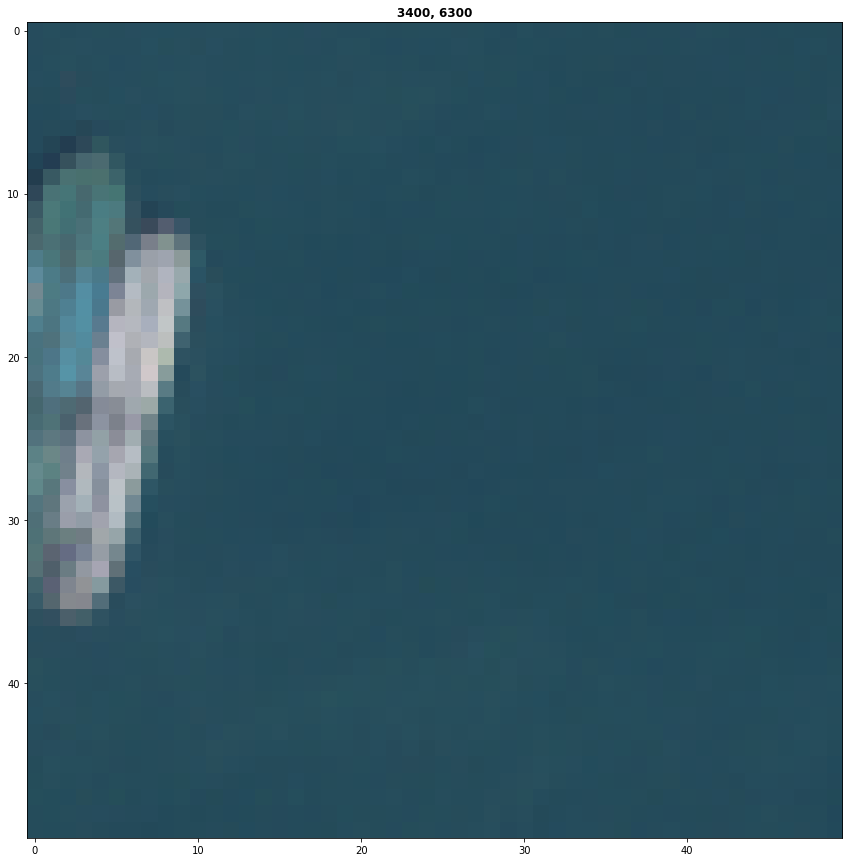

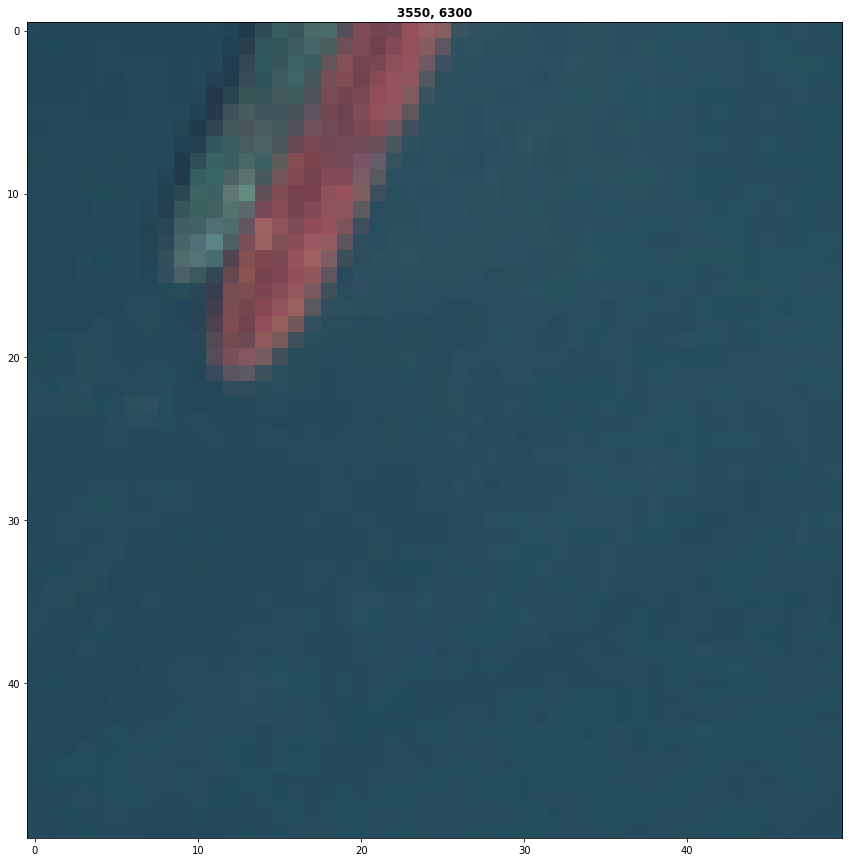

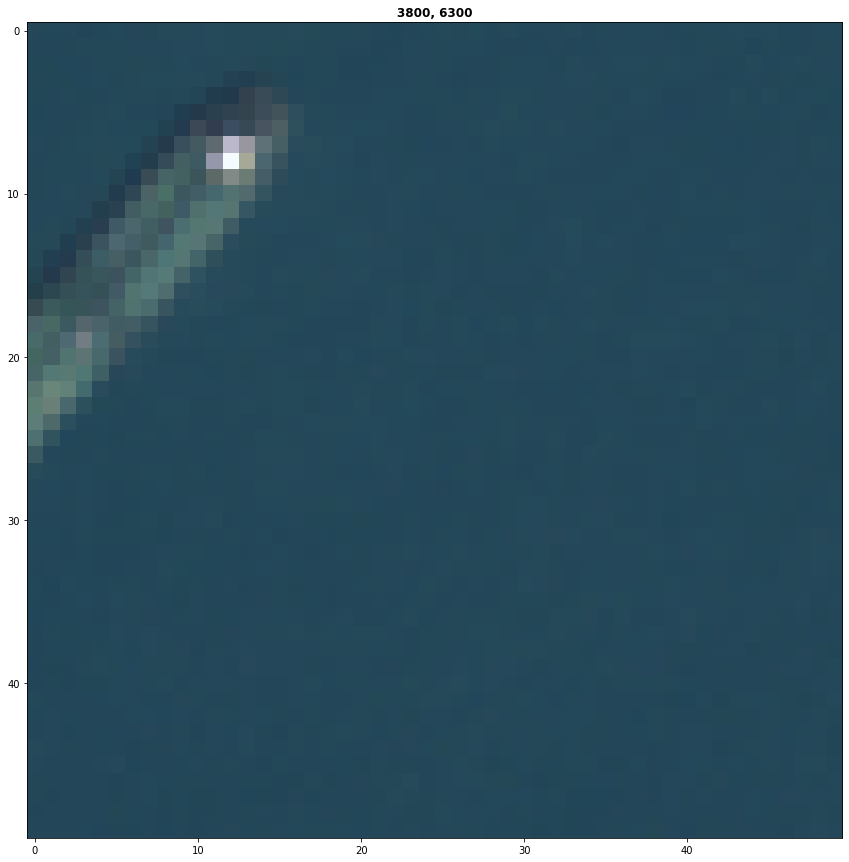

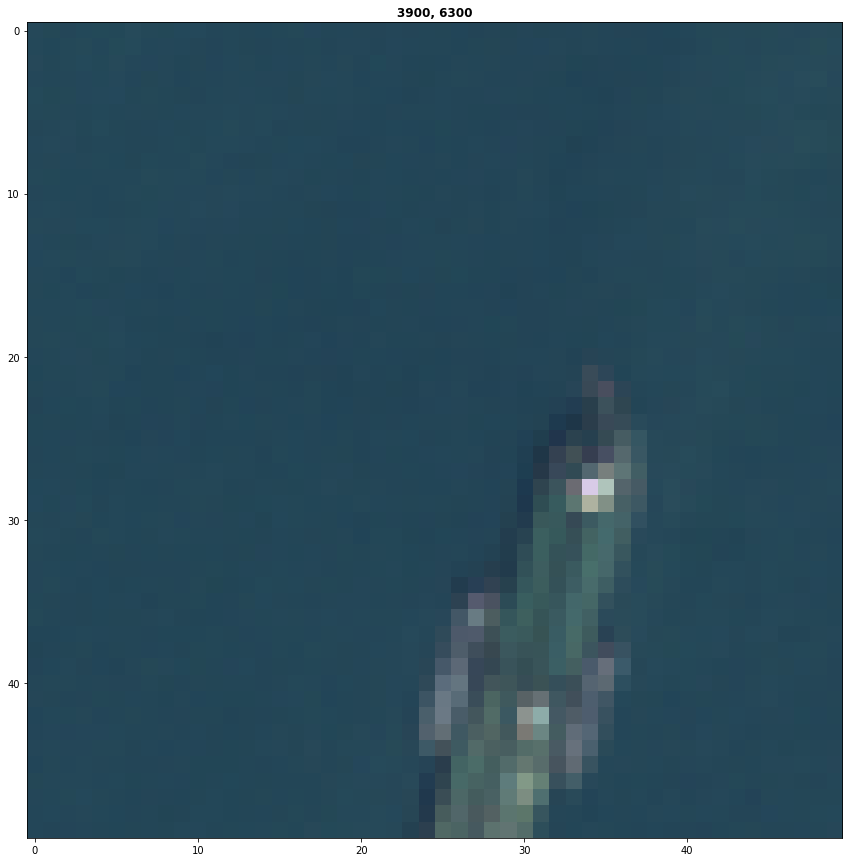

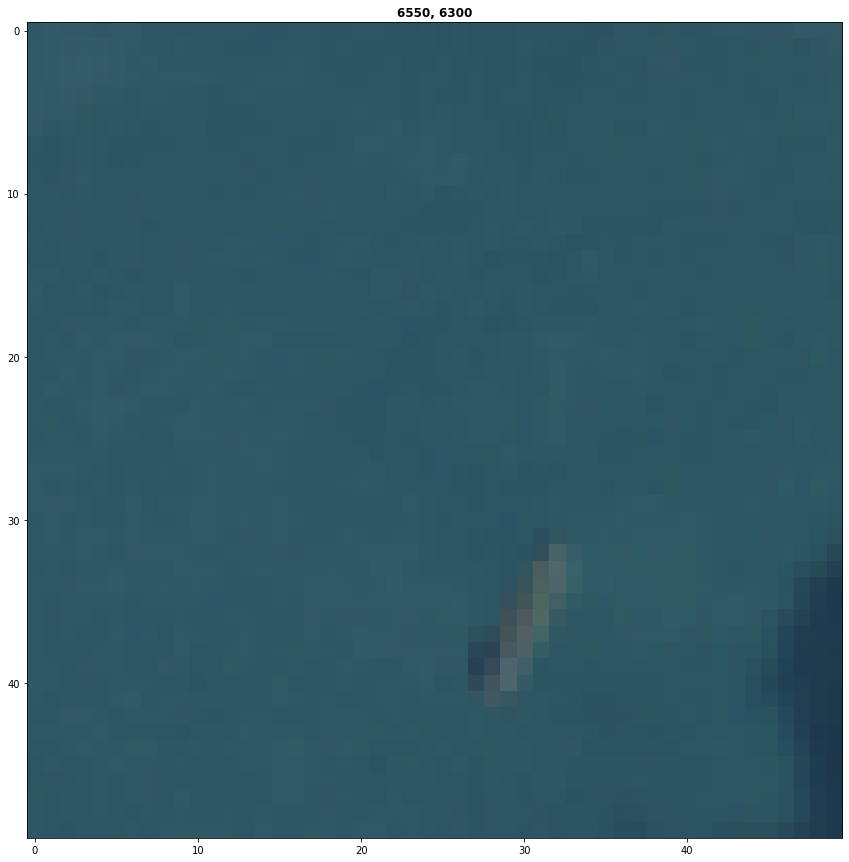

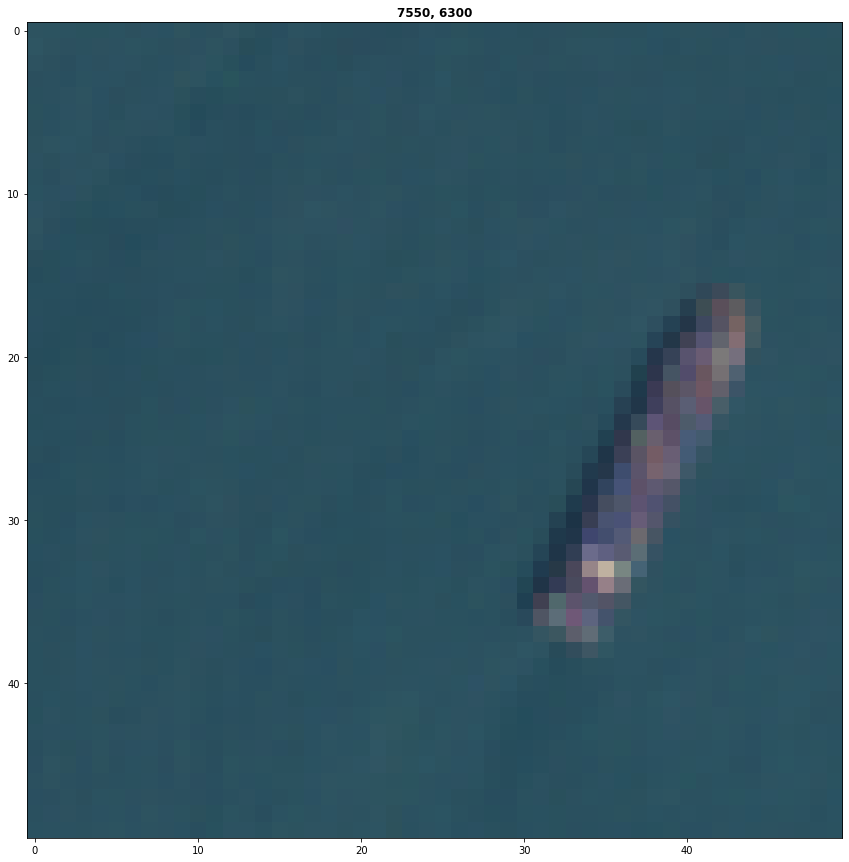

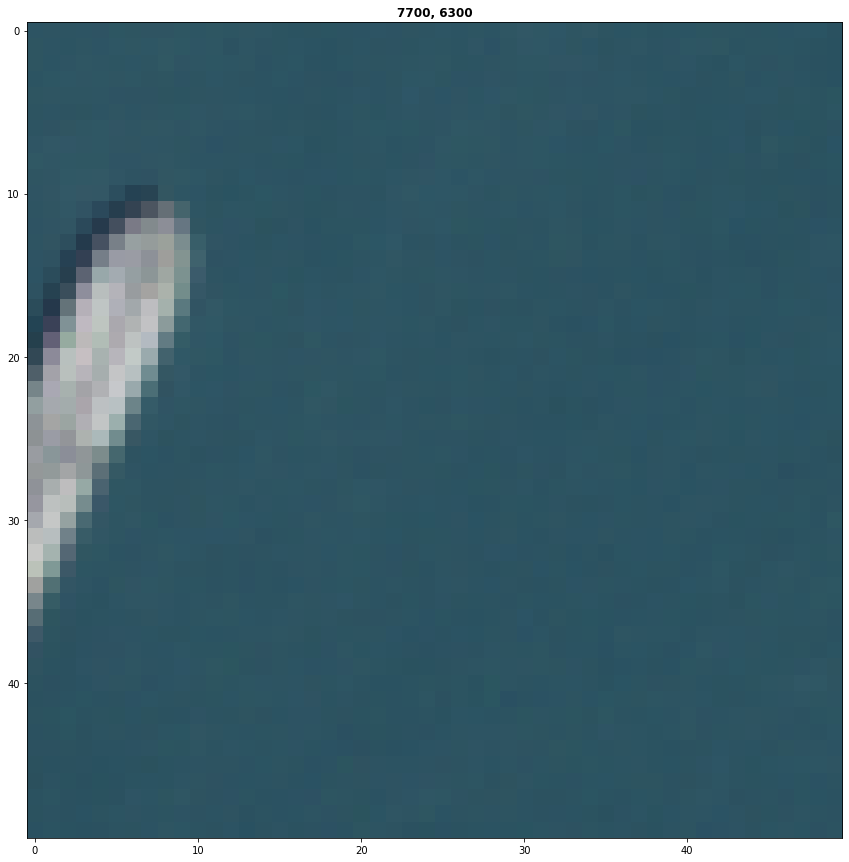

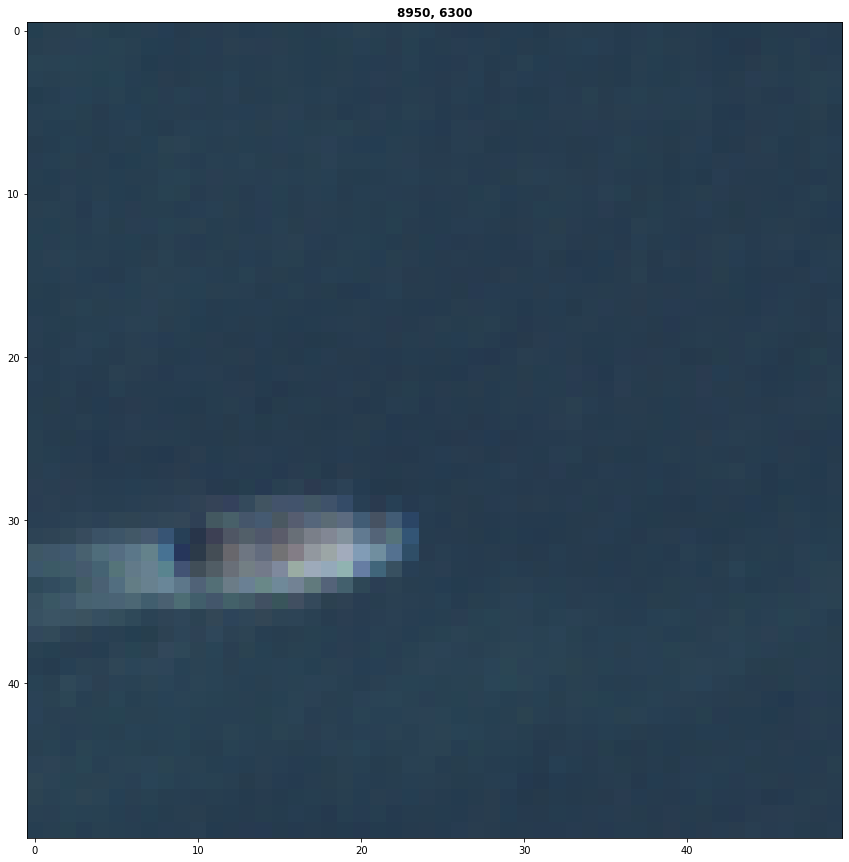

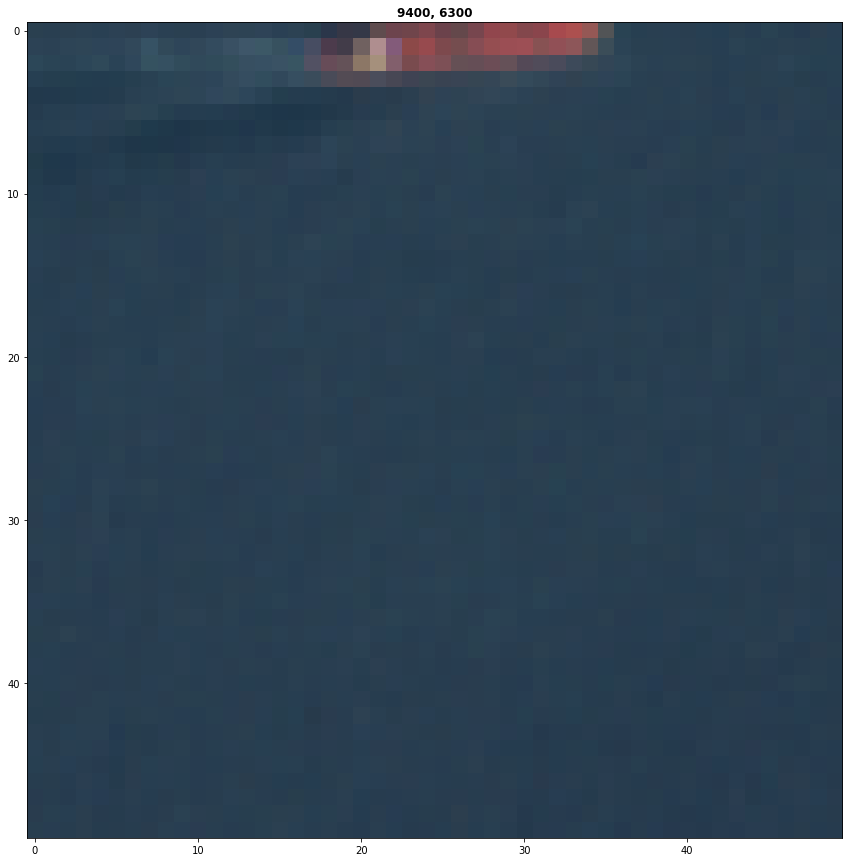

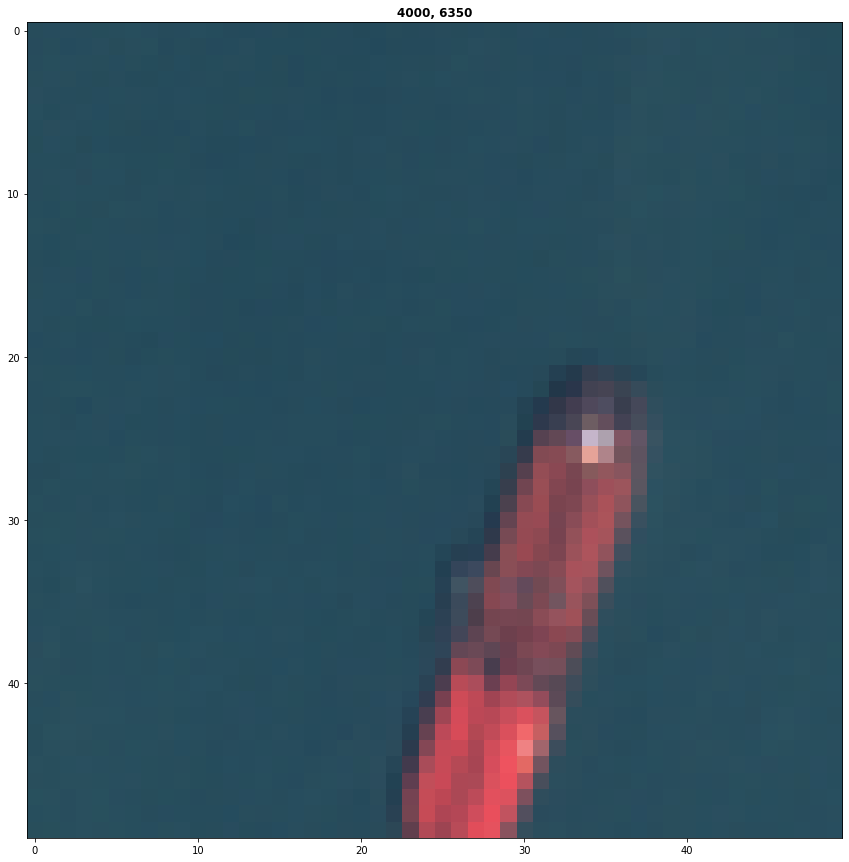

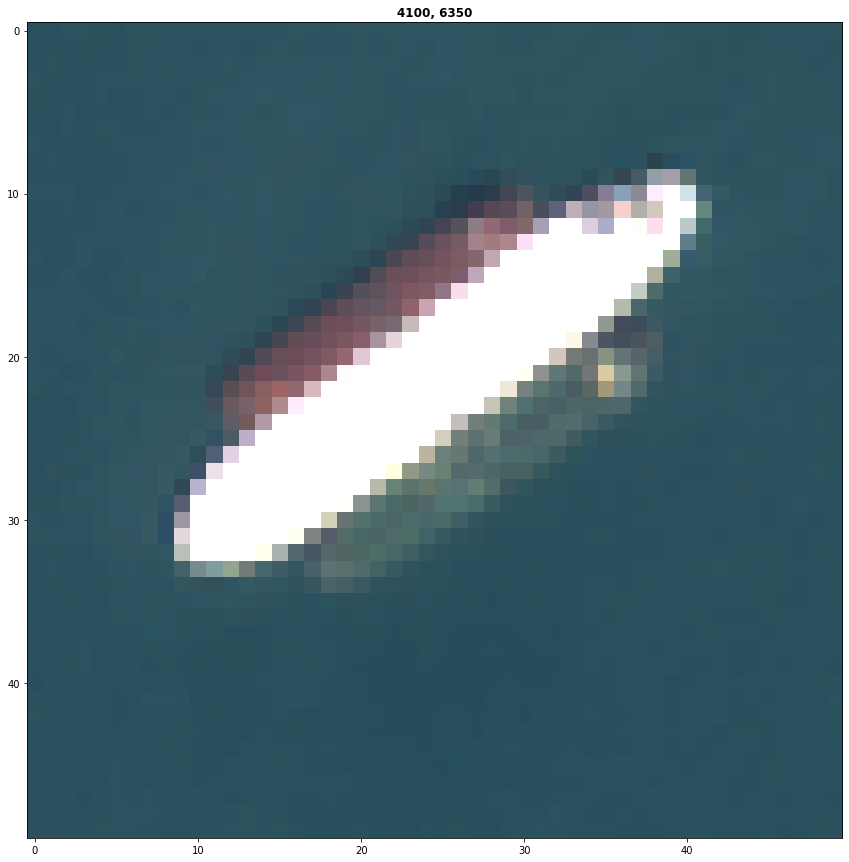

In [88]:
test_ships = nn.loc[nn.isShip == True]
for i in range(0,200):
  test_w = rio.windows.Window(test_ships.iloc[i].x,test_ships.iloc[i].y, test_ships.iloc[i].patch_size, test_ships.iloc[i].patch_size)
  test_patch = sat_img.read(window=test_w)
  fig, ax = plt.subplots(figsize=(15,15))
  show(test_patch, ax=ax,  title=str(test_ships.iloc[i].x)+', '+str(test_ships.iloc[i].y))

In [47]:
test

(133225, 5)

In [121]:
index = 100
patch_size = 50
step_size = 30
window = rio.windows.Window(4100,6350, patch_size, patch_size)
centroid = Point(sat_img.transform *(window.col_off+patch_size/2, window.row_off+patch_size/2))
buffer = gpd.GeoDataFrame({'index': [index], 'geometry':[centroid.buffer(sat_img.transform[0]*step_size/1.5)]}, crs = ship_points.crs)
patch_poly = Polygon([sat_img.transform * (window.col_off+patch_size, window.row_off+patch_size), #must be a more pythonic way to do this
                                sat_img.transform * (window.col_off+patch_size, window.row_off+patch_size),
                                sat_img.transform * (window.col_off+patch_size, window.row_off+patch_size),
                                sat_img.transform * (window.col_off+patch_size, window.row_off+patch_size)])
patch_gdf = gpd.GeoDataFrame({'index': [index], 'geometry':[patch_poly]}, crs = ship_points.crs)

# print(patch_poly.bounds)
# win_transform = sat_img.window_transform(window)
# patch = sat_img.read(window=window)
#print(win_transform)

#a = gpd.sjoin(buffer, ship_points, how='inner', op='intersects')
type(ship_points), type(buffer)
gpd.sjoin(ship_points, buffer)


# possible_matches_index = list(ship_points.intersects(buffer.bounds))
# print(possible_matches_index)
# possible_matches = ships.iloc[possible_matches_index]
# print(possible_matches)
# precise_matches = possible_matches[possible_matches.intersects(geometry)]
# print(precise_matches)
# if len(precise_matches.index) > 0:
#   isShip = True
# else:
#   isShip = False

AttributeError: ignored

(136040.0, 136540.0)

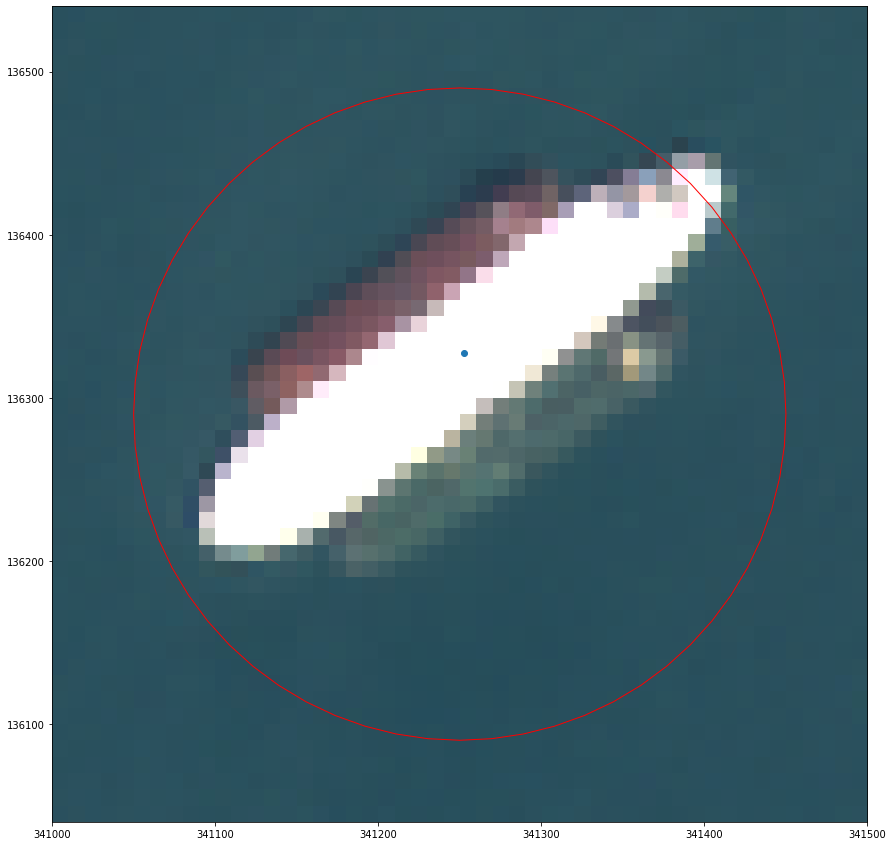

In [115]:
fig, ax = plt.subplots(figsize=(15, 15))
show(sat_img, ax=ax)
buffer.plot(ax=ax, facecolor='none', edgecolor='red')
patch_gdf.plot(ax=ax, facecolor='none', edgecolor='blue')
ship_points.plot(ax=ax)
ax.set_xlim(341000, 341500)
ax.set_ylim(136040, 136540.00)

In [123]:
!conda

/bin/bash: conda: command not found
